In [2]:
import os, sys

# path to access c++ files
installation_path = os.getenv("INSTALL_PATH")
sys.path.append(installation_path)

In [3]:
from cunqa import getQPUs

qpus  = getQPUs()

for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend.name}, simulator: {q.backend.simulator}, version: {q.backend.version}.")


	info: Logger created.
	debug: File accessed correctly.
	debug: Object for QPU 0 created correctly.
	debug: Object for QPU 1 created correctly.
	debug: Object for QPU 2 created correctly.
	debug: Object for QPU 3 created correctly.
	debug: Object for QPU 4 created correctly.
	debug: Object for QPU 5 created correctly.
	debug: Object for QPU 6 created correctly.
	debug: Object for QPU 7 created correctly.
	debug: Object for QPU 8 created correctly.
	debug: Object for QPU 9 created correctly.
	debug: 10 QPU objects were created.
QPU 0, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 1, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 2, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 3, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 4, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 5, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 6, backend: BasicAer, simulator: AerSimulator, version: 0.0.1

# Examples for optimizations

Before sending a circuit to the QClient, a transpilation process occurs (if not, it is done by the user). This process, in some cases, can take much time and resources, in addition to the sending cost itself. If we were to execute a single circuit once, it shouldn´t be a big problem, but it is when it comes to variational algorithms.

This quantum-classical algorithms require several executions of the same circuit but changing the value of the parameters, which are optimized in the classical part. In order to optimize this, we developed a functionallity that allows the user to upgrade the circuit parameters with no extra transpilations of the circuit, sending to the `QClient` the list of the parameters **ONLY**. This is of much advantage to speed up the computation in the cases in which transpilation takes a significant part of the total time of the simulation.

Let´s see how to work with this feature taking as an example a _Variational Quantum Algorithm_ for state preparation.

We start from a _Hardware Efficient Ansatz_ to build our parametrized circuit:

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def hardware_efficient_ansatz(num_qubits, num_layers):
    qc = QuantumCircuit(num_qubits)
    param_idx = 0
    for _ in range(num_layers):
        for qubit in range(num_qubits):
            phi = Parameter(f'phi_{param_idx}_{qubit}')
            lam = Parameter(f'lam_{param_idx}_{qubit}')
            qc.ry(phi, qubit)
            qc.rz(lam, qubit)
        param_idx += 1
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)
    qc.measure_all()
    return qc

The we need a cost function. We will define a target distribution and measure how far we are from it. We choose to prepare a normal distribution among all the $2^n$ possible outcomes of the circuit.

In [4]:
def target_distribution(num_qubits):
    # Define a normal distribution over the states
    num_states = 2 ** num_qubits
    states = np.arange(num_states)
    mean = num_states / 2
    std_dev = num_states / 4
    target_probs = norm.pdf(states, mean, std_dev)
    target_probs /= target_probs.sum()  # Normalize to make it a valid probability distribution
    target_dist = {format(i, f'0{num_qubits}b'): target_probs[i] for i in range(num_states)}
    return target_dist

import pandas as pd
from scipy.stats import entropy, norm

def KL_divergence(counts, n_shots, target_dist):
    # Convert counts to probabilities
    pdf = pd.DataFrame.from_dict(counts, orient="index").reset_index()
    pdf.rename(columns={"index": "state", 0: "counts"}, inplace=True)
    pdf["probability"] = pdf["counts"] / n_shots
    
    # Create a dictionary for the obtained distribution
    obtained_dist = pdf.set_index("state")["probability"].to_dict()
    
    # Ensure all states are present in the obtained distribution
    for state in target_dist:
        if state not in obtained_dist:
            obtained_dist[state] = 0.0
    
    # Convert distributions to lists for KL divergence calculation
    target_probs = [target_dist[state] for state in sorted(target_dist)]
    obtained_probs = [obtained_dist[state] for state in sorted(obtained_dist)]
    
    # Calculate KL divergence
    kl_divergence = entropy(obtained_probs, target_probs)
    
    return kl_divergence
    

In [12]:
num_qubits = 6

num_layers = 3

n_shots = 1e5

### Simply using the `QPU.run()` method

At first we should try the intiutive alternative: upgrading parameters at the QClient, transpiling and sending the whole circuit to the QPU.

In [6]:
def cost_function_run(params):
    n_shots = 1e5
    target_dist = target_distribution(num_qubits)
    
    circuit = ansatz.assign_parameters(params)
    
    result = qpu.run(circuit, transpile = True, opt_level = 0, shots = n_shots).result()
    
    counts = result.get_counts()
    
    return KL_divergence(counts, n_shots, target_dist)

Our cost function updates the parameters given by the optimizer, asigns them to the ansatz and sends the circuit with the transpilation option set `True`. Let´s choose a QPU to work with and go ahead with the optimization:

In [7]:
import numpy as np
import time

qpu = qpus[0]

In [8]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters

initial_parameters = np.zeros(num_parameters)

from scipy.optimize import minimize

i = 0

cost_run = []
individuals_run = []

def callback(xk):
    global i
    e = cost_function_run(xk)
    individuals_run.append(xk)
    cost_run.append(e)
    if i%20 == 0:
        print(f"Iteration step {i}: f(x) = {e}")
    i+=1

tick = time.time()
optimization_result_run = minimize(cost_function_run, initial_parameters, method='COBYLA',
        callback=callback, tol = 0.01,
        options={
        'disp': True,     # Print info at the end
        'maxiter': 4000   # Limit the number of iterations
    })
tack = time.time()
time_run = tack-tick
print()
print("Total optimization time: ", time_run, " s")
print()

	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [3], 

	debug: Results correctly loaded.
Iteration step 0: f(x) = 5.644885693319627
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [1.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [1.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [1.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [1.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [1.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [1.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [1.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [1.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [1.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [0.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
Iteration step 20: f(x) = 3.2445195698171907
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [1.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [1.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [1.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]},

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [1.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [1.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [1.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [1.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [1.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [1.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Results correctly loaded.
	debug: Transpilation done.
	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [1.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [1], "params": [1.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0]}, {"name": "ry", "qubits": [2], "params": [1.0]}, {"name": "rz", "qubits": [2], "params": [0.0]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [0.0]}, {"name": "rz", "qubits": [1], "params": [0.0]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [0.0]}, {"name": "rz", "qubits": [0], "params": [0.0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066680888, 'time_taken_parameter_binding': 1.1511e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 11233, '0x1': 1020, '0x10': 1017, '0x11': 92, '0x12': 25, '0x13': 3429, '0x14': 971, '0x15': 11457, '0x16': 303, '0x17': 252, '0x18': 3370, '0x19': 3447, '0x1a': 93, '0x1b': 1027, '0x1c': 331, '0x1d': 286, '0x1e': 90, '0x1f': 1102, '0x2': 33, '0x20': 3320, '0x21': 285, '0x22': 14, '0x23': 1008, '0x24': 282, '0x25': 3419, '0x26': 998, '0x27': 995, '0x28': 1044, '0x29': 919, '0x2a': 298, '0x2b': 3375, '0x2c': 1003, '0x2d': 1060, '0x2e': 23, '0x2f': 320, '0x3': 3393, '0x30': 3424, '0x31': 294, '0x32': 90, '0x33': 11571, '0x34': 322, '0x35': 3347, '0x36': 79, '0x37': 85, '0x38': 999, '0x39': 1096, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065361223, 'time_taken_parameter_binding': 1.24e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 7205, '0x10': 620, '0x12': 377, '0x13': 4425, '0x14': 379, '0x15': 4366, '0x16': 892, '0x17': 974, '0x18': 2102, '0x1a': 1257, '0x1b': 1308, '0x1c': 116, '0x1d': 114, '0x1e': 279, '0x1f': 3164, '0x2': 381, '0x20': 2143, '0x22': 111, '0x23': 1381, '0x24': 111, '0x25': 1233, '0x26': 3125, '0x27': 3259, '0x28': 635, '0x2a': 4263, '0x2b': 4430, '0x2c': 368, '0x2d': 411, '0x2e': 76, '0x2f': 907, '0x3': 4423, '0x30': 2114, '0x32': 1253, '0x33': 15020, '0x34': 137, '0x35': 1321, '0x36': 270, '0x37': 262, '0x38': 661, '0x3a': 411, '0x3b': 374, '0x3c': 414, '0x3d': 416, '0x3e': 900, '0x3f': 10514, '0x4': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065977173, 'time_taken_parameter_binding': 1.2543e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 6076, '0x1': 6263, '0x10': 574, '0x11': 556, '0x12': 12, '0x13': 3568, '0x14': 6124, '0x15': 6198, '0x16': 321, '0x17': 127, '0x18': 513, '0x19': 6341, '0x1a': 17, '0x1b': 1918, '0x1c': 603, '0x1d': 51, '0x1e': 159, '0x1f': 176, '0x2': 13, '0x20': 1791, '0x21': 1849, '0x22': 3, '0x23': 1052, '0x24': 1859, '0x25': 1816, '0x26': 1033, '0x27': 531, '0x28': 179, '0x29': 1799, '0x2a': 46, '0x2b': 6285, '0x2c': 1907, '0x2d': 185, '0x2e': 53, '0x2f': 38, '0x3': 3546, '0x30': 1813, '0x31': 1900, '0x32': 42, '0x33': 12048, '0x34': 1732, '0x35': 1940, '0x36': 90, '0x37': 39, '0x38': 151, '0x39': 1964, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066617676, 'time_taken_parameter_binding': 1.148e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 3896, '0x1': 2379, '0x10': 208, '0x12': 4, '0x13': 4046, '0x14': 2367, '0x15': 3871, '0x16': 723, '0x18': 1656, '0x19': 8177, '0x1a': 36, '0x1b': 197, '0x1c': 1741, '0x1d': 717, '0x1e': 38, '0x1f': 224, '0x20': 1203, '0x21': 764, '0x23': 2433, '0x25': 663, '0x26': 1172, '0x27': 197, '0x28': 2360, '0x29': 5677, '0x2a': 53, '0x2b': 1697, '0x2c': 2346, '0x2d': 506, '0x2e': 6, '0x2f': 138, '0x3': 8141, '0x30': 717, '0x32': 20, '0x33': 13792, '0x34': 689, '0x35': 1199, '0x36': 228, '0x38': 531, '0x39': 2367, '0x3a': 11, '0x3b': 62, '0x3c': 5772, '0x3d': 2342, '0x3e': 152, '0x3f': 691, '0x5': 201, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06593156, 'time_taken_parameter_binding': 1.2638e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 3286, '0x1': 3394, '0x10': 3287, '0x11': 3476, '0x12': 19, '0x13': 6585, '0x14': 3243, '0x15': 3359, '0x16': 54, '0x17': 25, '0x18': 553, '0x19': 6583, '0x1a': 23, '0x1b': 3560, '0x1c': 303, '0x1d': 26, '0x1e': 26, '0x1f': 28, '0x2': 1, '0x20': 274, '0x21': 330, '0x23': 549, '0x24': 3336, '0x25': 3418, '0x26': 1026, '0x27': 564, '0x28': 22, '0x29': 307, '0x2a': 24, '0x2b': 3341, '0x2c': 3334, '0x2d': 299, '0x2e': 292, '0x2f': 314, '0x3': 571, '0x30': 3452, '0x31': 3467, '0x32': 46, '0x33': 12509, '0x34': 266, '0x35': 291, '0x36': 40, '0x37': 23, '0x38': 283, '0x39': 3583, '0x3a': 19, '0x3b': 342

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.073493842, 'time_taken_parameter_binding': 1.1873e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1775, '0x1': 1850, '0x10': 526, '0x11': 587, '0x12': 1, '0x13': 332, '0x14': 1828, '0x15': 1743, '0x16': 86, '0x17': 53, '0x18': 841, '0x19': 9864, '0x1a': 61, '0x1b': 6278, '0x1c': 42, '0x1d': 3, '0x1e': 144, '0x1f': 159, '0x2': 2, '0x20': 1816, '0x21': 1877, '0x23': 81, '0x24': 6265, '0x25': 6341, '0x26': 1577, '0x27': 866, '0x28': 38, '0x29': 601, '0x2a': 17, '0x2b': 1768, '0x2c': 157, '0x2d': 14, '0x2e': 46, '0x2f': 57, '0x3': 1064, '0x30': 6020, '0x31': 6484, '0x32': 79, '0x33': 18778, '0x34': 1914, '0x35': 1799, '0x36': 11, '0x37': 4, '0x38': 11, '0x39': 157, '0x3a': 3, '0x3b': 514, '0x3c

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065554013, 'time_taken_parameter_binding': 1.244e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1768, '0x1': 3545, '0x10': 1785, '0x11': 3548, '0x12': 178, '0x13': 9834, '0x14': 516, '0x15': 2814, '0x16': 4, '0x17': 4, '0x18': 1013, '0x19': 7486, '0x1a': 555, '0x1b': 6395, '0x1c': 13, '0x1d': 15, '0x1e': 9, '0x1f': 138, '0x2': 11, '0x20': 143, '0x21': 294, '0x22': 15, '0x23': 835, '0x24': 528, '0x25': 2929, '0x26': 99, '0x27': 83, '0x28': 53, '0x29': 368, '0x2a': 557, '0x2b': 6193, '0x2c': 160, '0x2d': 161, '0x2e': 189, '0x2f': 1845, '0x3': 829, '0x30': 1765, '0x31': 3506, '0x32': 324, '0x33': 18712, '0x34': 48, '0x35': 238, '0x36': 3, '0x37': 2, '0x38': 583, '0x39': 3949, '0x3a': 536, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064616042, 'time_taken_parameter_binding': 1.2651e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1768, '0x1': 3545, '0x10': 1781, '0x11': 3681, '0x12': 509, '0x13': 3841, '0x14': 2374, '0x15': 6147, '0x16': 70, '0x17': 194, '0x18': 16, '0x19': 3616, '0x1a': 1092, '0x1b': 606, '0x1c': 233, '0x1d': 260, '0x1e': 181, '0x1f': 7, '0x2': 38, '0x20': 140, '0x21': 312, '0x22': 51, '0x23': 307, '0x24': 2358, '0x25': 6268, '0x26': 1571, '0x27': 3464, '0x29': 153, '0x2a': 1041, '0x2b': 551, '0x2c': 2978, '0x2d': 2927, '0x2e': 1841, '0x2f': 160, '0x3': 337, '0x30': 1824, '0x31': 3630, '0x32': 1073, '0x33': 7444, '0x34': 211, '0x35': 572, '0x36': 77, '0x37': 161, '0x38': 18, '0x39': 1902, '0x3a': 1087,

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062410689, 'time_taken_parameter_binding': 1.1788e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 865, '0x1': 2013, '0x10': 141, '0x11': 649, '0x12': 1647, '0x13': 2402, '0x14': 1856, '0x15': 5613, '0x16': 78, '0x17': 506, '0x18': 361, '0x19': 233, '0x1a': 2281, '0x1b': 68, '0x1c': 51, '0x1d': 28, '0x1e': 222, '0x1f': 31, '0x2': 665, '0x20': 356, '0x21': 555, '0x23': 355, '0x24': 2042, '0x25': 9608, '0x26': 358, '0x27': 3942, '0x28': 505, '0x29': 714, '0x2a': 1036, '0x2b': 239, '0x2c': 4618, '0x2d': 5851, '0x2e': 678, '0x2f': 1777, '0x3': 100, '0x30': 8, '0x31': 274, '0x32': 2401, '0x33': 4798, '0x34': 145, '0x35': 217, '0x36': 151, '0x37': 64, '0x38': 429, '0x3a': 1840, '0x3c': 1193, '0x3d

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067826752, 'time_taken_parameter_binding': 1.1872e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1248, '0x1': 1012, '0x10': 1358, '0x11': 2155, '0x12': 25, '0x13': 1913, '0x14': 4676, '0x15': 8905, '0x16': 823, '0x17': 312, '0x18': 133, '0x19': 3647, '0x1a': 655, '0x1b': 147, '0x1c': 1418, '0x1d': 2755, '0x1e': 54, '0x1f': 650, '0x2': 95, '0x20': 74, '0x21': 194, '0x22': 419, '0x23': 750, '0x24': 1221, '0x25': 3840, '0x26': 1688, '0x27': 2883, '0x28': 450, '0x29': 1537, '0x2a': 1562, '0x2b': 2644, '0x2c': 587, '0x2d': 93, '0x2e': 1126, '0x2f': 33, '0x3': 20, '0x30': 1435, '0x31': 3440, '0x32': 586, '0x33': 5321, '0x34': 2353, '0x35': 3068, '0x36': 159, '0x37': 25, '0x38': 528, '0x39': 4552

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065566341, 'time_taken_parameter_binding': 1.1869e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 183, '0x1': 1, '0x10': 1384, '0x11': 1224, '0x12': 26, '0x13': 630, '0x14': 5782, '0x15': 12732, '0x16': 1973, '0x17': 1702, '0x19': 1181, '0x1a': 11, '0x1b': 201, '0x1c': 1905, '0x1d': 2562, '0x1e': 562, '0x1f': 610, '0x2': 383, '0x20': 102, '0x21': 1195, '0x22': 489, '0x23': 2038, '0x24': 4, '0x25': 83, '0x26': 523, '0x27': 1507, '0x28': 544, '0x29': 4102, '0x2a': 2176, '0x2b': 2465, '0x2c': 12, '0x2d': 263, '0x2e': 644, '0x2f': 50, '0x3': 937, '0x30': 2441, '0x31': 4522, '0x32': 282, '0x33': 4345, '0x34': 4439, '0x35': 7426, '0x36': 1129, '0x37': 298, '0x38': 130, '0x39': 2550, '0x3a': 304, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065250281, 'time_taken_parameter_binding': 1.2331e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 724, '0x1': 1140, '0x10': 2545, '0x11': 4693, '0x12': 252, '0x13': 5482, '0x14': 6752, '0x15': 12079, '0x16': 962, '0x17': 167, '0x18': 413, '0x19': 7279, '0x1a': 1393, '0x1b': 601, '0x1c': 1437, '0x1d': 3325, '0x1e': 9, '0x1f': 675, '0x2': 3, '0x20': 592, '0x21': 11, '0x22': 562, '0x23': 450, '0x24': 3059, '0x25': 8210, '0x26': 3462, '0x27': 4780, '0x28': 741, '0x29': 1957, '0x2a': 2133, '0x2b': 4554, '0x2c': 2422, '0x2d': 1117, '0x2e': 2467, '0x2f': 171, '0x3': 344, '0x30': 251, '0x31': 867, '0x32': 352, '0x33': 1835, '0x34': 93, '0x35': 9, '0x36': 4, '0x37': 175, '0x38': 249, '0x39': 828, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069561252, 'time_taken_parameter_binding': 1.2398e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2, '0x1': 139, '0x10': 1, '0x11': 9300, '0x12': 295, '0x13': 4411, '0x14': 1255, '0x15': 9174, '0x16': 922, '0x17': 717, '0x18': 59, '0x19': 15709, '0x1a': 1078, '0x1b': 5471, '0x1c': 194, '0x1d': 2584, '0x1e': 52, '0x1f': 324, '0x2': 3, '0x20': 27, '0x21': 378, '0x22': 235, '0x23': 782, '0x24': 1207, '0x25': 11277, '0x26': 2211, '0x27': 3334, '0x29': 6970, '0x2a': 839, '0x2b': 6291, '0x2c': 742, '0x2d': 3312, '0x2e': 1369, '0x2f': 607, '0x3': 3, '0x31': 1121, '0x32': 59, '0x33': 669, '0x34': 20, '0x35': 144, '0x36': 13, '0x37': 4, '0x38': 4, '0x39': 2047, '0x3a': 113, '0x3b': 823, '0x3d': 27, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.07027902, 'time_taken_parameter_binding': 1.2617e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 733, '0x1': 1080, '0x10': 2528, '0x11': 4432, '0x12': 247, '0x13': 5164, '0x14': 7115, '0x15': 11333, '0x16': 1189, '0x17': 155, '0x18': 383, '0x19': 6892, '0x1a': 1577, '0x1b': 601, '0x1c': 1478, '0x1d': 3155, '0x1e': 21, '0x1f': 667, '0x2': 2, '0x20': 647, '0x21': 8, '0x22': 600, '0x23': 459, '0x24': 3160, '0x25': 7739, '0x26': 4659, '0x27': 4457, '0x28': 803, '0x29': 1778, '0x2a': 2313, '0x2b': 4370, '0x2c': 2606, '0x2d': 1074, '0x2e': 2968, '0x2f': 168, '0x3': 309, '0x30': 242, '0x31': 819, '0x32': 355, '0x33': 1745, '0x34': 100, '0x35': 22, '0x36': 9, '0x37': 138, '0x38': 257, '0x39': 784, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058085054, 'time_taken_parameter_binding': 1.244e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 4, '0x1': 128, '0x10': 2, '0x11': 8694, '0x12': 384, '0x13': 4134, '0x14': 1737, '0x15': 8603, '0x16': 1521, '0x17': 639, '0x18': 149, '0x19': 14668, '0x1a': 1445, '0x1b': 5157, '0x1c': 282, '0x1d': 2407, '0x1e': 100, '0x1f': 317, '0x2': 6, '0x20': 34, '0x21': 379, '0x22': 340, '0x23': 705, '0x24': 1680, '0x25': 10585, '0x26': 3594, '0x27': 3109, '0x28': 6, '0x29': 6521, '0x2a': 1128, '0x2b': 5890, '0x2c': 1109, '0x2d': 3060, '0x2e': 2158, '0x2f': 617, '0x3': 3, '0x31': 1018, '0x32': 82, '0x33': 606, '0x34': 41, '0x35': 141, '0x36': 17, '0x37': 1, '0x38': 8, '0x39': 1920, '0x3a': 168, '0x3b': 77

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063545206, 'time_taken_parameter_binding': 1.1213e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 955, '0x10': 3409, '0x11': 3863, '0x12': 410, '0x13': 5416, '0x14': 8268, '0x15': 10642, '0x16': 1004, '0x17': 105, '0x18': 937, '0x19': 5595, '0x1a': 1571, '0x1b': 873, '0x1c': 1735, '0x1d': 2889, '0x1e': 68, '0x1f': 667, '0x2': 16, '0x20': 643, '0x21': 22, '0x22': 639, '0x23': 578, '0x24': 3780, '0x25': 7014, '0x26': 3352, '0x27': 4014, '0x28': 1083, '0x29': 1508, '0x2a': 2606, '0x2b': 5136, '0x2c': 2758, '0x2d': 1174, '0x2e': 2551, '0x2f': 103, '0x3': 323, '0x30': 380, '0x31': 656, '0x32': 493, '0x33': 1925, '0x34': 101, '0x35': 21, '0x36': 10, '0x37': 139, '0x38': 374, '0x39': 6

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067791925, 'time_taken_parameter_binding': 1.1616e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 25, '0x1': 108, '0x10': 647, '0x11': 7300, '0x12': 721, '0x13': 4577, '0x14': 3560, '0x15': 8277, '0x16': 1014, '0x17': 393, '0x18': 636, '0x19': 12023, '0x1a': 1812, '0x1b': 6134, '0x1c': 650, '0x1d': 2283, '0x1e': 57, '0x1f': 268, '0x2': 5, '0x20': 28, '0x21': 284, '0x22': 377, '0x23': 901, '0x24': 3592, '0x25': 10090, '0x26': 2190, '0x27': 2286, '0x28': 381, '0x29': 5428, '0x2a': 1654, '0x2b': 6798, '0x2c': 1925, '0x2d': 3148, '0x2e': 1382, '0x2f': 372, '0x3': 1, '0x30': 57, '0x31': 847, '0x32': 145, '0x33': 681, '0x34': 76, '0x35': 129, '0x36': 8, '0x38': 100, '0x39': 1581, '0x3a': 247, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.057983984, 'time_taken_parameter_binding': 1.2264e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1064, '0x1': 853, '0x10': 3851, '0x11': 3487, '0x12': 322, '0x13': 5324, '0x14': 8107, '0x15': 10592, '0x16': 911, '0x17': 287, '0x18': 2005, '0x19': 5145, '0x1a': 1298, '0x1b': 990, '0x1c': 1763, '0x1d': 2806, '0x1e': 24, '0x1f': 638, '0x2': 9, '0x20': 652, '0x21': 34, '0x22': 527, '0x23': 600, '0x24': 3782, '0x25': 6854, '0x26': 3051, '0x27': 4592, '0x28': 1299, '0x29': 1353, '0x2a': 2119, '0x2b': 5080, '0x2c': 2794, '0x2d': 1250, '0x2e': 2338, '0x2f': 554, '0x3': 319, '0x30': 461, '0x31': 596, '0x32': 406, '0x33': 1880, '0x34': 104, '0x35': 23, '0x36': 2, '0x37': 154, '0x38': 466, '0x39': 60

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066108121, 'time_taken_parameter_binding': 1.231e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 28, '0x1': 106, '0x10': 1018, '0x11': 7243, '0x12': 583, '0x13': 4153, '0x14': 3721, '0x15': 8623, '0x16': 756, '0x17': 638, '0x18': 1370, '0x19': 12234, '0x1a': 1451, '0x1b': 5572, '0x1c': 691, '0x1d': 2307, '0x1e': 26, '0x1f': 249, '0x2': 4, '0x20': 62, '0x21': 302, '0x22': 308, '0x23': 824, '0x24': 3757, '0x25': 10413, '0x26': 1505, '0x27': 2572, '0x28': 702, '0x29': 5398, '0x2a': 1305, '0x2b': 6165, '0x2c': 2064, '0x2d': 3456, '0x2e': 981, '0x2f': 726, '0x3': 4, '0x30': 98, '0x31': 858, '0x32': 109, '0x33': 615, '0x34': 83, '0x35': 131, '0x36': 15, '0x37': 8, '0x38': 201, '0x39': 1585, '0x3a

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069007016, 'time_taken_parameter_binding': 1.1874e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1436, '0x1': 782, '0x10': 5003, '0x11': 3128, '0x12': 296, '0x13': 5189, '0x14': 7577, '0x15': 10009, '0x16': 851, '0x17': 101, '0x18': 989, '0x19': 5315, '0x1a': 1252, '0x1b': 1909, '0x1c': 1443, '0x1d': 2821, '0x1e': 136, '0x1f': 1091, '0x2': 4, '0x20': 1056, '0x21': 165, '0x22': 496, '0x23': 816, '0x24': 2980, '0x25': 6881, '0x26': 3001, '0x27': 5542, '0x28': 1576, '0x29': 1258, '0x2a': 2002, '0x2b': 4906, '0x2c': 3454, '0x2d': 1073, '0x2e': 2225, '0x2f': 69, '0x3': 306, '0x30': 485, '0x31': 595, '0x32': 352, '0x33': 1667, '0x34': 152, '0x35': 27, '0x36': 22, '0x37': 226, '0x38': 493, '0x39'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067357548, 'time_taken_parameter_binding': 1.1436e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 129, '0x1': 59, '0x10': 2126, '0x11': 5854, '0x12': 365, '0x13': 3696, '0x14': 3636, '0x15': 7910, '0x16': 577, '0x17': 290, '0x18': 545, '0x19': 12734, '0x1a': 1599, '0x1b': 6502, '0x1c': 397, '0x1d': 2717, '0x1e': 146, '0x1f': 1217, '0x2': 3, '0x20': 110, '0x21': 716, '0x22': 347, '0x23': 1377, '0x24': 2848, '0x25': 11166, '0x26': 1787, '0x27': 4129, '0x28': 936, '0x29': 4792, '0x2a': 1173, '0x2b': 5577, '0x2c': 2728, '0x2d': 2461, '0x2e': 743, '0x2f': 125, '0x3': 60, '0x30': 176, '0x31': 731, '0x32': 97, '0x33': 519, '0x34': 104, '0x35': 104, '0x36': 6, '0x37': 14, '0x38': 118, '0x39': 1580,

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061388726, 'time_taken_parameter_binding': 1.1854e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1457, '0x1': 857, '0x10': 4750, '0x11': 3278, '0x12': 354, '0x13': 4260, '0x14': 7362, '0x15': 10158, '0x16': 627, '0x17': 284, '0x18': 993, '0x19': 5023, '0x1a': 1139, '0x1b': 2578, '0x1c': 1827, '0x1d': 3115, '0x1e': 451, '0x1f': 1056, '0x2': 23, '0x20': 1403, '0x21': 604, '0x22': 544, '0x23': 380, '0x24': 2749, '0x25': 6286, '0x26': 2789, '0x27': 5344, '0x28': 1398, '0x29': 999, '0x2a': 2010, '0x2b': 5594, '0x2c': 3469, '0x2d': 1310, '0x2e': 2302, '0x2f': 182, '0x3': 203, '0x30': 484, '0x31': 594, '0x32': 358, '0x33': 1551, '0x34': 166, '0x35': 28, '0x36': 7, '0x37': 224, '0x38': 492, '0x39'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063119436, 'time_taken_parameter_binding': 1.2234e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 143, '0x1': 154, '0x10': 1973, '0x11': 6213, '0x12': 370, '0x13': 2577, '0x14': 3657, '0x15': 8107, '0x16': 512, '0x17': 701, '0x18': 513, '0x19': 11939, '0x1a': 1518, '0x1b': 7034, '0x1c': 520, '0x1d': 3476, '0x1e': 312, '0x1f': 917, '0x2': 17, '0x20': 232, '0x21': 1344, '0x22': 400, '0x23': 639, '0x24': 2914, '0x25': 10014, '0x26': 1575, '0x27': 4267, '0x28': 950, '0x29': 4380, '0x2a': 1253, '0x2b': 6869, '0x2c': 2489, '0x2d': 2837, '0x2e': 838, '0x2f': 15, '0x30': 156, '0x31': 737, '0x32': 82, '0x33': 450, '0x34': 106, '0x35': 138, '0x36': 6, '0x37': 40, '0x38': 96, '0x39': 1452, '0x3a': 189

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064603133, 'time_taken_parameter_binding': 1.2438e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2054, '0x1': 1469, '0x10': 4307, '0x11': 2880, '0x12': 366, '0x13': 3875, '0x14': 7067, '0x15': 9792, '0x16': 616, '0x17': 176, '0x18': 929, '0x19': 4768, '0x1a': 1150, '0x1b': 2691, '0x1c': 2011, '0x1d': 3259, '0x1e': 254, '0x1f': 944, '0x2': 17, '0x20': 1159, '0x21': 338, '0x22': 590, '0x23': 377, '0x24': 2706, '0x25': 6080, '0x26': 2637, '0x27': 5006, '0x28': 1295, '0x29': 961, '0x2a': 1863, '0x2b': 5829, '0x2c': 3518, '0x2d': 1648, '0x2e': 1902, '0x2f': 101, '0x3': 449, '0x30': 679, '0x31': 892, '0x32': 379, '0x33': 1932, '0x34': 170, '0x35': 224, '0x36': 61, '0x37': 464, '0x38': 575, '0x39

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06351897, 'time_taken_parameter_binding': 1.1851e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 368, '0x1': 1605, '0x10': 1761, '0x11': 5385, '0x12': 414, '0x13': 2298, '0x14': 3614, '0x15': 7845, '0x16': 490, '0x17': 481, '0x18': 436, '0x19': 11062, '0x1a': 1439, '0x1b': 7179, '0x1c': 710, '0x1d': 3921, '0x1e': 194, '0x1f': 867, '0x2': 15, '0x20': 180, '0x21': 762, '0x22': 431, '0x23': 647, '0x24': 2840, '0x25': 9688, '0x26': 1442, '0x27': 3783, '0x28': 855, '0x29': 3974, '0x2a': 1245, '0x2b': 6977, '0x2c': 2554, '0x2d': 3003, '0x2e': 726, '0x2f': 15, '0x3': 346, '0x30': 262, '0x31': 1469, '0x32': 120, '0x33': 875, '0x34': 70, '0x35': 328, '0x36': 53, '0x37': 373, '0x38': 197, '0x39': 151

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.057482788, 'time_taken_parameter_binding': 1.1776e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2054, '0x1': 1469, '0x10': 4307, '0x11': 2880, '0x12': 366, '0x13': 3875, '0x14': 7067, '0x15': 9792, '0x16': 616, '0x17': 176, '0x18': 929, '0x19': 4768, '0x1a': 1150, '0x1b': 2691, '0x1c': 2011, '0x1d': 3259, '0x1e': 254, '0x1f': 944, '0x2': 17, '0x20': 1159, '0x21': 338, '0x22': 590, '0x23': 377, '0x24': 2706, '0x25': 6080, '0x26': 2637, '0x27': 5006, '0x28': 1295, '0x29': 961, '0x2a': 1863, '0x2b': 5829, '0x2c': 3518, '0x2d': 1648, '0x2e': 1902, '0x2f': 101, '0x3': 449, '0x30': 679, '0x31': 892, '0x32': 379, '0x33': 1932, '0x34': 170, '0x35': 224, '0x36': 61, '0x37': 464, '0x38': 575, '0x39

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061830721, 'time_taken_parameter_binding': 1.1738e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 368, '0x1': 1605, '0x10': 1761, '0x11': 5385, '0x12': 414, '0x13': 2298, '0x14': 3614, '0x15': 7845, '0x16': 490, '0x17': 481, '0x18': 436, '0x19': 11062, '0x1a': 1439, '0x1b': 7179, '0x1c': 710, '0x1d': 3921, '0x1e': 194, '0x1f': 867, '0x2': 15, '0x20': 180, '0x21': 762, '0x22': 431, '0x23': 647, '0x24': 2840, '0x25': 9688, '0x26': 1442, '0x27': 3783, '0x28': 855, '0x29': 3974, '0x2a': 1245, '0x2b': 6977, '0x2c': 2554, '0x2d': 3003, '0x2e': 726, '0x2f': 15, '0x3': 346, '0x30': 262, '0x31': 1469, '0x32': 120, '0x33': 875, '0x34': 70, '0x35': 328, '0x36': 53, '0x37': 373, '0x38': 197, '0x39': 15

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069561983, 'time_taken_parameter_binding': 1.2371e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2305, '0x1': 1237, '0x10': 4849, '0x11': 2553, '0x12': 284, '0x13': 3096, '0x14': 7206, '0x15': 7694, '0x16': 368, '0x17': 193, '0x18': 1437, '0x19': 3746, '0x1a': 1027, '0x1b': 4519, '0x1c': 2071, '0x1d': 2899, '0x1e': 373, '0x1f': 1189, '0x2': 20, '0x20': 1131, '0x21': 148, '0x22': 440, '0x23': 740, '0x24': 2626, '0x25': 4443, '0x26': 2114, '0x27': 5754, '0x28': 1640, '0x29': 981, '0x2a': 1805, '0x2b': 7934, '0x2c': 3654, '0x2d': 2378, '0x2e': 1409, '0x2f': 411, '0x3': 417, '0x30': 764, '0x31': 672, '0x32': 392, '0x33': 2166, '0x34': 176, '0x35': 260, '0x36': 45, '0x37': 517, '0x38': 690, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068016613, 'time_taken_parameter_binding': 1.2285e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 445, '0x1': 1395, '0x10': 2065, '0x11': 5223, '0x12': 238, '0x13': 1839, '0x14': 3424, '0x15': 6419, '0x16': 235, '0x17': 831, '0x18': 854, '0x19': 8459, '0x1a': 1100, '0x1b': 10182, '0x1c': 735, '0x1d': 3262, '0x1e': 180, '0x1f': 1265, '0x2': 22, '0x20': 128, '0x21': 429, '0x22': 320, '0x23': 1374, '0x24': 2710, '0x25': 7142, '0x26': 1077, '0x27': 6274, '0x28': 1127, '0x29': 3708, '0x2a': 979, '0x2b': 8808, '0x2c': 2584, '0x2d': 3657, '0x2e': 304, '0x2f': 289, '0x3': 379, '0x30': 336, '0x31': 1281, '0x32': 94, '0x33': 1009, '0x34': 75, '0x35': 311, '0x36': 44, '0x37': 463, '0x38': 246, '0x39':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059918449, 'time_taken_parameter_binding': 1.227e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2540, '0x1': 1475, '0x10': 5384, '0x11': 2885, '0x12': 357, '0x13': 2576, '0x14': 7154, '0x15': 4964, '0x16': 158, '0x17': 185, '0x18': 2293, '0x19': 4620, '0x1a': 1098, '0x1b': 6340, '0x1c': 2004, '0x1d': 2268, '0x1e': 473, '0x1f': 991, '0x2': 16, '0x20': 1051, '0x21': 324, '0x22': 570, '0x23': 1277, '0x24': 2617, '0x25': 2660, '0x26': 1359, '0x27': 4799, '0x28': 1704, '0x29': 958, '0x2a': 1956, '0x2b': 10669, '0x2c': 3536, '0x2d': 2942, '0x2e': 880, '0x2f': 108, '0x3': 402, '0x30': 887, '0x31': 835, '0x32': 391, '0x33': 2537, '0x34': 139, '0x35': 337, '0x36': 30, '0x37': 506, '0x38': 793, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062828883, 'time_taken_parameter_binding': 1.1682e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 438, '0x1': 1380, '0x10': 2041, '0x11': 5175, '0x12': 212, '0x13': 1885, '0x14': 3431, '0x15': 6560, '0x16': 245, '0x17': 864, '0x18': 840, '0x19': 8257, '0x1a': 1093, '0x1b': 9954, '0x1c': 740, '0x1d': 3300, '0x1e': 188, '0x1f': 1269, '0x2': 16, '0x20': 132, '0x21': 412, '0x22': 304, '0x23': 1312, '0x24': 2742, '0x25': 7373, '0x26': 1114, '0x27': 6468, '0x28': 1118, '0x29': 3660, '0x2a': 961, '0x2b': 8682, '0x2c': 2585, '0x2d': 3636, '0x2e': 329, '0x2f': 333, '0x3': 379, '0x30': 332, '0x31': 1252, '0x32': 93, '0x33': 1003, '0x34': 75, '0x35': 317, '0x36': 47, '0x37': 462, '0x38': 248, '0x39': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058271058, 'time_taken_parameter_binding': 1.2393e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2399, '0x1': 1430, '0x10': 4951, '0x11': 2790, '0x12': 540, '0x13': 2658, '0x14': 5694, '0x15': 5816, '0x16': 281, '0x17': 74, '0x18': 1366, '0x19': 3249, '0x1a': 888, '0x1b': 3779, '0x1c': 2677, '0x1d': 3281, '0x1e': 730, '0x1f': 1550, '0x2': 33, '0x20': 1296, '0x21': 604, '0x22': 623, '0x23': 1443, '0x24': 2197, '0x25': 3956, '0x26': 1727, '0x27': 5400, '0x28': 1450, '0x29': 679, '0x2a': 1541, '0x2b': 8407, '0x2c': 5216, '0x2d': 4279, '0x2e': 1540, '0x2f': 492, '0x3': 301, '0x30': 792, '0x31': 742, '0x32': 301, '0x33': 2197, '0x34': 472, '0x35': 577, '0x36': 45, '0x37': 519, '0x38': 588, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.07093142, 'time_taken_parameter_binding': 1.182e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 511, '0x1': 1952, '0x10': 2086, '0x11': 6133, '0x12': 382, '0x13': 2429, '0x14': 2755, '0x15': 4484, '0x16': 155, '0x17': 611, '0x18': 683, '0x19': 7026, '0x1a': 1034, '0x1b': 9004, '0x1c': 1415, '0x1d': 4937, '0x1e': 320, '0x1f': 1391, '0x2': 3, '0x20': 259, '0x21': 1385, '0x22': 481, '0x23': 2513, '0x24': 2053, '0x25': 5971, '0x26': 977, '0x27': 5977, '0x28': 885, '0x29': 2701, '0x2a': 800, '0x2b': 8006, '0x2c': 3374, '0x2d': 5870, '0x2e': 415, '0x2f': 709, '0x3': 143, '0x30': 372, '0x31': 1500, '0x32': 76, '0x33': 881, '0x34': 181, '0x35': 530, '0x36': 18, '0x37': 391, '0x38': 163, '0x39': 683

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06740835, 'time_taken_parameter_binding': 1.1628e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2469, '0x1': 1588, '0x10': 4842, '0x11': 2582, '0x12': 918, '0x13': 3266, '0x14': 3772, '0x15': 3692, '0x16': 346, '0x17': 181, '0x18': 1080, '0x19': 2575, '0x1a': 1051, '0x1b': 4440, '0x1c': 2096, '0x1d': 2866, '0x1e': 1181, '0x1f': 1983, '0x2': 20, '0x20': 1539, '0x21': 1295, '0x22': 504, '0x23': 696, '0x24': 2790, '0x25': 4440, '0x26': 1240, '0x27': 5089, '0x28': 1552, '0x29': 874, '0x2a': 1158, '0x2b': 7793, '0x2c': 7137, '0x2d': 6362, '0x2e': 1430, '0x2f': 374, '0x3': 428, '0x30': 768, '0x31': 648, '0x32': 242, '0x33': 2089, '0x34': 793, '0x35': 936, '0x36': 42, '0x37': 468, '0x38': 540, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06577855, 'time_taken_parameter_binding': 1.2713e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 590, '0x1': 2371, '0x10': 1943, '0x11': 5279, '0x12': 619, '0x13': 3934, '0x14': 1890, '0x15': 2404, '0x16': 238, '0x17': 827, '0x18': 523, '0x19': 5766, '0x1a': 1187, '0x1b': 9985, '0x1c': 877, '0x1d': 3523, '0x1e': 425, '0x1f': 1743, '0x2': 11, '0x20': 426, '0x21': 2655, '0x22': 317, '0x23': 1399, '0x24': 2746, '0x25': 7311, '0x26': 836, '0x27': 5630, '0x28': 1019, '0x29': 3618, '0x2a': 574, '0x2b': 6491, '0x2c': 4321, '0x2d': 7990, '0x2e': 349, '0x2f': 394, '0x3': 301, '0x30': 298, '0x31': 1291, '0x32': 44, '0x33': 646, '0x34': 267, '0x35': 731, '0x36': 42, '0x37': 464, '0x38': 81, '0x39': 25

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068756161, 'time_taken_parameter_binding': 1.2776e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2630, '0x1': 1447, '0x10': 4445, '0x11': 2363, '0x12': 1045, '0x13': 3899, '0x14': 2987, '0x15': 2875, '0x16': 305, '0x17': 96, '0x18': 763, '0x19': 2314, '0x1a': 896, '0x1b': 3787, '0x1c': 1920, '0x1d': 2649, '0x1e': 1274, '0x1f': 2068, '0x2': 37, '0x20': 1408, '0x21': 1490, '0x22': 414, '0x23': 861, '0x24': 2309, '0x25': 4049, '0x26': 1138, '0x27': 5090, '0x28': 1311, '0x29': 774, '0x2a': 937, '0x2b': 6972, '0x2c': 7921, '0x2d': 6980, '0x2e': 1327, '0x2f': 326, '0x3': 231, '0x30': 1266, '0x31': 846, '0x32': 91, '0x33': 1374, '0x34': 1470, '0x35': 1824, '0x36': 77, '0x37': 611, '0x38': 811, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070140936, 'time_taken_parameter_binding': 1.206e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 620, '0x1': 2209, '0x10': 1937, '0x11': 5216, '0x12': 691, '0x13': 4558, '0x14': 1529, '0x15': 1802, '0x16': 195, '0x17': 554, '0x18': 418, '0x19': 5365, '0x1a': 1019, '0x1b': 9011, '0x1c': 846, '0x1d': 3379, '0x1e': 428, '0x1f': 1872, '0x20': 387, '0x21': 2709, '0x22': 329, '0x23': 1612, '0x24': 2431, '0x25': 6607, '0x26': 785, '0x27': 5563, '0x28': 872, '0x29': 2940, '0x2a': 485, '0x2b': 5624, '0x2c': 4553, '0x2d': 8228, '0x2e': 317, '0x2f': 381, '0x3': 112, '0x30': 365, '0x31': 1376, '0x32': 2, '0x33': 136, '0x34': 572, '0x35': 1425, '0x36': 99, '0x37': 801, '0x38': 158, '0x39': 620, '0x3a': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059448434, 'time_taken_parameter_binding': 1.2695e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2630, '0x1': 1447, '0x10': 4445, '0x11': 2363, '0x12': 1045, '0x13': 3899, '0x14': 2987, '0x15': 2875, '0x16': 305, '0x17': 96, '0x18': 763, '0x19': 2314, '0x1a': 896, '0x1b': 3787, '0x1c': 1920, '0x1d': 2649, '0x1e': 1274, '0x1f': 2068, '0x2': 37, '0x20': 1408, '0x21': 1490, '0x22': 414, '0x23': 861, '0x24': 2309, '0x25': 4049, '0x26': 1138, '0x27': 5090, '0x28': 1311, '0x29': 774, '0x2a': 937, '0x2b': 6972, '0x2c': 7921, '0x2d': 6980, '0x2e': 1327, '0x2f': 326, '0x3': 231, '0x30': 1266, '0x31': 846, '0x32': 91, '0x33': 1374, '0x34': 1470, '0x35': 1824, '0x36': 77, '0x37': 611, '0x38': 811, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058631614, 'time_taken_parameter_binding': 1.1994e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 620, '0x1': 2209, '0x10': 1937, '0x11': 5216, '0x12': 691, '0x13': 4558, '0x14': 1529, '0x15': 1802, '0x16': 195, '0x17': 554, '0x18': 418, '0x19': 5365, '0x1a': 1019, '0x1b': 9011, '0x1c': 846, '0x1d': 3379, '0x1e': 428, '0x1f': 1872, '0x20': 387, '0x21': 2709, '0x22': 329, '0x23': 1612, '0x24': 2431, '0x25': 6607, '0x26': 785, '0x27': 5563, '0x28': 872, '0x29': 2940, '0x2a': 485, '0x2b': 5624, '0x2c': 4553, '0x2d': 8228, '0x2e': 317, '0x2f': 381, '0x3': 112, '0x30': 365, '0x31': 1376, '0x32': 2, '0x33': 136, '0x34': 572, '0x35': 1425, '0x36': 99, '0x37': 801, '0x38': 158, '0x39': 620, '0x3a':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069108755, 'time_taken_parameter_binding': 1.1812e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2630, '0x1': 1447, '0x10': 4445, '0x11': 2363, '0x12': 1045, '0x13': 3899, '0x14': 2987, '0x15': 2875, '0x16': 305, '0x17': 96, '0x18': 763, '0x19': 2314, '0x1a': 896, '0x1b': 3787, '0x1c': 1920, '0x1d': 2649, '0x1e': 1274, '0x1f': 2068, '0x2': 37, '0x20': 1408, '0x21': 1490, '0x22': 414, '0x23': 861, '0x24': 2309, '0x25': 4049, '0x26': 1138, '0x27': 5090, '0x28': 1311, '0x29': 774, '0x2a': 937, '0x2b': 6972, '0x2c': 7921, '0x2d': 6980, '0x2e': 1327, '0x2f': 326, '0x3': 231, '0x30': 1266, '0x31': 846, '0x32': 91, '0x33': 1374, '0x34': 1470, '0x35': 1824, '0x36': 77, '0x37': 611, '0x38': 811, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068923377, 'time_taken_parameter_binding': 1.2349e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 620, '0x1': 2209, '0x10': 1937, '0x11': 5216, '0x12': 691, '0x13': 4558, '0x14': 1529, '0x15': 1802, '0x16': 195, '0x17': 554, '0x18': 418, '0x19': 5365, '0x1a': 1019, '0x1b': 9011, '0x1c': 846, '0x1d': 3379, '0x1e': 428, '0x1f': 1872, '0x20': 387, '0x21': 2709, '0x22': 329, '0x23': 1612, '0x24': 2431, '0x25': 6607, '0x26': 785, '0x27': 5563, '0x28': 872, '0x29': 2940, '0x2a': 485, '0x2b': 5624, '0x2c': 4553, '0x2d': 8228, '0x2e': 317, '0x2f': 381, '0x3': 112, '0x30': 365, '0x31': 1376, '0x32': 2, '0x33': 136, '0x34': 572, '0x35': 1425, '0x36': 99, '0x37': 801, '0x38': 158, '0x39': 620, '0x3a':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065585923, 'time_taken_parameter_binding': 1.2351e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2630, '0x1': 1447, '0x10': 4445, '0x11': 2363, '0x12': 1045, '0x13': 3899, '0x14': 2987, '0x15': 2875, '0x16': 305, '0x17': 96, '0x18': 763, '0x19': 2314, '0x1a': 896, '0x1b': 3787, '0x1c': 1920, '0x1d': 2649, '0x1e': 1274, '0x1f': 2068, '0x2': 37, '0x20': 1408, '0x21': 1490, '0x22': 414, '0x23': 861, '0x24': 2309, '0x25': 4049, '0x26': 1138, '0x27': 5090, '0x28': 1311, '0x29': 774, '0x2a': 937, '0x2b': 6972, '0x2c': 7921, '0x2d': 6980, '0x2e': 1327, '0x2f': 326, '0x3': 231, '0x30': 1266, '0x31': 846, '0x32': 91, '0x33': 1374, '0x34': 1470, '0x35': 1824, '0x36': 77, '0x37': 611, '0x38': 811, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067065781, 'time_taken_parameter_binding': 1.174e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 620, '0x1': 2209, '0x10': 1937, '0x11': 5216, '0x12': 691, '0x13': 4558, '0x14': 1529, '0x15': 1802, '0x16': 195, '0x17': 554, '0x18': 418, '0x19': 5365, '0x1a': 1019, '0x1b': 9011, '0x1c': 846, '0x1d': 3379, '0x1e': 428, '0x1f': 1872, '0x20': 387, '0x21': 2709, '0x22': 329, '0x23': 1612, '0x24': 2431, '0x25': 6607, '0x26': 785, '0x27': 5563, '0x28': 872, '0x29': 2940, '0x2a': 485, '0x2b': 5624, '0x2c': 4553, '0x2d': 8228, '0x2e': 317, '0x2f': 381, '0x3': 112, '0x30': 365, '0x31': 1376, '0x32': 2, '0x33': 136, '0x34': 572, '0x35': 1425, '0x36': 99, '0x37': 801, '0x38': 158, '0x39': 620, '0x3a': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067293773, 'time_taken_parameter_binding': 1.2985e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2630, '0x1': 1447, '0x10': 4445, '0x11': 2363, '0x12': 1045, '0x13': 3899, '0x14': 2987, '0x15': 2875, '0x16': 305, '0x17': 96, '0x18': 763, '0x19': 2314, '0x1a': 896, '0x1b': 3787, '0x1c': 1920, '0x1d': 2649, '0x1e': 1274, '0x1f': 2068, '0x2': 37, '0x20': 1408, '0x21': 1490, '0x22': 414, '0x23': 861, '0x24': 2309, '0x25': 4049, '0x26': 1138, '0x27': 5090, '0x28': 1311, '0x29': 774, '0x2a': 937, '0x2b': 6972, '0x2c': 7921, '0x2d': 6980, '0x2e': 1327, '0x2f': 326, '0x3': 231, '0x30': 1266, '0x31': 846, '0x32': 91, '0x33': 1374, '0x34': 1470, '0x35': 1824, '0x36': 77, '0x37': 611, '0x38': 811, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059029997, 'time_taken_parameter_binding': 1.2211e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 620, '0x1': 2209, '0x10': 1937, '0x11': 5216, '0x12': 691, '0x13': 4558, '0x14': 1529, '0x15': 1802, '0x16': 195, '0x17': 554, '0x18': 418, '0x19': 5365, '0x1a': 1019, '0x1b': 9011, '0x1c': 846, '0x1d': 3379, '0x1e': 428, '0x1f': 1872, '0x20': 387, '0x21': 2709, '0x22': 329, '0x23': 1612, '0x24': 2431, '0x25': 6607, '0x26': 785, '0x27': 5563, '0x28': 872, '0x29': 2940, '0x2a': 485, '0x2b': 5624, '0x2c': 4553, '0x2d': 8228, '0x2e': 317, '0x2f': 381, '0x3': 112, '0x30': 365, '0x31': 1376, '0x32': 2, '0x33': 136, '0x34': 572, '0x35': 1425, '0x36': 99, '0x37': 801, '0x38': 158, '0x39': 620, '0x3a':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062559471, 'time_taken_parameter_binding': 1.2352e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2630, '0x1': 1447, '0x10': 4445, '0x11': 2363, '0x12': 1045, '0x13': 3899, '0x14': 2987, '0x15': 2875, '0x16': 305, '0x17': 96, '0x18': 763, '0x19': 2314, '0x1a': 896, '0x1b': 3787, '0x1c': 1920, '0x1d': 2649, '0x1e': 1274, '0x1f': 2068, '0x2': 37, '0x20': 1408, '0x21': 1490, '0x22': 414, '0x23': 861, '0x24': 2309, '0x25': 4049, '0x26': 1138, '0x27': 5090, '0x28': 1311, '0x29': 774, '0x2a': 937, '0x2b': 6972, '0x2c': 7921, '0x2d': 6980, '0x2e': 1327, '0x2f': 326, '0x3': 231, '0x30': 1266, '0x31': 846, '0x32': 91, '0x33': 1374, '0x34': 1470, '0x35': 1824, '0x36': 77, '0x37': 611, '0x38': 811, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062394899, 'time_taken_parameter_binding': 1.2282e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2476, '0x1': 977, '0x10': 5414, '0x11': 1968, '0x12': 1066, '0x13': 1599, '0x14': 4084, '0x15': 998, '0x16': 962, '0x17': 186, '0x18': 1574, '0x19': 2475, '0x1a': 1733, '0x1b': 3184, '0x1c': 2481, '0x1d': 1598, '0x1e': 2708, '0x1f': 1495, '0x2': 20, '0x20': 923, '0x21': 1096, '0x22': 780, '0x23': 619, '0x24': 3525, '0x25': 2484, '0x26': 4962, '0x27': 3461, '0x28': 1981, '0x29': 793, '0x2a': 1128, '0x2b': 3560, '0x2c': 12281, '0x2d': 4207, '0x2e': 2597, '0x2f': 501, '0x3': 49, '0x30': 1230, '0x31': 612, '0x32': 25, '0x33': 393, '0x34': 1806, '0x35': 925, '0x36': 550, '0x37': 356, '0x38': 1016, '

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063064323, 'time_taken_parameter_binding': 1.2317e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2359, '0x1': 661, '0x10': 5353, '0x11': 1337, '0x12': 738, '0x13': 1278, '0x14': 3851, '0x15': 594, '0x16': 1721, '0x17': 151, '0x18': 2727, '0x19': 1663, '0x1a': 1805, '0x1b': 2540, '0x1c': 2436, '0x1d': 1041, '0x1e': 3935, '0x1f': 1156, '0x2': 41, '0x20': 603, '0x21': 730, '0x22': 705, '0x23': 565, '0x24': 2959, '0x25': 1568, '0x26': 9814, '0x27': 2514, '0x28': 2164, '0x29': 579, '0x2a': 873, '0x2b': 2848, '0x2c': 12385, '0x2d': 3011, '0x2e': 3988, '0x2f': 417, '0x3': 30, '0x30': 1065, '0x31': 447, '0x32': 18, '0x33': 284, '0x34': 1621, '0x35': 615, '0x36': 1291, '0x37': 251, '0x38': 1224, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062120846, 'time_taken_parameter_binding': 1.2024e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1618, '0x1': 1131, '0x10': 5087, '0x11': 2597, '0x12': 4643, '0x13': 464, '0x14': 5691, '0x15': 56, '0x16': 812, '0x17': 855, '0x18': 424, '0x19': 4345, '0x1a': 3993, '0x1b': 1575, '0x1c': 2990, '0x1d': 946, '0x1e': 1197, '0x1f': 1086, '0x2': 29, '0x20': 1371, '0x21': 1361, '0x22': 1365, '0x23': 617, '0x24': 9988, '0x25': 1236, '0x26': 1152, '0x27': 2898, '0x28': 2070, '0x29': 1869, '0x2a': 1764, '0x2b': 442, '0x2c': 15006, '0x2d': 1429, '0x2e': 1957, '0x2f': 1082, '0x3': 27, '0x30': 1104, '0x31': 584, '0x32': 13, '0x33': 24, '0x34': 2131, '0x35': 218, '0x36': 177, '0x37': 502, '0x38': 228, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063714785, 'time_taken_parameter_binding': 1.2427e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2862, '0x1': 676, '0x10': 5517, '0x11': 1312, '0x12': 881, '0x13': 1062, '0x14': 3984, '0x15': 1792, '0x16': 1209, '0x17': 364, '0x18': 1662, '0x19': 1551, '0x1a': 990, '0x1b': 3174, '0x1c': 2171, '0x1d': 1819, '0x1e': 2996, '0x1f': 895, '0x2': 27, '0x20': 2596, '0x21': 902, '0x22': 498, '0x23': 921, '0x24': 3454, '0x25': 2577, '0x26': 7785, '0x27': 3402, '0x28': 1825, '0x29': 439, '0x2a': 475, '0x2b': 2799, '0x2c': 9480, '0x2d': 6735, '0x2e': 2799, '0x2f': 579, '0x3': 1, '0x30': 1723, '0x31': 467, '0x32': 4, '0x33': 195, '0x34': 1550, '0x35': 1229, '0x36': 1007, '0x37': 473, '0x38': 625, '0x39

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068440804, 'time_taken_parameter_binding': 1.2044e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1280, '0x1': 370, '0x10': 8809, '0x11': 1787, '0x12': 140, '0x13': 2431, '0x14': 467, '0x15': 289, '0x16': 2096, '0x17': 672, '0x18': 2823, '0x19': 441, '0x1a': 2117, '0x1b': 4839, '0x1c': 2535, '0x1d': 3349, '0x1e': 2586, '0x1f': 2012, '0x2': 37, '0x20': 166, '0x21': 123, '0x22': 554, '0x23': 293, '0x24': 3714, '0x25': 5988, '0x26': 2237, '0x27': 2525, '0x28': 4126, '0x29': 882, '0x2a': 716, '0x2b': 4736, '0x2c': 6545, '0x2d': 4856, '0x2e': 4970, '0x2f': 1822, '0x3': 556, '0x30': 873, '0x31': 199, '0x32': 48, '0x33': 262, '0x34': 570, '0x35': 786, '0x36': 440, '0x37': 321, '0x38': 1694, '0x39'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066852461, 'time_taken_parameter_binding': 1.2409e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2278, '0x1': 1049, '0x10': 4820, '0x11': 2148, '0x12': 982, '0x13': 1352, '0x14': 5820, '0x15': 1624, '0x16': 160, '0x17': 4, '0x18': 2631, '0x19': 3202, '0x1a': 1220, '0x1b': 2384, '0x1c': 3479, '0x1d': 1831, '0x1e': 2662, '0x1f': 1364, '0x2': 23, '0x20': 1995, '0x21': 1092, '0x22': 774, '0x23': 866, '0x24': 2099, '0x25': 1636, '0x26': 5918, '0x27': 3691, '0x28': 1380, '0x29': 245, '0x2a': 1549, '0x2b': 4397, '0x2c': 12497, '0x2d': 4295, '0x2e': 3018, '0x2f': 699, '0x3': 103, '0x30': 901, '0x31': 396, '0x32': 15, '0x33': 112, '0x34': 2262, '0x35': 1108, '0x36': 384, '0x37': 184, '0x38': 857, '

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059512402, 'time_taken_parameter_binding': 1.2432e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 3009, '0x1': 1433, '0x10': 2087, '0x11': 1666, '0x12': 1904, '0x13': 476, '0x14': 2371, '0x15': 974, '0x16': 433, '0x17': 230, '0x18': 1784, '0x19': 1451, '0x1a': 488, '0x1b': 1585, '0x1c': 3073, '0x1d': 1989, '0x1e': 2308, '0x1f': 4060, '0x2': 311, '0x20': 294, '0x21': 984, '0x22': 1432, '0x23': 2069, '0x24': 502, '0x25': 656, '0x26': 1274, '0x27': 4142, '0x28': 987, '0x29': 357, '0x2a': 1616, '0x2b': 5567, '0x2c': 7738, '0x2d': 4831, '0x2e': 2040, '0x2f': 2228, '0x3': 112, '0x30': 416, '0x31': 497, '0x32': 785, '0x33': 2672, '0x34': 2140, '0x35': 1979, '0x36': 201, '0x37': 660, '0x38': 1338, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069419967, 'time_taken_parameter_binding': 1.1577e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 3182, '0x1': 1454, '0x10': 2219, '0x11': 1773, '0x12': 1314, '0x13': 133, '0x14': 3541, '0x15': 580, '0x16': 341, '0x17': 311, '0x18': 1259, '0x19': 2468, '0x1a': 266, '0x1b': 1272, '0x1c': 4435, '0x1d': 1152, '0x1e': 1290, '0x1f': 4966, '0x2': 142, '0x20': 468, '0x21': 1301, '0x22': 976, '0x23': 1308, '0x24': 965, '0x25': 461, '0x26': 441, '0x27': 5347, '0x28': 1123, '0x29': 320, '0x2a': 1394, '0x2b': 4063, '0x2c': 10273, '0x2d': 3057, '0x2e': 1173, '0x2f': 3373, '0x3': 290, '0x30': 577, '0x31': 505, '0x32': 760, '0x33': 1818, '0x34': 3167, '0x35': 1342, '0x36': 74, '0x37': 985, '0x38': 1459, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065109358, 'time_taken_parameter_binding': 1.2136e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 4906, '0x1': 151, '0x10': 3126, '0x11': 264, '0x12': 2553, '0x13': 537, '0x14': 1700, '0x15': 717, '0x16': 934, '0x17': 231, '0x18': 4347, '0x19': 42, '0x1a': 628, '0x1b': 423, '0x1c': 3380, '0x1d': 1094, '0x1e': 5653, '0x1f': 918, '0x2': 887, '0x20': 999, '0x21': 143, '0x22': 2380, '0x23': 1136, '0x24': 375, '0x25': 233, '0x26': 2439, '0x27': 276, '0x28': 1414, '0x29': 92, '0x2a': 2272, '0x2b': 1602, '0x2c': 10791, '0x2d': 1511, '0x2e': 4769, '0x2f': 804, '0x3': 105, '0x30': 420, '0x31': 121, '0x32': 2070, '0x33': 1237, '0x34': 2814, '0x35': 732, '0x36': 673, '0x37': 10, '0x38': 2629, '0x39': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.060265023, 'time_taken_parameter_binding': 1.1972e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2239, '0x1': 1709, '0x10': 1249, '0x11': 1457, '0x12': 2010, '0x13': 1005, '0x14': 2772, '0x15': 437, '0x16': 351, '0x17': 210, '0x18': 2759, '0x19': 1192, '0x1a': 668, '0x1b': 1663, '0x1c': 3329, '0x1d': 859, '0x1e': 1269, '0x1f': 5111, '0x2': 307, '0x20': 255, '0x21': 1193, '0x22': 1321, '0x23': 2133, '0x24': 578, '0x25': 381, '0x26': 452, '0x27': 5615, '0x28': 948, '0x29': 545, '0x2a': 1738, '0x2b': 5731, '0x2c': 10392, '0x2d': 3019, '0x2e': 1153, '0x2f': 2346, '0x3': 29, '0x30': 203, '0x31': 553, '0x32': 694, '0x33': 2553, '0x34': 2967, '0x35': 1195, '0x36': 74, '0x37': 1048, '0x38': 1047, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068930331, 'time_taken_parameter_binding': 1.2184e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1600, '0x1': 759, '0x10': 820, '0x11': 495, '0x12': 3663, '0x13': 2065, '0x14': 2280, '0x15': 2187, '0x16': 1051, '0x17': 1058, '0x18': 1338, '0x19': 1700, '0x1a': 7, '0x1b': 1165, '0x1c': 84, '0x1d': 466, '0x1e': 3480, '0x1f': 4873, '0x2': 555, '0x20': 792, '0x21': 1357, '0x22': 145, '0x23': 450, '0x24': 458, '0x25': 251, '0x26': 2412, '0x27': 4636, '0x28': 1908, '0x29': 572, '0x2a': 2070, '0x2b': 5150, '0x2c': 5364, '0x2d': 8355, '0x2e': 311, '0x2f': 245, '0x3': 206, '0x30': 415, '0x31': 306, '0x32': 268, '0x33': 1217, '0x34': 975, '0x35': 3065, '0x36': 1358, '0x37': 1770, '0x38': 1747, '0x39

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065799765, 'time_taken_parameter_binding': 1.1886e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 3585, '0x1': 1896, '0x10': 2841, '0x11': 2513, '0x12': 1047, '0x13': 762, '0x14': 2198, '0x15': 1144, '0x16': 267, '0x17': 57, '0x18': 735, '0x19': 1372, '0x1a': 240, '0x1b': 1108, '0x1c': 3012, '0x1d': 2220, '0x1e': 1446, '0x1f': 3278, '0x2': 265, '0x20': 489, '0x21': 1374, '0x22': 867, '0x23': 1776, '0x24': 329, '0x25': 544, '0x26': 895, '0x27': 4522, '0x28': 1203, '0x29': 432, '0x2a': 1167, '0x2b': 5355, '0x2c': 8111, '0x2d': 5302, '0x2e': 1813, '0x2f': 2136, '0x3': 173, '0x30': 580, '0x31': 420, '0x32': 684, '0x33': 2788, '0x34': 2311, '0x35': 2582, '0x36': 232, '0x37': 944, '0x38': 2168, '

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070129702, 'time_taken_parameter_binding': 1.2296e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2337, '0x1': 2083, '0x10': 1680, '0x11': 1559, '0x12': 794, '0x13': 616, '0x14': 837, '0x15': 1924, '0x16': 238, '0x17': 229, '0x18': 1107, '0x19': 1728, '0x1a': 200, '0x1b': 1860, '0x1c': 2381, '0x1d': 4642, '0x1e': 1407, '0x1f': 3926, '0x2': 208, '0x20': 1928, '0x21': 2083, '0x22': 709, '0x23': 2903, '0x24': 767, '0x25': 1376, '0x26': 15, '0x27': 3400, '0x28': 777, '0x29': 709, '0x2a': 506, '0x2b': 6361, '0x2c': 4466, '0x2d': 8117, '0x2e': 634, '0x2f': 811, '0x3': 249, '0x30': 1496, '0x31': 1741, '0x32': 456, '0x33': 4586, '0x34': 1691, '0x35': 3238, '0x36': 31, '0x37': 459, '0x38': 1284, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067739351, 'time_taken_parameter_binding': 1.2495e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1985, '0x1': 985, '0x10': 3444, '0x11': 2716, '0x12': 1535, '0x13': 504, '0x14': 1386, '0x15': 326, '0x16': 508, '0x17': 334, '0x18': 1112, '0x19': 753, '0x1a': 354, '0x1b': 1600, '0x1c': 5628, '0x1d': 3158, '0x1e': 1954, '0x1f': 3065, '0x2': 401, '0x20': 419, '0x21': 1074, '0x22': 2201, '0x23': 3428, '0x24': 96, '0x25': 492, '0x26': 844, '0x27': 2818, '0x28': 1267, '0x29': 296, '0x2a': 764, '0x2b': 3425, '0x2c': 7226, '0x2d': 4028, '0x2e': 3275, '0x2f': 3798, '0x3': 372, '0x30': 423, '0x31': 473, '0x32': 686, '0x33': 2130, '0x34': 1344, '0x35': 1360, '0x36': 548, '0x37': 1426, '0x38': 1042, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067353955, 'time_taken_parameter_binding': 1.2294e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 3026, '0x1': 2085, '0x10': 2076, '0x11': 2709, '0x12': 238, '0x13': 2244, '0x14': 2312, '0x15': 1719, '0x16': 138, '0x17': 379, '0x18': 662, '0x19': 3168, '0x1a': 97, '0x1b': 1334, '0x1c': 3352, '0x1d': 2006, '0x1e': 1651, '0x1f': 2326, '0x2': 175, '0x20': 847, '0x21': 3397, '0x22': 223, '0x23': 3703, '0x24': 712, '0x25': 967, '0x26': 1645, '0x27': 1109, '0x28': 1012, '0x29': 462, '0x2a': 442, '0x2b': 5632, '0x2c': 7065, '0x2d': 4292, '0x2e': 1023, '0x2f': 1456, '0x3': 85, '0x30': 957, '0x31': 1399, '0x32': 259, '0x33': 4456, '0x34': 2571, '0x35': 2231, '0x36': 358, '0x37': 65, '0x38': 1671, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06662806, 'time_taken_parameter_binding': 1.2114e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2949, '0x1': 1418, '0x10': 2542, '0x11': 1400, '0x12': 2122, '0x13': 1107, '0x14': 3534, '0x15': 1020, '0x16': 368, '0x17': 497, '0x18': 2093, '0x19': 875, '0x1a': 487, '0x1b': 1380, '0x1c': 3444, '0x1d': 2699, '0x1e': 2690, '0x1f': 5980, '0x2': 139, '0x20': 11, '0x21': 884, '0x22': 1746, '0x23': 1735, '0x24': 124, '0x25': 606, '0x26': 645, '0x27': 2652, '0x28': 1002, '0x29': 386, '0x2a': 1897, '0x2b': 5290, '0x2c': 6226, '0x2d': 4984, '0x2e': 1601, '0x2f': 1555, '0x3': 105, '0x30': 79, '0x31': 396, '0x32': 943, '0x33': 2226, '0x34': 2851, '0x35': 2159, '0x36': 138, '0x37': 623, '0x38': 2227, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.060023021, 'time_taken_parameter_binding': 1.2252e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 4076, '0x1': 2646, '0x10': 2590, '0x11': 1426, '0x12': 2274, '0x13': 1872, '0x14': 781, '0x15': 2454, '0x16': 75, '0x17': 242, '0x18': 1409, '0x19': 637, '0x1a': 1717, '0x1b': 2684, '0x1c': 1300, '0x1d': 1376, '0x1e': 1270, '0x1f': 2617, '0x2': 346, '0x20': 299, '0x21': 608, '0x22': 814, '0x23': 678, '0x24': 839, '0x25': 2931, '0x26': 1069, '0x27': 6754, '0x28': 22, '0x29': 180, '0x2a': 1844, '0x2b': 6061, '0x2c': 4512, '0x2d': 4755, '0x2e': 1765, '0x2f': 2053, '0x3': 321, '0x30': 151, '0x31': 316, '0x32': 1266, '0x33': 2031, '0x34': 1152, '0x35': 3021, '0x36': 353, '0x37': 2222, '0x38': 166, '

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06428738, 'time_taken_parameter_binding': 1.2286e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2653, '0x1': 1197, '0x10': 2045, '0x11': 1801, '0x12': 1796, '0x13': 546, '0x14': 2573, '0x15': 721, '0x16': 346, '0x17': 103, '0x18': 2450, '0x19': 1500, '0x1a': 619, '0x1b': 1679, '0x1c': 2752, '0x1d': 1947, '0x1e': 3096, '0x1f': 4784, '0x2': 365, '0x20': 791, '0x21': 1357, '0x22': 1401, '0x23': 2360, '0x24': 718, '0x25': 858, '0x26': 1036, '0x27': 3320, '0x28': 1063, '0x29': 354, '0x2a': 1363, '0x2b': 4701, '0x2c': 8353, '0x2d': 4552, '0x2e': 2280, '0x2f': 2646, '0x3': 8, '0x30': 319, '0x31': 219, '0x32': 813, '0x33': 2486, '0x34': 2071, '0x35': 2206, '0x36': 308, '0x37': 745, '0x38': 824, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063192492, 'time_taken_parameter_binding': 1.24e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2719, '0x1': 1216, '0x10': 1299, '0x11': 892, '0x12': 1690, '0x13': 603, '0x14': 2430, '0x15': 1399, '0x16': 863, '0x17': 1090, '0x18': 1265, '0x19': 502, '0x1a': 146, '0x1b': 1352, '0x1c': 5235, '0x1d': 3165, '0x1e': 2931, '0x1f': 4891, '0x2': 651, '0x20': 897, '0x21': 1874, '0x22': 1878, '0x23': 2644, '0x24': 59, '0x25': 180, '0x26': 444, '0x27': 2527, '0x28': 1625, '0x29': 1244, '0x2a': 1799, '0x2b': 5943, '0x2c': 4348, '0x2d': 4145, '0x2e': 1890, '0x2f': 2416, '0x3': 1210, '0x30': 257, '0x31': 489, '0x32': 650, '0x33': 1980, '0x34': 1566, '0x35': 1454, '0x36': 247, '0x37': 895, '0x38': 1775, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069123464, 'time_taken_parameter_binding': 1.1541e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 3405, '0x1': 1349, '0x10': 3063, '0x11': 1929, '0x12': 1305, '0x13': 427, '0x14': 2167, '0x15': 503, '0x16': 141, '0x17': 125, '0x18': 2923, '0x19': 1920, '0x1a': 535, '0x1b': 1723, '0x1c': 2649, '0x1d': 1768, '0x1e': 2327, '0x1f': 4962, '0x2': 175, '0x20': 1628, '0x21': 1407, '0x22': 1273, '0x23': 2345, '0x24': 748, '0x25': 767, '0x26': 991, '0x27': 3360, '0x28': 1224, '0x29': 341, '0x2a': 1702, '0x2b': 4481, '0x2c': 8539, '0x2d': 4496, '0x2e': 1239, '0x2f': 2903, '0x3': 28, '0x30': 448, '0x31': 236, '0x32': 824, '0x33': 2424, '0x34': 2247, '0x35': 2046, '0x36': 173, '0x37': 783, '0x38': 1286,

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070404131, 'time_taken_parameter_binding': 1.2386e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 864, '0x1': 1495, '0x10': 399, '0x11': 2642, '0x12': 3334, '0x13': 314, '0x14': 2465, '0x15': 2010, '0x16': 690, '0x17': 30, '0x18': 1420, '0x19': 1489, '0x1a': 639, '0x1b': 978, '0x1c': 2040, '0x1d': 3533, '0x1e': 3813, '0x1f': 4227, '0x2': 942, '0x20': 200, '0x21': 2471, '0x22': 1756, '0x23': 1148, '0x24': 613, '0x25': 1741, '0x26': 1733, '0x27': 3613, '0x28': 504, '0x29': 440, '0x2a': 787, '0x2b': 3580, '0x2c': 4852, '0x2d': 4984, '0x2e': 3640, '0x2f': 2120, '0x3': 149, '0x30': 210, '0x31': 515, '0x32': 895, '0x33': 1945, '0x34': 1270, '0x35': 3839, '0x36': 765, '0x37': 872, '0x38': 215, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.072667035, 'time_taken_parameter_binding': 1.1971e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1503, '0x1': 1176, '0x10': 659, '0x11': 2278, '0x12': 3572, '0x13': 453, '0x14': 3113, '0x15': 949, '0x16': 606, '0x17': 16, '0x18': 2671, '0x19': 887, '0x1a': 643, '0x1b': 1624, '0x1c': 1656, '0x1d': 3087, '0x1e': 3955, '0x1f': 3815, '0x2': 1112, '0x20': 844, '0x21': 2536, '0x22': 1573, '0x23': 1068, '0x24': 563, '0x25': 1645, '0x26': 757, '0x27': 4695, '0x28': 819, '0x29': 324, '0x2a': 360, '0x2b': 4776, '0x2c': 4282, '0x2d': 5523, '0x2e': 3274, '0x2f': 1192, '0x3': 530, '0x30': 673, '0x31': 606, '0x32': 619, '0x33': 2571, '0x34': 787, '0x35': 3839, '0x36': 415, '0x37': 1020, '0x38': 418, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059894621, 'time_taken_parameter_binding': 1.2406e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 243, '0x1': 2975, '0x10': 399, '0x11': 3255, '0x12': 2523, '0x13': 1321, '0x14': 2319, '0x15': 1311, '0x16': 691, '0x17': 23, '0x18': 729, '0x19': 3342, '0x1a': 957, '0x1b': 152, '0x1c': 1997, '0x1d': 3530, '0x1e': 3883, '0x1f': 1565, '0x2': 717, '0x20': 761, '0x21': 3256, '0x22': 2431, '0x23': 265, '0x24': 685, '0x25': 1604, '0x26': 1564, '0x27': 2635, '0x28': 284, '0x29': 935, '0x2a': 1619, '0x2b': 2030, '0x2c': 3078, '0x2d': 8938, '0x2e': 3983, '0x2f': 948, '0x3': 545, '0x30': 367, '0x31': 667, '0x32': 1653, '0x33': 808, '0x34': 1189, '0x35': 4196, '0x36': 631, '0x37': 733, '0x38': 388, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066133918, 'time_taken_parameter_binding': 1.2581e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1054, '0x1': 1983, '0x10': 402, '0x11': 2539, '0x12': 2850, '0x13': 369, '0x14': 2276, '0x15': 1507, '0x16': 658, '0x17': 72, '0x18': 1241, '0x19': 1296, '0x1a': 656, '0x1b': 846, '0x1c': 2008, '0x1d': 3255, '0x1e': 3238, '0x1f': 3809, '0x2': 861, '0x20': 173, '0x21': 2150, '0x22': 1566, '0x23': 1177, '0x24': 507, '0x25': 1636, '0x26': 1578, '0x27': 3493, '0x28': 453, '0x29': 393, '0x2a': 645, '0x2b': 2965, '0x2c': 4709, '0x2d': 4257, '0x2e': 3489, '0x2f': 1893, '0x3': 299, '0x30': 233, '0x31': 459, '0x32': 1124, '0x33': 2292, '0x34': 1497, '0x35': 4699, '0x36': 930, '0x37': 1124, '0x38': 302, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064423503, 'time_taken_parameter_binding': 1.2188e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1004, '0x1': 1248, '0x10': 514, '0x11': 2745, '0x12': 2740, '0x13': 491, '0x14': 2286, '0x15': 2322, '0x16': 1357, '0x17': 1206, '0x18': 980, '0x19': 1555, '0x1a': 1234, '0x1b': 961, '0x1c': 2002, '0x1d': 4210, '0x1e': 2523, '0x1f': 3376, '0x2': 326, '0x20': 315, '0x21': 1690, '0x22': 1870, '0x23': 2695, '0x24': 699, '0x25': 3087, '0x26': 1919, '0x27': 3473, '0x28': 337, '0x29': 1155, '0x2a': 1016, '0x2b': 2617, '0x2c': 3498, '0x2d': 3930, '0x2e': 3681, '0x2f': 1823, '0x3': 363, '0x30': 180, '0x31': 173, '0x32': 544, '0x33': 2287, '0x34': 1908, '0x35': 5940, '0x36': 536, '0x37': 693, '0x38': 11

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063018594, 'time_taken_parameter_binding': 1.1717e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 972, '0x1': 1666, '0x10': 455, '0x11': 2951, '0x12': 3320, '0x13': 278, '0x14': 2202, '0x15': 1964, '0x16': 677, '0x17': 48, '0x18': 1517, '0x19': 1600, '0x1a': 701, '0x1b': 1115, '0x1c': 1789, '0x1d': 3518, '0x1e': 3605, '0x1f': 4317, '0x2': 951, '0x20': 114, '0x21': 2694, '0x22': 1726, '0x23': 1420, '0x24': 532, '0x25': 1671, '0x26': 1553, '0x27': 3520, '0x28': 511, '0x29': 475, '0x2a': 813, '0x2b': 3825, '0x2c': 4933, '0x2d': 4935, '0x2e': 3353, '0x2f': 2063, '0x3': 95, '0x30': 165, '0x31': 561, '0x32': 901, '0x33': 2164, '0x34': 1107, '0x35': 3824, '0x36': 729, '0x37': 812, '0x38': 185, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064930001, 'time_taken_parameter_binding': 1.2651e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 163, '0x1': 1842, '0x10': 225, '0x11': 6415, '0x12': 1975, '0x13': 799, '0x14': 1274, '0x15': 1684, '0x16': 1001, '0x17': 338, '0x18': 1113, '0x19': 2698, '0x1a': 793, '0x1b': 3356, '0x1c': 654, '0x1d': 6188, '0x1e': 1857, '0x1f': 4088, '0x2': 702, '0x20': 374, '0x21': 3912, '0x22': 1437, '0x23': 3887, '0x24': 660, '0x25': 3318, '0x26': 1049, '0x27': 4789, '0x28': 74, '0x29': 2077, '0x2a': 235, '0x2b': 4714, '0x2c': 687, '0x2d': 5248, '0x2e': 2437, '0x2f': 3034, '0x3': 26, '0x30': 50, '0x31': 818, '0x32': 545, '0x33': 2354, '0x34': 344, '0x35': 2651, '0x36': 452, '0x37': 953, '0x38': 77, '0x39'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069170992, 'time_taken_parameter_binding': 1.2126e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1551, '0x1': 1532, '0x10': 770, '0x11': 2426, '0x12': 2815, '0x13': 393, '0x14': 2506, '0x15': 505, '0x16': 523, '0x17': 91, '0x18': 1862, '0x19': 1555, '0x1a': 578, '0x1b': 1925, '0x1c': 1911, '0x1d': 2242, '0x1e': 3519, '0x1f': 4887, '0x2': 771, '0x20': 217, '0x21': 2006, '0x22': 1509, '0x23': 2920, '0x24': 639, '0x25': 898, '0x26': 1195, '0x27': 3502, '0x28': 635, '0x29': 406, '0x2a': 717, '0x2b': 5168, '0x2c': 5272, '0x2d': 4966, '0x2e': 2793, '0x2f': 2835, '0x3': 37, '0x30': 177, '0x31': 417, '0x32': 734, '0x33': 3253, '0x34': 1302, '0x35': 2656, '0x36': 490, '0x37': 788, '0x38': 282, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059668644, 'time_taken_parameter_binding': 1.1352e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1752, '0x1': 1889, '0x10': 741, '0x11': 4539, '0x12': 5079, '0x13': 375, '0x14': 2492, '0x15': 1011, '0x16': 450, '0x17': 14, '0x18': 1642, '0x19': 2361, '0x1a': 491, '0x1b': 1464, '0x1c': 1523, '0x1d': 3823, '0x1e': 4073, '0x1f': 759, '0x2': 1672, '0x20': 453, '0x21': 5456, '0x22': 1548, '0x23': 1937, '0x24': 906, '0x25': 1445, '0x26': 849, '0x27': 1845, '0x28': 520, '0x29': 286, '0x2a': 462, '0x2b': 4920, '0x2c': 2982, '0x2d': 4582, '0x2e': 2483, '0x2f': 748, '0x3': 23, '0x30': 325, '0x31': 1437, '0x32': 553, '0x33': 3048, '0x34': 1321, '0x35': 3878, '0x36': 457, '0x37': 356, '0x38': 275, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068118004, 'time_taken_parameter_binding': 1.1892e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 840, '0x1': 1812, '0x10': 432, '0x11': 2391, '0x12': 2448, '0x13': 542, '0x14': 3226, '0x15': 3982, '0x16': 1178, '0x17': 74, '0x18': 1052, '0x19': 2348, '0x1a': 864, '0x1b': 793, '0x1c': 1544, '0x1d': 3282, '0x1e': 2765, '0x1f': 3244, '0x2': 698, '0x20': 489, '0x21': 1575, '0x22': 1734, '0x23': 792, '0x24': 934, '0x25': 1796, '0x26': 3006, '0x27': 4597, '0x28': 585, '0x29': 575, '0x2a': 1917, '0x2b': 3503, '0x2c': 3343, '0x2d': 3286, '0x2e': 3599, '0x2f': 1695, '0x3': 445, '0x30': 307, '0x31': 296, '0x32': 1566, '0x33': 2121, '0x34': 628, '0x35': 3012, '0x36': 1096, '0x37': 1094, '0x38': 338, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06026865, 'time_taken_parameter_binding': 1.1249e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 570, '0x1': 2737, '0x10': 532, '0x11': 3184, '0x12': 922, '0x13': 1374, '0x14': 2609, '0x15': 2457, '0x16': 507, '0x17': 339, '0x18': 373, '0x19': 3296, '0x1a': 415, '0x1b': 1841, '0x1c': 1700, '0x1d': 4025, '0x1e': 721, '0x1f': 4329, '0x2': 255, '0x20': 817, '0x21': 2785, '0x22': 807, '0x23': 544, '0x24': 682, '0x25': 3638, '0x26': 1522, '0x27': 5115, '0x28': 401, '0x29': 732, '0x2a': 449, '0x2b': 3734, '0x2c': 3350, '0x2d': 2658, '0x2e': 1369, '0x2f': 2588, '0x3': 689, '0x30': 713, '0x31': 389, '0x32': 378, '0x33': 1095, '0x34': 921, '0x35': 3808, '0x36': 1069, '0x37': 3487, '0x38': 350, '0x39

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059538354, 'time_taken_parameter_binding': 1.1855e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 949, '0x1': 2587, '0x10': 959, '0x11': 2994, '0x12': 3153, '0x13': 179, '0x14': 4242, '0x15': 1798, '0x16': 1711, '0x17': 435, '0x18': 718, '0x19': 4264, '0x1a': 2038, '0x1b': 763, '0x1c': 1600, '0x1d': 1759, '0x1e': 2337, '0x1f': 3170, '0x2': 982, '0x20': 438, '0x21': 2210, '0x22': 1991, '0x23': 615, '0x24': 1966, '0x25': 1459, '0x26': 1478, '0x27': 4610, '0x28': 754, '0x29': 1094, '0x2a': 2477, '0x2b': 2359, '0x2c': 4241, '0x2d': 1546, '0x2e': 3261, '0x2f': 1539, '0x3': 296, '0x30': 381, '0x31': 513, '0x32': 1945, '0x33': 1324, '0x34': 919, '0x35': 1780, '0x36': 736, '0x37': 1364, '0x38': 444

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06489761, 'time_taken_parameter_binding': 1.2314e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 325, '0x1': 1799, '0x10': 494, '0x11': 3632, '0x12': 3000, '0x13': 1242, '0x14': 1720, '0x15': 1470, '0x16': 1734, '0x17': 1363, '0x18': 172, '0x19': 3974, '0x1a': 1638, '0x1b': 529, '0x1c': 1041, '0x1d': 3735, '0x1e': 2972, '0x1f': 4572, '0x2': 1102, '0x20': 539, '0x21': 2259, '0x22': 3825, '0x23': 2073, '0x24': 744, '0x25': 1225, '0x26': 1571, '0x27': 5165, '0x28': 588, '0x29': 1041, '0x2a': 1997, '0x2b': 844, '0x2c': 1020, '0x2d': 2082, '0x2e': 3925, '0x2f': 5207, '0x3': 989, '0x30': 293, '0x31': 143, '0x32': 2278, '0x33': 1898, '0x34': 326, '0x35': 1719, '0x36': 927, '0x37': 1752, '0x38': 23

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068672834, 'time_taken_parameter_binding': 1.2089e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 769, '0x1': 2130, '0x10': 705, '0x11': 2248, '0x12': 3580, '0x13': 210, '0x14': 3481, '0x15': 2481, '0x16': 2262, '0x17': 402, '0x18': 1494, '0x19': 3199, '0x1a': 2284, '0x1b': 297, '0x1c': 1550, '0x1d': 1406, '0x1e': 3181, '0x1f': 2847, '0x2': 1438, '0x20': 140, '0x21': 2581, '0x22': 1758, '0x23': 209, '0x24': 1916, '0x25': 1587, '0x26': 2791, '0x27': 2691, '0x28': 550, '0x29': 869, '0x2a': 2015, '0x2b': 1336, '0x2c': 6261, '0x2d': 888, '0x2e': 3845, '0x2f': 1107, '0x3': 226, '0x30': 190, '0x31': 802, '0x32': 1934, '0x33': 761, '0x34': 1003, '0x35': 1463, '0x36': 1503, '0x37': 1055, '0x38': 31

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065184993, 'time_taken_parameter_binding': 1.1711e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 2521, '0x1': 3693, '0x10': 1753, '0x11': 3175, '0x12': 1629, '0x13': 14, '0x14': 3918, '0x15': 78, '0x16': 2359, '0x17': 313, '0x18': 2730, '0x19': 3282, '0x1a': 2858, '0x1b': 1746, '0x1c': 570, '0x1d': 556, '0x1e': 2812, '0x1f': 2825, '0x2': 679, '0x20': 232, '0x21': 1111, '0x22': 1681, '0x23': 1312, '0x24': 1173, '0x25': 562, '0x26': 2650, '0x27': 3611, '0x28': 1146, '0x29': 1855, '0x2a': 1784, '0x2b': 2446, '0x2c': 3656, '0x2d': 1170, '0x2e': 2942, '0x2f': 448, '0x3': 103, '0x30': 339, '0x31': 350, '0x32': 2558, '0x33': 2361, '0x34': 236, '0x35': 747, '0x36': 1710, '0x37': 1753, '0x38': 567,

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066915955, 'time_taken_parameter_binding': 1.1974e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 815, '0x1': 2260, '0x10': 551, '0x11': 3740, '0x12': 3704, '0x13': 276, '0x14': 6051, '0x15': 1782, '0x16': 1305, '0x17': 44, '0x18': 1444, '0x19': 7337, '0x1a': 1750, '0x1b': 660, '0x1c': 2311, '0x1d': 1494, '0x1e': 2281, '0x1f': 2778, '0x2': 642, '0x20': 624, '0x21': 1988, '0x22': 2876, '0x23': 670, '0x24': 1697, '0x25': 652, '0x26': 2479, '0x27': 4731, '0x28': 941, '0x29': 666, '0x2a': 4314, '0x2b': 2407, '0x2c': 5675, '0x2d': 872, '0x2e': 3588, '0x2f': 1609, '0x3': 128, '0x30': 254, '0x31': 138, '0x32': 1645, '0x33': 967, '0x34': 909, '0x35': 1321, '0x36': 719, '0x37': 742, '0x38': 189, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063327974, 'time_taken_parameter_binding': 1.2268e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1899, '0x1': 2360, '0x10': 1470, '0x11': 3309, '0x12': 1350, '0x13': 630, '0x14': 4959, '0x15': 2873, '0x16': 1067, '0x17': 899, '0x18': 719, '0x19': 4664, '0x1a': 923, '0x1b': 726, '0x1c': 3799, '0x1d': 2197, '0x1e': 1341, '0x1f': 4011, '0x2': 271, '0x20': 61, '0x21': 3718, '0x22': 2204, '0x23': 229, '0x24': 1379, '0x25': 1154, '0x26': 415, '0x27': 4634, '0x28': 1226, '0x29': 2181, '0x2a': 3111, '0x2b': 2220, '0x2c': 2880, '0x2d': 2468, '0x2e': 1624, '0x2f': 1191, '0x3': 779, '0x30': 240, '0x31': 1431, '0x32': 1436, '0x33': 844, '0x34': 895, '0x35': 719, '0x36': 145, '0x37': 1098, '0x38': 977,

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068948986, 'time_taken_parameter_binding': 1.1686e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 985, '0x1': 1288, '0x10': 1401, '0x11': 2072, '0x12': 2232, '0x13': 1521, '0x14': 3103, '0x15': 2960, '0x16': 2980, '0x17': 712, '0x18': 1609, '0x19': 2995, '0x1a': 2842, '0x1b': 880, '0x1c': 1139, '0x1d': 2438, '0x1e': 1770, '0x1f': 3886, '0x2': 828, '0x20': 916, '0x21': 1278, '0x22': 2181, '0x23': 538, '0x24': 1889, '0x25': 2911, '0x26': 2153, '0x27': 4151, '0x28': 807, '0x29': 1171, '0x2a': 2065, '0x2b': 3757, '0x2c': 3732, '0x2d': 1188, '0x2e': 4488, '0x2f': 1541, '0x3': 796, '0x30': 478, '0x31': 276, '0x32': 1512, '0x33': 1505, '0x34': 472, '0x35': 1627, '0x36': 823, '0x37': 1122, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062667935, 'time_taken_parameter_binding': 1.1547e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 831, '0x1': 632, '0x10': 3085, '0x11': 2246, '0x12': 2888, '0x13': 564, '0x14': 1888, '0x15': 1675, '0x16': 2530, '0x17': 2200, '0x18': 2153, '0x19': 2672, '0x1a': 3948, '0x1b': 2746, '0x1c': 971, '0x1d': 2770, '0x1e': 248, '0x1f': 4879, '0x2': 1210, '0x20': 69, '0x21': 3633, '0x22': 1768, '0x23': 1609, '0x24': 3331, '0x25': 3815, '0x26': 740, '0x27': 2488, '0x28': 1694, '0x29': 3027, '0x2a': 431, '0x2b': 3650, '0x2c': 4151, '0x2d': 233, '0x2e': 3723, '0x2f': 2632, '0x3': 499, '0x30': 484, '0x31': 657, '0x32': 691, '0x33': 753, '0x34': 674, '0x35': 816, '0x36': 289, '0x37': 1368, '0x38': 406, '

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063678429, 'time_taken_parameter_binding': 1.157e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1138, '0x1': 1009, '0x10': 1546, '0x11': 1924, '0x12': 3255, '0x13': 608, '0x14': 2377, '0x15': 2236, '0x16': 3344, '0x17': 976, '0x18': 2143, '0x19': 2139, '0x1a': 3782, '0x1b': 972, '0x1c': 649, '0x1d': 1658, '0x1e': 2836, '0x1f': 4633, '0x2': 490, '0x20': 435, '0x21': 1869, '0x22': 1355, '0x23': 444, '0x24': 2567, '0x25': 3467, '0x26': 1289, '0x27': 3096, '0x28': 822, '0x29': 1064, '0x2a': 1239, '0x2b': 4358, '0x2c': 4763, '0x2d': 1788, '0x2e': 4444, '0x2f': 1200, '0x3': 979, '0x30': 717, '0x31': 84, '0x32': 1248, '0x33': 1484, '0x34': 780, '0x35': 1889, '0x36': 1161, '0x37': 1432, '0x38': 39

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059101836, 'time_taken_parameter_binding': 1.126e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1808, '0x1': 377, '0x10': 2426, '0x11': 443, '0x12': 2131, '0x13': 1030, '0x14': 2269, '0x15': 1808, '0x16': 7313, '0x17': 692, '0x18': 1969, '0x19': 329, '0x1a': 5762, '0x1b': 677, '0x1c': 1185, '0x1d': 1523, '0x1e': 2556, '0x1f': 1607, '0x2': 2482, '0x20': 1438, '0x21': 11, '0x22': 4901, '0x23': 906, '0x24': 1696, '0x25': 1510, '0x26': 2459, '0x27': 579, '0x28': 1521, '0x29': 73, '0x2a': 2878, '0x2b': 2302, '0x2c': 2694, '0x2d': 378, '0x2e': 7056, '0x2f': 843, '0x3': 567, '0x30': 673, '0x31': 5, '0x32': 4158, '0x33': 1608, '0x34': 67, '0x35': 406, '0x36': 1003, '0x37': 148, '0x38': 895, '0x39'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071854584, 'time_taken_parameter_binding': 1.2724e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 2081, '0x10': 977, '0x11': 2254, '0x12': 2932, '0x13': 999, '0x14': 2108, '0x15': 3231, '0x16': 1499, '0x17': 918, '0x18': 1214, '0x19': 2823, '0x1a': 4273, '0x1b': 1484, '0x1c': 328, '0x1d': 1450, '0x1e': 1826, '0x1f': 2680, '0x2': 1054, '0x20': 762, '0x21': 812, '0x22': 1303, '0x23': 448, '0x24': 1643, '0x25': 4559, '0x26': 1090, '0x27': 5249, '0x28': 195, '0x29': 739, '0x2a': 2665, '0x2b': 3234, '0x2c': 3594, '0x2d': 1243, '0x2e': 4407, '0x2f': 2235, '0x3': 679, '0x30': 482, '0x31': 427, '0x32': 1549, '0x33': 1316, '0x34': 404, '0x35': 2831, '0x36': 350, '0x37': 1508, '0x38': 191

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063080206, 'time_taken_parameter_binding': 1.2271e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 705, '0x1': 498, '0x10': 681, '0x11': 1971, '0x12': 840, '0x13': 6495, '0x14': 1856, '0x15': 5388, '0x16': 2323, '0x17': 251, '0x18': 4973, '0x19': 1080, '0x1a': 2203, '0x1b': 1516, '0x1c': 1745, '0x1d': 3920, '0x1e': 891, '0x1f': 5156, '0x2': 570, '0x20': 3671, '0x21': 626, '0x22': 2120, '0x23': 137, '0x24': 365, '0x25': 4560, '0x26': 3179, '0x27': 2336, '0x28': 510, '0x29': 584, '0x2a': 1928, '0x2b': 5233, '0x2c': 6314, '0x2d': 360, '0x2e': 4929, '0x2f': 2673, '0x3': 1051, '0x30': 592, '0x31': 138, '0x32': 647, '0x33': 1212, '0x34': 119, '0x35': 1427, '0x36': 539, '0x37': 350, '0x38': 83, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068784824, 'time_taken_parameter_binding': 1.182e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1202, '0x1': 1039, '0x10': 1431, '0x11': 2061, '0x12': 2660, '0x13': 1188, '0x14': 2919, '0x15': 3097, '0x16': 2461, '0x17': 542, '0x18': 1606, '0x19': 2998, '0x1a': 2411, '0x1b': 834, '0x1c': 840, '0x1d': 2055, '0x1e': 2079, '0x1f': 4433, '0x2': 986, '0x20': 886, '0x21': 1598, '0x22': 1721, '0x23': 456, '0x24': 1361, '0x25': 2531, '0x26': 1910, '0x27': 4077, '0x28': 830, '0x29': 907, '0x2a': 2074, '0x2b': 3933, '0x2c': 3955, '0x2d': 1504, '0x2e': 3938, '0x2f': 1165, '0x3': 793, '0x30': 636, '0x31': 345, '0x32': 1108, '0x33': 1778, '0x34': 585, '0x35': 1951, '0x36': 1185, '0x37': 1273, '0x38': 3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066888489, 'time_taken_parameter_binding': 1.1897e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 936, '0x1': 760, '0x10': 2398, '0x11': 933, '0x12': 3875, '0x13': 569, '0x14': 1822, '0x15': 5534, '0x16': 3368, '0x17': 428, '0x18': 446, '0x19': 4729, '0x1a': 493, '0x1b': 1325, '0x1c': 228, '0x1d': 727, '0x1e': 3121, '0x1f': 5792, '0x2': 653, '0x20': 850, '0x21': 1943, '0x22': 182, '0x23': 618, '0x24': 340, '0x25': 1201, '0x26': 4639, '0x27': 5445, '0x28': 1761, '0x29': 876, '0x2a': 3671, '0x2b': 2112, '0x2c': 1619, '0x2d': 4174, '0x2e': 2863, '0x2f': 120, '0x3': 149, '0x30': 248, '0x31': 374, '0x32': 617, '0x33': 760, '0x34': 84, '0x35': 2099, '0x36': 2435, '0x37': 1788, '0x38': 1256, '0x39

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069402772, 'time_taken_parameter_binding': 1.2022e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 705, '0x1': 1850, '0x10': 1750, '0x11': 2131, '0x12': 1350, '0x13': 2355, '0x14': 3477, '0x15': 3292, '0x16': 3430, '0x17': 1042, '0x18': 1119, '0x19': 3579, '0x1a': 3219, '0x1b': 1089, '0x1c': 1385, '0x1d': 2876, '0x1e': 1019, '0x1f': 3077, '0x2': 347, '0x20': 1275, '0x21': 764, '0x22': 2715, '0x23': 534, '0x24': 2283, '0x25': 3465, '0x26': 2333, '0x27': 4803, '0x28': 914, '0x29': 1562, '0x2a': 2503, '0x2b': 3465, '0x2c': 2809, '0x2d': 786, '0x2e': 4751, '0x2f': 1761, '0x3': 824, '0x30': 162, '0x31': 313, '0x32': 2309, '0x33': 842, '0x34': 73, '0x35': 1353, '0x36': 247, '0x37': 823, '0x38': 89

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059560866, 'time_taken_parameter_binding': 1.2013e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1003, '0x1': 1274, '0x10': 1461, '0x11': 2067, '0x12': 2216, '0x13': 1536, '0x14': 3119, '0x15': 2998, '0x16': 3006, '0x17': 700, '0x18': 1596, '0x19': 3009, '0x1a': 2870, '0x1b': 893, '0x1c': 1129, '0x1d': 2443, '0x1e': 1773, '0x1f': 3840, '0x2': 814, '0x20': 919, '0x21': 1276, '0x22': 2176, '0x23': 531, '0x24': 1917, '0x25': 2981, '0x26': 2155, '0x27': 4165, '0x28': 833, '0x29': 1168, '0x2a': 2089, '0x2b': 3765, '0x2c': 3725, '0x2d': 1196, '0x2e': 4522, '0x2f': 1517, '0x3': 789, '0x30': 459, '0x31': 288, '0x32': 1471, '0x33': 1491, '0x34': 461, '0x35': 1620, '0x36': 816, '0x37': 1125, '0x38':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065015266, 'time_taken_parameter_binding': 1.2393e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 947, '0x1': 659, '0x10': 2269, '0x11': 1754, '0x12': 2004, '0x13': 717, '0x14': 3621, '0x15': 3113, '0x16': 5148, '0x17': 1178, '0x18': 856, '0x19': 2363, '0x1a': 3574, '0x1b': 875, '0x1c': 848, '0x1d': 2396, '0x1e': 2923, '0x1f': 2199, '0x2': 698, '0x20': 744, '0x21': 915, '0x22': 1709, '0x23': 656, '0x24': 3075, '0x25': 4512, '0x26': 4961, '0x27': 3849, '0x28': 1096, '0x29': 1163, '0x2a': 2039, '0x2b': 2139, '0x2c': 3584, '0x2d': 1725, '0x2e': 6495, '0x2f': 1297, '0x3': 362, '0x30': 391, '0x31': 244, '0x32': 805, '0x33': 623, '0x34': 581, '0x35': 1327, '0x36': 1482, '0x37': 894, '0x38': 374, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.0624457, 'time_taken_parameter_binding': 1.1756e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1028, '0x1': 1269, '0x10': 1546, '0x11': 2088, '0x12': 2201, '0x13': 1564, '0x14': 3127, '0x15': 3046, '0x16': 2998, '0x17': 716, '0x18': 1556, '0x19': 3045, '0x1a': 2900, '0x1b': 900, '0x1c': 1113, '0x1d': 2451, '0x1e': 1759, '0x1f': 3814, '0x2': 794, '0x20': 939, '0x21': 1276, '0x22': 2145, '0x23': 520, '0x24': 1941, '0x25': 3067, '0x26': 2147, '0x27': 4169, '0x28': 857, '0x29': 1218, '0x2a': 2077, '0x2b': 3802, '0x2c': 3724, '0x2d': 1171, '0x2e': 4547, '0x2f': 1491, '0x3': 772, '0x30': 461, '0x31': 285, '0x32': 1438, '0x33': 1472, '0x34': 451, '0x35': 1623, '0x36': 805, '0x37': 1106, '0x38': 4

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066118194, 'time_taken_parameter_binding': 1.1705e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1648, '0x1': 1585, '0x10': 2468, '0x11': 2461, '0x12': 1434, '0x13': 1297, '0x14': 3607, '0x15': 3801, '0x16': 2183, '0x17': 438, '0x18': 955, '0x19': 4958, '0x1a': 1957, '0x1b': 668, '0x1c': 1461, '0x1d': 2669, '0x1e': 1455, '0x1f': 3064, '0x2': 802, '0x20': 1182, '0x21': 2177, '0x22': 1418, '0x23': 440, '0x24': 2816, '0x25': 3091, '0x26': 2459, '0x27': 2362, '0x28': 1475, '0x29': 1404, '0x2a': 1412, '0x2b': 4104, '0x2c': 3518, '0x2d': 1571, '0x2e': 2974, '0x2f': 929, '0x3': 632, '0x30': 702, '0x31': 577, '0x32': 1195, '0x33': 1741, '0x34': 620, '0x35': 1875, '0x36': 839, '0x37': 579, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068250171, 'time_taken_parameter_binding': 1.204e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1050, '0x1': 1264, '0x10': 1630, '0x11': 2128, '0x12': 2214, '0x13': 1592, '0x14': 3129, '0x15': 3112, '0x16': 2997, '0x17': 719, '0x18': 1502, '0x19': 3096, '0x1a': 2939, '0x1b': 909, '0x1c': 1101, '0x1d': 2455, '0x1e': 1743, '0x1f': 3781, '0x2': 777, '0x20': 958, '0x21': 1273, '0x22': 2109, '0x23': 509, '0x24': 1982, '0x25': 3186, '0x26': 2128, '0x27': 4205, '0x28': 884, '0x29': 1230, '0x2a': 2113, '0x2b': 3824, '0x2c': 3691, '0x2d': 1200, '0x2e': 4555, '0x2f': 1462, '0x3': 747, '0x30': 465, '0x31': 283, '0x32': 1386, '0x33': 1439, '0x34': 452, '0x35': 1606, '0x36': 806, '0x37': 1093, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067107565, 'time_taken_parameter_binding': 1.1581e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 870, '0x1': 2120, '0x10': 1488, '0x11': 2804, '0x12': 1759, '0x13': 1789, '0x14': 1556, '0x15': 5024, '0x16': 2120, '0x17': 679, '0x18': 766, '0x19': 4285, '0x1a': 2105, '0x1b': 696, '0x1c': 717, '0x1d': 3413, '0x1e': 1425, '0x1f': 4466, '0x2': 793, '0x20': 876, '0x21': 1615, '0x22': 1283, '0x23': 750, '0x24': 1667, '0x25': 4214, '0x26': 1441, '0x27': 4455, '0x28': 807, '0x29': 1880, '0x2a': 1435, '0x2b': 5986, '0x2c': 1958, '0x2d': 2526, '0x2e': 2657, '0x2f': 675, '0x3': 937, '0x30': 487, '0x31': 875, '0x32': 916, '0x33': 2674, '0x34': 373, '0x35': 1466, '0x36': 575, '0x37': 1032, '0x38': 505,

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068588556, 'time_taken_parameter_binding': 1.2161e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1092, '0x1': 1249, '0x10': 1764, '0x11': 2184, '0x12': 2215, '0x13': 1619, '0x14': 3160, '0x15': 3211, '0x16': 2996, '0x17': 715, '0x18': 1410, '0x19': 3186, '0x1a': 3006, '0x1b': 945, '0x1c': 1069, '0x1d': 2445, '0x1e': 1729, '0x1f': 3706, '0x2': 745, '0x20': 988, '0x21': 1271, '0x22': 2056, '0x23': 476, '0x24': 2059, '0x25': 3404, '0x26': 2100, '0x27': 4239, '0x28': 954, '0x29': 1243, '0x2a': 2145, '0x2b': 3884, '0x2c': 3713, '0x2d': 1194, '0x2e': 4561, '0x2f': 1387, '0x3': 712, '0x30': 471, '0x31': 287, '0x32': 1295, '0x33': 1397, '0x34': 437, '0x35': 1609, '0x36': 782, '0x37': 1087, '0x38':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062738241, 'time_taken_parameter_binding': 1.7405e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 762, '0x1': 1143, '0x10': 1233, '0x11': 2823, '0x12': 2153, '0x13': 1287, '0x14': 2293, '0x15': 2456, '0x16': 2016, '0x17': 152, '0x18': 1103, '0x19': 3669, '0x1a': 3393, '0x1b': 938, '0x1c': 711, '0x1d': 2364, '0x1e': 1484, '0x1f': 2990, '0x2': 571, '0x20': 1454, '0x21': 811, '0x22': 1729, '0x23': 874, '0x24': 3383, '0x25': 3707, '0x26': 2602, '0x27': 5007, '0x28': 1562, '0x29': 496, '0x2a': 1617, '0x2b': 3281, '0x2c': 4786, '0x2d': 1234, '0x2e': 4828, '0x2f': 2372, '0x3': 577, '0x30': 898, '0x31': 257, '0x32': 1432, '0x33': 1467, '0x34': 889, '0x35': 2061, '0x36': 1304, '0x37': 1479, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065296011, 'time_taken_parameter_binding': 1.1706e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 894, '0x1': 1264, '0x10': 1063, '0x11': 1928, '0x12': 2282, '0x13': 1363, '0x14': 3038, '0x15': 2672, '0x16': 2961, '0x17': 669, '0x18': 1845, '0x19': 2750, '0x1a': 2668, '0x1b': 813, '0x1c': 1246, '0x1d': 2304, '0x1e': 1874, '0x1f': 4065, '0x2': 936, '0x20': 856, '0x21': 1259, '0x22': 2321, '0x23': 590, '0x24': 1747, '0x25': 2433, '0x26': 2149, '0x27': 4006, '0x28': 762, '0x29': 933, '0x2a': 2055, '0x2b': 3502, '0x2c': 3882, '0x2d': 1078, '0x2e': 4423, '0x2f': 1753, '0x3': 880, '0x30': 443, '0x31': 255, '0x32': 1886, '0x33': 1645, '0x34': 475, '0x35': 1617, '0x36': 951, '0x37': 1169, '0x38': 4

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069697195, 'time_taken_parameter_binding': 1.2273e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1149, '0x1': 837, '0x10': 2171, '0x11': 1223, '0x12': 1783, '0x13': 3024, '0x14': 3773, '0x15': 3168, '0x16': 2884, '0x17': 2169, '0x18': 590, '0x19': 4280, '0x1a': 2482, '0x1b': 601, '0x1c': 1356, '0x1d': 1878, '0x1e': 1065, '0x1f': 3887, '0x2': 770, '0x20': 1574, '0x21': 1273, '0x22': 1445, '0x23': 832, '0x24': 2629, '0x25': 2465, '0x26': 1992, '0x27': 6065, '0x28': 1073, '0x29': 999, '0x2a': 1770, '0x2b': 2711, '0x2c': 2574, '0x2d': 838, '0x2e': 3893, '0x2f': 2277, '0x3': 1556, '0x30': 661, '0x31': 333, '0x32': 930, '0x33': 1294, '0x34': 531, '0x35': 1151, '0x36': 676, '0x37': 1587, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062676513, 'time_taken_parameter_binding': 1.2613e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 704, '0x1': 994, '0x10': 1180, '0x11': 1720, '0x12': 2501, '0x13': 1253, '0x14': 3857, '0x15': 2733, '0x16': 2942, '0x17': 998, '0x18': 2007, '0x19': 2526, '0x1a': 3338, '0x1b': 948, '0x1c': 1100, '0x1d': 1904, '0x1e': 2030, '0x1f': 4031, '0x2': 934, '0x20': 1034, '0x21': 1274, '0x22': 2375, '0x23': 667, '0x24': 2362, '0x25': 2545, '0x26': 2272, '0x27': 4337, '0x28': 664, '0x29': 1111, '0x2a': 2426, '0x2b': 3922, '0x2c': 4155, '0x2d': 954, '0x2e': 4334, '0x2f': 1711, '0x3': 596, '0x30': 359, '0x31': 361, '0x32': 1385, '0x33': 1513, '0x34': 510, '0x35': 1081, '0x36': 843, '0x37': 1122, '0x38': 3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05892107, 'time_taken_parameter_binding': 1.112e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 555, '0x1': 1452, '0x10': 1212, '0x11': 2004, '0x12': 1935, '0x13': 1908, '0x14': 3880, '0x15': 2713, '0x16': 2354, '0x17': 1143, '0x18': 1446, '0x19': 2602, '0x1a': 2977, '0x1b': 705, '0x1c': 1354, '0x1d': 1316, '0x1e': 955, '0x1f': 4251, '0x2': 985, '0x20': 605, '0x21': 1585, '0x22': 1715, '0x23': 592, '0x24': 3669, '0x25': 1964, '0x26': 1441, '0x27': 6927, '0x28': 622, '0x29': 1629, '0x2a': 1953, '0x2b': 5452, '0x2c': 3581, '0x2d': 755, '0x2e': 3286, '0x2f': 1439, '0x3': 817, '0x30': 144, '0x31': 458, '0x32': 1075, '0x33': 2004, '0x34': 1025, '0x35': 1067, '0x36': 666, '0x37': 1356, '0x38': 27

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059782549, 'time_taken_parameter_binding': 1.2089e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 728, '0x1': 1054, '0x10': 1473, '0x11': 2448, '0x12': 2518, '0x13': 1574, '0x14': 2990, '0x15': 2597, '0x16': 2664, '0x17': 460, '0x18': 1864, '0x19': 2859, '0x1a': 3203, '0x1b': 1039, '0x1c': 1346, '0x1d': 1979, '0x1e': 2369, '0x1f': 3464, '0x2': 1167, '0x20': 637, '0x21': 1463, '0x22': 2427, '0x23': 661, '0x24': 2760, '0x25': 2433, '0x26': 1987, '0x27': 4444, '0x28': 1031, '0x29': 861, '0x2a': 1778, '0x2b': 3809, '0x2c': 4270, '0x2d': 683, '0x2e': 5210, '0x2f': 1750, '0x3': 714, '0x30': 378, '0x31': 323, '0x32': 1309, '0x33': 1445, '0x34': 563, '0x35': 1181, '0x36': 947, '0x37': 1347, '0x38':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065221437, 'time_taken_parameter_binding': 1.2656e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 894, '0x1': 1216, '0x10': 802, '0x11': 1743, '0x12': 4015, '0x13': 1008, '0x14': 4977, '0x15': 3215, '0x16': 2916, '0x17': 1228, '0x18': 2279, '0x19': 2431, '0x1a': 3219, '0x1b': 961, '0x1c': 871, '0x1d': 2207, '0x1e': 2297, '0x1f': 3235, '0x2': 1238, '0x20': 1094, '0x21': 2372, '0x22': 2390, '0x23': 835, '0x24': 2248, '0x25': 2378, '0x26': 1700, '0x27': 3551, '0x28': 544, '0x29': 1577, '0x2a': 2395, '0x2b': 4353, '0x2c': 2430, '0x2d': 1285, '0x2e': 3145, '0x2f': 893, '0x3': 523, '0x30': 337, '0x31': 892, '0x32': 1262, '0x33': 1654, '0x34': 411, '0x35': 986, '0x36': 610, '0x37': 789, '0x38': 32

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061311541, 'time_taken_parameter_binding': 1.2368e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1023, '0x1': 1186, '0x10': 933, '0x11': 1517, '0x12': 3428, '0x13': 1263, '0x14': 5512, '0x15': 3366, '0x16': 2964, '0x17': 1400, '0x18': 2375, '0x19': 2688, '0x1a': 3276, '0x1b': 558, '0x1c': 545, '0x1d': 1901, '0x1e': 2804, '0x1f': 3008, '0x2': 1275, '0x20': 1180, '0x21': 2360, '0x22': 1826, '0x23': 829, '0x24': 2402, '0x25': 2259, '0x26': 1953, '0x27': 3796, '0x28': 461, '0x29': 1808, '0x2a': 2899, '0x2b': 4138, '0x2c': 2424, '0x2d': 1300, '0x2e': 2792, '0x2f': 643, '0x3': 391, '0x30': 275, '0x31': 771, '0x32': 1500, '0x33': 1673, '0x34': 474, '0x35': 1317, '0x36': 394, '0x37': 739, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066204426, 'time_taken_parameter_binding': 1.2795e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 478, '0x1': 1341, '0x10': 631, '0x11': 1918, '0x12': 3597, '0x13': 1567, '0x14': 5261, '0x15': 2088, '0x16': 3262, '0x17': 1358, '0x18': 1588, '0x19': 2127, '0x1a': 3430, '0x1b': 343, '0x1c': 1279, '0x1d': 2663, '0x1e': 2019, '0x1f': 2584, '0x2': 1246, '0x20': 1725, '0x21': 1785, '0x22': 3121, '0x23': 327, '0x24': 2161, '0x25': 2462, '0x26': 1815, '0x27': 4216, '0x28': 342, '0x29': 1925, '0x2a': 2849, '0x2b': 3098, '0x2c': 1832, '0x2d': 2548, '0x2e': 3363, '0x2f': 949, '0x3': 751, '0x30': 564, '0x31': 776, '0x32': 1622, '0x33': 1011, '0x34': 372, '0x35': 943, '0x36': 737, '0x37': 1065, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062193294, 'time_taken_parameter_binding': 1.153e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1466, '0x1': 1149, '0x10': 1159, '0x11': 1534, '0x12': 3672, '0x13': 969, '0x14': 4959, '0x15': 2609, '0x16': 2539, '0x17': 1166, '0x18': 2979, '0x19': 2128, '0x1a': 2819, '0x1b': 1243, '0x1c': 983, '0x1d': 1945, '0x1e': 2603, '0x1f': 3331, '0x2': 1068, '0x20': 1044, '0x21': 1896, '0x22': 2239, '0x23': 896, '0x24': 2266, '0x25': 1944, '0x26': 1515, '0x27': 3375, '0x28': 825, '0x29': 1211, '0x2a': 2527, '0x2b': 4342, '0x2c': 3221, '0x2d': 1488, '0x2e': 3057, '0x2f': 1116, '0x3': 528, '0x30': 284, '0x31': 742, '0x32': 1249, '0x33': 1777, '0x34': 592, '0x35': 975, '0x36': 455, '0x37': 745, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062675227, 'time_taken_parameter_binding': 1.2396e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 723, '0x1': 1148, '0x10': 602, '0x11': 2133, '0x12': 2535, '0x13': 444, '0x14': 5060, '0x15': 2379, '0x16': 2424, '0x17': 1891, '0x18': 2749, '0x19': 2575, '0x1a': 3059, '0x1b': 1797, '0x1c': 972, '0x1d': 2373, '0x1e': 2164, '0x1f': 4427, '0x2': 849, '0x20': 421, '0x21': 2088, '0x22': 2223, '0x23': 1223, '0x24': 2750, '0x25': 2591, '0x26': 870, '0x27': 4033, '0x28': 823, '0x29': 2221, '0x2a': 2546, '0x2b': 6330, '0x2c': 2931, '0x2d': 1746, '0x2e': 2364, '0x2f': 1449, '0x3': 281, '0x30': 92, '0x31': 872, '0x32': 991, '0x33': 1985, '0x34': 456, '0x35': 854, '0x36': 365, '0x37': 854, '0x38': 166, 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.0729187, 'time_taken_parameter_binding': 1.2443e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1476, '0x1': 1058, '0x10': 1309, '0x11': 1672, '0x12': 3457, '0x13': 1151, '0x14': 4885, '0x15': 2704, '0x16': 2700, '0x17': 1264, '0x18': 2589, '0x19': 2093, '0x1a': 2802, '0x1b': 1158, '0x1c': 1159, '0x1d': 2349, '0x1e': 2369, '0x1f': 3178, '0x2': 867, '0x20': 1123, '0x21': 1812, '0x22': 2494, '0x23': 1222, '0x24': 1976, '0x25': 2165, '0x26': 1645, '0x27': 3467, '0x28': 724, '0x29': 1324, '0x2a': 2491, '0x2b': 3859, '0x2c': 3059, '0x2d': 1340, '0x2e': 3410, '0x2f': 1162, '0x3': 499, '0x30': 269, '0x31': 687, '0x32': 1150, '0x33': 1828, '0x34': 728, '0x35': 1140, '0x36': 441, '0x37': 660, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069096561, 'time_taken_parameter_binding': 1.2439e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1223, '0x1': 1243, '0x10': 1200, '0x11': 2245, '0x12': 1991, '0x13': 1591, '0x14': 4635, '0x15': 3024, '0x16': 2053, '0x17': 1510, '0x18': 1798, '0x19': 1792, '0x1a': 1789, '0x1b': 1493, '0x1c': 1665, '0x1d': 3230, '0x1e': 1277, '0x1f': 3637, '0x2': 595, '0x20': 1206, '0x21': 2569, '0x22': 1975, '0x23': 1015, '0x24': 1360, '0x25': 3208, '0x26': 1254, '0x27': 4081, '0x28': 1000, '0x29': 1800, '0x2a': 1879, '0x2b': 3820, '0x2c': 2483, '0x2d': 1235, '0x2e': 2554, '0x2f': 1712, '0x3': 666, '0x30': 551, '0x31': 698, '0x32': 1130, '0x33': 1789, '0x34': 674, '0x35': 1572, '0x36': 428, '0x37': 1404, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06553178, 'time_taken_parameter_binding': 1.1998e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1159, '0x1': 1190, '0x10': 1078, '0x11': 2084, '0x12': 2129, '0x13': 1413, '0x14': 4423, '0x15': 2200, '0x16': 2448, '0x17': 1352, '0x18': 2156, '0x19': 1601, '0x1a': 2205, '0x1b': 1391, '0x1c': 1163, '0x1d': 2742, '0x1e': 1558, '0x1f': 3254, '0x2': 843, '0x20': 1439, '0x21': 2220, '0x22': 1965, '0x23': 1367, '0x24': 1514, '0x25': 3153, '0x26': 1731, '0x27': 3652, '0x28': 999, '0x29': 1613, '0x2a': 1406, '0x2b': 3888, '0x2c': 2726, '0x2d': 1097, '0x2e': 2916, '0x2f': 1630, '0x3': 532, '0x30': 664, '0x31': 581, '0x32': 1376, '0x33': 1923, '0x34': 724, '0x35': 1898, '0x36': 615, '0x37': 1399, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062104473, 'time_taken_parameter_binding': 1.2212e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1673, '0x1': 1827, '0x10': 1517, '0x11': 2216, '0x12': 1492, '0x13': 914, '0x14': 4914, '0x15': 961, '0x16': 2327, '0x17': 1353, '0x18': 2347, '0x19': 1899, '0x1a': 2019, '0x1b': 2028, '0x1c': 1527, '0x1d': 2447, '0x1e': 1518, '0x1f': 3335, '0x2': 646, '0x20': 1036, '0x21': 1949, '0x22': 2033, '0x23': 2099, '0x24': 1079, '0x25': 2414, '0x26': 761, '0x27': 3123, '0x28': 1118, '0x29': 2483, '0x2a': 1417, '0x2b': 3776, '0x2c': 2191, '0x2d': 1342, '0x2e': 2102, '0x2f': 979, '0x3': 660, '0x30': 586, '0x31': 732, '0x32': 1574, '0x33': 2611, '0x34': 415, '0x35': 1586, '0x36': 482, '0x37': 1476, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069048331, 'time_taken_parameter_binding': 1.2141e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1406, '0x1': 1209, '0x10': 1375, '0x11': 2049, '0x12': 2178, '0x13': 1686, '0x14': 4935, '0x15': 2155, '0x16': 2465, '0x17': 977, '0x18': 2940, '0x19': 1512, '0x1a': 2504, '0x1b': 1235, '0x1c': 892, '0x1d': 2264, '0x1e': 1589, '0x1f': 2954, '0x2': 832, '0x20': 1868, '0x21': 2232, '0x22': 1724, '0x23': 1114, '0x24': 1609, '0x25': 3036, '0x26': 1882, '0x27': 3275, '0x28': 937, '0x29': 1624, '0x2a': 1366, '0x2b': 4220, '0x2c': 3459, '0x2d': 881, '0x2e': 3053, '0x2f': 1005, '0x3': 609, '0x30': 759, '0x31': 728, '0x32': 1127, '0x33': 1772, '0x34': 731, '0x35': 1708, '0x36': 606, '0x37': 1185, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062982842, 'time_taken_parameter_binding': 1.213e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1504, '0x1': 359, '0x10': 1129, '0x11': 922, '0x12': 2624, '0x13': 1236, '0x14': 4576, '0x15': 1582, '0x16': 4544, '0x17': 1500, '0x18': 2335, '0x19': 379, '0x1a': 2752, '0x1b': 958, '0x1c': 2002, '0x1d': 2783, '0x1e': 1756, '0x1f': 2748, '0x2': 1772, '0x20': 2068, '0x21': 1199, '0x22': 3573, '0x23': 1612, '0x24': 1517, '0x25': 1792, '0x26': 2299, '0x27': 1726, '0x28': 1677, '0x29': 949, '0x2a': 1184, '0x2b': 3333, '0x2c': 2320, '0x2d': 705, '0x2e': 3618, '0x2f': 1375, '0x3': 592, '0x30': 1023, '0x31': 446, '0x32': 2463, '0x33': 2210, '0x34': 625, '0x35': 938, '0x36': 953, '0x37': 885, '0x38': 7

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066022573, 'time_taken_parameter_binding': 1.2086e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1014, '0x1': 1263, '0x10': 1279, '0x11': 1667, '0x12': 2312, '0x13': 926, '0x14': 4602, '0x15': 2607, '0x16': 2583, '0x17': 964, '0x18': 1578, '0x19': 2206, '0x1a': 1946, '0x1b': 1311, '0x1c': 724, '0x1d': 2419, '0x1e': 1553, '0x1f': 3446, '0x2': 834, '0x20': 1123, '0x21': 2097, '0x22': 1622, '0x23': 1527, '0x24': 1179, '0x25': 2633, '0x26': 2288, '0x27': 4026, '0x28': 1300, '0x29': 1459, '0x2a': 1931, '0x2b': 3722, '0x2c': 2553, '0x2d': 1336, '0x2e': 2578, '0x2f': 978, '0x3': 412, '0x30': 509, '0x31': 544, '0x32': 1442, '0x33': 1936, '0x34': 553, '0x35': 2010, '0x36': 929, '0x37': 1702, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068625158, 'time_taken_parameter_binding': 1.2057e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 984, '0x1': 497, '0x10': 805, '0x11': 1830, '0x12': 1725, '0x13': 3146, '0x14': 4062, '0x15': 3775, '0x16': 2497, '0x17': 1014, '0x18': 2584, '0x19': 1048, '0x1a': 1893, '0x1b': 2357, '0x1c': 504, '0x1d': 3676, '0x1e': 1431, '0x1f': 3990, '0x2': 703, '0x20': 2397, '0x21': 2361, '0x22': 2196, '0x23': 1522, '0x24': 296, '0x25': 3526, '0x26': 2330, '0x27': 3064, '0x28': 1017, '0x29': 1320, '0x2a': 1399, '0x2b': 4523, '0x2c': 2807, '0x2d': 1030, '0x2e': 2928, '0x2f': 1702, '0x3': 1007, '0x30': 820, '0x31': 600, '0x32': 901, '0x33': 1973, '0x34': 344, '0x35': 1788, '0x36': 883, '0x37': 1175, '0x38':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058824829, 'time_taken_parameter_binding': 1.2488e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1149, '0x1': 1224, '0x10': 1091, '0x11': 2221, '0x12': 2371, '0x13': 1345, '0x14': 5134, '0x15': 1856, '0x16': 2425, '0x17': 1103, '0x18': 2314, '0x19': 2556, '0x1a': 2302, '0x1b': 1627, '0x1c': 1103, '0x1d': 2386, '0x1e': 1807, '0x1f': 3215, '0x2': 864, '0x20': 1677, '0x21': 2237, '0x22': 1927, '0x23': 1467, '0x24': 1643, '0x25': 2757, '0x26': 1824, '0x27': 3886, '0x28': 1089, '0x29': 1702, '0x2a': 1931, '0x2b': 4106, '0x2c': 2859, '0x2d': 1193, '0x2e': 2842, '0x2f': 1496, '0x3': 370, '0x30': 643, '0x31': 548, '0x32': 1154, '0x33': 2046, '0x34': 607, '0x35': 1498, '0x36': 568, '0x37': 1336, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059542536, 'time_taken_parameter_binding': 1.2465e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1149, '0x1': 1428, '0x10': 640, '0x11': 3301, '0x12': 2095, '0x13': 1611, '0x14': 7255, '0x15': 1387, '0x16': 1847, '0x17': 469, '0x18': 1936, '0x19': 5438, '0x1a': 1701, '0x1b': 1495, '0x1c': 2047, '0x1d': 2126, '0x1e': 1408, '0x1f': 2976, '0x2': 673, '0x20': 2366, '0x21': 1983, '0x22': 2521, '0x23': 1232, '0x24': 1359, '0x25': 1669, '0x26': 2188, '0x27': 4180, '0x28': 1193, '0x29': 1584, '0x2a': 3471, '0x2b': 3225, '0x2c': 2983, '0x2d': 866, '0x2e': 2670, '0x2f': 1700, '0x3': 237, '0x30': 652, '0x31': 170, '0x32': 1250, '0x33': 1673, '0x34': 857, '0x35': 1323, '0x36': 552, '0x37': 995, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062499763, 'time_taken_parameter_binding': 1.2118e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1299, '0x1': 1305, '0x10': 1068, '0x11': 2277, '0x12': 2109, '0x13': 943, '0x14': 5103, '0x15': 1533, '0x16': 2198, '0x17': 1366, '0x18': 2781, '0x19': 2661, '0x1a': 2323, '0x1b': 1968, '0x1c': 1143, '0x1d': 2080, '0x1e': 1584, '0x1f': 3558, '0x2': 805, '0x20': 1254, '0x21': 1858, '0x22': 1976, '0x23': 1734, '0x24': 1724, '0x25': 2338, '0x26': 1815, '0x27': 3679, '0x28': 1109, '0x29': 1836, '0x2a': 1888, '0x2b': 5075, '0x2c': 3020, '0x2d': 1159, '0x2e': 2655, '0x2f': 1753, '0x3': 234, '0x30': 525, '0x31': 435, '0x32': 1182, '0x33': 2408, '0x34': 679, '0x35': 1311, '0x36': 556, '0x37': 1312, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05962632, 'time_taken_parameter_binding': 1.1633e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1330, '0x1': 947, '0x10': 1182, '0x11': 2182, '0x12': 2537, '0x13': 937, '0x14': 5275, '0x15': 830, '0x16': 1660, '0x17': 994, '0x18': 2458, '0x19': 1777, '0x1a': 1523, '0x1b': 2353, '0x1c': 1435, '0x1d': 2275, '0x1e': 2335, '0x1f': 3926, '0x2': 870, '0x20': 1785, '0x21': 2207, '0x22': 1727, '0x23': 2256, '0x24': 1424, '0x25': 1985, '0x26': 1262, '0x27': 4282, '0x28': 1201, '0x29': 1427, '0x2a': 1153, '0x2b': 5287, '0x2c': 2566, '0x2d': 2658, '0x2e': 2530, '0x2f': 1807, '0x3': 278, '0x30': 742, '0x31': 556, '0x32': 738, '0x33': 2893, '0x34': 747, '0x35': 1633, '0x36': 427, '0x37': 1417, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068766392, 'time_taken_parameter_binding': 1.1164e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1246, '0x1': 1219, '0x10': 754, '0x11': 2043, '0x12': 2328, '0x13': 1418, '0x14': 5108, '0x15': 3078, '0x16': 1929, '0x17': 722, '0x18': 2261, '0x19': 2339, '0x1a': 1744, '0x1b': 1510, '0x1c': 1071, '0x1d': 2523, '0x1e': 1918, '0x1f': 2932, '0x2': 746, '0x20': 1577, '0x21': 2150, '0x22': 1940, '0x23': 1208, '0x24': 1192, '0x25': 2328, '0x26': 2786, '0x27': 4352, '0x28': 971, '0x29': 1180, '0x2a': 2171, '0x2b': 4605, '0x2c': 2452, '0x2d': 1464, '0x2e': 2784, '0x2f': 1493, '0x3': 343, '0x30': 499, '0x31': 531, '0x32': 1311, '0x33': 2462, '0x34': 512, '0x35': 1691, '0x36': 690, '0x37': 1242, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070292947, 'time_taken_parameter_binding': 1.1985e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1255, '0x1': 934, '0x10': 1312, '0x11': 3067, '0x12': 2510, '0x13': 610, '0x14': 3821, '0x15': 763, '0x16': 1719, '0x17': 1029, '0x18': 2669, '0x19': 1726, '0x1a': 1790, '0x1b': 2258, '0x1c': 1335, '0x1d': 3005, '0x1e': 1469, '0x1f': 5011, '0x2': 957, '0x20': 847, '0x21': 3298, '0x22': 2100, '0x23': 2240, '0x24': 1151, '0x25': 2785, '0x26': 873, '0x27': 3120, '0x28': 1347, '0x29': 2105, '0x2a': 1042, '0x2b': 5393, '0x2c': 3373, '0x2d': 1906, '0x2e': 2309, '0x2f': 1946, '0x3': 136, '0x30': 561, '0x31': 832, '0x32': 719, '0x33': 2299, '0x34': 940, '0x35': 1684, '0x36': 301, '0x37': 1309, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.060048236, 'time_taken_parameter_binding': 1.1418e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1239, '0x1': 1246, '0x10': 1041, '0x11': 2104, '0x12': 2551, '0x13': 835, '0x14': 6128, '0x15': 1875, '0x16': 2548, '0x17': 920, '0x18': 2672, '0x19': 2831, '0x1a': 1858, '0x1b': 1112, '0x1c': 1548, '0x1d': 2423, '0x1e': 1665, '0x1f': 3238, '0x2': 949, '0x20': 1435, '0x21': 2636, '0x22': 2005, '0x23': 1174, '0x24': 1700, '0x25': 2053, '0x26': 2391, '0x27': 3259, '0x28': 1378, '0x29': 1801, '0x2a': 1774, '0x2b': 3634, '0x2c': 3325, '0x2d': 1057, '0x2e': 2572, '0x2f': 1164, '0x3': 266, '0x30': 605, '0x31': 612, '0x32': 1251, '0x33': 1732, '0x34': 751, '0x35': 1211, '0x36': 825, '0x37': 1193, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061923559, 'time_taken_parameter_binding': 1.1611e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1139, '0x1': 1859, '0x10': 808, '0x11': 2281, '0x12': 2852, '0x13': 705, '0x14': 4101, '0x15': 1861, '0x16': 1321, '0x17': 1292, '0x18': 2305, '0x19': 2167, '0x1a': 3060, '0x1b': 1942, '0x1c': 611, '0x1d': 1417, '0x1e': 1984, '0x1f': 2779, '0x2': 1429, '0x20': 1270, '0x21': 2472, '0x22': 1238, '0x23': 929, '0x24': 1434, '0x25': 3570, '0x26': 1164, '0x27': 3144, '0x28': 234, '0x29': 1465, '0x2a': 1969, '0x2b': 2565, '0x2c': 3578, '0x2d': 789, '0x2e': 2747, '0x2f': 2118, '0x3': 315, '0x30': 725, '0x31': 1152, '0x32': 1277, '0x33': 1365, '0x34': 656, '0x35': 2252, '0x36': 328, '0x37': 1573, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066269036, 'time_taken_parameter_binding': 1.197e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 819, '0x1': 1631, '0x10': 1160, '0x11': 2536, '0x12': 1643, '0x13': 2144, '0x14': 5572, '0x15': 2119, '0x16': 2371, '0x17': 1157, '0x18': 1719, '0x19': 3261, '0x1a': 2229, '0x1b': 1753, '0x1c': 1175, '0x1d': 2729, '0x1e': 1361, '0x1f': 2519, '0x2': 841, '0x20': 2198, '0x21': 1580, '0x22': 2183, '0x23': 1527, '0x24': 1680, '0x25': 2803, '0x26': 2014, '0x27': 4721, '0x28': 1054, '0x29': 1865, '0x2a': 2531, '0x2b': 3482, '0x2c': 2273, '0x2d': 947, '0x2e': 3014, '0x2f': 1706, '0x3': 256, '0x30': 484, '0x31': 564, '0x32': 1482, '0x33': 1718, '0x34': 350, '0x35': 1438, '0x36': 363, '0x37': 1095, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061787032, 'time_taken_parameter_binding': 1.1449e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 791, '0x1': 1367, '0x10': 1302, '0x11': 2143, '0x12': 2233, '0x13': 1701, '0x14': 4843, '0x15': 1463, '0x16': 3134, '0x17': 2163, '0x18': 2580, '0x19': 1889, '0x1a': 3144, '0x1b': 2041, '0x1c': 910, '0x1d': 2734, '0x1e': 1623, '0x1f': 3582, '0x2': 463, '0x20': 1889, '0x21': 2312, '0x22': 2168, '0x23': 1749, '0x24': 2234, '0x25': 3560, '0x26': 1397, '0x27': 3170, '0x28': 1037, '0x29': 2626, '0x2a': 1555, '0x2b': 4135, '0x2c': 2797, '0x2d': 998, '0x2e': 3029, '0x2f': 1566, '0x3': 591, '0x30': 752, '0x31': 207, '0x32': 1627, '0x33': 1444, '0x34': 275, '0x35': 1400, '0x36': 252, '0x37': 1210, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062628519, 'time_taken_parameter_binding': 1.2438e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1058, '0x1': 1297, '0x10': 1225, '0x11': 2306, '0x12': 2088, '0x13': 1432, '0x14': 5418, '0x15': 1883, '0x16': 2657, '0x17': 1390, '0x18': 2311, '0x19': 2486, '0x1a': 2512, '0x1b': 1685, '0x1c': 1251, '0x1d': 2543, '0x1e': 1739, '0x1f': 2827, '0x2': 791, '0x20': 1737, '0x21': 1997, '0x22': 2130, '0x23': 1481, '0x24': 2036, '0x25': 2916, '0x26': 1979, '0x27': 4036, '0x28': 1092, '0x29': 1917, '0x2a': 1979, '0x2b': 3653, '0x2c': 2724, '0x2d': 1127, '0x2e': 3089, '0x2f': 1687, '0x3': 310, '0x30': 566, '0x31': 447, '0x32': 1330, '0x33': 1756, '0x34': 563, '0x35': 1346, '0x36': 500, '0x37': 1240, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070727585, 'time_taken_parameter_binding': 1.2317e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 871, '0x1': 377, '0x10': 2496, '0x11': 1622, '0x12': 2115, '0x13': 794, '0x14': 6380, '0x15': 2676, '0x16': 4795, '0x17': 2358, '0x18': 2060, '0x19': 1500, '0x1a': 3531, '0x1b': 1890, '0x1c': 1346, '0x1d': 2677, '0x1e': 2032, '0x1f': 1806, '0x2': 768, '0x20': 1429, '0x21': 1557, '0x22': 2075, '0x23': 1548, '0x24': 3370, '0x25': 4541, '0x26': 3615, '0x27': 3679, '0x28': 1727, '0x29': 1934, '0x2a': 1885, '0x2b': 1794, '0x2c': 2830, '0x2d': 1246, '0x2e': 4371, '0x2f': 1591, '0x3': 220, '0x30': 454, '0x31': 334, '0x32': 459, '0x33': 734, '0x34': 623, '0x35': 1126, '0x36': 1031, '0x37': 965, '0x38':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062758487, 'time_taken_parameter_binding': 1.1733e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 970, '0x10': 1009, '0x11': 2067, '0x12': 2442, '0x13': 1470, '0x14': 4952, '0x15': 1915, '0x16': 2761, '0x17': 1775, '0x18': 2428, '0x19': 1879, '0x1a': 2888, '0x1b': 2150, '0x1c': 1049, '0x1d': 2198, '0x1e': 1877, '0x1f': 2994, '0x2': 916, '0x20': 1479, '0x21': 1821, '0x22': 2534, '0x23': 1704, '0x24': 1612, '0x25': 2675, '0x26': 1802, '0x27': 4791, '0x28': 974, '0x29': 1592, '0x2a': 2877, '0x2b': 3459, '0x2c': 2531, '0x2d': 995, '0x2e': 3493, '0x2f': 2093, '0x3': 331, '0x30': 484, '0x31': 422, '0x32': 1471, '0x33': 1716, '0x34': 447, '0x35': 1123, '0x36': 431, '0x37': 1432, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066513528, 'time_taken_parameter_binding': 1.1893e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 696, '0x1': 1693, '0x10': 1355, '0x11': 2579, '0x12': 1616, '0x13': 2109, '0x14': 2859, '0x15': 3063, '0x16': 2070, '0x17': 1402, '0x18': 1324, '0x19': 3211, '0x1a': 1727, '0x1b': 1001, '0x1c': 669, '0x1d': 3723, '0x1e': 1319, '0x1f': 3122, '0x2': 872, '0x20': 1717, '0x21': 2694, '0x22': 1101, '0x23': 2083, '0x24': 1838, '0x25': 3896, '0x26': 1615, '0x27': 3767, '0x28': 1070, '0x29': 3060, '0x2a': 1099, '0x2b': 6156, '0x2c': 1427, '0x2d': 2506, '0x2e': 1844, '0x2f': 720, '0x3': 310, '0x30': 454, '0x31': 1144, '0x32': 827, '0x33': 2749, '0x34': 338, '0x35': 1383, '0x36': 315, '0x37': 1063, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068069085, 'time_taken_parameter_binding': 1.2696e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1056, '0x1': 1185, '0x10': 916, '0x11': 2634, '0x12': 2218, '0x13': 919, '0x14': 4874, '0x15': 1650, '0x16': 2305, '0x17': 752, '0x18': 2575, '0x19': 2248, '0x1a': 3028, '0x1b': 1908, '0x1c': 859, '0x1d': 2662, '0x1e': 1867, '0x1f': 2609, '0x2': 799, '0x20': 1632, '0x21': 2178, '0x22': 2304, '0x23': 1628, '0x24': 2220, '0x25': 3407, '0x26': 2133, '0x27': 3786, '0x28': 1346, '0x29': 1543, '0x2a': 1510, '0x2b': 4194, '0x2c': 3308, '0x2d': 1187, '0x2e': 3277, '0x2f': 1624, '0x3': 167, '0x30': 650, '0x31': 506, '0x32': 1383, '0x33': 1827, '0x34': 688, '0x35': 1660, '0x36': 655, '0x37': 1226, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059003963, 'time_taken_parameter_binding': 1.1644e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 630, '0x1': 1418, '0x10': 974, '0x11': 2368, '0x12': 1752, '0x13': 1817, '0x14': 4730, '0x15': 1265, '0x16': 2124, '0x17': 1950, '0x18': 1314, '0x19': 4015, '0x1a': 2551, '0x1b': 1303, '0x1c': 1112, '0x1d': 2708, '0x1e': 1329, '0x1f': 2217, '0x2': 716, '0x20': 2996, '0x21': 1064, '0x22': 1422, '0x23': 2714, '0x24': 3830, '0x25': 2789, '0x26': 1822, '0x27': 6161, '0x28': 1538, '0x29': 1455, '0x2a': 1301, '0x2b': 2437, '0x2c': 2942, '0x2d': 743, '0x2e': 2461, '0x2f': 3448, '0x3': 416, '0x30': 969, '0x31': 219, '0x32': 886, '0x33': 1836, '0x34': 1017, '0x35': 1218, '0x36': 526, '0x37': 1816, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064414807, 'time_taken_parameter_binding': 1.2499e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1019, '0x1': 1188, '0x10': 1189, '0x11': 2411, '0x12': 2149, '0x13': 1830, '0x14': 5007, '0x15': 1741, '0x16': 2522, '0x17': 1563, '0x18': 2077, '0x19': 2566, '0x1a': 2624, '0x1b': 1451, '0x1c': 1234, '0x1d': 2234, '0x1e': 1559, '0x1f': 3120, '0x2': 814, '0x20': 1768, '0x21': 2354, '0x22': 1913, '0x23': 1455, '0x24': 2380, '0x25': 2661, '0x26': 1523, '0x27': 4991, '0x28': 991, '0x29': 2216, '0x2a': 1719, '0x2b': 4205, '0x2c': 2519, '0x2d': 1039, '0x2e': 2668, '0x2f': 1493, '0x3': 477, '0x30': 588, '0x31': 509, '0x32': 1100, '0x33': 1931, '0x34': 809, '0x35': 1282, '0x36': 477, '0x37': 1553, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062439002, 'time_taken_parameter_binding': 1.1613e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 866, '0x1': 2095, '0x10': 945, '0x11': 3090, '0x12': 1411, '0x13': 1569, '0x14': 5884, '0x15': 1859, '0x16': 2325, '0x17': 2382, '0x18': 2043, '0x19': 2044, '0x1a': 1765, '0x1b': 1708, '0x1c': 2618, '0x1d': 2563, '0x1e': 730, '0x1f': 2592, '0x2': 382, '0x20': 1256, '0x21': 1854, '0x22': 2129, '0x23': 1180, '0x24': 2627, '0x25': 2562, '0x26': 1791, '0x27': 5305, '0x28': 916, '0x29': 2299, '0x2a': 1329, '0x2b': 3708, '0x2c': 2094, '0x2d': 534, '0x2e': 2788, '0x2f': 2788, '0x3': 352, '0x30': 344, '0x31': 341, '0x32': 1462, '0x33': 1611, '0x34': 743, '0x35': 1387, '0x36': 251, '0x37': 1121, '0x38':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059336328, 'time_taken_parameter_binding': 1.2374e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1149, '0x1': 1407, '0x10': 730, '0x11': 2203, '0x12': 2199, '0x13': 1211, '0x14': 4792, '0x15': 1458, '0x16': 2579, '0x17': 1521, '0x18': 2548, '0x19': 1994, '0x1a': 2398, '0x1b': 1522, '0x1c': 1385, '0x1d': 2434, '0x1e': 1851, '0x1f': 2938, '0x2': 924, '0x20': 1562, '0x21': 1906, '0x22': 2381, '0x23': 1552, '0x24': 1881, '0x25': 2481, '0x26': 1910, '0x27': 3768, '0x28': 1040, '0x29': 1555, '0x2a': 1417, '0x2b': 3253, '0x2c': 2801, '0x2d': 875, '0x2e': 3091, '0x2f': 2209, '0x3': 407, '0x30': 675, '0x31': 496, '0x32': 1732, '0x33': 2102, '0x34': 654, '0x35': 1472, '0x36': 552, '0x37': 1374, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058005531, 'time_taken_parameter_binding': 1.2792e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1218, '0x1': 1200, '0x10': 1633, '0x11': 1549, '0x12': 1977, '0x13': 1517, '0x14': 7624, '0x15': 1986, '0x16': 2846, '0x17': 1073, '0x18': 2899, '0x19': 3128, '0x1a': 1886, '0x1b': 2062, '0x1c': 1137, '0x1d': 2176, '0x1e': 1668, '0x1f': 3605, '0x2': 468, '0x20': 1935, '0x21': 1713, '0x22': 2439, '0x23': 1420, '0x24': 1065, '0x25': 1850, '0x26': 1877, '0x27': 3177, '0x28': 1719, '0x29': 2047, '0x2a': 3411, '0x2b': 3808, '0x2c': 2906, '0x2d': 1095, '0x2e': 2596, '0x2f': 918, '0x3': 419, '0x30': 497, '0x31': 488, '0x32': 1455, '0x33': 1406, '0x34': 186, '0x35': 787, '0x36': 440, '0x37': 910, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06609553, 'time_taken_parameter_binding': 1.2282e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 757, '0x1': 1454, '0x10': 961, '0x11': 2568, '0x12': 1893, '0x13': 1599, '0x14': 5602, '0x15': 1578, '0x16': 2888, '0x17': 1494, '0x18': 1765, '0x19': 2527, '0x1a': 2668, '0x1b': 1283, '0x1c': 1556, '0x1d': 2889, '0x1e': 1745, '0x1f': 2463, '0x2': 764, '0x20': 2098, '0x21': 1566, '0x22': 2561, '0x23': 1139, '0x24': 2105, '0x25': 3038, '0x26': 1925, '0x27': 4182, '0x28': 917, '0x29': 2224, '0x2a': 2086, '0x2b': 3226, '0x2c': 2326, '0x2d': 1590, '0x2e': 3307, '0x2f': 1650, '0x3': 379, '0x30': 711, '0x31': 369, '0x32': 1511, '0x33': 1413, '0x34': 476, '0x35': 1390, '0x36': 540, '0x37': 1288, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059604185, 'time_taken_parameter_binding': 1.15e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1052, '0x1': 1285, '0x10': 1254, '0x11': 2341, '0x12': 2096, '0x13': 1429, '0x14': 5407, '0x15': 1898, '0x16': 2660, '0x17': 1379, '0x18': 2277, '0x19': 2521, '0x1a': 2511, '0x1b': 1694, '0x1c': 1254, '0x1d': 2550, '0x1e': 1744, '0x1f': 2804, '0x2': 795, '0x20': 1724, '0x21': 2008, '0x22': 2110, '0x23': 1490, '0x24': 2063, '0x25': 2942, '0x26': 1968, '0x27': 4060, '0x28': 1106, '0x29': 1920, '0x2a': 1981, '0x2b': 3647, '0x2c': 2735, '0x2d': 1122, '0x2e': 3100, '0x2f': 1697, '0x3': 312, '0x30': 557, '0x31': 464, '0x32': 1296, '0x33': 1736, '0x34': 566, '0x35': 1358, '0x36': 493, '0x37': 1238, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062317377, 'time_taken_parameter_binding': 1.2147e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1034, '0x1': 1428, '0x10': 1510, '0x11': 3219, '0x12': 2260, '0x13': 1644, '0x14': 4245, '0x15': 1711, '0x16': 2514, '0x17': 752, '0x18': 2098, '0x19': 2788, '0x1a': 2546, '0x1b': 1849, '0x1c': 1427, '0x1d': 2696, '0x1e': 1974, '0x1f': 2316, '0x2': 887, '0x20': 1422, '0x21': 2224, '0x22': 2148, '0x23': 1352, '0x24': 2470, '0x25': 2965, '0x26': 1524, '0x27': 4047, '0x28': 1582, '0x29': 1617, '0x2a': 1312, '0x2b': 3714, '0x2c': 2964, '0x2d': 769, '0x2e': 3690, '0x2f': 1733, '0x3': 460, '0x30': 627, '0x31': 382, '0x32': 1194, '0x33': 1645, '0x34': 691, '0x35': 1474, '0x36': 650, '0x37': 1449, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070609324, 'time_taken_parameter_binding': 1.2028e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1052, '0x1': 1288, '0x10': 1294, '0x11': 2356, '0x12': 2088, '0x13': 1439, '0x14': 5377, '0x15': 1940, '0x16': 2653, '0x17': 1352, '0x18': 2242, '0x19': 2540, '0x1a': 2524, '0x1b': 1701, '0x1c': 1239, '0x1d': 2594, '0x1e': 1727, '0x1f': 2788, '0x2': 786, '0x20': 1739, '0x21': 2013, '0x22': 2085, '0x23': 1498, '0x24': 2048, '0x25': 3015, '0x26': 1969, '0x27': 4045, '0x28': 1124, '0x29': 1929, '0x2a': 1993, '0x2b': 3680, '0x2c': 2723, '0x2d': 1145, '0x2e': 3095, '0x2f': 1668, '0x3': 313, '0x30': 549, '0x31': 478, '0x32': 1269, '0x33': 1725, '0x34': 566, '0x35': 1386, '0x36': 486, '0x37': 1231, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05910672, 'time_taken_parameter_binding': 1.1525e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1174, '0x1': 1389, '0x10': 1439, '0x11': 2473, '0x12': 1925, '0x13': 1581, '0x14': 4774, '0x15': 2071, '0x16': 2641, '0x17': 1114, '0x18': 1993, '0x19': 2686, '0x1a': 2346, '0x1b': 1735, '0x1c': 1220, '0x1d': 3008, '0x1e': 1576, '0x1f': 2767, '0x2': 687, '0x20': 1797, '0x21': 1903, '0x22': 2045, '0x23': 1409, '0x24': 1868, '0x25': 3436, '0x26': 1922, '0x27': 3769, '0x28': 1317, '0x29': 1926, '0x2a': 1849, '0x2b': 3711, '0x2c': 2685, '0x2d': 1255, '0x2e': 3155, '0x2f': 1503, '0x3': 408, '0x30': 646, '0x31': 379, '0x32': 1249, '0x33': 1831, '0x34': 543, '0x35': 1729, '0x36': 536, '0x37': 1210, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066016405, 'time_taken_parameter_binding': 1.2262e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1067, '0x1': 1308, '0x10': 1216, '0x11': 2309, '0x12': 2100, '0x13': 1434, '0x14': 5363, '0x15': 1861, '0x16': 2661, '0x17': 1364, '0x18': 2315, '0x19': 2484, '0x1a': 2508, '0x1b': 1677, '0x1c': 1266, '0x1d': 2546, '0x1e': 1745, '0x1f': 2818, '0x2': 795, '0x20': 1721, '0x21': 2000, '0x22': 2139, '0x23': 1476, '0x24': 2034, '0x25': 2893, '0x26': 1962, '0x27': 4043, '0x28': 1097, '0x29': 1891, '0x2a': 1952, '0x2b': 3630, '0x2c': 2729, '0x2d': 1101, '0x2e': 3117, '0x2f': 1700, '0x3': 318, '0x30': 571, '0x31': 446, '0x32': 1341, '0x33': 1753, '0x34': 583, '0x35': 1358, '0x36': 515, '0x37': 1239, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062273631, 'time_taken_parameter_binding': 1.2029e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1234, '0x1': 1400, '0x10': 1577, '0x11': 2509, '0x12': 1876, '0x13': 1657, '0x14': 4551, '0x15': 2183, '0x16': 2643, '0x17': 1030, '0x18': 1849, '0x19': 2801, '0x1a': 2225, '0x1b': 1786, '0x1c': 1187, '0x1d': 3233, '0x1e': 1489, '0x1f': 2735, '0x2': 640, '0x20': 1852, '0x21': 1862, '0x22': 1992, '0x23': 1400, '0x24': 1810, '0x25': 3713, '0x26': 1894, '0x27': 3645, '0x28': 1412, '0x29': 1961, '0x2a': 1827, '0x2b': 3749, '0x2c': 2656, '0x2d': 1344, '0x2e': 3161, '0x2f': 1393, '0x3': 439, '0x30': 688, '0x31': 346, '0x32': 1191, '0x33': 1814, '0x34': 555, '0x35': 1876, '0x36': 546, '0x37': 1188, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058526724, 'time_taken_parameter_binding': 1.1473e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1138, '0x1': 1289, '0x10': 1257, '0x11': 2295, '0x12': 2314, '0x13': 1456, '0x14': 5515, '0x15': 1967, '0x16': 2629, '0x17': 1467, '0x18': 2410, '0x19': 2555, '0x1a': 2476, '0x1b': 1686, '0x1c': 1186, '0x1d': 2562, '0x1e': 1745, '0x1f': 2559, '0x2': 859, '0x20': 1762, '0x21': 2367, '0x22': 2068, '0x23': 1552, '0x24': 1991, '0x25': 2891, '0x26': 1958, '0x27': 3782, '0x28': 1076, '0x29': 2162, '0x2a': 2120, '0x2b': 3756, '0x2c': 2303, '0x2d': 1246, '0x2e': 2835, '0x2f': 1450, '0x3': 284, '0x30': 521, '0x31': 621, '0x32': 1307, '0x33': 1805, '0x34': 516, '0x35': 1344, '0x36': 438, '0x37': 1106, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070834908, 'time_taken_parameter_binding': 1.2037e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1134, '0x1': 1271, '0x10': 1334, '0x11': 2028, '0x12': 1850, '0x13': 1770, '0x14': 6098, '0x15': 2133, '0x16': 2509, '0x17': 1748, '0x18': 2425, '0x19': 2824, '0x1a': 2493, '0x1b': 1158, '0x1c': 848, '0x1d': 2211, '0x1e': 2130, '0x1f': 2325, '0x2': 896, '0x20': 1971, '0x21': 2269, '0x22': 1583, '0x23': 1501, '0x24': 2012, '0x25': 2819, '0x26': 2105, '0x27': 4082, '0x28': 900, '0x29': 2308, '0x2a': 2405, '0x2b': 3634, '0x2c': 2361, '0x2d': 1218, '0x2e': 2525, '0x2f': 1205, '0x3': 206, '0x30': 518, '0x31': 464, '0x32': 1473, '0x33': 1862, '0x34': 657, '0x35': 1687, '0x36': 325, '0x37': 1089, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064593152, 'time_taken_parameter_binding': 1.1678e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1293, '0x1': 1355, '0x10': 1436, '0x11': 2176, '0x12': 2488, '0x13': 1500, '0x14': 5598, '0x15': 1874, '0x16': 2544, '0x17': 1331, '0x18': 2403, '0x19': 2457, '0x1a': 2474, '0x1b': 1560, '0x1c': 1311, '0x1d': 2469, '0x1e': 1736, '0x1f': 2245, '0x2': 896, '0x20': 2102, '0x21': 2290, '0x22': 2002, '0x23': 1449, '0x24': 1927, '0x25': 2766, '0x26': 2070, '0x27': 3484, '0x28': 1170, '0x29': 1965, '0x2a': 2121, '0x2b': 3218, '0x2c': 2269, '0x2d': 1225, '0x2e': 3005, '0x2f': 1396, '0x3': 357, '0x30': 638, '0x31': 559, '0x32': 1390, '0x33': 1751, '0x34': 557, '0x35': 1437, '0x36': 432, '0x37': 1021, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061231, 'time_taken_parameter_binding': 1.1636e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1301, '0x1': 1592, '0x10': 1306, '0x11': 2487, '0x12': 1944, '0x13': 1176, '0x14': 5486, '0x15': 1230, '0x16': 2588, '0x17': 1693, '0x18': 2563, '0x19': 2547, '0x1a': 2553, '0x1b': 2067, '0x1c': 1373, '0x1d': 2550, '0x1e': 1556, '0x1f': 2754, '0x2': 775, '0x20': 1360, '0x21': 2243, '0x22': 2069, '0x23': 2063, '0x24': 1936, '0x25': 2739, '0x26': 1207, '0x27': 3571, '0x28': 1119, '0x29': 2950, '0x2a': 1896, '0x2b': 3852, '0x2c': 2022, '0x2d': 1394, '0x2e': 2420, '0x2f': 1246, '0x3': 332, '0x30': 494, '0x31': 645, '0x32': 1373, '0x33': 2210, '0x34': 378, '0x35': 1231, '0x36': 351, '0x37': 1198, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068279791, 'time_taken_parameter_binding': 1.237e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 893, '0x1': 1322, '0x10': 1027, '0x11': 2443, '0x12': 2399, '0x13': 1562, '0x14': 5252, '0x15': 2223, '0x16': 2834, '0x17': 1465, '0x18': 2005, '0x19': 2769, '0x1a': 2613, '0x1b': 1534, '0x1c': 1159, '0x1d': 2837, '0x1e': 1563, '0x1f': 2483, '0x2': 929, '0x20': 1709, '0x21': 2579, '0x22': 2146, '0x23': 1579, '0x24': 1928, '0x25': 3115, '0x26': 2148, '0x27': 3810, '0x28': 889, '0x29': 2398, '0x2a': 2128, '0x2b': 3791, '0x2c': 1923, '0x2d': 1122, '0x2e': 2998, '0x2f': 1338, '0x3': 292, '0x30': 507, '0x31': 671, '0x32': 1308, '0x33': 1760, '0x34': 465, '0x35': 1378, '0x36': 482, '0x37': 1112, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067274598, 'time_taken_parameter_binding': 1.1746e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 942, '0x1': 1327, '0x10': 1025, '0x11': 2071, '0x12': 2616, '0x13': 1320, '0x14': 5609, '0x15': 2012, '0x16': 2742, '0x17': 1678, '0x18': 2662, '0x19': 2563, '0x1a': 2635, '0x1b': 1781, '0x1c': 878, '0x1d': 2203, '0x1e': 1904, '0x1f': 2682, '0x2': 1002, '0x20': 1734, '0x21': 2709, '0x22': 1875, '0x23': 1203, '0x24': 2328, '0x25': 2891, '0x26': 2072, '0x27': 3572, '0x28': 1002, '0x29': 2441, '0x2a': 2080, '0x2b': 4213, '0x2c': 2258, '0x2d': 1345, '0x2e': 2569, '0x2f': 1157, '0x3': 356, '0x30': 596, '0x31': 754, '0x32': 1323, '0x33': 1610, '0x34': 309, '0x35': 1136, '0x36': 524, '0x37': 1173, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069717184, 'time_taken_parameter_binding': 1.2486e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1207, '0x1': 1480, '0x10': 1351, '0x11': 2267, '0x12': 2494, '0x13': 1138, '0x14': 5834, '0x15': 1671, '0x16': 2607, '0x17': 1479, '0x18': 2363, '0x19': 2727, '0x1a': 2756, '0x1b': 1535, '0x1c': 1338, '0x1d': 2232, '0x1e': 1847, '0x1f': 2348, '0x2': 940, '0x20': 1639, '0x21': 2206, '0x22': 2036, '0x23': 1493, '0x24': 2486, '0x25': 2547, '0x26': 1828, '0x27': 3799, '0x28': 1085, '0x29': 2187, '0x2a': 2325, '0x2b': 3629, '0x2c': 2343, '0x2d': 1254, '0x2e': 2828, '0x2f': 1330, '0x3': 211, '0x30': 448, '0x31': 619, '0x32': 1459, '0x33': 1825, '0x34': 553, '0x35': 1241, '0x36': 354, '0x37': 1030, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066262987, 'time_taken_parameter_binding': 1.2367e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1266, '0x1': 945, '0x10': 1336, '0x11': 1989, '0x12': 2830, '0x13': 1670, '0x14': 5535, '0x15': 2175, '0x16': 3082, '0x17': 1361, '0x18': 3184, '0x19': 2267, '0x1a': 2928, '0x1b': 1611, '0x1c': 840, '0x1d': 2591, '0x1e': 2272, '0x1f': 2772, '0x2': 918, '0x20': 1916, '0x21': 2133, '0x22': 2391, '0x23': 1689, '0x24': 1786, '0x25': 2674, '0x26': 2208, '0x27': 3289, '0x28': 1059, '0x29': 1863, '0x2a': 2107, '0x2b': 3929, '0x2c': 2583, '0x2d': 1249, '0x2e': 3400, '0x2f': 1281, '0x3': 307, '0x30': 472, '0x31': 573, '0x32': 1138, '0x33': 1674, '0x34': 365, '0x35': 1245, '0x36': 471, '0x37': 735, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061872494, 'time_taken_parameter_binding': 1.1246e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1177, '0x1': 1049, '0x10': 1314, '0x11': 2048, '0x12': 2324, '0x13': 1551, '0x14': 5632, '0x15': 1797, '0x16': 3174, '0x17': 1552, '0x18': 2505, '0x19': 1981, '0x1a': 2543, '0x1b': 1523, '0x1c': 1489, '0x1d': 2774, '0x1e': 1764, '0x1f': 2529, '0x2': 970, '0x20': 1990, '0x21': 2089, '0x22': 2479, '0x23': 1704, '0x24': 2117, '0x25': 2565, '0x26': 2125, '0x27': 3331, '0x28': 1360, '0x29': 2109, '0x2a': 1917, '0x2b': 3758, '0x2c': 2113, '0x2d': 1160, '0x2e': 3073, '0x2f': 1406, '0x3': 299, '0x30': 579, '0x31': 555, '0x32': 1497, '0x33': 1878, '0x34': 463, '0x35': 1163, '0x36': 504, '0x37': 991, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066713336, 'time_taken_parameter_binding': 1.2498e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1376, '0x1': 890, '0x10': 1273, '0x11': 1695, '0x12': 2706, '0x13': 1262, '0x14': 5209, '0x15': 1597, '0x16': 3196, '0x17': 1780, '0x18': 2727, '0x19': 1217, '0x1a': 3242, '0x1b': 1573, '0x1c': 1384, '0x1d': 2401, '0x1e': 1959, '0x1f': 2446, '0x2': 1333, '0x20': 2056, '0x21': 1929, '0x22': 2636, '0x23': 1516, '0x24': 1950, '0x25': 2724, '0x26': 1792, '0x27': 2358, '0x28': 1000, '0x29': 1744, '0x2a': 1925, '0x2b': 3032, '0x2c': 2375, '0x2d': 839, '0x2e': 3586, '0x2f': 1626, '0x3': 401, '0x30': 829, '0x31': 685, '0x32': 1653, '0x33': 1778, '0x34': 541, '0x35': 1130, '0x36': 489, '0x37': 917, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058845992, 'time_taken_parameter_binding': 1.2078e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1234, '0x1': 979, '0x10': 1369, '0x11': 2165, '0x12': 2424, '0x13': 1296, '0x14': 5123, '0x15': 1562, '0x16': 2983, '0x17': 1575, '0x18': 2679, '0x19': 1667, '0x1a': 2456, '0x1b': 1663, '0x1c': 1488, '0x1d': 2900, '0x1e': 1833, '0x1f': 2869, '0x2': 1014, '0x20': 1635, '0x21': 2363, '0x22': 2482, '0x23': 1881, '0x24': 1989, '0x25': 2663, '0x26': 1735, '0x27': 3136, '0x28': 1378, '0x29': 2149, '0x2a': 1599, '0x2b': 4186, '0x2c': 2252, '0x2d': 1392, '0x2e': 2936, '0x2f': 1526, '0x3': 276, '0x30': 576, '0x31': 625, '0x32': 1377, '0x33': 2054, '0x34': 539, '0x35': 1213, '0x36': 443, '0x37': 998, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063978443, 'time_taken_parameter_binding': 1.1395e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1239, '0x1': 862, '0x10': 1314, '0x11': 2767, '0x12': 2484, '0x13': 1280, '0x14': 5697, '0x15': 1143, '0x16': 2630, '0x17': 1303, '0x18': 2675, '0x19': 2337, '0x1a': 2164, '0x1b': 1874, '0x1c': 1945, '0x1d': 2980, '0x1e': 1740, '0x1f': 3321, '0x2': 962, '0x20': 1841, '0x21': 2697, '0x22': 2833, '0x23': 2039, '0x24': 1653, '0x25': 2345, '0x26': 1486, '0x27': 2898, '0x28': 1519, '0x29': 2381, '0x2a': 2017, '0x2b': 4111, '0x2c': 2504, '0x2d': 1279, '0x2e': 2957, '0x2f': 1647, '0x3': 243, '0x30': 681, '0x31': 509, '0x32': 1181, '0x33': 1828, '0x34': 697, '0x35': 1222, '0x36': 404, '0x37': 922, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069919359, 'time_taken_parameter_binding': 1.2191e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1153, '0x1': 976, '0x10': 1399, '0x11': 2154, '0x12': 2456, '0x13': 1355, '0x14': 4986, '0x15': 1396, '0x16': 3186, '0x17': 1756, '0x18': 2742, '0x19': 1523, '0x1a': 2630, '0x1b': 1814, '0x1c': 1400, '0x1d': 2949, '0x1e': 1843, '0x1f': 3025, '0x2': 925, '0x20': 1687, '0x21': 2414, '0x22': 2530, '0x23': 1977, '0x24': 2097, '0x25': 2855, '0x26': 1584, '0x27': 2933, '0x28': 1419, '0x29': 2295, '0x2a': 1487, '0x2b': 4277, '0x2c': 2268, '0x2d': 1376, '0x2e': 3000, '0x2f': 1500, '0x3': 315, '0x30': 639, '0x31': 554, '0x32': 1459, '0x33': 1930, '0x34': 447, '0x35': 1210, '0x36': 412, '0x37': 1019, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059387833, 'time_taken_parameter_binding': 1.794e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1346, '0x1': 770, '0x10': 1472, '0x11': 2114, '0x12': 2607, '0x13': 1093, '0x14': 5110, '0x15': 994, '0x16': 2594, '0x17': 1569, '0x18': 2747, '0x19': 1365, '0x1a': 1971, '0x1b': 2036, '0x1c': 1659, '0x1d': 2827, '0x1e': 2140, '0x1f': 3280, '0x2': 1072, '0x20': 1724, '0x21': 2404, '0x22': 2320, '0x23': 2359, '0x24': 1805, '0x25': 2354, '0x26': 1289, '0x27': 3202, '0x28': 1575, '0x29': 1817, '0x2a': 1226, '0x2b': 4788, '0x2c': 2224, '0x2d': 2039, '0x2e': 2868, '0x2f': 1666, '0x3': 253, '0x30': 638, '0x31': 627, '0x32': 1072, '0x33': 2491, '0x34': 645, '0x35': 1266, '0x36': 392, '0x37': 1079, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.060251573, 'time_taken_parameter_binding': 1.0981e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1330, '0x1': 967, '0x10': 1429, '0x11': 2097, '0x12': 2589, '0x13': 1145, '0x14': 5430, '0x15': 1810, '0x16': 3107, '0x17': 1416, '0x18': 2904, '0x19': 1435, '0x1a': 2316, '0x1b': 1810, '0x1c': 1438, '0x1d': 2875, '0x1e': 1850, '0x1f': 3076, '0x2': 994, '0x20': 1416, '0x21': 2476, '0x22': 2614, '0x23': 1748, '0x24': 1597, '0x25': 2468, '0x26': 1731, '0x27': 2729, '0x28': 1416, '0x29': 2174, '0x2a': 1866, '0x2b': 4550, '0x2c': 2211, '0x2d': 1440, '0x2e': 3019, '0x2f': 1086, '0x3': 257, '0x30': 467, '0x31': 685, '0x32': 1460, '0x33': 2061, '0x34': 374, '0x35': 1154, '0x36': 430, '0x37': 885, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065563629, 'time_taken_parameter_binding': 1.2165e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1158, '0x1': 949, '0x10': 1426, '0x11': 1966, '0x12': 2242, '0x13': 1605, '0x14': 5812, '0x15': 1366, '0x16': 2859, '0x17': 1671, '0x18': 2734, '0x19': 2262, '0x1a': 2213, '0x1b': 1813, '0x1c': 1474, '0x1d': 2953, '0x1e': 1601, '0x1f': 3158, '0x2': 853, '0x20': 2249, '0x21': 2000, '0x22': 2449, '0x23': 2248, '0x24': 2028, '0x25': 2387, '0x26': 1653, '0x27': 3272, '0x28': 1924, '0x29': 2106, '0x2a': 1742, '0x2b': 3825, '0x2c': 2539, '0x2d': 1229, '0x2e': 2631, '0x2f': 1654, '0x3': 352, '0x30': 738, '0x31': 506, '0x32': 1208, '0x33': 1850, '0x34': 482, '0x35': 1018, '0x36': 486, '0x37': 1035, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065654261, 'time_taken_parameter_binding': 1.2092e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1202, '0x1': 905, '0x10': 1336, '0x11': 1940, '0x12': 2274, '0x13': 1399, '0x14': 6425, '0x15': 1250, '0x16': 2813, '0x17': 1743, '0x18': 2960, '0x19': 2064, '0x1a': 2263, '0x1b': 2034, '0x1c': 1720, '0x1d': 2647, '0x1e': 1508, '0x1f': 3068, '0x2': 746, '0x20': 2195, '0x21': 1912, '0x22': 2707, '0x23': 2171, '0x24': 2014, '0x25': 2183, '0x26': 1664, '0x27': 3353, '0x28': 1912, '0x29': 1896, '0x2a': 1870, '0x2b': 3317, '0x2c': 2780, '0x2d': 957, '0x2e': 2824, '0x2f': 1958, '0x3': 368, '0x30': 731, '0x31': 439, '0x32': 1310, '0x33': 1733, '0x34': 569, '0x35': 992, '0x36': 508, '0x37': 1087, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068963116, 'time_taken_parameter_binding': 1.2184e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 916, '0x1': 1064, '0x10': 1430, '0x11': 2332, '0x12': 1735, '0x13': 2258, '0x14': 4743, '0x15': 1500, '0x16': 2486, '0x17': 2276, '0x18': 2251, '0x19': 2531, '0x1a': 1648, '0x1b': 1649, '0x1c': 1806, '0x1d': 3889, '0x1e': 993, '0x1f': 3415, '0x2': 674, '0x20': 2386, '0x21': 2218, '0x22': 2099, '0x23': 2555, '0x24': 2177, '0x25': 2836, '0x26': 1480, '0x27': 3842, '0x28': 2023, '0x29': 2628, '0x2a': 1191, '0x2b': 4670, '0x2c': 2103, '0x2d': 1431, '0x2e': 2054, '0x2f': 2026, '0x3': 409, '0x30': 636, '0x31': 651, '0x32': 919, '0x33': 1901, '0x34': 430, '0x35': 976, '0x36': 317, '0x37': 996, '0x38':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070722825, 'time_taken_parameter_binding': 1.2181e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1248, '0x1': 811, '0x10': 1541, '0x11': 2125, '0x12': 2192, '0x13': 1807, '0x14': 6051, '0x15': 1373, '0x16': 2865, '0x17': 1866, '0x18': 3121, '0x19': 1998, '0x1a': 2332, '0x1b': 1862, '0x1c': 1810, '0x1d': 3027, '0x1e': 1562, '0x1f': 2962, '0x2': 818, '0x20': 2617, '0x21': 1960, '0x22': 2651, '0x23': 2094, '0x24': 2228, '0x25': 2617, '0x26': 1495, '0x27': 3119, '0x28': 1862, '0x29': 2290, '0x2a': 1591, '0x2b': 3686, '0x2c': 2644, '0x2d': 1274, '0x2e': 2829, '0x2f': 1872, '0x3': 352, '0x30': 767, '0x31': 577, '0x32': 942, '0x33': 1598, '0x34': 536, '0x35': 907, '0x36': 440, '0x37': 849, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05935149, 'time_taken_parameter_binding': 1.7877e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1000, '0x1': 466, '0x10': 2239, '0x11': 1588, '0x12': 2156, '0x13': 1371, '0x14': 6277, '0x15': 1661, '0x16': 3773, '0x17': 2463, '0x18': 2673, '0x19': 1843, '0x1a': 2635, '0x1b': 1980, '0x1c': 1565, '0x1d': 3386, '0x1e': 1547, '0x1f': 2593, '0x2': 823, '0x20': 2227, '0x21': 1795, '0x22': 2399, '0x23': 2575, '0x24': 2695, '0x25': 3369, '0x26': 2162, '0x27': 3264, '0x28': 2657, '0x29': 2106, '0x2a': 1619, '0x2b': 2823, '0x2c': 2553, '0x2d': 1299, '0x2e': 3092, '0x2f': 1806, '0x3': 326, '0x30': 619, '0x31': 457, '0x32': 566, '0x33': 1238, '0x34': 603, '0x35': 902, '0x36': 686, '0x37': 933, '0x38':

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058761202, 'time_taken_parameter_binding': 1.2183e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1299, '0x1': 753, '0x10': 1618, '0x11': 2122, '0x12': 2118, '0x13': 1949, '0x14': 5743, '0x15': 1579, '0x16': 2795, '0x17': 2045, '0x18': 2984, '0x19': 1716, '0x1a': 2232, '0x1b': 1810, '0x1c': 1941, '0x1d': 3279, '0x1e': 1431, '0x1f': 3074, '0x2': 724, '0x20': 2430, '0x21': 2136, '0x22': 2583, '0x23': 1935, '0x24': 2103, '0x25': 2906, '0x26': 1238, '0x27': 3089, '0x28': 1799, '0x29': 2303, '0x2a': 1470, '0x2b': 3710, '0x2c': 2633, '0x2d': 1272, '0x2e': 2814, '0x2f': 1909, '0x3': 508, '0x30': 780, '0x31': 648, '0x32': 886, '0x33': 1536, '0x34': 525, '0x35': 985, '0x36': 410, '0x37': 894, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063143676, 'time_taken_parameter_binding': 1.2155e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1486, '0x1': 698, '0x10': 1914, '0x11': 1882, '0x12': 2299, '0x13': 2012, '0x14': 5723, '0x15': 1267, '0x16': 3100, '0x17': 1666, '0x18': 3752, '0x19': 1423, '0x1a': 2729, '0x1b': 1540, '0x1c': 1293, '0x1d': 2698, '0x1e': 1423, '0x1f': 2710, '0x2': 867, '0x20': 3241, '0x21': 1972, '0x22': 2370, '0x23': 1893, '0x24': 2346, '0x25': 2903, '0x26': 1437, '0x27': 2563, '0x28': 1669, '0x29': 2182, '0x2a': 1089, '0x2b': 4028, '0x2c': 3239, '0x2d': 1025, '0x2e': 3008, '0x2f': 1376, '0x3': 485, '0x30': 1034, '0x31': 672, '0x32': 866, '0x33': 1500, '0x34': 593, '0x35': 1004, '0x36': 502, '0x37': 816, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05818953, 'time_taken_parameter_binding': 1.2317e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1248, '0x1': 802, '0x10': 1569, '0x11': 2165, '0x12': 1971, '0x13': 2340, '0x14': 5369, '0x15': 1723, '0x16': 2581, '0x17': 2177, '0x18': 2723, '0x19': 1667, '0x1a': 2351, '0x1b': 2154, '0x1c': 1669, '0x1d': 3203, '0x1e': 1602, '0x1f': 2883, '0x2': 660, '0x20': 2525, '0x21': 1963, '0x22': 2498, '0x23': 2064, '0x24': 2069, '0x25': 3113, '0x26': 1159, '0x27': 3508, '0x28': 1552, '0x29': 2130, '0x2a': 1697, '0x2b': 3940, '0x2c': 2338, '0x2d': 1392, '0x2e': 2908, '0x2f': 2209, '0x3': 516, '0x30': 710, '0x31': 601, '0x32': 918, '0x33': 1676, '0x34': 430, '0x35': 1086, '0x36': 317, '0x37': 887, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068439265, 'time_taken_parameter_binding': 1.1729e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1393, '0x1': 632, '0x10': 1214, '0x11': 1911, '0x12': 2218, '0x13': 2575, '0x14': 5208, '0x15': 2616, '0x16': 2289, '0x17': 1579, '0x18': 2649, '0x19': 1522, '0x1a': 1800, '0x1b': 1845, '0x1c': 1620, '0x1d': 3404, '0x1e': 1801, '0x1f': 3060, '0x2': 649, '0x20': 2496, '0x21': 2335, '0x22': 2267, '0x23': 1638, '0x24': 1518, '0x25': 2906, '0x26': 1784, '0x27': 3701, '0x28': 1445, '0x29': 1536, '0x2a': 1680, '0x2b': 4259, '0x2c': 2232, '0x2d': 1789, '0x2e': 2679, '0x2f': 2125, '0x3': 653, '0x30': 703, '0x31': 667, '0x32': 850, '0x33': 1992, '0x34': 533, '0x35': 1206, '0x36': 513, '0x37': 1005, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062638508, 'time_taken_parameter_binding': 1.2698e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1413, '0x1': 735, '0x10': 1537, '0x11': 2089, '0x12': 2097, '0x13': 1793, '0x14': 5215, '0x15': 1462, '0x16': 2586, '0x17': 2254, '0x18': 3159, '0x19': 1487, '0x1a': 2383, '0x1b': 2286, '0x1c': 1635, '0x1d': 2931, '0x1e': 1685, '0x1f': 3208, '0x2': 654, '0x20': 2094, '0x21': 2028, '0x22': 2377, '0x23': 2113, '0x24': 2121, '0x25': 2948, '0x26': 1184, '0x27': 3143, '0x28': 1521, '0x29': 2126, '0x2a': 1555, '0x2b': 4511, '0x2c': 2588, '0x2d': 1490, '0x2e': 2769, '0x2f': 2190, '0x3': 525, '0x30': 696, '0x31': 586, '0x32': 834, '0x33': 1918, '0x34': 572, '0x35': 1068, '0x36': 384, '0x37': 996, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061548219, 'time_taken_parameter_binding': 1.2569e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1206, '0x1': 853, '0x10': 1504, '0x11': 2292, '0x12': 1698, '0x13': 2642, '0x14': 5254, '0x15': 1720, '0x16': 2233, '0x17': 2079, '0x18': 2483, '0x19': 2123, '0x1a': 2033, '0x1b': 2359, '0x1c': 1568, '0x1d': 3322, '0x1e': 1489, '0x1f': 3055, '0x2': 674, '0x20': 2553, '0x21': 1802, '0x22': 2336, '0x23': 2293, '0x24': 1806, '0x25': 2942, '0x26': 1188, '0x27': 3716, '0x28': 1552, '0x29': 2125, '0x2a': 1844, '0x2b': 4335, '0x2c': 2207, '0x2d': 1433, '0x2e': 2608, '0x2f': 2399, '0x3': 482, '0x30': 610, '0x31': 676, '0x32': 818, '0x33': 1922, '0x34': 405, '0x35': 1042, '0x36': 308, '0x37': 895, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05880147, 'time_taken_parameter_binding': 1.2583e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1268, '0x1': 855, '0x10': 1293, '0x11': 2217, '0x12': 1939, '0x13': 2227, '0x14': 5112, '0x15': 1622, '0x16': 2346, '0x17': 2282, '0x18': 2850, '0x19': 1602, '0x1a': 2157, '0x1b': 2247, '0x1c': 1640, '0x1d': 3175, '0x1e': 1622, '0x1f': 2973, '0x2': 662, '0x20': 2371, '0x21': 2107, '0x22': 2488, '0x23': 2086, '0x24': 1875, '0x25': 2986, '0x26': 1191, '0x27': 3457, '0x28': 1395, '0x29': 2053, '0x2a': 1541, '0x2b': 3897, '0x2c': 2306, '0x2d': 1407, '0x2e': 2747, '0x2f': 2576, '0x3': 559, '0x30': 700, '0x31': 679, '0x32': 1013, '0x33': 1866, '0x34': 456, '0x35': 1120, '0x36': 321, '0x37': 1028, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064975589, 'time_taken_parameter_binding': 1.1576e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1183, '0x1': 744, '0x10': 1310, '0x11': 1912, '0x12': 2038, '0x13': 2675, '0x14': 4782, '0x15': 1306, '0x16': 3240, '0x17': 2423, '0x18': 2494, '0x19': 1457, '0x1a': 2529, '0x1b': 1671, '0x1c': 1988, '0x1d': 3388, '0x1e': 1579, '0x1f': 2934, '0x2': 865, '0x20': 2877, '0x21': 1419, '0x22': 3047, '0x23': 2422, '0x24': 2210, '0x25': 2621, '0x26': 1269, '0x27': 3156, '0x28': 1641, '0x29': 1889, '0x2a': 1314, '0x2b': 3393, '0x2c': 2156, '0x2d': 1131, '0x2e': 3139, '0x2f': 2572, '0x3': 670, '0x30': 817, '0x31': 497, '0x32': 1225, '0x33': 1882, '0x34': 435, '0x35': 896, '0x36': 411, '0x37': 882, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059249581, 'time_taken_parameter_binding': 1.1986e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1239, '0x1': 745, '0x10': 1398, '0x11': 2329, '0x12': 2004, '0x13': 1780, '0x14': 5022, '0x15': 1593, '0x16': 2471, '0x17': 1807, '0x18': 2780, '0x19': 1538, '0x1a': 2618, '0x1b': 2079, '0x1c': 1493, '0x1d': 3300, '0x1e': 1769, '0x1f': 2711, '0x2': 710, '0x20': 2395, '0x21': 2147, '0x22': 2640, '0x23': 2149, '0x24': 2180, '0x25': 3406, '0x26': 1269, '0x27': 3483, '0x28': 1565, '0x29': 1953, '0x2a': 1457, '0x2b': 4178, '0x2c': 2588, '0x2d': 1361, '0x2e': 2991, '0x2f': 2283, '0x3': 390, '0x30': 696, '0x31': 744, '0x32': 948, '0x33': 1801, '0x34': 545, '0x35': 1186, '0x36': 404, '0x37': 939, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058267368, 'time_taken_parameter_binding': 1.2394e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1003, '0x1': 648, '0x10': 1207, '0x11': 2356, '0x12': 2021, '0x13': 1988, '0x14': 5579, '0x15': 1635, '0x16': 2657, '0x17': 1409, '0x18': 2732, '0x19': 1805, '0x1a': 2732, '0x1b': 2337, '0x1c': 1361, '0x1d': 3761, '0x1e': 1903, '0x1f': 2881, '0x2': 507, '0x20': 3035, '0x21': 2220, '0x22': 2968, '0x23': 2370, '0x24': 2066, '0x25': 3463, '0x26': 1248, '0x27': 3275, '0x28': 2071, '0x29': 2044, '0x2a': 1607, '0x2b': 4414, '0x2c': 2615, '0x2d': 1386, '0x2e': 2912, '0x2f': 2189, '0x3': 395, '0x30': 745, '0x31': 526, '0x32': 884, '0x33': 1654, '0x34': 433, '0x35': 1037, '0x36': 346, '0x37': 825, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06215361, 'time_taken_parameter_binding': 1.1776e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1195, '0x1': 879, '0x10': 1374, '0x11': 2472, '0x12': 1850, '0x13': 1818, '0x14': 5177, '0x15': 1477, '0x16': 2423, '0x17': 1719, '0x18': 2577, '0x19': 1689, '0x1a': 2499, '0x1b': 1775, '0x1c': 1664, '0x1d': 3661, '0x1e': 1676, '0x1f': 2587, '0x2': 669, '0x20': 2603, '0x21': 2025, '0x22': 2641, '0x23': 1859, '0x24': 2381, '0x25': 3520, '0x26': 1311, '0x27': 3308, '0x28': 1587, '0x29': 2145, '0x2a': 1256, '0x2b': 4177, '0x2c': 2526, '0x2d': 1597, '0x2e': 2879, '0x2f': 2065, '0x3': 400, '0x30': 795, '0x31': 723, '0x32': 1004, '0x33': 1699, '0x34': 565, '0x35': 1279, '0x36': 396, '0x37': 934, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063589865, 'time_taken_parameter_binding': 1.2246e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 906, '0x1': 624, '0x10': 1053, '0x11': 2213, '0x12': 1947, '0x13': 2133, '0x14': 4764, '0x15': 1431, '0x16': 2847, '0x17': 2222, '0x18': 2269, '0x19': 1184, '0x1a': 2998, '0x1b': 2070, '0x1c': 1548, '0x1d': 3650, '0x1e': 1927, '0x1f': 2545, '0x2': 730, '0x20': 2625, '0x21': 1670, '0x22': 3302, '0x23': 2218, '0x24': 1940, '0x25': 3369, '0x26': 1182, '0x27': 4044, '0x28': 1383, '0x29': 1929, '0x2a': 1955, '0x2b': 3693, '0x2c': 2080, '0x2d': 1702, '0x2e': 3295, '0x2f': 2763, '0x3': 496, '0x30': 791, '0x31': 615, '0x32': 1020, '0x33': 1570, '0x34': 441, '0x35': 1064, '0x36': 393, '0x37': 1125, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061687868, 'time_taken_parameter_binding': 1.2242e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1254, '0x1': 800, '0x10': 1515, '0x11': 2370, '0x12': 1988, '0x13': 1609, '0x14': 5030, '0x15': 1591, '0x16': 2455, '0x17': 1584, '0x18': 2883, '0x19': 1515, '0x1a': 2610, '0x1b': 2226, '0x1c': 1541, '0x1d': 3516, '0x1e': 1905, '0x1f': 2488, '0x2': 720, '0x20': 2338, '0x21': 2038, '0x22': 2802, '0x23': 2084, '0x24': 2038, '0x25': 3521, '0x26': 1372, '0x27': 3047, '0x28': 1733, '0x29': 1740, '0x2a': 1453, '0x2b': 3951, '0x2c': 2711, '0x2d': 1457, '0x2e': 3302, '0x2f': 2399, '0x3': 340, '0x30': 698, '0x31': 680, '0x32': 1015, '0x33': 1697, '0x34': 449, '0x35': 1235, '0x36': 391, '0x37': 863, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063908271, 'time_taken_parameter_binding': 1.2262e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1138, '0x1': 748, '0x10': 1582, '0x11': 3256, '0x12': 2026, '0x13': 2464, '0x14': 3697, '0x15': 1415, '0x16': 2361, '0x17': 1215, '0x18': 2382, '0x19': 1768, '0x1a': 2724, '0x1b': 2171, '0x1c': 1754, '0x1d': 3464, '0x1e': 1861, '0x1f': 2313, '0x2': 827, '0x20': 2045, '0x21': 2387, '0x22': 2634, '0x23': 1970, '0x24': 2716, '0x25': 3417, '0x26': 784, '0x27': 3820, '0x28': 2113, '0x29': 1827, '0x2a': 879, '0x2b': 4528, '0x2c': 2657, '0x2d': 1023, '0x2e': 3083, '0x2f': 2362, '0x3': 599, '0x30': 806, '0x31': 762, '0x32': 873, '0x33': 1798, '0x34': 711, '0x35': 1218, '0x36': 457, '0x37': 1208, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05950262, 'time_taken_parameter_binding': 1.1141e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1311, '0x1': 800, '0x10': 1548, '0x11': 2321, '0x12': 1872, '0x13': 1941, '0x14': 4619, '0x15': 1695, '0x16': 2450, '0x17': 1610, '0x18': 2559, '0x19': 1605, '0x1a': 2492, '0x1b': 2055, '0x1c': 1368, '0x1d': 3720, '0x1e': 1621, '0x1f': 2744, '0x2': 629, '0x20': 2385, '0x21': 2012, '0x22': 2495, '0x23': 2118, '0x24': 1999, '0x25': 3798, '0x26': 1252, '0x27': 3267, '0x28': 1724, '0x29': 1922, '0x2a': 1424, '0x2b': 4354, '0x2c': 2571, '0x2d': 1557, '0x2e': 2942, '0x2f': 2086, '0x3': 465, '0x30': 807, '0x31': 673, '0x32': 982, '0x33': 1851, '0x34': 566, '0x35': 1389, '0x36': 430, '0x37': 928, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061562882, 'time_taken_parameter_binding': 1.2357e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1278, '0x1': 696, '0x10': 1611, '0x11': 2819, '0x12': 1641, '0x13': 2257, '0x14': 4787, '0x15': 1663, '0x16': 2564, '0x17': 2154, '0x18': 2726, '0x19': 1116, '0x1a': 2489, '0x1b': 2161, '0x1c': 2399, '0x1d': 4142, '0x1e': 1332, '0x1f': 2323, '0x2': 482, '0x20': 2962, '0x21': 2193, '0x22': 2825, '0x23': 1792, '0x24': 2568, '0x25': 4009, '0x26': 1166, '0x27': 3357, '0x28': 1702, '0x29': 2090, '0x2a': 1071, '0x2b': 3805, '0x2c': 2433, '0x2d': 1214, '0x2e': 3571, '0x2f': 3158, '0x3': 457, '0x30': 759, '0x31': 677, '0x32': 710, '0x33': 1475, '0x34': 674, '0x35': 1229, '0x36': 302, '0x37': 812, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062462563, 'time_taken_parameter_binding': 1.1597e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1226, '0x1': 821, '0x10': 1770, '0x11': 2285, '0x12': 1593, '0x13': 2559, '0x14': 4986, '0x15': 2004, '0x16': 2371, '0x17': 1876, '0x18': 2369, '0x19': 1837, '0x1a': 2485, '0x1b': 1979, '0x1c': 1238, '0x1d': 3671, '0x1e': 1793, '0x1f': 2494, '0x2': 567, '0x20': 2706, '0x21': 1907, '0x22': 2253, '0x23': 2140, '0x24': 2069, '0x25': 4076, '0x26': 1232, '0x27': 3607, '0x28': 1645, '0x29': 2092, '0x2a': 1725, '0x2b': 4096, '0x2c': 2376, '0x2d': 1480, '0x2e': 2911, '0x2f': 1974, '0x3': 449, '0x30': 736, '0x31': 588, '0x32': 908, '0x33': 1729, '0x34': 490, '0x35': 1485, '0x36': 278, '0x37': 826, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06622878, 'time_taken_parameter_binding': 1.1764e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1430, '0x1': 653, '0x10': 1140, '0x11': 2058, '0x12': 1788, '0x13': 1364, '0x14': 4321, '0x15': 1524, '0x16': 2241, '0x17': 1496, '0x18': 3259, '0x19': 1653, '0x1a': 2263, '0x1b': 1498, '0x1c': 1081, '0x1d': 3577, '0x1e': 1900, '0x1f': 3010, '0x2': 693, '0x20': 2110, '0x21': 2248, '0x22': 2226, '0x23': 2289, '0x24': 2018, '0x25': 3544, '0x26': 1362, '0x27': 3130, '0x28': 1843, '0x29': 1776, '0x2a': 1031, '0x2b': 4704, '0x2c': 3006, '0x2d': 1611, '0x2e': 2371, '0x2f': 2128, '0x3': 336, '0x30': 953, '0x31': 697, '0x32': 1070, '0x33': 2390, '0x34': 939, '0x35': 1669, '0x36': 546, '0x37': 1207, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068798964, 'time_taken_parameter_binding': 1.171e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1366, '0x1': 870, '0x10': 1530, '0x11': 2411, '0x12': 1702, '0x13': 1767, '0x14': 4655, '0x15': 1386, '0x16': 2339, '0x17': 1849, '0x18': 2653, '0x19': 1612, '0x1a': 2524, '0x1b': 2307, '0x1c': 1356, '0x1d': 3572, '0x1e': 1583, '0x1f': 2845, '0x2': 598, '0x20': 2106, '0x21': 2011, '0x22': 2465, '0x23': 2485, '0x24': 1961, '0x25': 3738, '0x26': 919, '0x27': 3353, '0x28': 1647, '0x29': 2260, '0x2a': 1374, '0x2b': 4420, '0x2c': 2482, '0x2d': 1598, '0x2e': 2643, '0x2f': 2048, '0x3': 445, '0x30': 755, '0x31': 724, '0x32': 992, '0x33': 2032, '0x34': 530, '0x35': 1364, '0x36': 341, '0x37': 1027, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058530601, 'time_taken_parameter_binding': 1.2846e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1336, '0x1': 1001, '0x10': 1715, '0x11': 2663, '0x12': 1574, '0x13': 2151, '0x14': 4393, '0x15': 1323, '0x16': 2569, '0x17': 1286, '0x18': 2154, '0x19': 2016, '0x1a': 2003, '0x1b': 2117, '0x1c': 1712, '0x1d': 4848, '0x1e': 1603, '0x1f': 2746, '0x2': 507, '0x20': 2278, '0x21': 1730, '0x22': 2518, '0x23': 1879, '0x24': 1723, '0x25': 3990, '0x26': 958, '0x27': 2523, '0x28': 2370, '0x29': 2249, '0x2a': 1204, '0x2b': 4258, '0x2c': 2396, '0x2d': 2007, '0x2e': 2900, '0x2f': 1816, '0x3': 702, '0x30': 993, '0x31': 478, '0x32': 956, '0x33': 1824, '0x34': 419, '0x35': 1443, '0x36': 509, '0x37': 922, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064257128, 'time_taken_parameter_binding': 1.2328e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1466, '0x1': 651, '0x10': 1494, '0x11': 1958, '0x12': 2189, '0x13': 1834, '0x14': 4073, '0x15': 1544, '0x16': 2556, '0x17': 1924, '0x18': 2734, '0x19': 1125, '0x1a': 2850, '0x1b': 2087, '0x1c': 1258, '0x1d': 3264, '0x1e': 1915, '0x1f': 2610, '0x2': 904, '0x20': 2507, '0x21': 2062, '0x22': 2508, '0x23': 1984, '0x24': 1882, '0x25': 3970, '0x26': 1054, '0x27': 2295, '0x28': 1450, '0x29': 1731, '0x2a': 1423, '0x2b': 3603, '0x2c': 2772, '0x2d': 1272, '0x2e': 3177, '0x2f': 2522, '0x3': 545, '0x30': 1050, '0x31': 888, '0x32': 1016, '0x33': 1825, '0x34': 574, '0x35': 1331, '0x36': 391, '0x37': 966, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061765924, 'time_taken_parameter_binding': 1.2192e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1541, '0x1': 784, '0x10': 1712, '0x11': 2030, '0x12': 2302, '0x13': 1550, '0x14': 4132, '0x15': 1395, '0x16': 2382, '0x17': 1966, '0x18': 2657, '0x19': 1385, '0x1a': 2922, '0x1b': 2001, '0x1c': 1434, '0x1d': 3019, '0x1e': 2025, '0x1f': 2541, '0x2': 897, '0x20': 2400, '0x21': 1970, '0x22': 2431, '0x23': 2003, '0x24': 2382, '0x25': 3722, '0x26': 930, '0x27': 2465, '0x28': 1522, '0x29': 1825, '0x2a': 1600, '0x2b': 3476, '0x2c': 2759, '0x2d': 1341, '0x2e': 2957, '0x2f': 2467, '0x3': 461, '0x30': 999, '0x31': 880, '0x32': 1048, '0x33': 1817, '0x34': 649, '0x35': 1252, '0x36': 311, '0x37': 939, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059045016, 'time_taken_parameter_binding': 1.1618e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1485, '0x1': 762, '0x10': 1645, '0x11': 2034, '0x12': 2337, '0x13': 1527, '0x14': 4219, '0x15': 1399, '0x16': 2351, '0x17': 2059, '0x18': 2679, '0x19': 1410, '0x1a': 2999, '0x1b': 1996, '0x1c': 1457, '0x1d': 2915, '0x1e': 2056, '0x1f': 2546, '0x2': 942, '0x20': 2377, '0x21': 2036, '0x22': 2446, '0x23': 2051, '0x24': 2448, '0x25': 3632, '0x26': 905, '0x27': 2581, '0x28': 1429, '0x29': 1865, '0x2a': 1612, '0x2b': 3467, '0x2c': 2724, '0x2d': 1292, '0x2e': 2922, '0x2f': 2517, '0x3': 438, '0x30': 950, '0x31': 908, '0x32': 1051, '0x33': 1764, '0x34': 655, '0x35': 1192, '0x36': 304, '0x37': 954, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061593531, 'time_taken_parameter_binding': 1.2386e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1202, '0x1': 837, '0x10': 1418, '0x11': 2281, '0x12': 2336, '0x13': 1619, '0x14': 4054, '0x15': 1545, '0x16': 2285, '0x17': 2176, '0x18': 2185, '0x19': 1702, '0x1a': 3099, '0x1b': 1841, '0x1c': 1345, '0x1d': 3300, '0x1e': 1861, '0x1f': 2474, '0x2': 970, '0x20': 2184, '0x21': 2311, '0x22': 2403, '0x23': 2146, '0x24': 2353, '0x25': 4145, '0x26': 907, '0x27': 2835, '0x28': 1196, '0x29': 2180, '0x2a': 1682, '0x2b': 3556, '0x2c': 2328, '0x2d': 1315, '0x2e': 2777, '0x2f': 2467, '0x3': 410, '0x30': 833, '0x31': 1045, '0x32': 985, '0x33': 1787, '0x34': 612, '0x35': 1300, '0x36': 302, '0x37': 1002, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071119497, 'time_taken_parameter_binding': 1.2134e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1255, '0x1': 795, '0x10': 1496, '0x11': 2259, '0x12': 2344, '0x13': 1693, '0x14': 4035, '0x15': 1579, '0x16': 2347, '0x17': 2049, '0x18': 2252, '0x19': 1702, '0x1a': 3142, '0x1b': 1835, '0x1c': 1345, '0x1d': 3394, '0x1e': 1918, '0x1f': 2519, '0x2': 970, '0x20': 2183, '0x21': 2260, '0x22': 2502, '0x23': 2263, '0x24': 2313, '0x25': 4036, '0x26': 835, '0x27': 2842, '0x28': 1177, '0x29': 2095, '0x2a': 1647, '0x2b': 3466, '0x2c': 2359, '0x2d': 1261, '0x2e': 2938, '0x2f': 2487, '0x3': 400, '0x30': 813, '0x31': 994, '0x32': 961, '0x33': 1794, '0x34': 658, '0x35': 1303, '0x36': 295, '0x37': 921, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062315492, 'time_taken_parameter_binding': 1.1391e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1145, '0x1': 743, '0x10': 1254, '0x11': 2260, '0x12': 2591, '0x13': 1590, '0x14': 4171, '0x15': 1694, '0x16': 2328, '0x17': 2257, '0x18': 2459, '0x19': 1889, '0x1a': 3276, '0x1b': 1897, '0x1c': 1096, '0x1d': 3121, '0x1e': 1992, '0x1f': 2642, '0x2': 1068, '0x20': 2050, '0x21': 2484, '0x22': 2360, '0x23': 2127, '0x24': 2406, '0x25': 4172, '0x26': 869, '0x27': 2776, '0x28': 1074, '0x29': 2428, '0x2a': 1660, '0x2b': 3921, '0x2c': 2275, '0x2d': 1368, '0x2e': 2794, '0x2f': 2288, '0x3': 401, '0x30': 745, '0x31': 1170, '0x32': 823, '0x33': 1689, '0x34': 514, '0x35': 1183, '0x36': 336, '0x37': 863, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059440937, 'time_taken_parameter_binding': 1.2712e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1202, '0x1': 834, '0x10': 1416, '0x11': 2274, '0x12': 2332, '0x13': 1613, '0x14': 4069, '0x15': 1541, '0x16': 2292, '0x17': 2177, '0x18': 2185, '0x19': 1701, '0x1a': 3098, '0x1b': 1839, '0x1c': 1340, '0x1d': 3310, '0x1e': 1851, '0x1f': 2481, '0x2': 970, '0x20': 2190, '0x21': 2301, '0x22': 2401, '0x23': 2150, '0x24': 2342, '0x25': 4161, '0x26': 915, '0x27': 2835, '0x28': 1192, '0x29': 2195, '0x2a': 1681, '0x2b': 3571, '0x2c': 2315, '0x2d': 1325, '0x2e': 2766, '0x2f': 2459, '0x3': 404, '0x30': 838, '0x31': 1040, '0x32': 986, '0x33': 1785, '0x34': 615, '0x35': 1303, '0x36': 298, '0x37': 1001, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067882821, 'time_taken_parameter_binding': 1.2143e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1202, '0x1': 857, '0x10': 1329, '0x11': 2255, '0x12': 2386, '0x13': 1579, '0x14': 4017, '0x15': 1490, '0x16': 2297, '0x17': 2210, '0x18': 2231, '0x19': 1700, '0x1a': 3055, '0x1b': 1816, '0x1c': 1365, '0x1d': 3280, '0x1e': 1876, '0x1f': 2508, '0x2': 989, '0x20': 2165, '0x21': 2311, '0x22': 2478, '0x23': 2144, '0x24': 2344, '0x25': 3953, '0x26': 916, '0x27': 2833, '0x28': 1180, '0x29': 2153, '0x2a': 1636, '0x2b': 3513, '0x2c': 2317, '0x2d': 1268, '0x2e': 2755, '0x2f': 2542, '0x3': 428, '0x30': 847, '0x31': 1022, '0x32': 1042, '0x33': 1848, '0x34': 612, '0x35': 1256, '0x36': 313, '0x37': 1022, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068716401, 'time_taken_parameter_binding': 1.2458e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1195, '0x1': 882, '0x10': 1306, '0x11': 2260, '0x12': 2382, '0x13': 1578, '0x14': 4043, '0x15': 1562, '0x16': 2323, '0x17': 2174, '0x18': 2249, '0x19': 1764, '0x1a': 3089, '0x1b': 1802, '0x1c': 1381, '0x1d': 3246, '0x1e': 1849, '0x1f': 2530, '0x2': 987, '0x20': 2103, '0x21': 2335, '0x22': 2477, '0x23': 2137, '0x24': 2350, '0x25': 3941, '0x26': 906, '0x27': 2849, '0x28': 1154, '0x29': 2203, '0x2a': 1681, '0x2b': 3439, '0x2c': 2320, '0x2d': 1202, '0x2e': 2749, '0x2f': 2538, '0x3': 424, '0x30': 825, '0x31': 1027, '0x32': 1082, '0x33': 1788, '0x34': 605, '0x35': 1246, '0x36': 308, '0x37': 1013, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065911223, 'time_taken_parameter_binding': 1.2429e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1207, '0x1': 720, '0x10': 1328, '0x11': 2170, '0x12': 2448, '0x13': 1465, '0x14': 3914, '0x15': 1201, '0x16': 2194, '0x17': 2191, '0x18': 2159, '0x19': 1493, '0x1a': 2884, '0x1b': 1946, '0x1c': 1442, '0x1d': 3262, '0x1e': 1870, '0x1f': 2752, '0x2': 1084, '0x20': 2162, '0x21': 2347, '0x22': 2367, '0x23': 2404, '0x24': 2277, '0x25': 3784, '0x26': 864, '0x27': 2958, '0x28': 1160, '0x29': 1943, '0x2a': 1372, '0x2b': 3843, '0x2c': 2288, '0x2d': 1531, '0x2e': 2717, '0x2f': 2742, '0x3': 394, '0x30': 851, '0x31': 1119, '0x32': 869, '0x33': 2117, '0x34': 675, '0x35': 1289, '0x36': 299, '0x37': 1099, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062655873, 'time_taken_parameter_binding': 1.2476e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1290, '0x1': 868, '0x10': 1391, '0x11': 2195, '0x12': 2476, '0x13': 1587, '0x14': 4075, '0x15': 1499, '0x16': 2310, '0x17': 2097, '0x18': 2290, '0x19': 1726, '0x1a': 2975, '0x1b': 1764, '0x1c': 1482, '0x1d': 3186, '0x1e': 1903, '0x1f': 2374, '0x2': 1012, '0x20': 2230, '0x21': 2430, '0x22': 2428, '0x23': 2189, '0x24': 2323, '0x25': 3794, '0x26': 903, '0x27': 2709, '0x28': 1199, '0x29': 2206, '0x2a': 1672, '0x2b': 3400, '0x2c': 2156, '0x2d': 1307, '0x2e': 2739, '0x2f': 2417, '0x3': 453, '0x30': 858, '0x31': 1084, '0x32': 1088, '0x33': 1862, '0x34': 609, '0x35': 1241, '0x36': 302, '0x37': 954, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058709335, 'time_taken_parameter_binding': 1.15e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1300, '0x1': 1082, '0x10': 1448, '0x11': 2390, '0x12': 2550, '0x13': 1550, '0x14': 3938, '0x15': 1573, '0x16': 1939, '0x17': 1912, '0x18': 2084, '0x19': 2093, '0x1a': 2862, '0x1b': 1956, '0x1c': 1297, '0x1d': 2996, '0x1e': 1851, '0x1f': 2324, '0x2': 926, '0x20': 2262, '0x21': 2468, '0x22': 2021, '0x23': 2051, '0x24': 2250, '0x25': 4109, '0x26': 951, '0x27': 2935, '0x28': 1084, '0x29': 2078, '0x2a': 1747, '0x2b': 3070, '0x2c': 2422, '0x2d': 1284, '0x2e': 2660, '0x2f': 2587, '0x3': 476, '0x30': 884, '0x31': 1116, '0x32': 948, '0x33': 1800, '0x34': 647, '0x35': 1429, '0x36': 261, '0x37': 1023, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059605491, 'time_taken_parameter_binding': 1.2497e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1274, '0x1': 906, '0x10': 1354, '0x11': 2015, '0x12': 2446, '0x13': 1648, '0x14': 4010, '0x15': 1573, '0x16': 2454, '0x17': 2204, '0x18': 2265, '0x19': 1594, '0x1a': 3100, '0x1b': 1695, '0x1c': 1376, '0x1d': 3124, '0x1e': 1875, '0x1f': 2262, '0x2': 1015, '0x20': 2234, '0x21': 2329, '0x22': 2384, '0x23': 2153, '0x24': 2372, '0x25': 3895, '0x26': 952, '0x27': 2741, '0x28': 1180, '0x29': 2148, '0x2a': 1621, '0x2b': 3348, '0x2c': 2086, '0x2d': 1303, '0x2e': 2769, '0x2f': 2359, '0x3': 473, '0x30': 846, '0x31': 1103, '0x32': 1159, '0x33': 1848, '0x34': 544, '0x35': 1243, '0x36': 316, '0x37': 945, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062251209, 'time_taken_parameter_binding': 1.2382e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1416, '0x1': 825, '0x10': 1552, '0x11': 2048, '0x12': 2605, '0x13': 1373, '0x14': 4104, '0x15': 1669, '0x16': 2290, '0x17': 1912, '0x18': 2383, '0x19': 1460, '0x1a': 2763, '0x1b': 1793, '0x1c': 1548, '0x1d': 3264, '0x1e': 1868, '0x1f': 2567, '0x2': 1098, '0x20': 1881, '0x21': 2715, '0x22': 2592, '0x23': 2133, '0x24': 1973, '0x25': 3578, '0x26': 955, '0x27': 2404, '0x28': 1214, '0x29': 2204, '0x2a': 1863, '0x2b': 3691, '0x2c': 2002, '0x2d': 1490, '0x2e': 2719, '0x2f': 2004, '0x3': 396, '0x30': 691, '0x31': 1309, '0x32': 1165, '0x33': 1928, '0x34': 546, '0x35': 1142, '0x36': 311, '0x37': 812, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065423098, 'time_taken_parameter_binding': 1.2458e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1314, '0x1': 880, '0x10': 1379, '0x11': 2194, '0x12': 2411, '0x13': 1689, '0x14': 4318, '0x15': 1558, '0x16': 2259, '0x17': 2035, '0x18': 2266, '0x19': 1925, '0x1a': 2931, '0x1b': 1721, '0x1c': 1512, '0x1d': 3170, '0x1e': 1860, '0x1f': 2314, '0x2': 1004, '0x20': 2406, '0x21': 2325, '0x22': 2408, '0x23': 2168, '0x24': 2333, '0x25': 3697, '0x26': 932, '0x27': 2809, '0x28': 1222, '0x29': 2161, '0x2a': 1763, '0x2b': 3164, '0x2c': 2195, '0x2d': 1221, '0x2e': 2714, '0x2f': 2451, '0x3': 443, '0x30': 883, '0x31': 1092, '0x32': 1043, '0x33': 1794, '0x34': 620, '0x35': 1188, '0x36': 336, '0x37': 944, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059380198, 'time_taken_parameter_binding': 1.2506e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1285, '0x1': 940, '0x10': 1293, '0x11': 2181, '0x12': 2426, '0x13': 1688, '0x14': 4380, '0x15': 1797, '0x16': 2356, '0x17': 1794, '0x18': 2009, '0x19': 2061, '0x1a': 3060, '0x1b': 1524, '0x1c': 1536, '0x1d': 3147, '0x1e': 1914, '0x1f': 2059, '0x2': 1118, '0x20': 2388, '0x21': 2234, '0x22': 2418, '0x23': 1968, '0x24': 2375, '0x25': 3681, '0x26': 1162, '0x27': 2948, '0x28': 1114, '0x29': 2058, '0x2a': 1979, '0x2b': 2998, '0x2c': 1948, '0x2d': 1141, '0x2e': 2840, '0x2f': 2227, '0x3': 393, '0x30': 811, '0x31': 1125, '0x32': 1163, '0x33': 1845, '0x34': 602, '0x35': 1221, '0x36': 365, '0x37': 922, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062090205, 'time_taken_parameter_binding': 1.2208e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1234, '0x1': 920, '0x10': 1365, '0x11': 2266, '0x12': 2217, '0x13': 1822, '0x14': 4046, '0x15': 1636, '0x16': 2184, '0x17': 2146, '0x18': 2083, '0x19': 1994, '0x1a': 2693, '0x1b': 1722, '0x1c': 1535, '0x1d': 3440, '0x1e': 1781, '0x1f': 2328, '0x2': 974, '0x20': 2385, '0x21': 2372, '0x22': 2355, '0x23': 2270, '0x24': 2310, '0x25': 3779, '0x26': 997, '0x27': 2954, '0x28': 1273, '0x29': 2229, '0x2a': 1686, '0x2b': 3335, '0x2c': 2060, '0x2d': 1272, '0x2e': 2530, '0x2f': 2559, '0x3': 438, '0x30': 833, '0x31': 1109, '0x32': 1040, '0x33': 1880, '0x34': 591, '0x35': 1186, '0x36': 303, '0x37': 966, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065866711, 'time_taken_parameter_binding': 1.1553e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1251, '0x1': 942, '0x10': 1386, '0x11': 2208, '0x12': 2267, '0x13': 1904, '0x14': 3855, '0x15': 1492, '0x16': 2218, '0x17': 2086, '0x18': 2204, '0x19': 2005, '0x1a': 2756, '0x1b': 1480, '0x1c': 1345, '0x1d': 3291, '0x1e': 1734, '0x1f': 2328, '0x2': 1035, '0x20': 2798, '0x21': 2380, '0x22': 2199, '0x23': 2406, '0x24': 2428, '0x25': 3700, '0x26': 1130, '0x27': 2790, '0x28': 1308, '0x29': 2281, '0x2a': 1486, '0x2b': 3693, '0x2c': 2167, '0x2d': 1153, '0x2e': 2486, '0x2f': 2293, '0x3': 440, '0x30': 964, '0x31': 1198, '0x32': 966, '0x33': 1967, '0x34': 632, '0x35': 1153, '0x36': 349, '0x37': 895, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063777771, 'time_taken_parameter_binding': 1.2306e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1280, '0x1': 1062, '0x10': 1244, '0x11': 2406, '0x12': 2286, '0x13': 1819, '0x14': 4043, '0x15': 1563, '0x16': 2032, '0x17': 2005, '0x18': 2138, '0x19': 1997, '0x1a': 2581, '0x1b': 1678, '0x1c': 1589, '0x1d': 3322, '0x1e': 1820, '0x1f': 2473, '0x2': 956, '0x20': 2378, '0x21': 2442, '0x22': 2377, '0x23': 2172, '0x24': 2216, '0x25': 3474, '0x26': 976, '0x27': 2884, '0x28': 1153, '0x29': 2165, '0x2a': 1685, '0x2b': 3548, '0x2c': 2057, '0x2d': 1211, '0x2e': 2441, '0x2f': 2585, '0x3': 462, '0x30': 829, '0x31': 1187, '0x32': 1127, '0x33': 2008, '0x34': 582, '0x35': 1193, '0x36': 265, '0x37': 932, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070756885, 'time_taken_parameter_binding': 1.2026e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1163, '0x1': 899, '0x10': 1355, '0x11': 2079, '0x12': 2440, '0x13': 1463, '0x14': 4193, '0x15': 1541, '0x16': 2310, '0x17': 2164, '0x18': 1887, '0x19': 2151, '0x1a': 2795, '0x1b': 1820, '0x1c': 1524, '0x1d': 3266, '0x1e': 1612, '0x1f': 2335, '0x2': 983, '0x20': 2090, '0x21': 2164, '0x22': 2466, '0x23': 2475, '0x24': 2253, '0x25': 3536, '0x26': 1174, '0x27': 3091, '0x28': 1450, '0x29': 1983, '0x2a': 1908, '0x2b': 2964, '0x2c': 2143, '0x2d': 1137, '0x2e': 2557, '0x2f': 2636, '0x3': 408, '0x30': 810, '0x31': 968, '0x32': 1082, '0x33': 1952, '0x34': 654, '0x35': 1210, '0x36': 414, '0x37': 1098, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062119106, 'time_taken_parameter_binding': 1.1733e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1188, '0x1': 877, '0x10': 1365, '0x11': 2077, '0x12': 2452, '0x13': 1438, '0x14': 4292, '0x15': 1716, '0x16': 2154, '0x17': 2011, '0x18': 1936, '0x19': 2183, '0x1a': 2658, '0x1b': 1861, '0x1c': 1478, '0x1d': 3243, '0x1e': 1608, '0x1f': 2334, '0x2': 941, '0x20': 2043, '0x21': 2320, '0x22': 2351, '0x23': 2366, '0x24': 2102, '0x25': 3700, '0x26': 1200, '0x27': 3144, '0x28': 1393, '0x29': 1906, '0x2a': 2010, '0x2b': 3103, '0x2c': 2186, '0x2d': 1292, '0x2e': 2463, '0x2f': 2540, '0x3': 384, '0x30': 793, '0x31': 1019, '0x32': 1034, '0x33': 1935, '0x34': 673, '0x35': 1276, '0x36': 412, '0x37': 1118, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063446104, 'time_taken_parameter_binding': 1.213e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1144, '0x1': 841, '0x10': 1242, '0x11': 1936, '0x12': 2481, '0x13': 1801, '0x14': 4077, '0x15': 1811, '0x16': 2357, '0x17': 2068, '0x18': 1656, '0x19': 2131, '0x1a': 2652, '0x1b': 1613, '0x1c': 1530, '0x1d': 3431, '0x1e': 1738, '0x1f': 2431, '0x2': 1013, '0x20': 2244, '0x21': 2063, '0x22': 2551, '0x23': 2429, '0x24': 2054, '0x25': 3378, '0x26': 1303, '0x27': 3258, '0x28': 1457, '0x29': 1740, '0x2a': 1970, '0x2b': 2842, '0x2c': 1974, '0x2d': 1186, '0x2e': 2521, '0x2f': 2706, '0x3': 497, '0x30': 877, '0x31': 890, '0x32': 1166, '0x33': 2025, '0x34': 614, '0x35': 1179, '0x36': 461, '0x37': 1133, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.074555121, 'time_taken_parameter_binding': 1.1719e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1150, '0x1': 820, '0x10': 1234, '0x11': 1916, '0x12': 2592, '0x13': 1682, '0x14': 4065, '0x15': 1770, '0x16': 2445, '0x17': 2062, '0x18': 1704, '0x19': 2015, '0x1a': 2717, '0x1b': 1564, '0x1c': 1569, '0x1d': 3397, '0x1e': 1755, '0x1f': 2401, '0x2': 1016, '0x20': 2221, '0x21': 2151, '0x22': 2573, '0x23': 2345, '0x24': 2122, '0x25': 3373, '0x26': 1303, '0x27': 3161, '0x28': 1472, '0x29': 1735, '0x2a': 1884, '0x2b': 2782, '0x2c': 2043, '0x2d': 1205, '0x2e': 2583, '0x2f': 2688, '0x3': 500, '0x30': 907, '0x31': 879, '0x32': 1189, '0x33': 1989, '0x34': 647, '0x35': 1194, '0x36': 479, '0x37': 1165, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.073586075, 'time_taken_parameter_binding': 1.2414e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1156, '0x1': 675, '0x10': 1411, '0x11': 2089, '0x12': 2308, '0x13': 1769, '0x14': 4116, '0x15': 1653, '0x16': 2385, '0x17': 2492, '0x18': 1669, '0x19': 2013, '0x1a': 2689, '0x1b': 1617, '0x1c': 1944, '0x1d': 3717, '0x1e': 1581, '0x1f': 2181, '0x2': 904, '0x20': 2461, '0x21': 2124, '0x22': 2822, '0x23': 2422, '0x24': 2369, '0x25': 3470, '0x26': 1285, '0x27': 3283, '0x28': 1606, '0x29': 1885, '0x2a': 1876, '0x2b': 2493, '0x2c': 1985, '0x2d': 1052, '0x2e': 2713, '0x2f': 3198, '0x3': 479, '0x30': 973, '0x31': 871, '0x32': 1045, '0x33': 1735, '0x34': 748, '0x35': 1091, '0x36': 437, '0x37': 1069, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059421012, 'time_taken_parameter_binding': 1.203e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1191, '0x1': 739, '0x10': 1458, '0x11': 2130, '0x12': 2216, '0x13': 1793, '0x14': 3920, '0x15': 1648, '0x16': 2363, '0x17': 2501, '0x18': 1619, '0x19': 1996, '0x1a': 2588, '0x1b': 1561, '0x1c': 2029, '0x1d': 3740, '0x1e': 1488, '0x1f': 2179, '0x2': 947, '0x20': 2372, '0x21': 2034, '0x22': 2800, '0x23': 2295, '0x24': 2347, '0x25': 3480, '0x26': 1285, '0x27': 3208, '0x28': 1548, '0x29': 1893, '0x2a': 1783, '0x2b': 2495, '0x2c': 1984, '0x2d': 1060, '0x2e': 2748, '0x2f': 3275, '0x3': 473, '0x30': 939, '0x31': 885, '0x32': 1084, '0x33': 1782, '0x34': 747, '0x35': 1136, '0x36': 433, '0x37': 1094, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070684684, 'time_taken_parameter_binding': 1.1813e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1137, '0x1': 697, '0x10': 1529, '0x11': 2270, '0x12': 2196, '0x13': 1842, '0x14': 4207, '0x15': 1490, '0x16': 2560, '0x17': 2405, '0x18': 1563, '0x19': 2228, '0x1a': 2458, '0x1b': 1591, '0x1c': 2213, '0x1d': 4279, '0x1e': 1455, '0x1f': 2213, '0x2': 781, '0x20': 2500, '0x21': 1991, '0x22': 2889, '0x23': 2503, '0x24': 2283, '0x25': 3600, '0x26': 1158, '0x27': 2911, '0x28': 2056, '0x29': 2096, '0x2a': 1833, '0x2b': 2411, '0x2c': 1982, '0x2d': 1189, '0x2e': 2556, '0x2f': 3119, '0x3': 549, '0x30': 1028, '0x31': 773, '0x32': 938, '0x33': 1681, '0x34': 670, '0x35': 1092, '0x36': 465, '0x37': 1027, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059296251, 'time_taken_parameter_binding': 1.226e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1171, '0x1': 663, '0x10': 1358, '0x11': 1892, '0x12': 2260, '0x13': 1641, '0x14': 4402, '0x15': 1673, '0x16': 2354, '0x17': 2613, '0x18': 1787, '0x19': 1935, '0x1a': 2616, '0x1b': 1555, '0x1c': 1901, '0x1d': 3747, '0x1e': 1550, '0x1f': 2264, '0x2': 884, '0x20': 2505, '0x21': 2094, '0x22': 2788, '0x23': 2422, '0x24': 2284, '0x25': 3453, '0x26': 1444, '0x27': 3239, '0x28': 1497, '0x29': 1914, '0x2a': 2004, '0x2b': 2396, '0x2c': 1957, '0x2d': 1177, '0x2e': 2633, '0x2f': 3122, '0x3': 431, '0x30': 958, '0x31': 879, '0x32': 1086, '0x33': 1731, '0x34': 732, '0x35': 1102, '0x36': 445, '0x37': 1021, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062960477, 'time_taken_parameter_binding': 1.2554e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1144, '0x1': 613, '0x10': 1321, '0x11': 2108, '0x12': 2341, '0x13': 1597, '0x14': 3789, '0x15': 1605, '0x16': 2357, '0x17': 2436, '0x18': 1829, '0x19': 2109, '0x1a': 2676, '0x1b': 1380, '0x1c': 1887, '0x1d': 3617, '0x1e': 1701, '0x1f': 2186, '0x2': 982, '0x20': 2366, '0x21': 2214, '0x22': 2714, '0x23': 2537, '0x24': 2475, '0x25': 3364, '0x26': 1396, '0x27': 3361, '0x28': 1740, '0x29': 1831, '0x2a': 1601, '0x2b': 2639, '0x2c': 2234, '0x2d': 1005, '0x2e': 2357, '0x2f': 3225, '0x3': 436, '0x30': 1009, '0x31': 903, '0x32': 1009, '0x33': 1995, '0x34': 941, '0x35': 1176, '0x36': 507, '0x37': 1257, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062692023, 'time_taken_parameter_binding': 1.2427e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1236, '0x1': 662, '0x10': 1419, '0x11': 2116, '0x12': 2317, '0x13': 1543, '0x14': 3821, '0x15': 1684, '0x16': 2270, '0x17': 2374, '0x18': 1983, '0x19': 2203, '0x1a': 2554, '0x1b': 1372, '0x1c': 1856, '0x1d': 3601, '0x1e': 1619, '0x1f': 2254, '0x2': 954, '0x20': 2283, '0x21': 2308, '0x22': 2518, '0x23': 2483, '0x24': 2496, '0x25': 3423, '0x26': 1368, '0x27': 3196, '0x28': 1793, '0x29': 1853, '0x2a': 1486, '0x2b': 2730, '0x2c': 2321, '0x2d': 1026, '0x2e': 2327, '0x2f': 3079, '0x3': 405, '0x30': 1000, '0x31': 905, '0x32': 962, '0x33': 2064, '0x34': 976, '0x35': 1232, '0x36': 497, '0x37': 1205, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064068276, 'time_taken_parameter_binding': 1.2343e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1166, '0x1': 507, '0x10': 1345, '0x11': 1960, '0x12': 2493, '0x13': 1441, '0x14': 3657, '0x15': 1519, '0x16': 2503, '0x17': 2667, '0x18': 1963, '0x19': 1901, '0x1a': 2894, '0x1b': 1563, '0x1c': 1847, '0x1d': 3256, '0x1e': 1624, '0x1f': 2417, '0x2': 949, '0x20': 2117, '0x21': 2083, '0x22': 2721, '0x23': 2651, '0x24': 2501, '0x25': 3235, '0x26': 1447, '0x27': 3412, '0x28': 1724, '0x29': 1875, '0x2a': 1721, '0x2b': 2959, '0x2c': 2234, '0x2d': 1104, '0x2e': 2340, '0x2f': 3241, '0x3': 458, '0x30': 983, '0x31': 808, '0x32': 897, '0x33': 2138, '0x34': 1025, '0x35': 1089, '0x36': 539, '0x37': 1399, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067413648, 'time_taken_parameter_binding': 1.1964e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1202, '0x1': 471, '0x10': 1400, '0x11': 1924, '0x12': 2450, '0x13': 1505, '0x14': 3563, '0x15': 1627, '0x16': 2459, '0x17': 2786, '0x18': 1904, '0x19': 1744, '0x1a': 2821, '0x1b': 1537, '0x1c': 1895, '0x1d': 3330, '0x1e': 1615, '0x1f': 2415, '0x2': 904, '0x20': 2015, '0x21': 2169, '0x22': 2712, '0x23': 2537, '0x24': 2438, '0x25': 3351, '0x26': 1344, '0x27': 3342, '0x28': 1751, '0x29': 1826, '0x2a': 1705, '0x2b': 2930, '0x2c': 2255, '0x2d': 1129, '0x2e': 2353, '0x2f': 3348, '0x3': 503, '0x30': 972, '0x31': 842, '0x32': 891, '0x33': 2095, '0x34': 1010, '0x35': 1133, '0x36': 522, '0x37': 1437, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065247917, 'time_taken_parameter_binding': 1.2628e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1137, '0x1': 544, '0x10': 1409, '0x11': 2067, '0x12': 2619, '0x13': 1179, '0x14': 3693, '0x15': 1455, '0x16': 2497, '0x17': 2432, '0x18': 2150, '0x19': 1948, '0x1a': 3104, '0x1b': 1785, '0x1c': 1803, '0x1d': 3207, '0x1e': 1794, '0x1f': 2314, '0x2': 1069, '0x20': 2112, '0x21': 2013, '0x22': 2937, '0x23': 2805, '0x24': 2488, '0x25': 3275, '0x26': 1563, '0x27': 3185, '0x28': 1797, '0x29': 1708, '0x2a': 1776, '0x2b': 2751, '0x2c': 2320, '0x2d': 1099, '0x2e': 2661, '0x2f': 3397, '0x3': 319, '0x30': 937, '0x31': 731, '0x32': 967, '0x33': 1987, '0x34': 949, '0x35': 1085, '0x36': 567, '0x37': 1218, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066617455, 'time_taken_parameter_binding': 1.1589e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1155, '0x1': 522, '0x10': 1244, '0x11': 1987, '0x12': 2427, '0x13': 1490, '0x14': 3487, '0x15': 1517, '0x16': 2352, '0x17': 2761, '0x18': 1887, '0x19': 1826, '0x1a': 2937, '0x1b': 1659, '0x1c': 1727, '0x1d': 3253, '0x1e': 1693, '0x1f': 2427, '0x2': 929, '0x20': 2099, '0x21': 2048, '0x22': 2709, '0x23': 2746, '0x24': 2357, '0x25': 3324, '0x26': 1358, '0x27': 3571, '0x28': 1582, '0x29': 1815, '0x2a': 1714, '0x2b': 3034, '0x2c': 2135, '0x2d': 1119, '0x2e': 2306, '0x2f': 3509, '0x3': 457, '0x30': 929, '0x31': 864, '0x32': 931, '0x33': 2291, '0x34': 956, '0x35': 1160, '0x36': 502, '0x37': 1444, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059342404, 'time_taken_parameter_binding': 1.19e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1177, '0x1': 531, '0x10': 1312, '0x11': 1868, '0x12': 2545, '0x13': 1675, '0x14': 3860, '0x15': 1491, '0x16': 2518, '0x17': 3133, '0x18': 2073, '0x19': 2005, '0x1a': 2575, '0x1b': 1756, '0x1c': 2014, '0x1d': 2916, '0x1e': 1538, '0x1f': 2674, '0x2': 981, '0x20': 1979, '0x21': 2216, '0x22': 2696, '0x23': 2670, '0x24': 2386, '0x25': 2707, '0x26': 1541, '0x27': 3385, '0x28': 1688, '0x29': 1997, '0x2a': 1868, '0x2b': 2678, '0x2c': 2148, '0x2d': 928, '0x2e': 2341, '0x2f': 3309, '0x3': 557, '0x30': 885, '0x31': 753, '0x32': 920, '0x33': 2072, '0x34': 962, '0x35': 871, '0x36': 537, '0x37': 1436, '0x38': 

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.072019323, 'time_taken_parameter_binding': 1.2299e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1158, '0x1': 520, '0x10': 1253, '0x11': 2016, '0x12': 2523, '0x13': 1360, '0x14': 3731, '0x15': 1435, '0x16': 2481, '0x17': 2688, '0x18': 1985, '0x19': 1889, '0x1a': 2880, '0x1b': 1503, '0x1c': 1967, '0x1d': 3222, '0x1e': 1612, '0x1f': 2421, '0x2': 978, '0x20': 2108, '0x21': 2145, '0x22': 2796, '0x23': 2576, '0x24': 2583, '0x25': 3084, '0x26': 1425, '0x27': 3381, '0x28': 1690, '0x29': 1905, '0x2a': 1621, '0x2b': 2950, '0x2c': 2300, '0x2d': 1103, '0x2e': 2283, '0x2f': 3295, '0x3': 447, '0x30': 962, '0x31': 849, '0x32': 931, '0x33': 2108, '0x34': 1039, '0x35': 1025, '0x36': 559, '0x37': 1447, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069846373, 'time_taken_parameter_binding': 1.198e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1069, '0x1': 521, '0x10': 1567, '0x11': 1876, '0x12': 2159, '0x13': 1776, '0x14': 4175, '0x15': 1631, '0x16': 2387, '0x17': 2965, '0x18': 1911, '0x19': 2205, '0x1a': 3063, '0x1b': 1415, '0x1c': 1840, '0x1d': 3249, '0x1e': 1877, '0x1f': 2114, '0x2': 909, '0x20': 2501, '0x21': 1910, '0x22': 2546, '0x23': 2725, '0x24': 2895, '0x25': 3329, '0x26': 1369, '0x27': 3892, '0x28': 1882, '0x29': 2124, '0x2a': 1986, '0x2b': 2643, '0x2c': 2079, '0x2d': 1018, '0x2e': 2199, '0x2f': 3083, '0x3': 433, '0x30': 928, '0x31': 741, '0x32': 847, '0x33': 1849, '0x34': 1011, '0x35': 1087, '0x36': 419, '0x37': 1233, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064954988, 'time_taken_parameter_binding': 1.178e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1206, '0x1': 495, '0x10': 1373, '0x11': 1872, '0x12': 2560, '0x13': 1434, '0x14': 3536, '0x15': 1427, '0x16': 2473, '0x17': 2870, '0x18': 1981, '0x19': 1767, '0x1a': 2974, '0x1b': 1615, '0x1c': 1769, '0x1d': 3106, '0x1e': 1762, '0x1f': 2450, '0x2': 1031, '0x20': 2075, '0x21': 2083, '0x22': 2660, '0x23': 2671, '0x24': 2442, '0x25': 3250, '0x26': 1379, '0x27': 3137, '0x28': 1679, '0x29': 1875, '0x2a': 1731, '0x2b': 2816, '0x2c': 2250, '0x2d': 1050, '0x2e': 2346, '0x2f': 3317, '0x3': 483, '0x30': 1000, '0x31': 880, '0x32': 904, '0x33': 2144, '0x34': 1000, '0x35': 1066, '0x36': 521, '0x37': 1441, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063394508, 'time_taken_parameter_binding': 1.1683e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1184, '0x1': 526, '0x10': 1363, '0x11': 2058, '0x12': 2351, '0x13': 1273, '0x14': 3795, '0x15': 1291, '0x16': 2405, '0x17': 2916, '0x18': 1981, '0x19': 2127, '0x1a': 2912, '0x1b': 1720, '0x1c': 1877, '0x1d': 3219, '0x1e': 1540, '0x1f': 2358, '0x2': 891, '0x20': 1870, '0x21': 2143, '0x22': 2701, '0x23': 3015, '0x24': 2588, '0x25': 3179, '0x26': 1139, '0x27': 3470, '0x28': 1813, '0x29': 2269, '0x2a': 1712, '0x2b': 2937, '0x2c': 2169, '0x2d': 1174, '0x2e': 2095, '0x2f': 3057, '0x3': 459, '0x30': 863, '0x31': 847, '0x32': 876, '0x33': 2241, '0x34': 1012, '0x35': 1051, '0x36': 498, '0x37': 1476, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065307006, 'time_taken_parameter_binding': 1.21e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1174, '0x1': 489, '0x10': 1323, '0x11': 1924, '0x12': 2404, '0x13': 1467, '0x14': 3637, '0x15': 1512, '0x16': 2547, '0x17': 2634, '0x18': 1855, '0x19': 1723, '0x1a': 2805, '0x1b': 1555, '0x1c': 1934, '0x1d': 3436, '0x1e': 1517, '0x1f': 2363, '0x2': 928, '0x20': 2208, '0x21': 2022, '0x22': 2783, '0x23': 2637, '0x24': 2378, '0x25': 3261, '0x26': 1455, '0x27': 3413, '0x28': 1752, '0x29': 1761, '0x2a': 1677, '0x2b': 2880, '0x2c': 2250, '0x2d': 1016, '0x2e': 2431, '0x2f': 3372, '0x3': 470, '0x30': 980, '0x31': 815, '0x32': 911, '0x33': 2221, '0x34': 1037, '0x35': 1150, '0x36': 548, '0x37': 1462, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063617276, 'time_taken_parameter_binding': 1.1687e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1066, '0x1': 386, '0x10': 1211, '0x11': 1858, '0x12': 2664, '0x13': 1602, '0x14': 3678, '0x15': 1770, '0x16': 2763, '0x17': 2781, '0x18': 2104, '0x19': 1919, '0x1a': 2920, '0x1b': 1620, '0x1c': 1509, '0x1d': 3322, '0x1e': 1655, '0x1f': 2543, '0x2': 969, '0x20': 2126, '0x21': 2279, '0x22': 2755, '0x23': 2782, '0x24': 2298, '0x25': 3385, '0x26': 1610, '0x27': 3176, '0x28': 1798, '0x29': 1997, '0x2a': 1663, '0x2b': 3150, '0x2c': 2149, '0x2d': 1136, '0x2e': 2403, '0x2f': 2961, '0x3': 545, '0x30': 1004, '0x31': 841, '0x32': 771, '0x33': 2040, '0x34': 898, '0x35': 1095, '0x36': 694, '0x37': 1369, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069225124, 'time_taken_parameter_binding': 1.2074e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1020, '0x1': 377, '0x10': 1125, '0x11': 1897, '0x12': 2687, '0x13': 1568, '0x14': 3773, '0x15': 1746, '0x16': 2747, '0x17': 2857, '0x18': 2107, '0x19': 1949, '0x1a': 2990, '0x1b': 1636, '0x1c': 1513, '0x1d': 3215, '0x1e': 1694, '0x1f': 2542, '0x2': 1023, '0x20': 2092, '0x21': 2363, '0x22': 2801, '0x23': 2805, '0x24': 2360, '0x25': 3263, '0x26': 1602, '0x27': 3295, '0x28': 1722, '0x29': 2011, '0x2a': 1732, '0x2b': 3087, '0x2c': 2140, '0x2d': 1070, '0x2e': 2384, '0x2f': 3052, '0x3': 521, '0x30': 928, '0x31': 848, '0x32': 790, '0x33': 1987, '0x34': 895, '0x35': 1045, '0x36': 670, '0x37': 1404, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069384468, 'time_taken_parameter_binding': 1.1502e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1028, '0x1': 279, '0x10': 1253, '0x11': 1766, '0x12': 2756, '0x13': 1438, '0x14': 3649, '0x15': 1425, '0x16': 2751, '0x17': 2729, '0x18': 2115, '0x19': 1747, '0x1a': 2722, '0x1b': 1658, '0x1c': 1597, '0x1d': 3333, '0x1e': 1698, '0x1f': 2695, '0x2': 1036, '0x20': 2215, '0x21': 2287, '0x22': 2649, '0x23': 3033, '0x24': 2314, '0x25': 3243, '0x26': 1716, '0x27': 3161, '0x28': 1927, '0x29': 1780, '0x2a': 1496, '0x2b': 3398, '0x2c': 2138, '0x2d': 1412, '0x2e': 2399, '0x2f': 3028, '0x3': 516, '0x30': 1103, '0x31': 827, '0x32': 626, '0x33': 2197, '0x34': 1035, '0x35': 1082, '0x36': 791, '0x37': 1454, '

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059057954, 'time_taken_parameter_binding': 1.1437e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 419, '0x10': 1118, '0x11': 1982, '0x12': 2640, '0x13': 1599, '0x14': 3627, '0x15': 1843, '0x16': 2758, '0x17': 2773, '0x18': 1858, '0x19': 2146, '0x1a': 2996, '0x1b': 1530, '0x1c': 1469, '0x1d': 3527, '0x1e': 1594, '0x1f': 2497, '0x2': 978, '0x20': 2023, '0x21': 2410, '0x22': 2774, '0x23': 2838, '0x24': 2234, '0x25': 3571, '0x26': 1595, '0x27': 3278, '0x28': 1671, '0x29': 2119, '0x2a': 1734, '0x2b': 3147, '0x2c': 1986, '0x2d': 1119, '0x2e': 2380, '0x2f': 2994, '0x3': 505, '0x30': 919, '0x31': 865, '0x32': 751, '0x33': 2032, '0x34': 878, '0x35': 1141, '0x36': 684, '0x37': 1382, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065329458, 'time_taken_parameter_binding': 1.2401e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1199, '0x1': 313, '0x10': 1399, '0x11': 1754, '0x12': 2724, '0x13': 1700, '0x14': 3686, '0x15': 1740, '0x16': 2900, '0x17': 2565, '0x18': 2297, '0x19': 1893, '0x1a': 2977, '0x1b': 1675, '0x1c': 1428, '0x1d': 3450, '0x1e': 1924, '0x1f': 2487, '0x2': 982, '0x20': 2286, '0x21': 2138, '0x22': 2964, '0x23': 3129, '0x24': 2144, '0x25': 3185, '0x26': 1605, '0x27': 2988, '0x28': 1913, '0x29': 1736, '0x2a': 1594, '0x2b': 3009, '0x2c': 2235, '0x2d': 1032, '0x2e': 2702, '0x2f': 3014, '0x3': 515, '0x30': 930, '0x31': 742, '0x32': 706, '0x33': 2099, '0x34': 970, '0x35': 1079, '0x36': 657, '0x37': 1187, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059654397, 'time_taken_parameter_binding': 1.2492e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1064, '0x1': 393, '0x10': 1214, '0x11': 1862, '0x12': 2680, '0x13': 1588, '0x14': 3675, '0x15': 1757, '0x16': 2763, '0x17': 2772, '0x18': 2100, '0x19': 1929, '0x1a': 2920, '0x1b': 1635, '0x1c': 1502, '0x1d': 3310, '0x1e': 1661, '0x1f': 2543, '0x2': 971, '0x20': 2116, '0x21': 2282, '0x22': 2750, '0x23': 2779, '0x24': 2300, '0x25': 3385, '0x26': 1597, '0x27': 3181, '0x28': 1804, '0x29': 1990, '0x2a': 1656, '0x2b': 3140, '0x2c': 2152, '0x2d': 1135, '0x2e': 2406, '0x2f': 2976, '0x3': 542, '0x30': 1001, '0x31': 845, '0x32': 768, '0x33': 2035, '0x34': 903, '0x35': 1094, '0x36': 690, '0x37': 1382, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063712123, 'time_taken_parameter_binding': 1.1089e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1052, '0x1': 446, '0x10': 1398, '0x11': 1974, '0x12': 2767, '0x13': 1541, '0x14': 3582, '0x15': 1831, '0x16': 2474, '0x17': 2524, '0x18': 2033, '0x19': 2356, '0x1a': 2812, '0x1b': 1785, '0x1c': 1385, '0x1d': 3124, '0x1e': 1582, '0x1f': 2578, '0x2': 877, '0x20': 2192, '0x21': 2261, '0x22': 2332, '0x23': 2707, '0x24': 2399, '0x25': 3606, '0x26': 1674, '0x27': 3317, '0x28': 1926, '0x29': 1909, '0x2a': 1765, '0x2b': 2789, '0x2c': 2521, '0x2d': 1129, '0x2e': 2314, '0x2f': 3056, '0x3': 533, '0x30': 1078, '0x31': 817, '0x32': 616, '0x33': 1864, '0x34': 1043, '0x35': 1149, '0x36': 674, '0x37': 1434, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06496436, 'time_taken_parameter_binding': 1.2105e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1061, '0x1': 443, '0x10': 1373, '0x11': 1969, '0x12': 2784, '0x13': 1515, '0x14': 3569, '0x15': 1828, '0x16': 2459, '0x17': 2559, '0x18': 2087, '0x19': 2301, '0x1a': 2765, '0x1b': 1792, '0x1c': 1382, '0x1d': 3124, '0x1e': 1597, '0x1f': 2629, '0x2': 898, '0x20': 2135, '0x21': 2294, '0x22': 2335, '0x23': 2725, '0x24': 2345, '0x25': 3528, '0x26': 1684, '0x27': 3307, '0x28': 1893, '0x29': 1901, '0x2a': 1766, '0x2b': 2797, '0x2c': 2518, '0x2d': 1128, '0x2e': 2285, '0x2f': 3039, '0x3': 553, '0x30': 1088, '0x31': 805, '0x32': 656, '0x33': 1883, '0x34': 1026, '0x35': 1109, '0x36': 697, '0x37': 1455, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059155504, 'time_taken_parameter_binding': 1.2217e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1126, '0x1': 369, '0x10': 1562, '0x11': 1799, '0x12': 2912, '0x13': 1359, '0x14': 3613, '0x15': 1988, '0x16': 2587, '0x17': 2347, '0x18': 2340, '0x19': 2115, '0x1a': 2629, '0x1b': 1735, '0x1c': 1427, '0x1d': 3201, '0x1e': 1543, '0x1f': 2737, '0x2': 996, '0x20': 1837, '0x21': 2523, '0x22': 2451, '0x23': 2623, '0x24': 2168, '0x25': 3402, '0x26': 1835, '0x27': 3006, '0x28': 2112, '0x29': 1915, '0x2a': 1979, '0x2b': 2945, '0x2c': 2512, '0x2d': 1303, '0x2e': 2254, '0x2f': 2557, '0x3': 517, '0x30': 986, '0x31': 934, '0x32': 647, '0x33': 1782, '0x34': 955, '0x35': 1005, '0x36': 791, '0x37': 1267, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.0582053, 'time_taken_parameter_binding': 1.1664e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1124, '0x1': 371, '0x10': 1546, '0x11': 1885, '0x12': 2943, '0x13': 1306, '0x14': 3686, '0x15': 2019, '0x16': 2505, '0x17': 2217, '0x18': 2269, '0x19': 2243, '0x1a': 2631, '0x1b': 1703, '0x1c': 1471, '0x1d': 3231, '0x1e': 1573, '0x1f': 2680, '0x2': 1030, '0x20': 1832, '0x21': 2527, '0x22': 2499, '0x23': 2512, '0x24': 2135, '0x25': 3363, '0x26': 1882, '0x27': 3017, '0x28': 2053, '0x29': 1889, '0x2a': 2110, '0x2b': 2875, '0x2c': 2445, '0x2d': 1274, '0x2e': 2277, '0x2f': 2502, '0x3': 488, '0x30': 996, '0x31': 938, '0x32': 628, '0x33': 1827, '0x34': 992, '0x35': 1044, '0x36': 792, '0x37': 1244, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066604638, 'time_taken_parameter_binding': 1.2242e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1067, '0x1': 405, '0x10': 1572, '0x11': 1502, '0x12': 2974, '0x13': 1435, '0x14': 3590, '0x15': 2323, '0x16': 3002, '0x17': 2299, '0x18': 2419, '0x19': 2082, '0x1a': 2937, '0x1b': 1465, '0x1c': 1353, '0x1d': 2979, '0x1e': 1560, '0x1f': 2354, '0x2': 1040, '0x20': 1937, '0x21': 2247, '0x22': 2325, '0x23': 2499, '0x24': 2522, '0x25': 3451, '0x26': 2224, '0x27': 3100, '0x28': 2397, '0x29': 1854, '0x2a': 1971, '0x2b': 2765, '0x2c': 2412, '0x2d': 1252, '0x2e': 2326, '0x2f': 2136, '0x3': 515, '0x30': 1060, '0x31': 840, '0x32': 710, '0x33': 1665, '0x34': 891, '0x35': 919, '0x36': 991, '0x37': 1268, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.072696722, 'time_taken_parameter_binding': 1.2073e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1117, '0x1': 362, '0x10': 1592, '0x11': 1776, '0x12': 2913, '0x13': 1341, '0x14': 3576, '0x15': 1943, '0x16': 2567, '0x17': 2351, '0x18': 2323, '0x19': 2056, '0x1a': 2608, '0x1b': 1742, '0x1c': 1450, '0x1d': 3198, '0x1e': 1533, '0x1f': 2777, '0x2': 986, '0x20': 1860, '0x21': 2513, '0x22': 2421, '0x23': 2654, '0x24': 2175, '0x25': 3414, '0x26': 1849, '0x27': 2993, '0x28': 2122, '0x29': 1850, '0x2a': 1929, '0x2b': 3034, '0x2c': 2517, '0x2d': 1366, '0x2e': 2272, '0x2f': 2573, '0x3': 528, '0x30': 1016, '0x31': 930, '0x32': 609, '0x33': 1823, '0x34': 961, '0x35': 1035, '0x36': 788, '0x37': 1276, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066842782, 'time_taken_parameter_binding': 1.1744e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 932, '0x1': 323, '0x10': 1535, '0x11': 1862, '0x12': 2868, '0x13': 1141, '0x14': 3617, '0x15': 2088, '0x16': 2668, '0x17': 2409, '0x18': 2237, '0x19': 2089, '0x1a': 2858, '0x1b': 1769, '0x1c': 1367, '0x1d': 3308, '0x1e': 1361, '0x1f': 3125, '0x2': 971, '0x20': 1700, '0x21': 2271, '0x22': 2455, '0x23': 2590, '0x24': 2391, '0x25': 3608, '0x26': 1838, '0x27': 3279, '0x28': 2196, '0x29': 1840, '0x2a': 1893, '0x2b': 3134, '0x2c': 2864, '0x2d': 1214, '0x2e': 2270, '0x2f': 2846, '0x3': 468, '0x30': 912, '0x31': 844, '0x32': 503, '0x33': 1639, '0x34': 984, '0x35': 1007, '0x36': 840, '0x37': 1456, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067873167, 'time_taken_parameter_binding': 1.2348e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1157, '0x1': 397, '0x10': 1505, '0x11': 1835, '0x12': 2821, '0x13': 1470, '0x14': 3872, '0x15': 2043, '0x16': 2409, '0x17': 2282, '0x18': 2376, '0x19': 2296, '0x1a': 2525, '0x1b': 1727, '0x1c': 1547, '0x1d': 3116, '0x1e': 1550, '0x1f': 2602, '0x2': 995, '0x20': 1991, '0x21': 2436, '0x22': 2430, '0x23': 2565, '0x24': 2179, '0x25': 3205, '0x26': 1848, '0x27': 3147, '0x28': 2089, '0x29': 1821, '0x2a': 2066, '0x2b': 2819, '0x2c': 2533, '0x2d': 1172, '0x2e': 2193, '0x2f': 2618, '0x3': 526, '0x30': 983, '0x31': 945, '0x32': 646, '0x33': 1773, '0x34': 981, '0x35': 959, '0x36': 796, '0x37': 1262, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059000044, 'time_taken_parameter_binding': 1.2235e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1313, '0x1': 444, '0x10': 1465, '0x11': 1960, '0x12': 3055, '0x13': 1467, '0x14': 3833, '0x15': 1890, '0x16': 2336, '0x17': 1985, '0x18': 2732, '0x19': 2356, '0x1a': 2290, '0x1b': 1636, '0x1c': 1723, '0x1d': 2863, '0x1e': 1672, '0x1f': 2701, '0x2': 997, '0x20': 1951, '0x21': 2745, '0x22': 2507, '0x23': 2410, '0x24': 2102, '0x25': 2684, '0x26': 1887, '0x27': 2788, '0x28': 2122, '0x29': 1861, '0x2a': 2156, '0x2b': 3050, '0x2c': 2732, '0x2d': 1085, '0x2e': 1980, '0x2f': 2441, '0x3': 500, '0x30': 1035, '0x31': 1003, '0x32': 753, '0x33': 1912, '0x34': 1032, '0x35': 872, '0x36': 731, '0x37': 1150, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062628028, 'time_taken_parameter_binding': 1.1429e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1309, '0x1': 437, '0x10': 1460, '0x11': 1968, '0x12': 3052, '0x13': 1453, '0x14': 3985, '0x15': 1937, '0x16': 2271, '0x17': 2011, '0x18': 2756, '0x19': 2294, '0x1a': 2364, '0x1b': 1706, '0x1c': 1754, '0x1d': 2869, '0x1e': 1702, '0x1f': 2756, '0x2': 976, '0x20': 1773, '0x21': 2748, '0x22': 2587, '0x23': 2371, '0x24': 2001, '0x25': 2694, '0x26': 1774, '0x27': 2864, '0x28': 2056, '0x29': 1852, '0x2a': 2249, '0x2b': 2886, '0x2c': 2665, '0x2d': 1129, '0x2e': 2015, '0x2f': 2543, '0x3': 521, '0x30': 959, '0x31': 973, '0x32': 771, '0x33': 1855, '0x34': 1015, '0x35': 881, '0x36': 699, '0x37': 1167, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068286656, 'time_taken_parameter_binding': 1.1512e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1485, '0x1': 364, '0x10': 1459, '0x11': 1848, '0x12': 3501, '0x13': 1299, '0x14': 4369, '0x15': 1684, '0x16': 2482, '0x17': 1742, '0x18': 3156, '0x19': 2199, '0x1a': 2695, '0x1b': 1616, '0x1c': 1602, '0x1d': 2344, '0x1e': 1807, '0x1f': 2521, '0x2': 1110, '0x20': 2210, '0x21': 2589, '0x22': 2605, '0x23': 2247, '0x24': 2156, '0x25': 2505, '0x26': 1904, '0x27': 2334, '0x28': 2154, '0x29': 1782, '0x2a': 2311, '0x2b': 2793, '0x2c': 2990, '0x2d': 956, '0x2e': 2207, '0x2f': 2138, '0x3': 473, '0x30': 1141, '0x31': 978, '0x32': 702, '0x33': 1762, '0x34': 1172, '0x35': 826, '0x36': 834, '0x37': 1012, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064324658, 'time_taken_parameter_binding': 1.1465e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1314, '0x1': 474, '0x10': 1466, '0x11': 1980, '0x12': 3016, '0x13': 1537, '0x14': 3698, '0x15': 1771, '0x16': 2450, '0x17': 2129, '0x18': 2704, '0x19': 2307, '0x1a': 2428, '0x1b': 1571, '0x1c': 1787, '0x1d': 2910, '0x1e': 1718, '0x1f': 2717, '0x2': 1044, '0x20': 2029, '0x21': 2585, '0x22': 2633, '0x23': 2517, '0x24': 2189, '0x25': 2606, '0x26': 1835, '0x27': 2714, '0x28': 2175, '0x29': 1940, '0x2a': 2013, '0x2b': 3047, '0x2c': 2689, '0x2d': 962, '0x2e': 2009, '0x2f': 2525, '0x3': 512, '0x30': 1039, '0x31': 974, '0x32': 811, '0x33': 1936, '0x34': 949, '0x35': 831, '0x36': 704, '0x37': 1105, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064614633, 'time_taken_parameter_binding': 1.1994e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1416, '0x1': 436, '0x10': 1479, '0x11': 2129, '0x12': 2799, '0x13': 1839, '0x14': 3621, '0x15': 1973, '0x16': 2209, '0x17': 2129, '0x18': 2916, '0x19': 2156, '0x1a': 2220, '0x1b': 1513, '0x1c': 1826, '0x1d': 3130, '0x1e': 1870, '0x1f': 2633, '0x2': 1061, '0x20': 2385, '0x21': 2951, '0x22': 2463, '0x23': 2246, '0x24': 2183, '0x25': 2900, '0x26': 1757, '0x27': 2533, '0x28': 2025, '0x29': 2167, '0x2a': 1830, '0x2b': 3441, '0x2c': 2611, '0x2d': 1185, '0x2e': 1982, '0x2f': 2391, '0x3': 506, '0x30': 1013, '0x31': 1244, '0x32': 586, '0x33': 1905, '0x34': 944, '0x35': 770, '0x36': 609, '0x37': 961, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06365945, 'time_taken_parameter_binding': 1.2393e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1307, '0x1': 497, '0x10': 1479, '0x11': 2010, '0x12': 2865, '0x13': 1643, '0x14': 3727, '0x15': 1752, '0x16': 2362, '0x17': 2169, '0x18': 2684, '0x19': 2411, '0x1a': 2359, '0x1b': 1653, '0x1c': 1756, '0x1d': 2942, '0x1e': 1712, '0x1f': 2735, '0x2': 1045, '0x20': 2047, '0x21': 2515, '0x22': 2572, '0x23': 2600, '0x24': 2158, '0x25': 2609, '0x26': 1816, '0x27': 2806, '0x28': 2154, '0x29': 1953, '0x2a': 2083, '0x2b': 3149, '0x2c': 2589, '0x2d': 971, '0x2e': 1950, '0x2f': 2556, '0x3': 497, '0x30': 997, '0x31': 987, '0x32': 788, '0x33': 1960, '0x34': 924, '0x35': 811, '0x36': 687, '0x37': 1095, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065523246, 'time_taken_parameter_binding': 1.2591e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1314, '0x1': 504, '0x10': 1548, '0x11': 2134, '0x12': 2879, '0x13': 1257, '0x14': 3869, '0x15': 1542, '0x16': 2389, '0x17': 2239, '0x18': 2926, '0x19': 2383, '0x1a': 2489, '0x1b': 1848, '0x1c': 1765, '0x1d': 2801, '0x1e': 1626, '0x1f': 2646, '0x2': 1016, '0x20': 1859, '0x21': 2728, '0x22': 2490, '0x23': 2586, '0x24': 2382, '0x25': 2741, '0x26': 1750, '0x27': 2566, '0x28': 2191, '0x29': 2246, '0x2a': 1965, '0x2b': 3247, '0x2c': 2786, '0x2d': 940, '0x2e': 1981, '0x2f': 2477, '0x3': 432, '0x30': 916, '0x31': 1101, '0x32': 690, '0x33': 1835, '0x34': 953, '0x35': 823, '0x36': 665, '0x37': 1034, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065961996, 'time_taken_parameter_binding': 1.2155e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1320, '0x1': 520, '0x10': 1355, '0x11': 1877, '0x12': 3035, '0x13': 1588, '0x14': 3704, '0x15': 1862, '0x16': 2287, '0x17': 2003, '0x18': 2714, '0x19': 2391, '0x1a': 2464, '0x1b': 1639, '0x1c': 1497, '0x1d': 2705, '0x1e': 1809, '0x1f': 2857, '0x2': 1152, '0x20': 1969, '0x21': 2549, '0x22': 2446, '0x23': 2554, '0x24': 2107, '0x25': 2524, '0x26': 1870, '0x27': 2903, '0x28': 1915, '0x29': 1837, '0x2a': 2162, '0x2b': 3289, '0x2c': 2606, '0x2d': 969, '0x2e': 1954, '0x2f': 2442, '0x3': 474, '0x30': 909, '0x31': 1028, '0x32': 844, '0x33': 2090, '0x34': 933, '0x35': 833, '0x36': 683, '0x37': 1129, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.073904379, 'time_taken_parameter_binding': 1.1826e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1247, '0x1': 617, '0x10': 1430, '0x11': 1993, '0x12': 2893, '0x13': 1690, '0x14': 3836, '0x15': 1765, '0x16': 2452, '0x17': 1825, '0x18': 2668, '0x19': 2654, '0x1a': 2197, '0x1b': 1610, '0x1c': 1554, '0x1d': 3177, '0x1e': 1720, '0x1f': 2903, '0x2': 1035, '0x20': 1978, '0x21': 2402, '0x22': 2372, '0x23': 2666, '0x24': 1931, '0x25': 2616, '0x26': 1655, '0x27': 2551, '0x28': 2414, '0x29': 1995, '0x2a': 2107, '0x2b': 3206, '0x2c': 2559, '0x2d': 1189, '0x2e': 1782, '0x2f': 2215, '0x3': 601, '0x30': 1052, '0x31': 876, '0x32': 781, '0x33': 2058, '0x34': 840, '0x35': 821, '0x36': 732, '0x37': 1104, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068388787, 'time_taken_parameter_binding': 1.1295e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1279, '0x1': 505, '0x10': 1566, '0x11': 2201, '0x12': 2907, '0x13': 1697, '0x14': 3427, '0x15': 1780, '0x16': 2390, '0x17': 2039, '0x18': 2502, '0x19': 2457, '0x1a': 2436, '0x1b': 1700, '0x1c': 1832, '0x1d': 2916, '0x1e': 1720, '0x1f': 2648, '0x2': 1111, '0x20': 1988, '0x21': 2544, '0x22': 2596, '0x23': 2566, '0x24': 2255, '0x25': 2596, '0x26': 1665, '0x27': 2826, '0x28': 2245, '0x29': 1913, '0x2a': 1969, '0x2b': 3203, '0x2c': 2613, '0x2d': 888, '0x2e': 2019, '0x2f': 2594, '0x3': 543, '0x30': 1030, '0x31': 1002, '0x32': 764, '0x33': 1990, '0x34': 913, '0x35': 784, '0x36': 702, '0x37': 1127, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059000831, 'time_taken_parameter_binding': 1.2477e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1392, '0x1': 578, '0x10': 1618, '0x11': 1915, '0x12': 2674, '0x13': 1562, '0x14': 3578, '0x15': 1755, '0x16': 2258, '0x17': 2279, '0x18': 2762, '0x19': 2346, '0x1a': 2167, '0x1b': 1482, '0x1c': 1870, '0x1d': 3055, '0x1e': 1475, '0x1f': 2734, '0x2': 1075, '0x20': 1948, '0x21': 2447, '0x22': 2380, '0x23': 2466, '0x24': 2146, '0x25': 2593, '0x26': 1946, '0x27': 2644, '0x28': 2202, '0x29': 2049, '0x2a': 2042, '0x2b': 2921, '0x2c': 2553, '0x2d': 1179, '0x2e': 1918, '0x2f': 2469, '0x3': 541, '0x30': 1030, '0x31': 1034, '0x32': 813, '0x33': 2017, '0x34': 944, '0x35': 828, '0x36': 686, '0x37': 1148, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067955012, 'time_taken_parameter_binding': 1.2137e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1295, '0x1': 530, '0x10': 1542, '0x11': 1891, '0x12': 2642, '0x13': 1693, '0x14': 3583, '0x15': 1639, '0x16': 2316, '0x17': 2425, '0x18': 2543, '0x19': 2275, '0x1a': 2180, '0x1b': 1550, '0x1c': 1919, '0x1d': 3078, '0x1e': 1550, '0x1f': 2666, '0x2': 1135, '0x20': 2093, '0x21': 2292, '0x22': 2587, '0x23': 2522, '0x24': 2072, '0x25': 2589, '0x26': 1987, '0x27': 2821, '0x28': 2109, '0x29': 2029, '0x2a': 2215, '0x2b': 2826, '0x2c': 2388, '0x2d': 1179, '0x2e': 1999, '0x2f': 2611, '0x3': 555, '0x30': 1009, '0x31': 1019, '0x32': 841, '0x33': 1958, '0x34': 879, '0x35': 775, '0x36': 712, '0x37': 1181, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069780837, 'time_taken_parameter_binding': 1.1585e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1382, '0x1': 603, '0x10': 1777, '0x11': 1851, '0x12': 2554, '0x13': 1869, '0x14': 3919, '0x15': 1718, '0x16': 2378, '0x17': 2428, '0x18': 2360, '0x19': 2268, '0x1a': 2095, '0x1b': 1735, '0x1c': 2020, '0x1d': 3166, '0x1e': 1394, '0x1f': 2720, '0x2': 1005, '0x20': 2140, '0x21': 2177, '0x22': 2624, '0x23': 2506, '0x24': 1984, '0x25': 2665, '0x26': 1936, '0x27': 2724, '0x28': 2108, '0x29': 2120, '0x2a': 2462, '0x2b': 2790, '0x2c': 2140, '0x2d': 1281, '0x2e': 2207, '0x2f': 2555, '0x3': 571, '0x30': 962, '0x31': 1020, '0x32': 829, '0x33': 1694, '0x34': 706, '0x35': 709, '0x36': 647, '0x37': 965, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059550874, 'time_taken_parameter_binding': 1.138e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1327, '0x1': 509, '0x10': 1506, '0x11': 1851, '0x12': 2553, '0x13': 1778, '0x14': 3567, '0x15': 1634, '0x16': 2263, '0x17': 2566, '0x18': 2479, '0x19': 2288, '0x1a': 2126, '0x1b': 1471, '0x1c': 1933, '0x1d': 3093, '0x1e': 1431, '0x1f': 2710, '0x2': 1066, '0x20': 2029, '0x21': 2341, '0x22': 2442, '0x23': 2526, '0x24': 2095, '0x25': 2580, '0x26': 1864, '0x27': 2892, '0x28': 2071, '0x29': 2207, '0x2a': 2184, '0x2b': 2899, '0x2c': 2348, '0x2d': 1234, '0x2e': 1833, '0x2f': 2491, '0x3': 635, '0x30': 1010, '0x31': 1066, '0x32': 800, '0x33': 2049, '0x34': 904, '0x35': 756, '0x36': 710, '0x37': 1269, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062730056, 'time_taken_parameter_binding': 1.2113e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1246, '0x1': 571, '0x10': 1579, '0x11': 2000, '0x12': 2521, '0x13': 1519, '0x14': 3705, '0x15': 1384, '0x16': 2320, '0x17': 2538, '0x18': 2613, '0x19': 2489, '0x1a': 2273, '0x1b': 1705, '0x1c': 1937, '0x1d': 3130, '0x1e': 1501, '0x1f': 2554, '0x2': 1096, '0x20': 1861, '0x21': 2384, '0x22': 2676, '0x23': 2887, '0x24': 2138, '0x25': 2589, '0x26': 1758, '0x27': 2809, '0x28': 2259, '0x29': 2294, '0x2a': 2267, '0x2b': 2739, '0x2c': 2335, '0x2d': 1215, '0x2e': 1883, '0x2f': 2541, '0x3': 525, '0x30': 905, '0x31': 1078, '0x32': 842, '0x33': 1928, '0x34': 860, '0x35': 751, '0x36': 686, '0x37': 1163, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070361161, 'time_taken_parameter_binding': 1.2012e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1310, '0x1': 531, '0x10': 1480, '0x11': 1853, '0x12': 2802, '0x13': 1710, '0x14': 3504, '0x15': 1655, '0x16': 2404, '0x17': 2459, '0x18': 2591, '0x19': 2187, '0x1a': 2086, '0x1b': 1614, '0x1c': 1967, '0x1d': 2910, '0x1e': 1431, '0x1f': 2891, '0x2': 1163, '0x20': 1889, '0x21': 2422, '0x22': 2580, '0x23': 2581, '0x24': 1962, '0x25': 2352, '0x26': 2072, '0x27': 2736, '0x28': 2040, '0x29': 2017, '0x2a': 2227, '0x2b': 2785, '0x2c': 2409, '0x2d': 1134, '0x2e': 2005, '0x2f': 2653, '0x3': 633, '0x30': 972, '0x31': 1022, '0x32': 848, '0x33': 1967, '0x34': 875, '0x35': 678, '0x36': 774, '0x37': 1227, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063335513, 'time_taken_parameter_binding': 1.2478e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1208, '0x1': 547, '0x10': 1722, '0x11': 1772, '0x12': 2277, '0x13': 2180, '0x14': 3981, '0x15': 1685, '0x16': 2238, '0x17': 2813, '0x18': 2662, '0x19': 2560, '0x1a': 2242, '0x1b': 1473, '0x1c': 1991, '0x1d': 3021, '0x1e': 1669, '0x1f': 2556, '0x2': 1030, '0x20': 2290, '0x21': 2137, '0x22': 2382, '0x23': 2730, '0x24': 2257, '0x25': 2521, '0x26': 1955, '0x27': 3261, '0x28': 2276, '0x29': 2285, '0x2a': 2533, '0x2b': 2410, '0x2c': 2234, '0x2d': 1106, '0x2e': 1841, '0x2f': 2603, '0x3': 617, '0x30': 932, '0x31': 968, '0x32': 719, '0x33': 1763, '0x34': 867, '0x35': 696, '0x36': 604, '0x37': 1070, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065825642, 'time_taken_parameter_binding': 1.234e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1299, '0x1': 470, '0x10': 1572, '0x11': 1770, '0x12': 2743, '0x13': 1648, '0x14': 3491, '0x15': 1540, '0x16': 2402, '0x17': 2554, '0x18': 2542, '0x19': 2198, '0x1a': 2273, '0x1b': 1609, '0x1c': 1891, '0x1d': 2887, '0x1e': 1516, '0x1f': 2798, '0x2': 1114, '0x20': 1984, '0x21': 2185, '0x22': 2564, '0x23': 2608, '0x24': 2068, '0x25': 2548, '0x26': 2090, '0x27': 2821, '0x28': 2098, '0x29': 2035, '0x2a': 2282, '0x2b': 3004, '0x2c': 2394, '0x2d': 1224, '0x2e': 1996, '0x2f': 2608, '0x3': 582, '0x30': 1002, '0x31': 957, '0x32': 803, '0x33': 2005, '0x34': 922, '0x35': 736, '0x36': 751, '0x37': 1266, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059065565, 'time_taken_parameter_binding': 1.1893e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1260, '0x1': 560, '0x10': 1482, '0x11': 1895, '0x12': 2465, '0x13': 1902, '0x14': 3154, '0x15': 1679, '0x16': 2157, '0x17': 2435, '0x18': 2453, '0x19': 2241, '0x1a': 2033, '0x1b': 1664, '0x1c': 1733, '0x1d': 3258, '0x1e': 1705, '0x1f': 2641, '0x2': 1050, '0x20': 2141, '0x21': 2206, '0x22': 2547, '0x23': 2796, '0x24': 1767, '0x25': 2754, '0x26': 2059, '0x27': 3037, '0x28': 1976, '0x29': 1842, '0x2a': 2185, '0x2b': 2928, '0x2c': 2059, '0x2d': 1366, '0x2e': 1872, '0x2f': 2964, '0x3': 583, '0x30': 1035, '0x31': 1105, '0x32': 872, '0x33': 2232, '0x34': 762, '0x35': 877, '0x36': 694, '0x37': 1184, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066257889, 'time_taken_parameter_binding': 1.2192e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1268, '0x1': 534, '0x10': 1567, '0x11': 1830, '0x12': 2391, '0x13': 1991, '0x14': 3065, '0x15': 1761, '0x16': 2231, '0x17': 2407, '0x18': 2379, '0x19': 2160, '0x1a': 2005, '0x1b': 1737, '0x1c': 1650, '0x1d': 3336, '0x1e': 1689, '0x1f': 2585, '0x2': 992, '0x20': 2183, '0x21': 2145, '0x22': 2482, '0x23': 2873, '0x24': 1682, '0x25': 2890, '0x26': 2121, '0x27': 3046, '0x28': 2021, '0x29': 1768, '0x2a': 2254, '0x2b': 2870, '0x2c': 2029, '0x2d': 1306, '0x2e': 1979, '0x2f': 2935, '0x3': 613, '0x30': 1063, '0x31': 1068, '0x32': 846, '0x33': 2288, '0x34': 772, '0x35': 935, '0x36': 697, '0x37': 1176, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067961368, 'time_taken_parameter_binding': 1.2245e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1242, '0x1': 507, '0x10': 1502, '0x11': 1895, '0x12': 2300, '0x13': 1877, '0x14': 3059, '0x15': 1671, '0x16': 2257, '0x17': 2306, '0x18': 2432, '0x19': 1933, '0x1a': 1820, '0x1b': 1564, '0x1c': 1997, '0x1d': 3687, '0x1e': 1534, '0x1f': 2395, '0x2': 1032, '0x20': 2340, '0x21': 2240, '0x22': 2646, '0x23': 2782, '0x24': 1655, '0x25': 2742, '0x26': 2128, '0x27': 2971, '0x28': 2245, '0x29': 1694, '0x2a': 1981, '0x2b': 2704, '0x2c': 2075, '0x2d': 1325, '0x2e': 1873, '0x2f': 2996, '0x3': 601, '0x30': 1187, '0x31': 1086, '0x32': 902, '0x33': 2258, '0x34': 803, '0x35': 915, '0x36': 772, '0x37': 1264, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069824537, 'time_taken_parameter_binding': 1.2018e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1234, '0x1': 545, '0x10': 1481, '0x11': 1964, '0x12': 2418, '0x13': 1920, '0x14': 3223, '0x15': 1818, '0x16': 2154, '0x17': 2313, '0x18': 2445, '0x19': 2337, '0x1a': 1974, '0x1b': 1609, '0x1c': 1805, '0x1d': 3418, '0x1e': 1581, '0x1f': 2589, '0x2': 967, '0x20': 2136, '0x21': 2242, '0x22': 2559, '0x23': 2792, '0x24': 1784, '0x25': 2770, '0x26': 2058, '0x27': 3265, '0x28': 2032, '0x29': 1805, '0x2a': 2177, '0x2b': 3032, '0x2c': 2062, '0x2d': 1418, '0x2e': 1886, '0x2f': 2907, '0x3': 565, '0x30': 998, '0x31': 1029, '0x32': 892, '0x33': 2205, '0x34': 768, '0x35': 920, '0x36': 664, '0x37': 1183, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058326333, 'time_taken_parameter_binding': 1.1212e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1399, '0x1': 469, '0x10': 1650, '0x11': 1822, '0x12': 2505, '0x13': 1923, '0x14': 2844, '0x15': 1892, '0x16': 2096, '0x17': 2578, '0x18': 2507, '0x19': 1785, '0x1a': 1952, '0x1b': 1654, '0x1c': 1760, '0x1d': 3364, '0x1e': 1766, '0x1f': 2539, '0x2': 988, '0x20': 1927, '0x21': 2371, '0x22': 2478, '0x23': 2652, '0x24': 1623, '0x25': 2957, '0x26': 1883, '0x27': 2752, '0x28': 2055, '0x29': 1793, '0x2a': 2079, '0x2b': 2799, '0x2c': 2181, '0x2d': 1350, '0x2e': 1892, '0x2f': 3092, '0x3': 724, '0x30': 1073, '0x31': 1222, '0x32': 846, '0x33': 2092, '0x34': 790, '0x35': 876, '0x36': 678, '0x37': 1234, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062679555, 'time_taken_parameter_binding': 1.2371e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1253, '0x1': 477, '0x10': 1483, '0x11': 1866, '0x12': 2558, '0x13': 2007, '0x14': 3117, '0x15': 1784, '0x16': 2301, '0x17': 2361, '0x18': 2568, '0x19': 2204, '0x1a': 2108, '0x1b': 1710, '0x1c': 1571, '0x1d': 3350, '0x1e': 1799, '0x1f': 2665, '0x2': 1054, '0x20': 2184, '0x21': 2239, '0x22': 2622, '0x23': 2955, '0x24': 1683, '0x25': 2751, '0x26': 2105, '0x27': 2893, '0x28': 2037, '0x29': 1831, '0x2a': 2116, '0x2b': 2956, '0x2c': 2045, '0x2d': 1357, '0x2e': 1964, '0x2f': 2876, '0x3': 623, '0x30': 1014, '0x31': 1052, '0x32': 844, '0x33': 2171, '0x34': 766, '0x35': 872, '0x36': 739, '0x37': 1096, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059306781, 'time_taken_parameter_binding': 1.2636e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1440, '0x1': 550, '0x10': 1744, '0x11': 1855, '0x12': 2470, '0x13': 1961, '0x14': 3017, '0x15': 1641, '0x16': 2251, '0x17': 2134, '0x18': 2642, '0x19': 2219, '0x1a': 2096, '0x1b': 1650, '0x1c': 1758, '0x1d': 3447, '0x1e': 2009, '0x1f': 2535, '0x2': 1031, '0x20': 2288, '0x21': 2026, '0x22': 2739, '0x23': 3151, '0x24': 1777, '0x25': 2499, '0x26': 1989, '0x27': 2920, '0x28': 2158, '0x29': 1590, '0x2a': 2089, '0x2b': 2701, '0x2c': 2121, '0x2d': 1289, '0x2e': 2139, '0x2f': 2880, '0x3': 531, '0x30': 1009, '0x31': 928, '0x32': 937, '0x33': 2222, '0x34': 846, '0x35': 869, '0x36': 664, '0x37': 980, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063295607, 'time_taken_parameter_binding': 1.2279e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1271, '0x1': 550, '0x10': 1435, '0x11': 1935, '0x12': 2488, '0x13': 2081, '0x14': 3152, '0x15': 1932, '0x16': 2240, '0x17': 2424, '0x18': 2498, '0x19': 2329, '0x1a': 2188, '0x1b': 1716, '0x1c': 1530, '0x1d': 3370, '0x1e': 1786, '0x1f': 2589, '0x2': 1029, '0x20': 2076, '0x21': 2266, '0x22': 2658, '0x23': 2862, '0x24': 1693, '0x25': 2830, '0x26': 2004, '0x27': 2920, '0x28': 1989, '0x29': 1939, '0x2a': 2220, '0x2b': 2838, '0x2c': 2058, '0x2d': 1199, '0x2e': 1982, '0x2f': 2830, '0x3': 622, '0x30': 970, '0x31': 1058, '0x32': 914, '0x33': 2099, '0x34': 718, '0x35': 873, '0x36': 693, '0x37': 1066, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069449092, 'time_taken_parameter_binding': 1.2311e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1028, '0x1': 521, '0x10': 1409, '0x11': 2038, '0x12': 2495, '0x13': 2046, '0x14': 2849, '0x15': 2000, '0x16': 2261, '0x17': 2365, '0x18': 2179, '0x19': 2671, '0x1a': 2087, '0x1b': 1526, '0x1c': 1498, '0x1d': 3858, '0x1e': 1675, '0x1f': 2615, '0x2': 1042, '0x20': 1976, '0x21': 2496, '0x22': 2569, '0x23': 3171, '0x24': 1656, '0x25': 3038, '0x26': 2151, '0x27': 3105, '0x28': 1950, '0x29': 2024, '0x2a': 2124, '0x2b': 2944, '0x2c': 1778, '0x2d': 1426, '0x2e': 1870, '0x2f': 2797, '0x3': 601, '0x30': 945, '0x31': 1159, '0x32': 762, '0x33': 2164, '0x34': 717, '0x35': 935, '0x36': 765, '0x37': 1083, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066291098, 'time_taken_parameter_binding': 1.2124e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1253, '0x1': 466, '0x10': 1474, '0x11': 1851, '0x12': 2547, '0x13': 2020, '0x14': 3129, '0x15': 1777, '0x16': 2309, '0x17': 2374, '0x18': 2576, '0x19': 2188, '0x1a': 2113, '0x1b': 1693, '0x1c': 1583, '0x1d': 3353, '0x1e': 1795, '0x1f': 2669, '0x2': 1059, '0x20': 2172, '0x21': 2250, '0x22': 2627, '0x23': 2959, '0x24': 1683, '0x25': 2753, '0x26': 2111, '0x27': 2893, '0x28': 2036, '0x29': 1841, '0x2a': 2122, '0x2b': 2966, '0x2c': 2038, '0x2d': 1365, '0x2e': 1957, '0x2f': 2867, '0x3': 620, '0x30': 1009, '0x31': 1055, '0x32': 840, '0x33': 2175, '0x34': 762, '0x35': 875, '0x36': 738, '0x37': 1090, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06029164, 'time_taken_parameter_binding': 1.178e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1150, '0x1': 504, '0x10': 1360, '0x11': 1921, '0x12': 2635, '0x13': 2013, '0x14': 3157, '0x15': 1765, '0x16': 2208, '0x17': 2501, '0x18': 2571, '0x19': 2353, '0x1a': 2203, '0x1b': 1716, '0x1c': 1593, '0x1d': 3198, '0x1e': 1864, '0x1f': 2674, '0x2': 1118, '0x20': 2103, '0x21': 2394, '0x22': 2742, '0x23': 3025, '0x24': 1770, '0x25': 2598, '0x26': 2099, '0x27': 3154, '0x28': 1940, '0x29': 1916, '0x2a': 2170, '0x2b': 2904, '0x2c': 2027, '0x2d': 1258, '0x2e': 1894, '0x2f': 2914, '0x3': 576, '0x30': 929, '0x31': 1111, '0x32': 848, '0x33': 2078, '0x34': 749, '0x35': 767, '0x36': 729, '0x37': 1121, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066906373, 'time_taken_parameter_binding': 1.2024e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1268, '0x1': 456, '0x10': 1392, '0x11': 1813, '0x12': 2549, '0x13': 2071, '0x14': 3157, '0x15': 1724, '0x16': 2417, '0x17': 2455, '0x18': 2559, '0x19': 2057, '0x1a': 2140, '0x1b': 1597, '0x1c': 1616, '0x1d': 3420, '0x1e': 1852, '0x1f': 2567, '0x2': 1136, '0x20': 2145, '0x21': 2267, '0x22': 2865, '0x23': 2973, '0x24': 1638, '0x25': 2608, '0x26': 2102, '0x27': 2806, '0x28': 1994, '0x29': 1878, '0x2a': 2087, '0x2b': 3089, '0x2c': 1852, '0x2d': 1361, '0x2e': 2043, '0x2f': 2781, '0x3': 624, '0x30': 967, '0x31': 1065, '0x32': 941, '0x33': 2277, '0x34': 709, '0x35': 834, '0x36': 739, '0x37': 1063, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06309606, 'time_taken_parameter_binding': 1.1668e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1063, '0x1': 438, '0x10': 1431, '0x11': 2018, '0x12': 2440, '0x13': 1903, '0x14': 2947, '0x15': 1860, '0x16': 2344, '0x17': 2376, '0x18': 2548, '0x19': 2207, '0x1a': 2117, '0x1b': 1649, '0x1c': 1754, '0x1d': 3831, '0x1e': 1648, '0x1f': 2959, '0x2': 997, '0x20': 2078, '0x21': 2037, '0x22': 2774, '0x23': 3076, '0x24': 1744, '0x25': 2884, '0x26': 2109, '0x27': 3122, '0x28': 2272, '0x29': 1770, '0x2a': 2023, '0x2b': 3101, '0x2c': 2249, '0x2d': 1286, '0x2e': 1841, '0x2f': 3240, '0x3': 577, '0x30': 1039, '0x31': 976, '0x32': 736, '0x33': 2083, '0x34': 725, '0x35': 870, '0x36': 765, '0x37': 1141, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061268766, 'time_taken_parameter_binding': 1.2214e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1262, '0x1': 480, '0x10': 1443, '0x11': 1847, '0x12': 2585, '0x13': 2017, '0x14': 3107, '0x15': 1758, '0x16': 2285, '0x17': 2384, '0x18': 2563, '0x19': 2195, '0x1a': 2094, '0x1b': 1702, '0x1c': 1573, '0x1d': 3316, '0x1e': 1818, '0x1f': 2698, '0x2': 1088, '0x20': 2143, '0x21': 2254, '0x22': 2678, '0x23': 2942, '0x24': 1654, '0x25': 2665, '0x26': 2106, '0x27': 2873, '0x28': 2012, '0x29': 1806, '0x2a': 2140, '0x2b': 2917, '0x2c': 2063, '0x2d': 1343, '0x2e': 1978, '0x2f': 2866, '0x3': 632, '0x30': 1002, '0x31': 1048, '0x32': 872, '0x33': 2193, '0x34': 768, '0x35': 849, '0x36': 745, '0x37': 1106, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071900812, 'time_taken_parameter_binding': 1.218e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1340, '0x1': 402, '0x10': 1615, '0x11': 1812, '0x12': 2713, '0x13': 1876, '0x14': 3477, '0x15': 1609, '0x16': 2356, '0x17': 2142, '0x18': 2766, '0x19': 2292, '0x1a': 2272, '0x1b': 1754, '0x1c': 1603, '0x1d': 3096, '0x1e': 2008, '0x1f': 2405, '0x2': 1106, '0x20': 2573, '0x21': 2101, '0x22': 2684, '0x23': 2910, '0x24': 1803, '0x25': 2694, '0x26': 2131, '0x27': 2552, '0x28': 2234, '0x29': 1773, '0x2a': 2280, '0x2b': 2497, '0x2c': 2269, '0x2d': 1257, '0x2e': 2182, '0x2f': 2673, '0x3': 594, '0x30': 1259, '0x31': 1024, '0x32': 735, '0x33': 1948, '0x34': 852, '0x35': 880, '0x36': 824, '0x37': 947, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065851513, 'time_taken_parameter_binding': 1.2087e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1366, '0x1': 393, '0x10': 1628, '0x11': 1971, '0x12': 2683, '0x13': 1821, '0x14': 3467, '0x15': 1461, '0x16': 2191, '0x17': 2131, '0x18': 2734, '0x19': 2271, '0x1a': 2194, '0x1b': 1861, '0x1c': 1591, '0x1d': 3183, '0x1e': 2038, '0x1f': 2560, '0x2': 1067, '0x20': 2560, '0x21': 2193, '0x22': 2722, '0x23': 2986, '0x24': 1647, '0x25': 2693, '0x26': 1927, '0x27': 2526, '0x28': 2109, '0x29': 1777, '0x2a': 2267, '0x2b': 2568, '0x2c': 2311, '0x2d': 1287, '0x2e': 2157, '0x2f': 2903, '0x3': 607, '0x30': 1212, '0x31': 1089, '0x32': 707, '0x33': 2002, '0x34': 882, '0x35': 902, '0x36': 747, '0x37': 946, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059851565, 'time_taken_parameter_binding': 1.2089e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1259, '0x1': 479, '0x10': 1463, '0x11': 1888, '0x12': 2563, '0x13': 2040, '0x14': 3463, '0x15': 1519, '0x16': 2366, '0x17': 2249, '0x18': 2529, '0x19': 2476, '0x1a': 2460, '0x1b': 1759, '0x1c': 1530, '0x1d': 3075, '0x1e': 2139, '0x1f': 2177, '0x2': 971, '0x20': 3150, '0x21': 1774, '0x22': 2506, '0x23': 3057, '0x24': 2072, '0x25': 2831, '0x26': 2059, '0x27': 2783, '0x28': 2214, '0x29': 1739, '0x2a': 2114, '0x2b': 2159, '0x2c': 2264, '0x2d': 1064, '0x2e': 2173, '0x2f': 2994, '0x3': 606, '0x30': 1457, '0x31': 886, '0x32': 737, '0x33': 2036, '0x34': 937, '0x35': 943, '0x36': 752, '0x37': 1064, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071137625, 'time_taken_parameter_binding': 1.1678e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1361, '0x1': 385, '0x10': 1633, '0x11': 1741, '0x12': 2666, '0x13': 1967, '0x14': 3430, '0x15': 1600, '0x16': 2387, '0x17': 2292, '0x18': 2861, '0x19': 2139, '0x1a': 2250, '0x1b': 1788, '0x1c': 1553, '0x1d': 3104, '0x1e': 1983, '0x1f': 2399, '0x2': 1058, '0x20': 2698, '0x21': 2120, '0x22': 2601, '0x23': 2976, '0x24': 1835, '0x25': 2746, '0x26': 2095, '0x27': 2516, '0x28': 2295, '0x29': 1798, '0x2a': 2136, '0x2b': 2605, '0x2c': 2319, '0x2d': 1315, '0x2e': 2183, '0x2f': 2708, '0x3': 636, '0x30': 1241, '0x31': 1046, '0x32': 699, '0x33': 1909, '0x34': 815, '0x35': 840, '0x36': 823, '0x37': 939, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059317351, 'time_taken_parameter_binding': 1.2281e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1423, '0x1': 359, '0x10': 1672, '0x11': 2005, '0x12': 2522, '0x13': 2143, '0x14': 3503, '0x15': 1838, '0x16': 2159, '0x17': 1938, '0x18': 2941, '0x19': 2229, '0x1a': 2155, '0x1b': 1554, '0x1c': 1659, '0x1d': 3410, '0x1e': 2249, '0x1f': 2192, '0x2': 1126, '0x20': 3143, '0x21': 2362, '0x22': 2572, '0x23': 2590, '0x24': 1786, '0x25': 2982, '0x26': 2138, '0x27': 2380, '0x28': 2116, '0x29': 1891, '0x2a': 2199, '0x2b': 2625, '0x2c': 2188, '0x2d': 1425, '0x2e': 2228, '0x2f': 2560, '0x3': 563, '0x30': 1305, '0x31': 1231, '0x32': 568, '0x33': 1821, '0x34': 873, '0x35': 841, '0x36': 744, '0x37': 797, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069024745, 'time_taken_parameter_binding': 1.2533e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1347, '0x1': 419, '0x10': 1599, '0x11': 1833, '0x12': 2719, '0x13': 1861, '0x14': 3507, '0x15': 1625, '0x16': 2378, '0x17': 2160, '0x18': 2808, '0x19': 2327, '0x1a': 2325, '0x1b': 1758, '0x1c': 1593, '0x1d': 3062, '0x1e': 1978, '0x1f': 2396, '0x2': 1103, '0x20': 2541, '0x21': 2085, '0x22': 2730, '0x23': 2914, '0x24': 1794, '0x25': 2687, '0x26': 2148, '0x27': 2515, '0x28': 2263, '0x29': 1812, '0x2a': 2350, '0x2b': 2411, '0x2c': 2290, '0x2d': 1199, '0x2e': 2175, '0x2f': 2642, '0x3': 591, '0x30': 1219, '0x31': 1040, '0x32': 747, '0x33': 1925, '0x34': 839, '0x35': 851, '0x36': 834, '0x37': 927, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071025607, 'time_taken_parameter_binding': 1.1782e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1327, '0x1': 383, '0x10': 1769, '0x11': 1891, '0x12': 2722, '0x13': 1485, '0x14': 3643, '0x15': 1389, '0x16': 2474, '0x17': 2142, '0x18': 3033, '0x19': 2275, '0x1a': 2423, '0x1b': 1961, '0x1c': 1636, '0x1d': 3028, '0x1e': 1924, '0x1f': 2218, '0x2': 1067, '0x20': 2475, '0x21': 2225, '0x22': 2628, '0x23': 2914, '0x24': 2034, '0x25': 2893, '0x26': 2078, '0x27': 2329, '0x28': 2405, '0x29': 1978, '0x2a': 2198, '0x2b': 2434, '0x2c': 2459, '0x2d': 1211, '0x2e': 2248, '0x2f': 2604, '0x3': 524, '0x30': 1206, '0x31': 1093, '0x32': 653, '0x33': 1770, '0x34': 916, '0x35': 889, '0x36': 808, '0x37': 888, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059594052, 'time_taken_parameter_binding': 1.2052e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1372, '0x1': 447, '0x10': 1513, '0x11': 1879, '0x12': 2647, '0x13': 1967, '0x14': 3701, '0x15': 1703, '0x16': 2261, '0x17': 1923, '0x18': 2816, '0x19': 2474, '0x1a': 2219, '0x1b': 1722, '0x1c': 1597, '0x1d': 3081, '0x1e': 1991, '0x1f': 2389, '0x2': 1125, '0x20': 2701, '0x21': 1965, '0x22': 2627, '0x23': 2901, '0x24': 1726, '0x25': 2581, '0x26': 2117, '0x27': 2633, '0x28': 2236, '0x29': 1683, '0x2a': 2430, '0x2b': 2325, '0x2c': 2271, '0x2d': 1212, '0x2e': 2095, '0x2f': 2663, '0x3': 597, '0x30': 1245, '0x31': 1013, '0x32': 756, '0x33': 1936, '0x34': 859, '0x35': 836, '0x36': 851, '0x37': 960, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.073410219, 'time_taken_parameter_binding': 1.2185e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1237, '0x1': 473, '0x10': 1662, '0x11': 1739, '0x12': 2781, '0x13': 1855, '0x14': 3385, '0x15': 1535, '0x16': 2605, '0x17': 1926, '0x18': 2778, '0x19': 2365, '0x1a': 2177, '0x1b': 1752, '0x1c': 1363, '0x1d': 3405, '0x1e': 2008, '0x1f': 2557, '0x2': 1064, '0x20': 2379, '0x21': 1984, '0x22': 2510, '0x23': 3057, '0x24': 1645, '0x25': 2818, '0x26': 1997, '0x27': 2275, '0x28': 2590, '0x29': 1820, '0x2a': 2225, '0x2b': 2600, '0x2c': 2258, '0x2d': 1565, '0x2e': 2063, '0x2f': 2346, '0x3': 700, '0x30': 1301, '0x31': 878, '0x32': 768, '0x33': 2026, '0x34': 766, '0x35': 924, '0x36': 875, '0x37': 966, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.073466774, 'time_taken_parameter_binding': 1.2432e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1420, '0x1': 440, '0x10': 1564, '0x11': 1900, '0x12': 2836, '0x13': 1843, '0x14': 3479, '0x15': 1547, '0x16': 2296, '0x17': 2009, '0x18': 2937, '0x19': 2321, '0x1a': 2146, '0x1b': 1691, '0x1c': 1703, '0x1d': 2948, '0x1e': 2074, '0x1f': 2460, '0x2': 1107, '0x20': 2572, '0x21': 2198, '0x22': 2743, '0x23': 2816, '0x24': 1722, '0x25': 2483, '0x26': 2154, '0x27': 2408, '0x28': 2239, '0x29': 1780, '0x2a': 2309, '0x2b': 2614, '0x2c': 2345, '0x2d': 1251, '0x2e': 2050, '0x2f': 2598, '0x3': 569, '0x30': 1268, '0x31': 1031, '0x32': 836, '0x33': 2023, '0x34': 865, '0x35': 842, '0x36': 795, '0x37': 904, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061328283, 'time_taken_parameter_binding': 1.1571e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1323, '0x1': 377, '0x10': 1644, '0x11': 1848, '0x12': 2742, '0x13': 1827, '0x14': 3678, '0x15': 1736, '0x16': 2292, '0x17': 2095, '0x18': 2767, '0x19': 2255, '0x1a': 2320, '0x1b': 1956, '0x1c': 1640, '0x1d': 3143, '0x1e': 2028, '0x1f': 2471, '0x2': 1081, '0x20': 2209, '0x21': 2015, '0x22': 2929, '0x23': 2855, '0x24': 1596, '0x25': 2750, '0x26': 1981, '0x27': 2644, '0x28': 2139, '0x29': 1708, '0x2a': 2580, '0x2b': 2090, '0x2c': 2152, '0x2d': 1337, '0x2e': 2333, '0x2f': 2894, '0x3': 661, '0x30': 1061, '0x31': 979, '0x32': 749, '0x33': 1829, '0x34': 813, '0x35': 887, '0x36': 791, '0x37': 980, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059189833, 'time_taken_parameter_binding': 1.2339e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1340, '0x1': 428, '0x10': 1586, '0x11': 1837, '0x12': 2693, '0x13': 1937, '0x14': 3340, '0x15': 1508, '0x16': 2479, '0x17': 2269, '0x18': 2710, '0x19': 2240, '0x1a': 2395, '0x1b': 1702, '0x1c': 1629, '0x1d': 3113, '0x1e': 2081, '0x1f': 2458, '0x2': 1186, '0x20': 2645, '0x21': 1938, '0x22': 2794, '0x23': 3041, '0x24': 1860, '0x25': 2616, '0x26': 2081, '0x27': 2457, '0x28': 2288, '0x29': 1817, '0x2a': 2168, '0x2b': 2452, '0x2c': 2239, '0x2d': 1177, '0x2e': 2215, '0x2f': 2722, '0x3': 592, '0x30': 1242, '0x31': 1022, '0x32': 764, '0x33': 1992, '0x34': 821, '0x35': 795, '0x36': 828, '0x37': 905, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062383463, 'time_taken_parameter_binding': 1.2208e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1295, '0x1': 417, '0x10': 1452, '0x11': 1556, '0x12': 3020, '0x13': 1728, '0x14': 3428, '0x15': 1807, '0x16': 2264, '0x17': 1840, '0x18': 2768, '0x19': 2250, '0x1a': 2514, '0x1b': 1809, '0x1c': 1094, '0x1d': 2629, '0x1e': 2206, '0x1f': 2439, '0x2': 1273, '0x20': 2539, '0x21': 2129, '0x22': 2370, '0x23': 2809, '0x24': 1771, '0x25': 2764, '0x26': 2380, '0x27': 2820, '0x28': 1937, '0x29': 1467, '0x2a': 2484, '0x2b': 2607, '0x2c': 2289, '0x2d': 1316, '0x2e': 2202, '0x2f': 2396, '0x3': 499, '0x30': 1198, '0x31': 1020, '0x32': 852, '0x33': 2056, '0x34': 867, '0x35': 1011, '0x36': 899, '0x37': 969, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069566841, 'time_taken_parameter_binding': 1.2355e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1391, '0x1': 413, '0x10': 1756, '0x11': 1775, '0x12': 2678, '0x13': 1974, '0x14': 3604, '0x15': 1640, '0x16': 2387, '0x17': 2110, '0x18': 2711, '0x19': 2259, '0x1a': 2224, '0x1b': 1890, '0x1c': 1604, '0x1d': 3146, '0x1e': 1916, '0x1f': 2441, '0x2': 1037, '0x20': 2654, '0x21': 2025, '0x22': 2687, '0x23': 2910, '0x24': 1720, '0x25': 2775, '0x26': 2141, '0x27': 2472, '0x28': 2272, '0x29': 1769, '0x2a': 2415, '0x2b': 2445, '0x2c': 2189, '0x2d': 1325, '0x2e': 2309, '0x2f': 2697, '0x3': 612, '0x30': 1203, '0x31': 1028, '0x32': 663, '0x33': 1849, '0x34': 780, '0x35': 847, '0x36': 805, '0x37': 866, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068092709, 'time_taken_parameter_binding': 1.2851e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1314, '0x1': 445, '0x10': 1686, '0x11': 1829, '0x12': 2644, '0x13': 1733, '0x14': 3694, '0x15': 1556, '0x16': 2495, '0x17': 2190, '0x18': 2636, '0x19': 2276, '0x1a': 2548, '0x1b': 1611, '0x1c': 1790, '0x1d': 3148, '0x1e': 1930, '0x1f': 2127, '0x2': 1136, '0x20': 2648, '0x21': 1962, '0x22': 2988, '0x23': 2808, '0x24': 1965, '0x25': 2723, '0x26': 2211, '0x27': 2514, '0x28': 2332, '0x29': 1872, '0x2a': 2534, '0x2b': 2254, '0x2c': 2146, '0x2d': 1141, '0x2e': 2300, '0x2f': 2605, '0x3': 499, '0x30': 1207, '0x31': 1028, '0x32': 861, '0x33': 1766, '0x34': 791, '0x35': 823, '0x36': 814, '0x37': 882, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064148587, 'time_taken_parameter_binding': 1.2242e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1310, '0x1': 422, '0x10': 1521, '0x11': 1839, '0x12': 2900, '0x13': 1846, '0x14': 3497, '0x15': 1624, '0x16': 2471, '0x17': 2006, '0x18': 2720, '0x19': 2214, '0x1a': 2206, '0x1b': 1788, '0x1c': 1660, '0x1d': 3027, '0x1e': 1979, '0x1f': 2499, '0x2': 1181, '0x20': 2590, '0x21': 2097, '0x22': 2860, '0x23': 2887, '0x24': 1653, '0x25': 2566, '0x26': 2276, '0x27': 2456, '0x28': 2175, '0x29': 1650, '0x2a': 2327, '0x2b': 2389, '0x2c': 2276, '0x2d': 1156, '0x2e': 2357, '0x2f': 2776, '0x3': 614, '0x30': 1241, '0x31': 1016, '0x32': 767, '0x33': 1881, '0x34': 812, '0x35': 811, '0x36': 888, '0x37': 937, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066793009, 'time_taken_parameter_binding': 1.1987e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1366, '0x1': 342, '0x10': 1618, '0x11': 1672, '0x12': 2748, '0x13': 1874, '0x14': 3283, '0x15': 1553, '0x16': 2393, '0x17': 2470, '0x18': 2983, '0x19': 2302, '0x1a': 2234, '0x1b': 1891, '0x1c': 1558, '0x1d': 2807, '0x1e': 1702, '0x1f': 2552, '0x2': 1027, '0x20': 2260, '0x21': 2170, '0x22': 2472, '0x23': 3100, '0x24': 1823, '0x25': 2536, '0x26': 2253, '0x27': 2559, '0x28': 2404, '0x29': 1922, '0x2a': 2239, '0x2b': 2447, '0x2c': 2331, '0x2d': 1253, '0x2e': 1993, '0x2f': 2573, '0x3': 705, '0x30': 1245, '0x31': 966, '0x32': 679, '0x33': 2049, '0x34': 970, '0x35': 786, '0x36': 912, '0x37': 1110, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065757306, 'time_taken_parameter_binding': 1.1957e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1393, '0x1': 359, '0x10': 1698, '0x11': 1770, '0x12': 2743, '0x13': 1864, '0x14': 3319, '0x15': 1706, '0x16': 2392, '0x17': 2156, '0x18': 2795, '0x19': 2078, '0x1a': 2244, '0x1b': 1747, '0x1c': 1621, '0x1d': 3122, '0x1e': 1998, '0x1f': 2383, '0x2': 1069, '0x20': 2451, '0x21': 2151, '0x22': 2650, '0x23': 2847, '0x24': 1772, '0x25': 2795, '0x26': 2051, '0x27': 2446, '0x28': 2298, '0x29': 1745, '0x2a': 2202, '0x2b': 2438, '0x2c': 2314, '0x2d': 1266, '0x2e': 2216, '0x2f': 2723, '0x3': 661, '0x30': 1295, '0x31': 1040, '0x32': 749, '0x33': 1875, '0x34': 883, '0x35': 872, '0x36': 833, '0x37': 986, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069418944, 'time_taken_parameter_binding': 1.2255e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1399, '0x1': 353, '0x10': 1647, '0x11': 1694, '0x12': 2768, '0x13': 1829, '0x14': 3429, '0x15': 1697, '0x16': 2404, '0x17': 2195, '0x18': 2876, '0x19': 2025, '0x1a': 2222, '0x1b': 1721, '0x1c': 1591, '0x1d': 3115, '0x1e': 1994, '0x1f': 2408, '0x2': 1036, '0x20': 2461, '0x21': 2161, '0x22': 2664, '0x23': 2843, '0x24': 1747, '0x25': 2800, '0x26': 2118, '0x27': 2417, '0x28': 2267, '0x29': 1766, '0x2a': 2235, '0x2b': 2376, '0x2c': 2336, '0x2d': 1287, '0x2e': 2222, '0x2f': 2680, '0x3': 652, '0x30': 1292, '0x31': 1040, '0x32': 757, '0x33': 1869, '0x34': 888, '0x35': 884, '0x36': 840, '0x37': 977, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059654785, 'time_taken_parameter_binding': 1.1551e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1376, '0x1': 358, '0x10': 1746, '0x11': 1859, '0x12': 2870, '0x13': 1813, '0x14': 3125, '0x15': 1710, '0x16': 2508, '0x17': 2068, '0x18': 2707, '0x19': 2021, '0x1a': 2333, '0x1b': 1727, '0x1c': 1676, '0x1d': 3102, '0x1e': 1979, '0x1f': 2325, '0x2': 1090, '0x20': 2432, '0x21': 2189, '0x22': 2704, '0x23': 2777, '0x24': 1855, '0x25': 2792, '0x26': 1956, '0x27': 2391, '0x28': 2396, '0x29': 1726, '0x2a': 2071, '0x2b': 2380, '0x2c': 2398, '0x2d': 1224, '0x2e': 2284, '0x2f': 2735, '0x3': 698, '0x30': 1359, '0x31': 1033, '0x32': 756, '0x33': 1857, '0x34': 905, '0x35': 878, '0x36': 848, '0x37': 1024, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058877942, 'time_taken_parameter_binding': 1.2215e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1365, '0x1': 353, '0x10': 1742, '0x11': 1758, '0x12': 2662, '0x13': 2011, '0x14': 3413, '0x15': 1702, '0x16': 2381, '0x17': 2241, '0x18': 2799, '0x19': 2142, '0x1a': 2272, '0x1b': 1769, '0x1c': 1627, '0x1d': 3112, '0x1e': 2061, '0x1f': 2367, '0x2': 1046, '0x20': 2536, '0x21': 2102, '0x22': 2669, '0x23': 2916, '0x24': 1780, '0x25': 2800, '0x26': 2069, '0x27': 2518, '0x28': 2342, '0x29': 1759, '0x2a': 2321, '0x2b': 2303, '0x2c': 2297, '0x2d': 1223, '0x2e': 2183, '0x2f': 2756, '0x3': 664, '0x30': 1240, '0x31': 1041, '0x32': 696, '0x33': 1849, '0x34': 859, '0x35': 858, '0x36': 806, '0x37': 946, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06315925, 'time_taken_parameter_binding': 1.2166e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1331, '0x1': 335, '0x10': 1643, '0x11': 1806, '0x12': 2848, '0x13': 1914, '0x14': 3416, '0x15': 1687, '0x16': 2454, '0x17': 2107, '0x18': 2761, '0x19': 2112, '0x1a': 2407, '0x1b': 1829, '0x1c': 1551, '0x1d': 3031, '0x1e': 2196, '0x1f': 2346, '0x2': 1036, '0x20': 2510, '0x21': 2193, '0x22': 2769, '0x23': 2930, '0x24': 1758, '0x25': 2850, '0x26': 2015, '0x27': 2475, '0x28': 2325, '0x29': 1687, '0x2a': 2299, '0x2b': 2454, '0x2c': 2369, '0x2d': 1122, '0x2e': 2227, '0x2f': 2772, '0x3': 625, '0x30': 1228, '0x31': 1048, '0x32': 673, '0x33': 1879, '0x34': 883, '0x35': 862, '0x36': 811, '0x37': 972, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059073656, 'time_taken_parameter_binding': 1.2044e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1393, '0x1': 365, '0x10': 1705, '0x11': 1771, '0x12': 2637, '0x13': 2068, '0x14': 3382, '0x15': 1808, '0x16': 2365, '0x17': 2135, '0x18': 2833, '0x19': 2136, '0x1a': 2200, '0x1b': 1699, '0x1c': 1624, '0x1d': 3139, '0x1e': 2048, '0x1f': 2362, '0x2': 1036, '0x20': 2604, '0x21': 2136, '0x22': 2576, '0x23': 2854, '0x24': 1761, '0x25': 2818, '0x26': 2055, '0x27': 2530, '0x28': 2308, '0x29': 1733, '0x2a': 2266, '0x2b': 2322, '0x2c': 2310, '0x2d': 1208, '0x2e': 2149, '0x2f': 2724, '0x3': 680, '0x30': 1303, '0x31': 1059, '0x32': 706, '0x33': 1851, '0x34': 873, '0x35': 892, '0x36': 780, '0x37': 955, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068951229, 'time_taken_parameter_binding': 1.2334e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1391, '0x1': 318, '0x10': 1759, '0x11': 1633, '0x12': 2728, '0x13': 2070, '0x14': 3316, '0x15': 1785, '0x16': 2419, '0x17': 2219, '0x18': 2808, '0x19': 1983, '0x1a': 2277, '0x1b': 1712, '0x1c': 1615, '0x1d': 2979, '0x1e': 2136, '0x1f': 2395, '0x2': 1049, '0x20': 2637, '0x21': 2010, '0x22': 2577, '0x23': 2768, '0x24': 1816, '0x25': 2753, '0x26': 2204, '0x27': 2571, '0x28': 2276, '0x29': 1674, '0x2a': 2282, '0x2b': 2461, '0x2c': 2306, '0x2d': 1198, '0x2e': 2238, '0x2f': 2764, '0x3': 684, '0x30': 1338, '0x31': 986, '0x32': 680, '0x33': 1854, '0x34': 905, '0x35': 860, '0x36': 825, '0x37': 999, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062172908, 'time_taken_parameter_binding': 1.2166e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1404, '0x1': 382, '0x10': 1756, '0x11': 1789, '0x12': 2686, '0x13': 1982, '0x14': 3352, '0x15': 1850, '0x16': 2328, '0x17': 2077, '0x18': 2917, '0x19': 2158, '0x1a': 2193, '0x1b': 1711, '0x1c': 1605, '0x1d': 3139, '0x1e': 2070, '0x1f': 2371, '0x2': 1052, '0x20': 2629, '0x21': 2161, '0x22': 2577, '0x23': 2820, '0x24': 1738, '0x25': 2862, '0x26': 2094, '0x27': 2442, '0x28': 2348, '0x29': 1677, '0x2a': 2205, '0x2b': 2347, '0x2c': 2346, '0x2d': 1199, '0x2e': 2180, '0x2f': 2736, '0x3': 635, '0x30': 1304, '0x31': 1061, '0x32': 707, '0x33': 1863, '0x34': 865, '0x35': 903, '0x36': 805, '0x37': 896, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068067738, 'time_taken_parameter_binding': 1.814e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1452, '0x1': 354, '0x10': 1818, '0x11': 1747, '0x12': 2728, '0x13': 1886, '0x14': 3597, '0x15': 1840, '0x16': 2412, '0x17': 2120, '0x18': 2975, '0x19': 2161, '0x1a': 2295, '0x1b': 1588, '0x1c': 1655, '0x1d': 3073, '0x1e': 1878, '0x1f': 2382, '0x2': 1054, '0x20': 2559, '0x21': 2177, '0x22': 2528, '0x23': 2690, '0x24': 1942, '0x25': 2804, '0x26': 1993, '0x27': 2389, '0x28': 2453, '0x29': 1822, '0x2a': 2202, '0x2b': 2276, '0x2c': 2545, '0x2d': 1117, '0x2e': 2155, '0x2f': 2533, '0x3': 652, '0x30': 1292, '0x31': 1040, '0x32': 658, '0x33': 1766, '0x34': 959, '0x35': 868, '0x36': 808, '0x37': 937, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065748301, 'time_taken_parameter_binding': 1.195e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1404, '0x1': 363, '0x10': 1727, '0x11': 1751, '0x12': 2626, '0x13': 2025, '0x14': 3404, '0x15': 1799, '0x16': 2372, '0x17': 2109, '0x18': 2829, '0x19': 2059, '0x1a': 2150, '0x1b': 1680, '0x1c': 1678, '0x1d': 3193, '0x1e': 2020, '0x1f': 2285, '0x2': 1042, '0x20': 2653, '0x21': 2148, '0x22': 2607, '0x23': 2848, '0x24': 1727, '0x25': 2807, '0x26': 2073, '0x27': 2498, '0x28': 2371, '0x29': 1703, '0x2a': 2201, '0x2b': 2282, '0x2c': 2281, '0x2d': 1195, '0x2e': 2182, '0x2f': 2712, '0x3': 678, '0x30': 1324, '0x31': 1043, '0x32': 751, '0x33': 1842, '0x34': 907, '0x35': 878, '0x36': 811, '0x37': 965, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06216145, 'time_taken_parameter_binding': 1.2532e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1290, '0x1': 329, '0x10': 1768, '0x11': 1772, '0x12': 2534, '0x13': 2029, '0x14': 3289, '0x15': 1787, '0x16': 2400, '0x17': 2232, '0x18': 2783, '0x19': 2080, '0x1a': 2196, '0x1b': 1632, '0x1c': 1689, '0x1d': 3419, '0x1e': 2027, '0x1f': 2322, '0x2': 1000, '0x20': 2665, '0x21': 2064, '0x22': 2631, '0x23': 2902, '0x24': 1851, '0x25': 2875, '0x26': 2086, '0x27': 2626, '0x28': 2526, '0x29': 1679, '0x2a': 2159, '0x2b': 2359, '0x2c': 2380, '0x2d': 1221, '0x2e': 2082, '0x2f': 2872, '0x3': 651, '0x30': 1323, '0x31': 1018, '0x32': 657, '0x33': 1860, '0x34': 861, '0x35': 910, '0x36': 833, '0x37': 998, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067052861, 'time_taken_parameter_binding': 1.2459e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1485, '0x1': 355, '0x10': 1765, '0x11': 1727, '0x12': 2651, '0x13': 2010, '0x14': 3419, '0x15': 1776, '0x16': 2341, '0x17': 2100, '0x18': 2929, '0x19': 2049, '0x1a': 2210, '0x1b': 1722, '0x1c': 1662, '0x1d': 3059, '0x1e': 2106, '0x1f': 2358, '0x2': 1054, '0x20': 2688, '0x21': 2041, '0x22': 2601, '0x23': 2827, '0x24': 1775, '0x25': 2730, '0x26': 2025, '0x27': 2484, '0x28': 2353, '0x29': 1658, '0x2a': 2237, '0x2b': 2319, '0x2c': 2373, '0x2d': 1164, '0x2e': 2220, '0x2f': 2735, '0x3': 644, '0x30': 1322, '0x31': 1012, '0x32': 739, '0x33': 1851, '0x34': 893, '0x35': 878, '0x36': 769, '0x37': 932, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058326917, 'time_taken_parameter_binding': 1.2213e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1374, '0x1': 377, '0x10': 1868, '0x11': 1789, '0x12': 2572, '0x13': 2065, '0x14': 3257, '0x15': 1807, '0x16': 2286, '0x17': 2129, '0x18': 2725, '0x19': 2257, '0x1a': 2212, '0x1b': 1656, '0x1c': 1653, '0x1d': 3341, '0x1e': 2088, '0x1f': 2328, '0x2': 1017, '0x20': 2598, '0x21': 2103, '0x22': 2559, '0x23': 2996, '0x24': 1806, '0x25': 2865, '0x26': 2045, '0x27': 2590, '0x28': 2368, '0x29': 1698, '0x2a': 2230, '0x2b': 2228, '0x2c': 2279, '0x2d': 1245, '0x2e': 2140, '0x2f': 2722, '0x3': 637, '0x30': 1284, '0x31': 1045, '0x32': 690, '0x33': 1861, '0x34': 890, '0x35': 915, '0x36': 783, '0x37': 917, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064646334, 'time_taken_parameter_binding': 1.204e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1405, '0x1': 389, '0x10': 1863, '0x11': 1767, '0x12': 2608, '0x13': 2023, '0x14': 3222, '0x15': 1787, '0x16': 2309, '0x17': 2115, '0x18': 2721, '0x19': 2232, '0x1a': 2211, '0x1b': 1650, '0x1c': 1625, '0x1d': 3307, '0x1e': 2114, '0x1f': 2343, '0x2': 1031, '0x20': 2618, '0x21': 2071, '0x22': 2544, '0x23': 2976, '0x24': 1769, '0x25': 2888, '0x26': 2018, '0x27': 2475, '0x28': 2383, '0x29': 1697, '0x2a': 2230, '0x2b': 2215, '0x2c': 2272, '0x2d': 1217, '0x2e': 2188, '0x2f': 2703, '0x3': 659, '0x30': 1336, '0x31': 1038, '0x32': 694, '0x33': 1882, '0x34': 893, '0x35': 922, '0x36': 773, '0x37': 918, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062119086, 'time_taken_parameter_binding': 1.1721e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1387, '0x1': 369, '0x10': 1901, '0x11': 1801, '0x12': 2491, '0x13': 2110, '0x14': 3320, '0x15': 1884, '0x16': 2334, '0x17': 2042, '0x18': 2673, '0x19': 2304, '0x1a': 2134, '0x1b': 1599, '0x1c': 1667, '0x1d': 3530, '0x1e': 1974, '0x1f': 2224, '0x2': 944, '0x20': 2626, '0x21': 2118, '0x22': 2522, '0x23': 2939, '0x24': 1849, '0x25': 2890, '0x26': 2075, '0x27': 2671, '0x28': 2446, '0x29': 1654, '0x2a': 2249, '0x2b': 2274, '0x2c': 2272, '0x2d': 1285, '0x2e': 2183, '0x2f': 2653, '0x3': 624, '0x30': 1289, '0x31': 991, '0x32': 692, '0x33': 1895, '0x34': 893, '0x35': 971, '0x36': 800, '0x37': 885, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059251726, 'time_taken_parameter_binding': 1.1635e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1377, '0x1': 369, '0x10': 1916, '0x11': 1748, '0x12': 2540, '0x13': 2104, '0x14': 3237, '0x15': 1822, '0x16': 2328, '0x17': 2112, '0x18': 2671, '0x19': 2250, '0x1a': 2175, '0x1b': 1696, '0x1c': 1599, '0x1d': 3374, '0x1e': 2099, '0x1f': 2307, '0x2': 998, '0x20': 2609, '0x21': 2081, '0x22': 2508, '0x23': 3034, '0x24': 1773, '0x25': 2913, '0x26': 2092, '0x27': 2598, '0x28': 2385, '0x29': 1667, '0x2a': 2278, '0x2b': 2210, '0x2c': 2247, '0x2d': 1210, '0x2e': 2212, '0x2f': 2706, '0x3': 638, '0x30': 1304, '0x31': 1012, '0x32': 672, '0x33': 1894, '0x34': 898, '0x35': 940, '0x36': 789, '0x37': 910, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064880856, 'time_taken_parameter_binding': 1.2589e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1339, '0x1': 335, '0x10': 1795, '0x11': 1696, '0x12': 2566, '0x13': 2151, '0x14': 3229, '0x15': 1767, '0x16': 2427, '0x17': 2248, '0x18': 2719, '0x19': 2162, '0x1a': 2235, '0x1b': 1588, '0x1c': 1605, '0x1d': 3460, '0x1e': 2131, '0x1f': 2236, '0x2': 1071, '0x20': 2566, '0x21': 2133, '0x22': 2754, '0x23': 3115, '0x24': 1748, '0x25': 2823, '0x26': 2087, '0x27': 2565, '0x28': 2397, '0x29': 1749, '0x2a': 2166, '0x2b': 2355, '0x2c': 2033, '0x2d': 1280, '0x2e': 2204, '0x2f': 2628, '0x3': 637, '0x30': 1253, '0x31': 1053, '0x32': 717, '0x33': 1959, '0x34': 836, '0x35': 895, '0x36': 836, '0x37': 881, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06861165, 'time_taken_parameter_binding': 1.235e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1367, '0x1': 368, '0x10': 1885, '0x11': 1769, '0x12': 2581, '0x13': 2015, '0x14': 3263, '0x15': 1702, '0x16': 2259, '0x17': 2161, '0x18': 2697, '0x19': 2241, '0x1a': 2152, '0x1b': 1635, '0x1c': 1685, '0x1d': 3334, '0x1e': 2108, '0x1f': 2308, '0x2': 1028, '0x20': 2654, '0x21': 2110, '0x22': 2513, '0x23': 2992, '0x24': 1852, '0x25': 2786, '0x26': 2055, '0x27': 2631, '0x28': 2383, '0x29': 1645, '0x2a': 2194, '0x2b': 2287, '0x2c': 2295, '0x2d': 1269, '0x2e': 2158, '0x2f': 2731, '0x3': 627, '0x30': 1327, '0x31': 1043, '0x32': 687, '0x33': 1874, '0x34': 931, '0x35': 915, '0x36': 784, '0x37': 943, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069627103, 'time_taken_parameter_binding': 1.1816e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1363, '0x1': 429, '0x10': 1880, '0x11': 1840, '0x12': 2474, '0x13': 1971, '0x14': 3241, '0x15': 1696, '0x16': 2149, '0x17': 2212, '0x18': 2602, '0x19': 2260, '0x1a': 2156, '0x1b': 1590, '0x1c': 1768, '0x1d': 3310, '0x1e': 2048, '0x1f': 2216, '0x2': 988, '0x20': 2589, '0x21': 2136, '0x22': 2450, '0x23': 2779, '0x24': 2010, '0x25': 2874, '0x26': 1972, '0x27': 2821, '0x28': 2303, '0x29': 1737, '0x2a': 2218, '0x2b': 2266, '0x2c': 2290, '0x2d': 1332, '0x2e': 2006, '0x2f': 2827, '0x3': 608, '0x30': 1320, '0x31': 1061, '0x32': 738, '0x33': 1872, '0x34': 938, '0x35': 930, '0x36': 744, '0x37': 996, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067802984, 'time_taken_parameter_binding': 1.221e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1366, '0x1': 435, '0x10': 1888, '0x11': 1821, '0x12': 2496, '0x13': 1946, '0x14': 3270, '0x15': 1677, '0x16': 2145, '0x17': 2207, '0x18': 2602, '0x19': 2264, '0x1a': 2174, '0x1b': 1582, '0x1c': 1767, '0x1d': 3290, '0x1e': 2055, '0x1f': 2213, '0x2': 997, '0x20': 2607, '0x21': 2130, '0x22': 2466, '0x23': 2787, '0x24': 1997, '0x25': 2837, '0x26': 1979, '0x27': 2792, '0x28': 2302, '0x29': 1725, '0x2a': 2222, '0x2b': 2252, '0x2c': 2297, '0x2d': 1324, '0x2e': 2017, '0x2f': 2823, '0x3': 611, '0x30': 1326, '0x31': 1061, '0x32': 744, '0x33': 1864, '0x34': 943, '0x35': 925, '0x36': 751, '0x37': 990, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059624566, 'time_taken_parameter_binding': 1.2094e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1303, '0x1': 465, '0x10': 1807, '0x11': 1841, '0x12': 2385, '0x13': 2035, '0x14': 3052, '0x15': 1775, '0x16': 2129, '0x17': 2333, '0x18': 2503, '0x19': 2263, '0x1a': 2090, '0x1b': 1552, '0x1c': 1777, '0x1d': 3402, '0x1e': 1927, '0x1f': 2347, '0x2': 990, '0x20': 2336, '0x21': 2210, '0x22': 2388, '0x23': 2876, '0x24': 1909, '0x25': 2923, '0x26': 2002, '0x27': 2990, '0x28': 2221, '0x29': 1761, '0x2a': 2215, '0x2b': 2424, '0x2c': 2167, '0x2d': 1375, '0x2e': 1915, '0x2f': 2865, '0x3': 603, '0x30': 1200, '0x31': 1079, '0x32': 797, '0x33': 1998, '0x34': 883, '0x35': 928, '0x36': 688, '0x37': 1101, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069773917, 'time_taken_parameter_binding': 1.2519e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1374, '0x1': 423, '0x10': 1947, '0x11': 1885, '0x12': 2391, '0x13': 2035, '0x14': 3250, '0x15': 1713, '0x16': 2160, '0x17': 2197, '0x18': 2645, '0x19': 2227, '0x1a': 2116, '0x1b': 1536, '0x1c': 1860, '0x1d': 3441, '0x1e': 2051, '0x1f': 2180, '0x2': 969, '0x20': 2687, '0x21': 2198, '0x22': 2440, '0x23': 2750, '0x24': 2021, '0x25': 2922, '0x26': 1944, '0x27': 2740, '0x28': 2332, '0x29': 1807, '0x2a': 2180, '0x2b': 2285, '0x2c': 2283, '0x2d': 1346, '0x2e': 2035, '0x2f': 2809, '0x3': 611, '0x30': 1356, '0x31': 1083, '0x32': 695, '0x33': 1821, '0x34': 943, '0x35': 910, '0x36': 713, '0x37': 975, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069411897, 'time_taken_parameter_binding': 1.2188e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1298, '0x1': 438, '0x10': 1839, '0x11': 1776, '0x12': 2436, '0x13': 2032, '0x14': 3194, '0x15': 1839, '0x16': 2029, '0x17': 2085, '0x18': 2615, '0x19': 2381, '0x1a': 2212, '0x1b': 1534, '0x1c': 1593, '0x1d': 3241, '0x1e': 2108, '0x1f': 2185, '0x2': 1027, '0x20': 2641, '0x21': 2243, '0x22': 2216, '0x23': 2790, '0x24': 1979, '0x25': 3102, '0x26': 2042, '0x27': 2993, '0x28': 2149, '0x29': 1726, '0x2a': 2321, '0x2b': 2329, '0x2c': 2220, '0x2d': 1438, '0x2e': 1914, '0x2f': 2671, '0x3': 576, '0x30': 1306, '0x31': 1171, '0x32': 718, '0x33': 1894, '0x34': 938, '0x35': 995, '0x36': 711, '0x37': 1029, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066939673, 'time_taken_parameter_binding': 1.2649e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1309, '0x1': 422, '0x10': 1857, '0x11': 1766, '0x12': 2467, '0x13': 1991, '0x14': 3243, '0x15': 1889, '0x16': 2008, '0x17': 2112, '0x18': 2644, '0x19': 2312, '0x1a': 2198, '0x1b': 1558, '0x1c': 1612, '0x1d': 3257, '0x1e': 2114, '0x1f': 2213, '0x2': 1043, '0x20': 2487, '0x21': 2295, '0x22': 2287, '0x23': 2722, '0x24': 1912, '0x25': 3080, '0x26': 2023, '0x27': 2979, '0x28': 2131, '0x29': 1711, '0x2a': 2408, '0x2b': 2294, '0x2c': 2210, '0x2d': 1497, '0x2e': 1923, '0x2f': 2652, '0x3': 576, '0x30': 1248, '0x31': 1185, '0x32': 731, '0x33': 1847, '0x34': 925, '0x35': 980, '0x36': 710, '0x37': 1031, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063144551, 'time_taken_parameter_binding': 1.2399e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1237, '0x1': 461, '0x10': 1788, '0x11': 1832, '0x12': 2372, '0x13': 2063, '0x14': 3233, '0x15': 1837, '0x16': 1945, '0x17': 2231, '0x18': 2473, '0x19': 2515, '0x1a': 2289, '0x1b': 1603, '0x1c': 1578, '0x1d': 3274, '0x1e': 2162, '0x1f': 2083, '0x2': 962, '0x20': 2618, '0x21': 2147, '0x22': 2202, '0x23': 2837, '0x24': 2060, '0x25': 3192, '0x26': 1920, '0x27': 3203, '0x28': 2099, '0x29': 1763, '0x2a': 2337, '0x2b': 2071, '0x2c': 2169, '0x2d': 1432, '0x2e': 1879, '0x2f': 2875, '0x3': 602, '0x30': 1329, '0x31': 1100, '0x32': 717, '0x33': 1859, '0x34': 941, '0x35': 1051, '0x36': 688, '0x37': 1081, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063003909, 'time_taken_parameter_binding': 1.2203e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1279, '0x1': 457, '0x10': 1801, '0x11': 1747, '0x12': 2431, '0x13': 2127, '0x14': 3143, '0x15': 1878, '0x16': 2029, '0x17': 2091, '0x18': 2564, '0x19': 2378, '0x1a': 2182, '0x1b': 1481, '0x1c': 1557, '0x1d': 3299, '0x1e': 2148, '0x1f': 2202, '0x2': 1026, '0x20': 2637, '0x21': 2222, '0x22': 2191, '0x23': 2799, '0x24': 1908, '0x25': 3078, '0x26': 2034, '0x27': 2988, '0x28': 2175, '0x29': 1694, '0x2a': 2338, '0x2b': 2328, '0x2c': 2199, '0x2d': 1502, '0x2e': 1881, '0x2f': 2613, '0x3': 600, '0x30': 1334, '0x31': 1114, '0x32': 743, '0x33': 1942, '0x34': 915, '0x35': 1000, '0x36': 712, '0x37': 1049, '

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070254452, 'time_taken_parameter_binding': 1.2066e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1228, '0x1': 480, '0x10': 1875, '0x11': 1767, '0x12': 2425, '0x13': 1987, '0x14': 3140, '0x15': 1767, '0x16': 2114, '0x17': 2033, '0x18': 2649, '0x19': 2451, '0x1a': 2179, '0x1b': 1535, '0x1c': 1493, '0x1d': 3392, '0x1e': 2106, '0x1f': 2195, '0x2': 1005, '0x20': 2514, '0x21': 2198, '0x22': 2106, '0x23': 2883, '0x24': 1935, '0x25': 3235, '0x26': 1972, '0x27': 2802, '0x28': 2371, '0x29': 1815, '0x2a': 2262, '0x2b': 2379, '0x2c': 2254, '0x2d': 1619, '0x2e': 1837, '0x2f': 2474, '0x3': 614, '0x30': 1315, '0x31': 1117, '0x32': 698, '0x33': 1930, '0x34': 882, '0x35': 1049, '0x36': 727, '0x37': 1047, '

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058749813, 'time_taken_parameter_binding': 1.2063e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1228, '0x1': 502, '0x10': 1910, '0x11': 1776, '0x12': 2411, '0x13': 1958, '0x14': 3212, '0x15': 1773, '0x16': 2120, '0x17': 1992, '0x18': 2601, '0x19': 2459, '0x1a': 2230, '0x1b': 1492, '0x1c': 1509, '0x1d': 3475, '0x1e': 2153, '0x1f': 2112, '0x2': 1012, '0x20': 2573, '0x21': 2158, '0x22': 2176, '0x23': 2827, '0x24': 1966, '0x25': 3302, '0x26': 1917, '0x27': 2837, '0x28': 2337, '0x29': 1832, '0x2a': 2290, '0x2b': 2369, '0x2c': 2221, '0x2d': 1613, '0x2e': 1856, '0x2f': 2466, '0x3': 585, '0x30': 1328, '0x31': 1109, '0x32': 748, '0x33': 1855, '0x34': 868, '0x35': 1049, '0x36': 708, '0x37': 998, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069173784, 'time_taken_parameter_binding': 1.1514e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1214, '0x1': 494, '0x10': 1886, '0x11': 1751, '0x12': 2376, '0x13': 1992, '0x14': 3120, '0x15': 1712, '0x16': 2084, '0x17': 2228, '0x18': 2630, '0x19': 2560, '0x1a': 2178, '0x1b': 1573, '0x1c': 1530, '0x1d': 3359, '0x1e': 1941, '0x1f': 2205, '0x2': 976, '0x20': 2375, '0x21': 2189, '0x22': 2089, '0x23': 3000, '0x24': 1948, '0x25': 3158, '0x26': 2018, '0x27': 2842, '0x28': 2426, '0x29': 1955, '0x2a': 2333, '0x2b': 2295, '0x2c': 2214, '0x2d': 1603, '0x2e': 1748, '0x2f': 2470, '0x3': 638, '0x30': 1284, '0x31': 1112, '0x32': 714, '0x33': 1917, '0x34': 878, '0x35': 983, '0x36': 736, '0x37': 1087, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069915953, 'time_taken_parameter_binding': 1.2459e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1202, '0x1': 503, '0x10': 1876, '0x11': 1686, '0x12': 2440, '0x13': 2003, '0x14': 3130, '0x15': 1773, '0x16': 2185, '0x17': 2218, '0x18': 2626, '0x19': 2523, '0x1a': 2176, '0x1b': 1562, '0x1c': 1528, '0x1d': 3312, '0x1e': 1948, '0x1f': 2179, '0x2': 1008, '0x20': 2377, '0x21': 2150, '0x22': 2140, '0x23': 2944, '0x24': 1960, '0x25': 3112, '0x26': 2098, '0x27': 2861, '0x28': 2447, '0x29': 1899, '0x2a': 2362, '0x2b': 2240, '0x2c': 2191, '0x2d': 1575, '0x2e': 1790, '0x2f': 2422, '0x3': 631, '0x30': 1301, '0x31': 1085, '0x32': 745, '0x33': 1866, '0x34': 843, '0x35': 948, '0x36': 791, '0x37': 1083, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063486193, 'time_taken_parameter_binding': 1.23e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1137, '0x1': 518, '0x10': 1801, '0x11': 1818, '0x12': 2517, '0x13': 1973, '0x14': 3028, '0x15': 1706, '0x16': 2132, '0x17': 2230, '0x18': 2447, '0x19': 2540, '0x1a': 2092, '0x1b': 1630, '0x1c': 1580, '0x1d': 3330, '0x1e': 1845, '0x1f': 2353, '0x2': 1009, '0x20': 2293, '0x21': 2313, '0x22': 2201, '0x23': 3009, '0x24': 1812, '0x25': 3075, '0x26': 2094, '0x27': 2885, '0x28': 2293, '0x29': 1871, '0x2a': 2365, '0x2b': 2216, '0x2c': 2200, '0x2d': 1564, '0x2e': 1808, '0x2f': 2643, '0x3': 675, '0x30': 1249, '0x31': 1126, '0x32': 748, '0x33': 1854, '0x34': 849, '0x35': 948, '0x36': 776, '0x37': 1135, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065575216, 'time_taken_parameter_binding': 1.147e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1120, '0x1': 539, '0x10': 1724, '0x11': 1826, '0x12': 2539, '0x13': 1955, '0x14': 3021, '0x15': 1735, '0x16': 2082, '0x17': 2195, '0x18': 2495, '0x19': 2609, '0x1a': 2088, '0x1b': 1572, '0x1c': 1568, '0x1d': 3317, '0x1e': 1893, '0x1f': 2334, '0x2': 1036, '0x20': 2271, '0x21': 2284, '0x22': 2200, '0x23': 2990, '0x24': 1819, '0x25': 3011, '0x26': 2082, '0x27': 2949, '0x28': 2264, '0x29': 1844, '0x2a': 2362, '0x2b': 2187, '0x2c': 2228, '0x2d': 1520, '0x2e': 1741, '0x2f': 2639, '0x3': 659, '0x30': 1264, '0x31': 1111, '0x32': 767, '0x33': 1910, '0x34': 869, '0x35': 953, '0x36': 792, '0x37': 1172, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068878743, 'time_taken_parameter_binding': 1.2168e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1137, '0x1': 546, '0x10': 1798, '0x11': 1820, '0x12': 2398, '0x13': 2156, '0x14': 3190, '0x15': 1834, '0x16': 1954, '0x17': 2215, '0x18': 2388, '0x19': 2787, '0x1a': 1938, '0x1b': 1722, '0x1c': 1561, '0x1d': 3414, '0x1e': 1782, '0x1f': 2303, '0x2': 977, '0x20': 2310, '0x21': 2275, '0x22': 2084, '0x23': 3018, '0x24': 1757, '0x25': 3071, '0x26': 2069, '0x27': 3040, '0x28': 2228, '0x29': 1867, '0x2a': 2544, '0x2b': 2080, '0x2c': 2106, '0x2d': 1575, '0x2e': 1753, '0x2f': 2646, '0x3': 701, '0x30': 1230, '0x31': 1145, '0x32': 715, '0x33': 1776, '0x34': 787, '0x35': 907, '0x36': 787, '0x37': 1128, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066769421, 'time_taken_parameter_binding': 1.2516e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1094, '0x1': 519, '0x10': 1810, '0x11': 1770, '0x12': 2485, '0x13': 1999, '0x14': 2991, '0x15': 1718, '0x16': 2153, '0x17': 2338, '0x18': 2357, '0x19': 2532, '0x1a': 2158, '0x1b': 1650, '0x1c': 1547, '0x1d': 3391, '0x1e': 1838, '0x1f': 2343, '0x2': 1028, '0x20': 2312, '0x21': 2221, '0x22': 2185, '0x23': 3096, '0x24': 1852, '0x25': 3161, '0x26': 2059, '0x27': 2965, '0x28': 2279, '0x29': 1899, '0x2a': 2320, '0x2b': 2148, '0x2c': 2153, '0x2d': 1544, '0x2e': 1852, '0x2f': 2690, '0x3': 694, '0x30': 1250, '0x31': 1118, '0x32': 718, '0x33': 1839, '0x34': 819, '0x35': 950, '0x36': 782, '0x37': 1152, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066200016, 'time_taken_parameter_binding': 1.2013e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1145, '0x1': 562, '0x10': 1758, '0x11': 1864, '0x12': 2569, '0x13': 2004, '0x14': 2862, '0x15': 1604, '0x16': 2169, '0x17': 2314, '0x18': 2447, '0x19': 2540, '0x1a': 2120, '0x1b': 1561, '0x1c': 1627, '0x1d': 3310, '0x1e': 1947, '0x1f': 2396, '0x2': 1057, '0x20': 2268, '0x21': 2302, '0x22': 2252, '0x23': 3078, '0x24': 1865, '0x25': 2839, '0x26': 2104, '0x27': 2823, '0x28': 2308, '0x29': 1965, '0x2a': 2294, '0x2b': 2266, '0x2c': 2196, '0x2d': 1471, '0x2e': 1754, '0x2f': 2656, '0x3': 698, '0x30': 1251, '0x31': 1145, '0x32': 802, '0x33': 1940, '0x34': 804, '0x35': 880, '0x36': 753, '0x37': 1101, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064203938, 'time_taken_parameter_binding': 1.2196e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1143, '0x1': 564, '0x10': 1743, '0x11': 1899, '0x12': 2603, '0x13': 1948, '0x14': 2905, '0x15': 1602, '0x16': 2159, '0x17': 2242, '0x18': 2425, '0x19': 2609, '0x1a': 2137, '0x1b': 1551, '0x1c': 1642, '0x1d': 3310, '0x1e': 1950, '0x1f': 2361, '0x2': 1077, '0x20': 2260, '0x21': 2292, '0x22': 2276, '0x23': 3018, '0x24': 1873, '0x25': 2807, '0x26': 2115, '0x27': 2841, '0x28': 2280, '0x29': 1951, '0x2a': 2365, '0x2b': 2208, '0x2c': 2192, '0x2d': 1444, '0x2e': 1751, '0x2f': 2627, '0x3': 684, '0x30': 1254, '0x31': 1127, '0x32': 816, '0x33': 1958, '0x34': 819, '0x35': 900, '0x36': 762, '0x37': 1099, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069751417, 'time_taken_parameter_binding': 1.2631e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1129, '0x1': 567, '0x10': 1802, '0x11': 1886, '0x12': 2658, '0x13': 1826, '0x14': 3001, '0x15': 1619, '0x16': 2171, '0x17': 2291, '0x18': 2495, '0x19': 2744, '0x1a': 2142, '0x1b': 1478, '0x1c': 1680, '0x1d': 3253, '0x1e': 1734, '0x1f': 2390, '0x2': 1082, '0x20': 2152, '0x21': 2456, '0x22': 2146, '0x23': 2920, '0x24': 2050, '0x25': 2821, '0x26': 2079, '0x27': 2768, '0x28': 2411, '0x29': 2104, '0x2a': 2332, '0x2b': 2224, '0x2c': 2379, '0x2d': 1406, '0x2e': 1689, '0x2f': 2432, '0x3': 667, '0x30': 1227, '0x31': 1153, '0x32': 747, '0x33': 1868, '0x34': 886, '0x35': 881, '0x36': 773, '0x37': 1120, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06249928, 'time_taken_parameter_binding': 1.181e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1137, '0x1': 550, '0x10': 1748, '0x11': 1903, '0x12': 2603, '0x13': 1944, '0x14': 2893, '0x15': 1583, '0x16': 2175, '0x17': 2217, '0x18': 2403, '0x19': 2591, '0x1a': 2115, '0x1b': 1558, '0x1c': 1643, '0x1d': 3312, '0x1e': 1958, '0x1f': 2401, '0x2': 1077, '0x20': 2253, '0x21': 2286, '0x22': 2278, '0x23': 3027, '0x24': 1869, '0x25': 2819, '0x26': 2119, '0x27': 2821, '0x28': 2288, '0x29': 1914, '0x2a': 2341, '0x2b': 2246, '0x2c': 2190, '0x2d': 1473, '0x2e': 1757, '0x2f': 2648, '0x3': 680, '0x30': 1259, '0x31': 1129, '0x32': 807, '0x33': 1980, '0x34': 826, '0x35': 901, '0x36': 770, '0x37': 1103, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068720273, 'time_taken_parameter_binding': 1.2754e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1082, '0x1': 555, '0x10': 1631, '0x11': 2002, '0x12': 2785, '0x13': 1852, '0x14': 2867, '0x15': 1594, '0x16': 2231, '0x17': 2114, '0x18': 2358, '0x19': 2642, '0x1a': 2256, '0x1b': 1605, '0x1c': 1568, '0x1d': 3239, '0x1e': 2029, '0x1f': 2388, '0x2': 1060, '0x20': 2139, '0x21': 2413, '0x22': 2351, '0x23': 3047, '0x24': 1875, '0x25': 2871, '0x26': 2073, '0x27': 2869, '0x28': 2221, '0x29': 1927, '0x2a': 2348, '0x2b': 2385, '0x2c': 2216, '0x2d': 1375, '0x2e': 1750, '0x2f': 2648, '0x3': 637, '0x30': 1202, '0x31': 1158, '0x32': 807, '0x33': 1972, '0x34': 836, '0x35': 907, '0x36': 777, '0x37': 1129, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06385638, 'time_taken_parameter_binding': 1.2262e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1086, '0x1': 555, '0x10': 1614, '0x11': 1944, '0x12': 2748, '0x13': 1862, '0x14': 2961, '0x15': 1586, '0x16': 2164, '0x17': 2154, '0x18': 2423, '0x19': 2655, '0x1a': 2222, '0x1b': 1620, '0x1c': 1552, '0x1d': 3216, '0x1e': 2046, '0x1f': 2431, '0x2': 1049, '0x20': 2138, '0x21': 2369, '0x22': 2327, '0x23': 3093, '0x24': 1837, '0x25': 2854, '0x26': 2156, '0x27': 2900, '0x28': 2184, '0x29': 1916, '0x2a': 2450, '0x2b': 2380, '0x2c': 2179, '0x2d': 1407, '0x2e': 1706, '0x2f': 2654, '0x3': 622, '0x30': 1177, '0x31': 1154, '0x32': 798, '0x33': 1978, '0x34': 831, '0x35': 896, '0x36': 785, '0x37': 1111, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063294492, 'time_taken_parameter_binding': 1.1803e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1034, '0x1': 507, '0x10': 1695, '0x11': 1882, '0x12': 2926, '0x13': 1844, '0x14': 2713, '0x15': 1600, '0x16': 2273, '0x17': 2194, '0x18': 2313, '0x19': 2529, '0x1a': 2309, '0x1b': 1621, '0x1c': 1573, '0x1d': 3085, '0x1e': 1962, '0x1f': 2474, '0x2': 1058, '0x20': 2152, '0x21': 2309, '0x22': 2351, '0x23': 3021, '0x24': 1885, '0x25': 2834, '0x26': 2275, '0x27': 2898, '0x28': 2220, '0x29': 1855, '0x2a': 2422, '0x2b': 2456, '0x2c': 2251, '0x2d': 1426, '0x2e': 1765, '0x2f': 2690, '0x3': 654, '0x30': 1246, '0x31': 1083, '0x32': 775, '0x33': 1992, '0x34': 861, '0x35': 894, '0x36': 825, '0x37': 1207, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05839644, 'time_taken_parameter_binding': 1.2623e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1074, '0x1': 475, '0x10': 1735, '0x11': 1875, '0x12': 2914, '0x13': 1853, '0x14': 2644, '0x15': 1634, '0x16': 2295, '0x17': 2233, '0x18': 2312, '0x19': 2427, '0x1a': 2282, '0x1b': 1614, '0x1c': 1575, '0x1d': 3083, '0x1e': 1990, '0x1f': 2460, '0x2': 1039, '0x20': 2084, '0x21': 2341, '0x22': 2328, '0x23': 2989, '0x24': 1865, '0x25': 2892, '0x26': 2234, '0x27': 2811, '0x28': 2280, '0x29': 1835, '0x2a': 2398, '0x2b': 2435, '0x2c': 2279, '0x2d': 1426, '0x2e': 1773, '0x2f': 2705, '0x3': 686, '0x30': 1277, '0x31': 1099, '0x32': 762, '0x33': 1964, '0x34': 865, '0x35': 901, '0x36': 827, '0x37': 1219, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059924973, 'time_taken_parameter_binding': 1.1921e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1149, '0x1': 506, '0x10': 1776, '0x11': 1835, '0x12': 2974, '0x13': 1786, '0x14': 2602, '0x15': 1509, '0x16': 2245, '0x17': 2240, '0x18': 2359, '0x19': 2364, '0x1a': 2331, '0x1b': 1674, '0x1c': 1626, '0x1d': 2894, '0x1e': 1987, '0x1f': 2499, '0x2': 1040, '0x20': 2079, '0x21': 2246, '0x22': 2376, '0x23': 2984, '0x24': 1911, '0x25': 2672, '0x26': 2202, '0x27': 2886, '0x28': 2281, '0x29': 1747, '0x2a': 2411, '0x2b': 2429, '0x2c': 2394, '0x2d': 1377, '0x2e': 1769, '0x2f': 2740, '0x3': 653, '0x30': 1264, '0x31': 1070, '0x32': 823, '0x33': 2019, '0x34': 888, '0x35': 865, '0x36': 799, '0x37': 1252, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065982803, 'time_taken_parameter_binding': 1.0924e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1122, '0x1': 486, '0x10': 1675, '0x11': 1814, '0x12': 2985, '0x13': 1841, '0x14': 2740, '0x15': 1632, '0x16': 2249, '0x17': 2289, '0x18': 2314, '0x19': 2391, '0x1a': 2310, '0x1b': 1613, '0x1c': 1524, '0x1d': 2992, '0x1e': 2035, '0x1f': 2439, '0x2': 1030, '0x20': 2095, '0x21': 2390, '0x22': 2307, '0x23': 2937, '0x24': 1841, '0x25': 2868, '0x26': 2230, '0x27': 2790, '0x28': 2164, '0x29': 1874, '0x2a': 2451, '0x2b': 2395, '0x2c': 2252, '0x2d': 1444, '0x2e': 1795, '0x2f': 2629, '0x3': 695, '0x30': 1256, '0x31': 1110, '0x32': 800, '0x33': 1949, '0x34': 881, '0x35': 898, '0x36': 812, '0x37': 1204, '0

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059685722, 'time_taken_parameter_binding': 1.239e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1011, '0x1': 462, '0x10': 1682, '0x11': 1760, '0x12': 2921, '0x13': 1811, '0x14': 2676, '0x15': 1622, '0x16': 2329, '0x17': 2336, '0x18': 2428, '0x19': 2290, '0x1a': 2274, '0x1b': 1564, '0x1c': 1573, '0x1d': 3209, '0x1e': 1882, '0x1f': 2524, '0x2': 986, '0x20': 2114, '0x21': 2333, '0x22': 2385, '0x23': 3006, '0x24': 1858, '0x25': 2928, '0x26': 2353, '0x27': 2863, '0x28': 2318, '0x29': 1861, '0x2a': 2415, '0x2b': 2350, '0x2c': 2338, '0x2d': 1512, '0x2e': 1708, '0x2f': 2718, '0x3': 648, '0x30': 1275, '0x31': 1076, '0x32': 759, '0x33': 1939, '0x34': 898, '0x35': 912, '0x36': 856, '0x37': 1247, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059203741, 'time_taken_parameter_binding': 1.2227e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 981, '0x1': 475, '0x10': 1685, '0x11': 1761, '0x12': 2857, '0x13': 1905, '0x14': 2753, '0x15': 1650, '0x16': 2321, '0x17': 2377, '0x18': 2477, '0x19': 2354, '0x1a': 2304, '0x1b': 1581, '0x1c': 1587, '0x1d': 3188, '0x1e': 2009, '0x1f': 2495, '0x2': 978, '0x20': 2158, '0x21': 2318, '0x22': 2347, '0x23': 3081, '0x24': 1909, '0x25': 2931, '0x26': 2313, '0x27': 2988, '0x28': 2344, '0x29': 1888, '0x2a': 2450, '0x2b': 2306, '0x2c': 2338, '0x2d': 1435, '0x2e': 1679, '0x2f': 2728, '0x3': 641, '0x30': 1280, '0x31': 1037, '0x32': 737, '0x33': 1853, '0x34': 896, '0x35': 907, '0x36': 830, '0x37': 1192, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062607156, 'time_taken_parameter_binding': 1.2475e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 993, '0x1': 508, '0x10': 1761, '0x11': 1812, '0x12': 2949, '0x13': 1748, '0x14': 2669, '0x15': 1697, '0x16': 2291, '0x17': 2211, '0x18': 2646, '0x19': 2417, '0x1a': 2275, '0x1b': 1603, '0x1c': 1556, '0x1d': 3147, '0x1e': 2006, '0x1f': 2551, '0x2': 1001, '0x20': 2176, '0x21': 2388, '0x22': 2297, '0x23': 3051, '0x24': 1874, '0x25': 2983, '0x26': 2395, '0x27': 2864, '0x28': 2364, '0x29': 1796, '0x2a': 2329, '0x2b': 2344, '0x2c': 2403, '0x2d': 1474, '0x2e': 1704, '0x2f': 2748, '0x3': 581, '0x30': 1295, '0x31': 1034, '0x32': 749, '0x33': 1873, '0x34': 904, '0x35': 947, '0x36': 835, '0x37': 1117, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066059915, 'time_taken_parameter_binding': 1.1717e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1030, '0x1': 465, '0x10': 1735, '0x11': 1738, '0x12': 2813, '0x13': 1959, '0x14': 2734, '0x15': 1715, '0x16': 2260, '0x17': 2328, '0x18': 2507, '0x19': 2354, '0x1a': 2224, '0x1b': 1507, '0x1c': 1601, '0x1d': 3220, '0x1e': 2010, '0x1f': 2484, '0x2': 967, '0x20': 2206, '0x21': 2346, '0x22': 2268, '0x23': 3017, '0x24': 1896, '0x25': 2938, '0x26': 2310, '0x27': 2961, '0x28': 2349, '0x29': 1850, '0x2a': 2395, '0x2b': 2282, '0x2c': 2354, '0x2d': 1447, '0x2e': 1621, '0x2f': 2733, '0x3': 652, '0x30': 1295, '0x31': 1063, '0x32': 744, '0x33': 1896, '0x34': 903, '0x35': 930, '0x36': 823, '0x37': 1185, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058743391, 'time_taken_parameter_binding': 1.2263e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 972, '0x1': 471, '0x10': 1721, '0x11': 1735, '0x12': 2797, '0x13': 1879, '0x14': 2734, '0x15': 1586, '0x16': 2375, '0x17': 2349, '0x18': 2478, '0x19': 2234, '0x1a': 2247, '0x1b': 1567, '0x1c': 1702, '0x1d': 3272, '0x1e': 1956, '0x1f': 2343, '0x2': 986, '0x20': 2210, '0x21': 2346, '0x22': 2436, '0x23': 3094, '0x24': 1861, '0x25': 2897, '0x26': 2367, '0x27': 2931, '0x28': 2443, '0x29': 1841, '0x2a': 2435, '0x2b': 2145, '0x2c': 2322, '0x2d': 1461, '0x2e': 1690, '0x2f': 2706, '0x3': 642, '0x30': 1278, '0x31': 1046, '0x32': 794, '0x33': 1884, '0x34': 911, '0x35': 895, '0x36': 849, '0x37': 1252, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05916282, 'time_taken_parameter_binding': 1.1838e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 451, '0x10': 1750, '0x11': 1709, '0x12': 2776, '0x13': 1886, '0x14': 2649, '0x15': 1585, '0x16': 2418, '0x17': 2325, '0x18': 2435, '0x19': 2281, '0x1a': 2269, '0x1b': 1516, '0x1c': 1714, '0x1d': 3393, '0x1e': 1965, '0x1f': 2327, '0x2': 1002, '0x20': 2216, '0x21': 2323, '0x22': 2477, '0x23': 3185, '0x24': 1865, '0x25': 2902, '0x26': 2365, '0x27': 2961, '0x28': 2466, '0x29': 1834, '0x2a': 2396, '0x2b': 2165, '0x2c': 2238, '0x2d': 1485, '0x2e': 1692, '0x2f': 2688, '0x3': 633, '0x30': 1270, '0x31': 1039, '0x32': 800, '0x33': 1914, '0x34': 905, '0x35': 903, '0x36': 856, '0x37': 1219, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069024721, 'time_taken_parameter_binding': 1.2146e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 935, '0x1': 417, '0x10': 1586, '0x11': 1644, '0x12': 2878, '0x13': 1896, '0x14': 2727, '0x15': 1554, '0x16': 2530, '0x17': 2516, '0x18': 2489, '0x19': 2078, '0x1a': 2312, '0x1b': 1527, '0x1c': 1660, '0x1d': 3193, '0x1e': 1955, '0x1f': 2309, '0x2': 1036, '0x20': 2154, '0x21': 2410, '0x22': 2575, '0x23': 3108, '0x24': 1810, '0x25': 2823, '0x26': 2474, '0x27': 2918, '0x28': 2416, '0x29': 1931, '0x2a': 2438, '0x2b': 2287, '0x2c': 2154, '0x2d': 1491, '0x2e': 1687, '0x2f': 2641, '0x3': 663, '0x30': 1238, '0x31': 1067, '0x32': 863, '0x33': 1934, '0x34': 853, '0x35': 860, '0x36': 889, '0x37': 1273, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062728826, 'time_taken_parameter_binding': 1.1993e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 966, '0x1': 461, '0x10': 1726, '0x11': 1761, '0x12': 2767, '0x13': 1880, '0x14': 2749, '0x15': 1643, '0x16': 2410, '0x17': 2280, '0x18': 2431, '0x19': 2291, '0x1a': 2220, '0x1b': 1525, '0x1c': 1730, '0x1d': 3382, '0x1e': 1870, '0x1f': 2322, '0x2': 954, '0x20': 2232, '0x21': 2353, '0x22': 2431, '0x23': 3088, '0x24': 1851, '0x25': 2922, '0x26': 2397, '0x27': 2995, '0x28': 2476, '0x29': 1819, '0x2a': 2434, '0x2b': 2176, '0x2c': 2317, '0x2d': 1497, '0x2e': 1675, '0x2f': 2695, '0x3': 627, '0x30': 1279, '0x31': 1016, '0x32': 796, '0x33': 1889, '0x34': 910, '0x35': 924, '0x36': 858, '0x37': 1227, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063494599, 'time_taken_parameter_binding': 1.2209e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1010, '0x1': 471, '0x10': 1778, '0x11': 1706, '0x12': 2781, '0x13': 1839, '0x14': 2698, '0x15': 1579, '0x16': 2401, '0x17': 2338, '0x18': 2472, '0x19': 2172, '0x1a': 2210, '0x1b': 1552, '0x1c': 1687, '0x1d': 3320, '0x1e': 1876, '0x1f': 2325, '0x2': 927, '0x20': 2208, '0x21': 2315, '0x22': 2366, '0x23': 3055, '0x24': 1846, '0x25': 2936, '0x26': 2429, '0x27': 2847, '0x28': 2522, '0x29': 1811, '0x2a': 2445, '0x2b': 2177, '0x2c': 2309, '0x2d': 1538, '0x2e': 1667, '0x2f': 2656, '0x3': 646, '0x30': 1333, '0x31': 1004, '0x32': 828, '0x33': 1927, '0x34': 912, '0x35': 952, '0x36': 853, '0x37': 1258, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06780826, 'time_taken_parameter_binding': 1.2191e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 438, '0x10': 1756, '0x11': 1728, '0x12': 2777, '0x13': 1826, '0x14': 2745, '0x15': 1552, '0x16': 2405, '0x17': 2257, '0x18': 2451, '0x19': 2212, '0x1a': 2196, '0x1b': 1508, '0x1c': 1783, '0x1d': 3330, '0x1e': 1885, '0x1f': 2331, '0x2': 971, '0x20': 2293, '0x21': 2343, '0x22': 2387, '0x23': 3068, '0x24': 1895, '0x25': 2862, '0x26': 2440, '0x27': 3001, '0x28': 2503, '0x29': 1742, '0x2a': 2444, '0x2b': 2211, '0x2c': 2313, '0x2d': 1569, '0x2e': 1687, '0x2f': 2692, '0x3': 625, '0x30': 1320, '0x31': 1011, '0x32': 786, '0x33': 1908, '0x34': 936, '0x35': 938, '0x36': 868, '0x37': 1265, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064097232, 'time_taken_parameter_binding': 1.2654e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 426, '0x10': 1850, '0x11': 1656, '0x12': 2725, '0x13': 1865, '0x14': 2662, '0x15': 1661, '0x16': 2459, '0x17': 2229, '0x18': 2433, '0x19': 2146, '0x1a': 2173, '0x1b': 1609, '0x1c': 1713, '0x1d': 3320, '0x1e': 1902, '0x1f': 2307, '0x2': 915, '0x20': 2269, '0x21': 2270, '0x22': 2300, '0x23': 3163, '0x24': 1815, '0x25': 3042, '0x26': 2543, '0x27': 3026, '0x28': 2555, '0x29': 1698, '0x2a': 2524, '0x2b': 2153, '0x2c': 2263, '0x2d': 1519, '0x2e': 1740, '0x2f': 2674, '0x3': 641, '0x30': 1305, '0x31': 950, '0x32': 770, '0x33': 1978, '0x34': 929, '0x35': 1003, '0x36': 871, '0x37': 1245, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067859851, 'time_taken_parameter_binding': 1.206e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 974, '0x1': 418, '0x10': 1788, '0x11': 1709, '0x12': 2821, '0x13': 1834, '0x14': 2844, '0x15': 1515, '0x16': 2456, '0x17': 2183, '0x18': 2486, '0x19': 2232, '0x1a': 2204, '0x1b': 1533, '0x1c': 1781, '0x1d': 3284, '0x1e': 1948, '0x1f': 2300, '0x2': 973, '0x20': 2386, '0x21': 2296, '0x22': 2426, '0x23': 3079, '0x24': 1885, '0x25': 2860, '0x26': 2445, '0x27': 2897, '0x28': 2526, '0x29': 1728, '0x2a': 2432, '0x2b': 2147, '0x2c': 2384, '0x2d': 1514, '0x2e': 1760, '0x2f': 2664, '0x3': 628, '0x30': 1379, '0x31': 1000, '0x32': 745, '0x33': 1874, '0x34': 966, '0x35': 917, '0x36': 918, '0x37': 1187, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.060070599, 'time_taken_parameter_binding': 1.2361e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 930, '0x1': 392, '0x10': 1703, '0x11': 1688, '0x12': 2891, '0x13': 1889, '0x14': 2656, '0x15': 1580, '0x16': 2481, '0x17': 2278, '0x18': 2521, '0x19': 2200, '0x1a': 2186, '0x1b': 1560, '0x1c': 1686, '0x1d': 3325, '0x1e': 1914, '0x1f': 2469, '0x2': 976, '0x20': 2203, '0x21': 2406, '0x22': 2451, '0x23': 3272, '0x24': 1779, '0x25': 2789, '0x26': 2524, '0x27': 2963, '0x28': 2511, '0x29': 1733, '0x2a': 2365, '0x2b': 2235, '0x2c': 2319, '0x2d': 1560, '0x2e': 1712, '0x2f': 2676, '0x3': 663, '0x30': 1267, '0x31': 997, '0x32': 746, '0x33': 1957, '0x34': 916, '0x35': 901, '0x36': 940, '0x37': 1211, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058459475, 'time_taken_parameter_binding': 1.2127e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 434, '0x10': 1762, '0x11': 1739, '0x12': 2760, '0x13': 1810, '0x14': 2749, '0x15': 1582, '0x16': 2379, '0x17': 2281, '0x18': 2448, '0x19': 2196, '0x1a': 2171, '0x1b': 1527, '0x1c': 1794, '0x1d': 3364, '0x1e': 1874, '0x1f': 2338, '0x2': 952, '0x20': 2296, '0x21': 2349, '0x22': 2376, '0x23': 3072, '0x24': 1896, '0x25': 2904, '0x26': 2435, '0x27': 3012, '0x28': 2508, '0x29': 1768, '0x2a': 2431, '0x2b': 2234, '0x2c': 2307, '0x2d': 1571, '0x2e': 1693, '0x2f': 2697, '0x3': 635, '0x30': 1311, '0x31': 1016, '0x32': 772, '0x33': 1916, '0x34': 932, '0x35': 933, '0x36': 859, '0x37': 1253, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066034643, 'time_taken_parameter_binding': 1.2453e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 415, '0x10': 1829, '0x11': 1860, '0x12': 2615, '0x13': 1879, '0x14': 2734, '0x15': 1608, '0x16': 2334, '0x17': 2317, '0x18': 2560, '0x19': 2137, '0x1a': 2132, '0x1b': 1457, '0x1c': 1964, '0x1d': 3558, '0x1e': 1901, '0x1f': 2264, '0x2': 903, '0x20': 2422, '0x21': 2507, '0x22': 2390, '0x23': 2972, '0x24': 1922, '0x25': 3007, '0x26': 2449, '0x27': 2879, '0x28': 2587, '0x29': 1953, '0x2a': 2332, '0x2b': 2269, '0x2c': 2338, '0x2d': 1624, '0x2e': 1660, '0x2f': 2697, '0x3': 633, '0x30': 1373, '0x31': 1082, '0x32': 682, '0x33': 1778, '0x34': 929, '0x35': 894, '0x36': 829, '0x37': 1173, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059674713, 'time_taken_parameter_binding': 1.2363e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 993, '0x1': 397, '0x10': 1854, '0x11': 1828, '0x12': 2660, '0x13': 1838, '0x14': 2725, '0x15': 1592, '0x16': 2397, '0x17': 2265, '0x18': 2604, '0x19': 2066, '0x1a': 2089, '0x1b': 1433, '0x1c': 1993, '0x1d': 3552, '0x1e': 1883, '0x1f': 2298, '0x2': 930, '0x20': 2422, '0x21': 2535, '0x22': 2438, '0x23': 2951, '0x24': 1880, '0x25': 2935, '0x26': 2526, '0x27': 2731, '0x28': 2665, '0x29': 1935, '0x2a': 2279, '0x2b': 2397, '0x2c': 2384, '0x2d': 1612, '0x2e': 1691, '0x2f': 2626, '0x3': 639, '0x30': 1377, '0x31': 1085, '0x32': 683, '0x33': 1789, '0x34': 918, '0x35': 867, '0x36': 863, '0x37': 1131, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06382874, 'time_taken_parameter_binding': 1.2059e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 994, '0x1': 406, '0x10': 1877, '0x11': 1930, '0x12': 2596, '0x13': 1862, '0x14': 2769, '0x15': 1478, '0x16': 2480, '0x17': 2473, '0x18': 2486, '0x19': 2123, '0x1a': 2054, '0x1b': 1543, '0x1c': 2165, '0x1d': 3626, '0x1e': 1828, '0x1f': 2274, '0x2': 849, '0x20': 2348, '0x21': 2366, '0x22': 2574, '0x23': 3094, '0x24': 1907, '0x25': 2870, '0x26': 2336, '0x27': 2785, '0x28': 2731, '0x29': 1977, '0x2a': 2304, '0x2b': 2116, '0x2c': 2344, '0x2d': 1505, '0x2e': 1716, '0x2f': 2889, '0x3': 664, '0x30': 1358, '0x31': 1019, '0x32': 677, '0x33': 1792, '0x34': 907, '0x35': 841, '0x36': 819, '0x37': 1182, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059053093, 'time_taken_parameter_binding': 1.1554e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 412, '0x10': 1843, '0x11': 1834, '0x12': 2616, '0x13': 1944, '0x14': 2725, '0x15': 1643, '0x16': 2354, '0x17': 2287, '0x18': 2555, '0x19': 2148, '0x1a': 2057, '0x1b': 1454, '0x1c': 1932, '0x1d': 3624, '0x1e': 1917, '0x1f': 2288, '0x2': 909, '0x20': 2348, '0x21': 2500, '0x22': 2439, '0x23': 2958, '0x24': 1815, '0x25': 2983, '0x26': 2426, '0x27': 2853, '0x28': 2593, '0x29': 1929, '0x2a': 2375, '0x2b': 2260, '0x2c': 2288, '0x2d': 1723, '0x2e': 1648, '0x2f': 2655, '0x3': 681, '0x30': 1344, '0x31': 1069, '0x32': 691, '0x33': 1792, '0x34': 898, '0x35': 894, '0x36': 840, '0x37': 1172, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067653047, 'time_taken_parameter_binding': 1.2543e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 992, '0x1': 373, '0x10': 1900, '0x11': 1883, '0x12': 2662, '0x13': 1720, '0x14': 2874, '0x15': 1624, '0x16': 2297, '0x17': 2339, '0x18': 2642, '0x19': 2079, '0x1a': 2136, '0x1b': 1555, '0x1c': 2061, '0x1d': 3511, '0x1e': 1840, '0x1f': 2259, '0x2': 925, '0x20': 2223, '0x21': 2640, '0x22': 2540, '0x23': 2886, '0x24': 1881, '0x25': 3013, '0x26': 2442, '0x27': 2872, '0x28': 2500, '0x29': 1986, '0x2a': 2460, '0x2b': 2175, '0x2c': 2359, '0x2d': 1645, '0x2e': 1728, '0x2f': 2700, '0x3': 604, '0x30': 1277, '0x31': 1181, '0x32': 651, '0x33': 1647, '0x34': 935, '0x35': 877, '0x36': 827, '0x37': 1141, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069958922, 'time_taken_parameter_binding': 1.2753e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 979, '0x1': 395, '0x10': 1797, '0x11': 1848, '0x12': 2631, '0x13': 1948, '0x14': 2711, '0x15': 1635, '0x16': 2300, '0x17': 2367, '0x18': 2527, '0x19': 2134, '0x1a': 2089, '0x1b': 1460, '0x1c': 1989, '0x1d': 3457, '0x1e': 1901, '0x1f': 2307, '0x2': 912, '0x20': 2456, '0x21': 2519, '0x22': 2424, '0x23': 2955, '0x24': 1888, '0x25': 2905, '0x26': 2517, '0x27': 2952, '0x28': 2489, '0x29': 1908, '0x2a': 2320, '0x2b': 2248, '0x2c': 2337, '0x2d': 1595, '0x2e': 1654, '0x2f': 2782, '0x3': 653, '0x30': 1376, '0x31': 1084, '0x32': 683, '0x33': 1814, '0x34': 940, '0x35': 881, '0x36': 837, '0x37': 1182, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062688785, 'time_taken_parameter_binding': 1.253e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 434, '0x10': 1847, '0x11': 1899, '0x12': 2581, '0x13': 1875, '0x14': 2865, '0x15': 1605, '0x16': 2293, '0x17': 2279, '0x18': 2456, '0x19': 2137, '0x1a': 2239, '0x1b': 1381, '0x1c': 2059, '0x1d': 3601, '0x1e': 2072, '0x1f': 2103, '0x2': 929, '0x20': 2582, '0x21': 2481, '0x22': 2562, '0x23': 2834, '0x24': 2014, '0x25': 3042, '0x26': 2420, '0x27': 3017, '0x28': 2493, '0x29': 1924, '0x2a': 2480, '0x2b': 2161, '0x2c': 2272, '0x2d': 1559, '0x2e': 1679, '0x2f': 2780, '0x3': 563, '0x30': 1360, '0x31': 1148, '0x32': 724, '0x33': 1666, '0x34': 909, '0x35': 863, '0x36': 788, '0x37': 1096, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066422437, 'time_taken_parameter_binding': 1.2801e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 406, '0x10': 1813, '0x11': 1874, '0x12': 2670, '0x13': 1827, '0x14': 2701, '0x15': 1612, '0x16': 2367, '0x17': 2260, '0x18': 2553, '0x19': 2037, '0x1a': 2161, '0x1b': 1459, '0x1c': 1911, '0x1d': 3566, '0x1e': 2001, '0x1f': 2266, '0x2': 923, '0x20': 2471, '0x21': 2536, '0x22': 2423, '0x23': 2935, '0x24': 1914, '0x25': 3038, '0x26': 2443, '0x27': 2830, '0x28': 2566, '0x29': 1916, '0x2a': 2237, '0x2b': 2342, '0x2c': 2359, '0x2d': 1654, '0x2e': 1692, '0x2f': 2703, '0x3': 618, '0x30': 1394, '0x31': 1087, '0x32': 682, '0x33': 1794, '0x34': 942, '0x35': 931, '0x36': 815, '0x37': 1153, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063175189, 'time_taken_parameter_binding': 1.278e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 938, '0x1': 439, '0x10': 1855, '0x11': 1905, '0x12': 2507, '0x13': 2026, '0x14': 2869, '0x15': 1683, '0x16': 2215, '0x17': 2190, '0x18': 2562, '0x19': 2364, '0x1a': 2014, '0x1b': 1494, '0x1c': 1959, '0x1d': 3597, '0x1e': 1964, '0x1f': 2180, '0x2': 860, '0x20': 2546, '0x21': 2527, '0x22': 2268, '0x23': 2961, '0x24': 1910, '0x25': 3073, '0x26': 2462, '0x27': 3041, '0x28': 2509, '0x29': 1894, '0x2a': 2483, '0x2b': 2178, '0x2c': 2322, '0x2d': 1667, '0x2e': 1595, '0x2f': 2691, '0x3': 622, '0x30': 1367, '0x31': 1135, '0x32': 633, '0x33': 1678, '0x34': 912, '0x35': 896, '0x36': 813, '0x37': 1132, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067533952, 'time_taken_parameter_binding': 1.1472e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 913, '0x1': 446, '0x10': 1832, '0x11': 1967, '0x12': 2530, '0x13': 2022, '0x14': 2812, '0x15': 1644, '0x16': 2180, '0x17': 2216, '0x18': 2448, '0x19': 2358, '0x1a': 1959, '0x1b': 1573, '0x1c': 1964, '0x1d': 3594, '0x1e': 1933, '0x1f': 2283, '0x2': 859, '0x20': 2501, '0x21': 2598, '0x22': 2296, '0x23': 2997, '0x24': 1837, '0x25': 3051, '0x26': 2455, '0x27': 3070, '0x28': 2424, '0x29': 1885, '0x2a': 2462, '0x2b': 2196, '0x2c': 2315, '0x2d': 1681, '0x2e': 1571, '0x2f': 2832, '0x3': 634, '0x30': 1344, '0x31': 1146, '0x32': 631, '0x33': 1685, '0x34': 902, '0x35': 901, '0x36': 811, '0x37': 1156, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065760434, 'time_taken_parameter_binding': 1.223e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 430, '0x10': 1926, '0x11': 2001, '0x12': 2382, '0x13': 2009, '0x14': 2860, '0x15': 1558, '0x16': 1973, '0x17': 2215, '0x18': 2610, '0x19': 2428, '0x1a': 1990, '0x1b': 1569, '0x1c': 1952, '0x1d': 3647, '0x1e': 2057, '0x1f': 2195, '0x2': 777, '0x20': 2567, '0x21': 2609, '0x22': 2134, '0x23': 3039, '0x24': 1913, '0x25': 3170, '0x26': 2326, '0x27': 3087, '0x28': 2465, '0x29': 2009, '0x2a': 2429, '0x2b': 2309, '0x2c': 2343, '0x2d': 1760, '0x2e': 1461, '0x2f': 2786, '0x3': 597, '0x30': 1364, '0x31': 1174, '0x32': 583, '0x33': 1745, '0x34': 959, '0x35': 970, '0x36': 710, '0x37': 1121, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059116394, 'time_taken_parameter_binding': 1.2701e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 934, '0x1': 431, '0x10': 1924, '0x11': 1861, '0x12': 2498, '0x13': 2041, '0x14': 2852, '0x15': 1677, '0x16': 2273, '0x17': 2262, '0x18': 2446, '0x19': 2286, '0x1a': 2082, '0x1b': 1564, '0x1c': 1922, '0x1d': 3662, '0x1e': 1943, '0x1f': 2204, '0x2': 853, '0x20': 2560, '0x21': 2482, '0x22': 2268, '0x23': 3021, '0x24': 1941, '0x25': 3200, '0x26': 2414, '0x27': 3052, '0x28': 2524, '0x29': 1935, '0x2a': 2432, '0x2b': 2156, '0x2c': 2277, '0x2d': 1713, '0x2e': 1662, '0x2f': 2708, '0x3': 630, '0x30': 1360, '0x31': 1118, '0x32': 606, '0x33': 1651, '0x34': 874, '0x35': 883, '0x36': 818, '0x37': 1104, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.0633073, 'time_taken_parameter_binding': 1.2152e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 842, '0x1': 429, '0x10': 1856, '0x11': 1852, '0x12': 2401, '0x13': 2110, '0x14': 2789, '0x15': 1733, '0x16': 2230, '0x17': 2366, '0x18': 2442, '0x19': 2395, '0x1a': 2251, '0x1b': 1494, '0x1c': 1861, '0x1d': 3705, '0x1e': 2032, '0x1f': 2082, '0x2': 907, '0x20': 2635, '0x21': 2363, '0x22': 2198, '0x23': 3131, '0x24': 2115, '0x25': 3275, '0x26': 2349, '0x27': 3312, '0x28': 2580, '0x29': 1959, '0x2a': 2362, '0x2b': 2012, '0x2c': 2232, '0x2d': 1610, '0x2e': 1576, '0x2f': 2764, '0x3': 616, '0x30': 1373, '0x31': 1101, '0x32': 571, '0x33': 1648, '0x34': 875, '0x35': 897, '0x36': 812, '0x37': 1171, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06755425, 'time_taken_parameter_binding': 1.2378e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 938, '0x1': 446, '0x10': 1901, '0x11': 1890, '0x12': 2519, '0x13': 2043, '0x14': 2784, '0x15': 1627, '0x16': 2293, '0x17': 2312, '0x18': 2464, '0x19': 2298, '0x1a': 2106, '0x1b': 1503, '0x1c': 1954, '0x1d': 3641, '0x1e': 1969, '0x1f': 2215, '0x2': 877, '0x20': 2552, '0x21': 2477, '0x22': 2300, '0x23': 3039, '0x24': 1973, '0x25': 3097, '0x26': 2409, '0x27': 3011, '0x28': 2559, '0x29': 2003, '0x2a': 2391, '0x2b': 2181, '0x2c': 2291, '0x2d': 1682, '0x2e': 1614, '0x2f': 2701, '0x3': 646, '0x30': 1357, '0x31': 1132, '0x32': 623, '0x33': 1686, '0x34': 843, '0x35': 853, '0x36': 811, '0x37': 1095, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069670855, 'time_taken_parameter_binding': 1.2453e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 920, '0x1': 444, '0x10': 1981, '0x11': 1858, '0x12': 2548, '0x13': 1947, '0x14': 2897, '0x15': 1655, '0x16': 2279, '0x17': 2333, '0x18': 2544, '0x19': 2452, '0x1a': 2114, '0x1b': 1400, '0x1c': 2004, '0x1d': 3564, '0x1e': 1737, '0x1f': 2229, '0x2': 849, '0x20': 2489, '0x21': 2627, '0x22': 2134, '0x23': 2919, '0x24': 2168, '0x25': 3162, '0x26': 2438, '0x27': 2993, '0x28': 2710, '0x29': 2144, '0x2a': 2372, '0x2b': 2176, '0x2c': 2512, '0x2d': 1671, '0x2e': 1555, '0x2f': 2490, '0x3': 608, '0x30': 1345, '0x31': 1129, '0x32': 553, '0x33': 1576, '0x34': 927, '0x35': 850, '0x36': 818, '0x37': 1110, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069792777, 'time_taken_parameter_binding': 1.1743e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 937, '0x1': 445, '0x10': 1894, '0x11': 1936, '0x12': 2540, '0x13': 1982, '0x14': 2824, '0x15': 1619, '0x16': 2285, '0x17': 2232, '0x18': 2461, '0x19': 2367, '0x1a': 2109, '0x1b': 1486, '0x1c': 1990, '0x1d': 3628, '0x1e': 1962, '0x1f': 2198, '0x2': 899, '0x20': 2535, '0x21': 2461, '0x22': 2328, '0x23': 2985, '0x24': 1970, '0x25': 3052, '0x26': 2422, '0x27': 3017, '0x28': 2536, '0x29': 1971, '0x2a': 2469, '0x2b': 2135, '0x2c': 2292, '0x2d': 1632, '0x2e': 1634, '0x2f': 2669, '0x3': 627, '0x30': 1371, '0x31': 1110, '0x32': 635, '0x33': 1697, '0x34': 885, '0x35': 869, '0x36': 808, '0x37': 1097, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066972423, 'time_taken_parameter_binding': 1.1531e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 921, '0x1': 424, '0x10': 1905, '0x11': 1908, '0x12': 2558, '0x13': 1991, '0x14': 2787, '0x15': 1590, '0x16': 2290, '0x17': 2195, '0x18': 2412, '0x19': 2314, '0x1a': 2087, '0x1b': 1496, '0x1c': 1967, '0x1d': 3630, '0x1e': 2022, '0x1f': 2236, '0x2': 885, '0x20': 2590, '0x21': 2479, '0x22': 2282, '0x23': 3012, '0x24': 1954, '0x25': 3049, '0x26': 2477, '0x27': 3027, '0x28': 2527, '0x29': 1891, '0x2a': 2441, '0x2b': 2227, '0x2c': 2271, '0x2d': 1691, '0x2e': 1647, '0x2f': 2709, '0x3': 619, '0x30': 1391, '0x31': 1120, '0x32': 619, '0x33': 1709, '0x34': 889, '0x35': 888, '0x36': 818, '0x37': 1106, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06966217, 'time_taken_parameter_binding': 1.2195e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 938, '0x1': 439, '0x10': 1973, '0x11': 1890, '0x12': 2470, '0x13': 2040, '0x14': 2768, '0x15': 1604, '0x16': 2259, '0x17': 2254, '0x18': 2419, '0x19': 2306, '0x1a': 2030, '0x1b': 1475, '0x1c': 2021, '0x1d': 3676, '0x1e': 1961, '0x1f': 2227, '0x2': 900, '0x20': 2625, '0x21': 2427, '0x22': 2268, '0x23': 2988, '0x24': 1962, '0x25': 3021, '0x26': 2468, '0x27': 3008, '0x28': 2568, '0x29': 1910, '0x2a': 2412, '0x2b': 2139, '0x2c': 2274, '0x2d': 1708, '0x2e': 1641, '0x2f': 2718, '0x3': 649, '0x30': 1418, '0x31': 1119, '0x32': 623, '0x33': 1694, '0x34': 884, '0x35': 890, '0x36': 814, '0x37': 1093, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070735202, 'time_taken_parameter_binding': 1.2726e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 936, '0x1': 430, '0x10': 1926, '0x11': 1783, '0x12': 2413, '0x13': 2065, '0x14': 2973, '0x15': 1586, '0x16': 2147, '0x17': 2271, '0x18': 2602, '0x19': 2327, '0x1a': 1975, '0x1b': 1541, '0x1c': 1942, '0x1d': 3620, '0x1e': 2051, '0x1f': 2289, '0x2': 865, '0x20': 2631, '0x21': 2371, '0x22': 2191, '0x23': 3071, '0x24': 1897, '0x25': 3029, '0x26': 2643, '0x27': 3112, '0x28': 2448, '0x29': 1892, '0x2a': 2610, '0x2b': 2168, '0x2c': 2211, '0x2d': 1731, '0x2e': 1607, '0x2f': 2698, '0x3': 592, '0x30': 1363, '0x31': 1108, '0x32': 600, '0x33': 1704, '0x34': 875, '0x35': 884, '0x36': 810, '0x37': 1066, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065692918, 'time_taken_parameter_binding': 1.27e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 910, '0x1': 400, '0x10': 1963, '0x11': 1854, '0x12': 2618, '0x13': 1990, '0x14': 2714, '0x15': 1571, '0x16': 2287, '0x17': 2257, '0x18': 2393, '0x19': 2232, '0x1a': 2138, '0x1b': 1514, '0x1c': 1972, '0x1d': 3512, '0x1e': 2042, '0x1f': 2264, '0x2': 893, '0x20': 2595, '0x21': 2427, '0x22': 2261, '0x23': 2991, '0x24': 1992, '0x25': 3014, '0x26': 2564, '0x27': 3037, '0x28': 2537, '0x29': 1887, '0x2a': 2409, '0x2b': 2300, '0x2c': 2302, '0x2d': 1703, '0x2e': 1636, '0x2f': 2749, '0x3': 618, '0x30': 1405, '0x31': 1089, '0x32': 611, '0x33': 1709, '0x34': 899, '0x35': 889, '0x36': 833, '0x37': 1148, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070053537, 'time_taken_parameter_binding': 1.1422e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 449, '0x10': 1962, '0x11': 1836, '0x12': 2642, '0x13': 1960, '0x14': 2681, '0x15': 1476, '0x16': 2228, '0x17': 2209, '0x18': 2464, '0x19': 2224, '0x1a': 2178, '0x1b': 1575, '0x1c': 2019, '0x1d': 3322, '0x1e': 2104, '0x1f': 2274, '0x2': 891, '0x20': 2620, '0x21': 2383, '0x22': 2279, '0x23': 2992, '0x24': 2056, '0x25': 2829, '0x26': 2532, '0x27': 3111, '0x28': 2529, '0x29': 1806, '0x2a': 2442, '0x2b': 2241, '0x2c': 2404, '0x2d': 1698, '0x2e': 1636, '0x2f': 2736, '0x3': 600, '0x30': 1418, '0x31': 1030, '0x32': 701, '0x33': 1736, '0x34': 911, '0x35': 868, '0x36': 805, '0x37': 1131, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059420594, 'time_taken_parameter_binding': 1.2291e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1006, '0x1': 430, '0x10': 2045, '0x11': 1809, '0x12': 2641, '0x13': 1973, '0x14': 2570, '0x15': 1527, '0x16': 2241, '0x17': 2259, '0x18': 2475, '0x19': 2110, '0x1a': 2152, '0x1b': 1561, '0x1c': 2034, '0x1d': 3311, '0x1e': 2107, '0x1f': 2254, '0x2': 862, '0x20': 2571, '0x21': 2414, '0x22': 2254, '0x23': 2967, '0x24': 2025, '0x25': 2878, '0x26': 2497, '0x27': 3013, '0x28': 2593, '0x29': 1775, '0x2a': 2423, '0x2b': 2222, '0x2c': 2447, '0x2d': 1712, '0x2e': 1622, '0x2f': 2750, '0x3': 633, '0x30': 1429, '0x31': 1063, '0x32': 683, '0x33': 1721, '0x34': 927, '0x35': 867, '0x36': 795, '0x37': 1160, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058966592, 'time_taken_parameter_binding': 1.1879e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1028, '0x1': 476, '0x10': 1856, '0x11': 1728, '0x12': 2738, '0x13': 2010, '0x14': 2836, '0x15': 1479, '0x16': 2182, '0x17': 2260, '0x18': 2459, '0x19': 2242, '0x1a': 2188, '0x1b': 1549, '0x1c': 1936, '0x1d': 3110, '0x1e': 2138, '0x1f': 2278, '0x2': 881, '0x20': 2643, '0x21': 2477, '0x22': 2246, '0x23': 2925, '0x24': 1992, '0x25': 2802, '0x26': 2605, '0x27': 3028, '0x28': 2318, '0x29': 1857, '0x2a': 2588, '0x2b': 2145, '0x2c': 2358, '0x2d': 1758, '0x2e': 1675, '0x2f': 2593, '0x3': 611, '0x30': 1369, '0x31': 1066, '0x32': 741, '0x33': 1746, '0x34': 931, '0x35': 866, '0x36': 759, '0x37': 1094, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063150612, 'time_taken_parameter_binding': 1.2047e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1037, '0x1': 468, '0x10': 1838, '0x11': 1741, '0x12': 2686, '0x13': 2106, '0x14': 2862, '0x15': 1444, '0x16': 2187, '0x17': 2335, '0x18': 2340, '0x19': 2249, '0x1a': 2212, '0x1b': 1547, '0x1c': 1956, '0x1d': 3111, '0x1e': 2142, '0x1f': 2246, '0x2': 879, '0x20': 2625, '0x21': 2447, '0x22': 2257, '0x23': 2931, '0x24': 2016, '0x25': 2768, '0x26': 2534, '0x27': 3094, '0x28': 2302, '0x29': 1888, '0x2a': 2641, '0x2b': 2139, '0x2c': 2310, '0x2d': 1729, '0x2e': 1675, '0x2f': 2589, '0x3': 637, '0x30': 1351, '0x31': 1084, '0x32': 738, '0x33': 1740, '0x34': 920, '0x35': 835, '0x36': 745, '0x37': 1130, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063719821, 'time_taken_parameter_binding': 1.1229e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1086, '0x1': 524, '0x10': 1951, '0x11': 1842, '0x12': 2750, '0x13': 2026, '0x14': 2713, '0x15': 1510, '0x16': 2152, '0x17': 2102, '0x18': 2417, '0x19': 2393, '0x1a': 2140, '0x1b': 1654, '0x1c': 1908, '0x1d': 3016, '0x1e': 2215, '0x1f': 2210, '0x2': 917, '0x20': 2673, '0x21': 2490, '0x22': 2247, '0x23': 2861, '0x24': 1991, '0x25': 2802, '0x26': 2547, '0x27': 2948, '0x28': 2275, '0x29': 1779, '0x2a': 2524, '0x2b': 2253, '0x2c': 2309, '0x2d': 1708, '0x2e': 1740, '0x2f': 2582, '0x3': 593, '0x30': 1376, '0x31': 1100, '0x32': 754, '0x33': 1788, '0x34': 916, '0x35': 870, '0x36': 735, '0x37': 1061, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059021564, 'time_taken_parameter_binding': 1.1533e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1046, '0x1': 520, '0x10': 1924, '0x11': 1863, '0x12': 2765, '0x13': 1972, '0x14': 2736, '0x15': 1425, '0x16': 2197, '0x17': 2135, '0x18': 2381, '0x19': 2392, '0x1a': 2263, '0x1b': 1685, '0x1c': 1893, '0x1d': 2976, '0x1e': 2199, '0x1f': 2254, '0x2': 931, '0x20': 2594, '0x21': 2480, '0x22': 2291, '0x23': 2935, '0x24': 2000, '0x25': 2788, '0x26': 2566, '0x27': 2940, '0x28': 2265, '0x29': 1815, '0x2a': 2556, '0x2b': 2280, '0x2c': 2317, '0x2d': 1708, '0x2e': 1777, '0x2f': 2613, '0x3': 594, '0x30': 1333, '0x31': 1092, '0x32': 747, '0x33': 1768, '0x34': 902, '0x35': 851, '0x36': 752, '0x37': 1075, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06259564, 'time_taken_parameter_binding': 1.2179e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1095, '0x1': 536, '0x10': 1883, '0x11': 1868, '0x12': 2832, '0x13': 1849, '0x14': 2562, '0x15': 1417, '0x16': 2185, '0x17': 2022, '0x18': 2268, '0x19': 2264, '0x1a': 2209, '0x1b': 1668, '0x1c': 1856, '0x1d': 3000, '0x1e': 2070, '0x1f': 2234, '0x2': 924, '0x20': 2562, '0x21': 2553, '0x22': 2254, '0x23': 2798, '0x24': 1945, '0x25': 2834, '0x26': 2511, '0x27': 2851, '0x28': 2187, '0x29': 1747, '0x2a': 2459, '0x2b': 2434, '0x2c': 2312, '0x2d': 1818, '0x2e': 1763, '0x2f': 2592, '0x3': 594, '0x30': 1397, '0x31': 1181, '0x32': 815, '0x33': 1910, '0x34': 897, '0x35': 899, '0x36': 804, '0x37': 1137, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063451298, 'time_taken_parameter_binding': 1.2126e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1070, '0x1': 538, '0x10': 1969, '0x11': 1882, '0x12': 2790, '0x13': 1969, '0x14': 2718, '0x15': 1486, '0x16': 2119, '0x17': 2076, '0x18': 2363, '0x19': 2493, '0x1a': 2233, '0x1b': 1709, '0x1c': 1888, '0x1d': 2969, '0x1e': 2227, '0x1f': 2286, '0x2': 914, '0x20': 2637, '0x21': 2433, '0x22': 2224, '0x23': 2914, '0x24': 2042, '0x25': 2802, '0x26': 2531, '0x27': 2967, '0x28': 2261, '0x29': 1773, '0x2a': 2554, '0x2b': 2278, '0x2c': 2391, '0x2d': 1680, '0x2e': 1773, '0x2f': 2643, '0x3': 585, '0x30': 1351, '0x31': 1068, '0x32': 723, '0x33': 1746, '0x34': 913, '0x35': 866, '0x36': 739, '0x37': 1043, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061841396, 'time_taken_parameter_binding': 1.2606e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 998, '0x1': 522, '0x10': 1819, '0x11': 1817, '0x12': 2850, '0x13': 2035, '0x14': 2746, '0x15': 1468, '0x16': 2216, '0x17': 2243, '0x18': 2362, '0x19': 2415, '0x1a': 2353, '0x1b': 1688, '0x1c': 1805, '0x1d': 2849, '0x1e': 2295, '0x1f': 2282, '0x2': 942, '0x20': 2559, '0x21': 2506, '0x22': 2313, '0x23': 2934, '0x24': 2015, '0x25': 2773, '0x26': 2603, '0x27': 3003, '0x28': 2191, '0x29': 1900, '0x2a': 2627, '0x2b': 2475, '0x2c': 2213, '0x2d': 1692, '0x2e': 1779, '0x2f': 2570, '0x3': 599, '0x30': 1310, '0x31': 1106, '0x32': 764, '0x33': 1777, '0x34': 852, '0x35': 822, '0x36': 761, '0x37': 1017, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068934418, 'time_taken_parameter_binding': 1.2443e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1015, '0x1': 531, '0x10': 1863, '0x11': 1816, '0x12': 2786, '0x13': 2023, '0x14': 2747, '0x15': 1485, '0x16': 2206, '0x17': 2246, '0x18': 2331, '0x19': 2380, '0x1a': 2390, '0x1b': 1684, '0x1c': 1807, '0x1d': 2838, '0x1e': 2291, '0x1f': 2206, '0x2': 921, '0x20': 2595, '0x21': 2480, '0x22': 2243, '0x23': 2888, '0x24': 2057, '0x25': 2833, '0x26': 2621, '0x27': 3042, '0x28': 2178, '0x29': 1911, '0x2a': 2670, '0x2b': 2441, '0x2c': 2194, '0x2d': 1685, '0x2e': 1788, '0x2f': 2575, '0x3': 594, '0x30': 1324, '0x31': 1084, '0x32': 780, '0x33': 1783, '0x34': 852, '0x35': 855, '0x36': 734, '0x37': 1036, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058715598, 'time_taken_parameter_binding': 1.2219e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 503, '0x10': 1854, '0x11': 1754, '0x12': 2843, '0x13': 2168, '0x14': 2632, '0x15': 1520, '0x16': 2306, '0x17': 2239, '0x18': 2389, '0x19': 2365, '0x1a': 2394, '0x1b': 1770, '0x1c': 1699, '0x1d': 2828, '0x1e': 2382, '0x1f': 2296, '0x2': 917, '0x20': 2562, '0x21': 2522, '0x22': 2267, '0x23': 3124, '0x24': 1904, '0x25': 2814, '0x26': 2757, '0x27': 3051, '0x28': 2203, '0x29': 1866, '0x2a': 2699, '0x2b': 2429, '0x2c': 2149, '0x2d': 1645, '0x2e': 1845, '0x2f': 2534, '0x3': 609, '0x30': 1273, '0x31': 1077, '0x32': 721, '0x33': 1833, '0x34': 818, '0x35': 857, '0x36': 761, '0x37': 996, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066279171, 'time_taken_parameter_binding': 1.0876e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 975, '0x1': 527, '0x10': 1805, '0x11': 1840, '0x12': 2836, '0x13': 2054, '0x14': 2788, '0x15': 1485, '0x16': 2215, '0x17': 2231, '0x18': 2366, '0x19': 2439, '0x1a': 2361, '0x1b': 1686, '0x1c': 1821, '0x1d': 2874, '0x1e': 2283, '0x1f': 2286, '0x2': 948, '0x20': 2564, '0x21': 2526, '0x22': 2351, '0x23': 2938, '0x24': 2030, '0x25': 2750, '0x26': 2592, '0x27': 3092, '0x28': 2164, '0x29': 1898, '0x2a': 2597, '0x2b': 2482, '0x2c': 2228, '0x2d': 1662, '0x2e': 1789, '0x2f': 2589, '0x3': 584, '0x30': 1278, '0x31': 1127, '0x32': 730, '0x33': 1775, '0x34': 839, '0x35': 816, '0x36': 760, '0x37': 1019, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062532786, 'time_taken_parameter_binding': 1.7568e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1015, '0x1': 548, '0x10': 1827, '0x11': 1913, '0x12': 2844, '0x13': 2063, '0x14': 2795, '0x15': 1306, '0x16': 2316, '0x17': 2347, '0x18': 2328, '0x19': 2429, '0x1a': 2383, '0x1b': 1769, '0x1c': 1999, '0x1d': 2812, '0x1e': 2303, '0x1f': 2263, '0x2': 889, '0x20': 2577, '0x21': 2366, '0x22': 2479, '0x23': 3029, '0x24': 2090, '0x25': 2595, '0x26': 2480, '0x27': 3002, '0x28': 2270, '0x29': 1909, '0x2a': 2622, '0x2b': 2274, '0x2c': 2230, '0x2d': 1558, '0x2e': 1837, '0x2f': 2755, '0x3': 597, '0x30': 1289, '0x31': 1024, '0x32': 778, '0x33': 1814, '0x34': 801, '0x35': 792, '0x36': 717, '0x37': 1025, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063131789, 'time_taken_parameter_binding': 1.2269e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1023, '0x1': 522, '0x10': 1792, '0x11': 1832, '0x12': 2867, '0x13': 2042, '0x14': 2814, '0x15': 1452, '0x16': 2174, '0x17': 2278, '0x18': 2390, '0x19': 2396, '0x1a': 2317, '0x1b': 1733, '0x1c': 1802, '0x1d': 2734, '0x1e': 2265, '0x1f': 2315, '0x2': 942, '0x20': 2559, '0x21': 2528, '0x22': 2279, '0x23': 2824, '0x24': 2032, '0x25': 2770, '0x26': 2599, '0x27': 2990, '0x28': 2133, '0x29': 1921, '0x2a': 2643, '0x2b': 2487, '0x2c': 2279, '0x2d': 1673, '0x2e': 1753, '0x2f': 2592, '0x3': 604, '0x30': 1321, '0x31': 1111, '0x32': 762, '0x33': 1744, '0x34': 854, '0x35': 822, '0x36': 745, '0x37': 1052, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066876943, 'time_taken_parameter_binding': 1.1474e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1047, '0x1': 499, '0x10': 1824, '0x11': 1795, '0x12': 2941, '0x13': 1947, '0x14': 2732, '0x15': 1408, '0x16': 2316, '0x17': 2086, '0x18': 2483, '0x19': 2256, '0x1a': 2360, '0x1b': 1632, '0x1c': 1862, '0x1d': 2790, '0x1e': 2316, '0x1f': 2288, '0x2': 998, '0x20': 2621, '0x21': 2587, '0x22': 2396, '0x23': 2904, '0x24': 1979, '0x25': 2616, '0x26': 2774, '0x27': 2813, '0x28': 2240, '0x29': 1843, '0x2a': 2613, '0x2b': 2693, '0x2c': 2280, '0x2d': 1674, '0x2e': 1822, '0x2f': 2427, '0x3': 570, '0x30': 1298, '0x31': 1133, '0x32': 784, '0x33': 1801, '0x34': 829, '0x35': 772, '0x36': 797, '0x37': 972, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063000854, 'time_taken_parameter_binding': 1.221e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 993, '0x1': 521, '0x10': 1829, '0x11': 1834, '0x12': 2796, '0x13': 2061, '0x14': 2775, '0x15': 1513, '0x16': 2233, '0x17': 2198, '0x18': 2352, '0x19': 2424, '0x1a': 2364, '0x1b': 1638, '0x1c': 1830, '0x1d': 2922, '0x1e': 2234, '0x1f': 2227, '0x2': 908, '0x20': 2580, '0x21': 2518, '0x22': 2310, '0x23': 2920, '0x24': 2012, '0x25': 2804, '0x26': 2617, '0x27': 3065, '0x28': 2223, '0x29': 1860, '0x2a': 2639, '0x2b': 2503, '0x2c': 2217, '0x2d': 1721, '0x2e': 1786, '0x2f': 2553, '0x3': 584, '0x30': 1301, '0x31': 1074, '0x32': 767, '0x33': 1779, '0x34': 854, '0x35': 844, '0x36': 761, '0x37': 1019, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066439562, 'time_taken_parameter_binding': 1.2178e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 968, '0x1': 539, '0x10': 1806, '0x11': 1757, '0x12': 2874, '0x13': 2220, '0x14': 2701, '0x15': 1514, '0x16': 2222, '0x17': 2160, '0x18': 2380, '0x19': 2393, '0x1a': 2277, '0x1b': 1673, '0x1c': 1724, '0x1d': 2911, '0x1e': 2376, '0x1f': 2348, '0x2': 971, '0x20': 2457, '0x21': 2501, '0x22': 2339, '0x23': 2946, '0x24': 1831, '0x25': 2711, '0x26': 2562, '0x27': 3000, '0x28': 2156, '0x29': 1847, '0x2a': 2725, '0x2b': 2475, '0x2c': 2121, '0x2d': 1859, '0x2e': 1760, '0x2f': 2485, '0x3': 647, '0x30': 1270, '0x31': 1065, '0x32': 798, '0x33': 1809, '0x34': 791, '0x35': 822, '0x36': 742, '0x37': 1075, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06550614, 'time_taken_parameter_binding': 1.109e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 982, '0x1': 564, '0x10': 1765, '0x11': 1849, '0x12': 2811, '0x13': 2051, '0x14': 2684, '0x15': 1537, '0x16': 2183, '0x17': 2311, '0x18': 2332, '0x19': 2441, '0x1a': 2363, '0x1b': 1674, '0x1c': 1785, '0x1d': 2886, '0x1e': 2231, '0x1f': 2298, '0x2': 939, '0x20': 2447, '0x21': 2555, '0x22': 2305, '0x23': 2931, '0x24': 1990, '0x25': 2813, '0x26': 2596, '0x27': 3085, '0x28': 2140, '0x29': 1973, '0x2a': 2614, '0x2b': 2523, '0x2c': 2170, '0x2d': 1684, '0x2e': 1723, '0x2f': 2595, '0x3': 594, '0x30': 1246, '0x31': 1111, '0x32': 809, '0x33': 1795, '0x34': 808, '0x35': 830, '0x36': 722, '0x37': 1064, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062593349, 'time_taken_parameter_binding': 1.2079e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1045, '0x1': 508, '0x10': 1808, '0x11': 1861, '0x12': 2895, '0x13': 2121, '0x14': 2874, '0x15': 1547, '0x16': 2260, '0x17': 2160, '0x18': 2475, '0x19': 2545, '0x1a': 2454, '0x1b': 1733, '0x1c': 1706, '0x1d': 2863, '0x1e': 2421, '0x1f': 2166, '0x2': 942, '0x20': 2640, '0x21': 2488, '0x22': 2356, '0x23': 2931, '0x24': 2057, '0x25': 2790, '0x26': 2473, '0x27': 2909, '0x28': 2211, '0x29': 1966, '0x2a': 2680, '0x2b': 2368, '0x2c': 2184, '0x2d': 1570, '0x2e': 1821, '0x2f': 2540, '0x3': 596, '0x30': 1267, '0x31': 1102, '0x32': 720, '0x33': 1712, '0x34': 809, '0x35': 828, '0x36': 740, '0x37': 950, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067155167, 'time_taken_parameter_binding': 1.2496e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 996, '0x1': 533, '0x10': 1799, '0x11': 1809, '0x12': 2854, '0x13': 2068, '0x14': 2736, '0x15': 1439, '0x16': 2220, '0x17': 2227, '0x18': 2369, '0x19': 2425, '0x1a': 2357, '0x1b': 1686, '0x1c': 1786, '0x1d': 2811, '0x1e': 2312, '0x1f': 2293, '0x2': 954, '0x20': 2571, '0x21': 2480, '0x22': 2316, '0x23': 2943, '0x24': 2017, '0x25': 2738, '0x26': 2594, '0x27': 2997, '0x28': 2194, '0x29': 1861, '0x2a': 2628, '0x2b': 2460, '0x2c': 2230, '0x2d': 1669, '0x2e': 1778, '0x2f': 2565, '0x3': 599, '0x30': 1330, '0x31': 1075, '0x32': 790, '0x33': 1794, '0x34': 848, '0x35': 829, '0x36': 763, '0x37': 1025, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062398111, 'time_taken_parameter_binding': 1.2466e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1032, '0x1': 480, '0x10': 1852, '0x11': 1833, '0x12': 2926, '0x13': 1919, '0x14': 2881, '0x15': 1423, '0x16': 2166, '0x17': 2247, '0x18': 2461, '0x19': 2361, '0x1a': 2378, '0x1b': 1800, '0x1c': 1873, '0x1d': 2711, '0x1e': 2290, '0x1f': 2274, '0x2': 980, '0x20': 2399, '0x21': 2602, '0x22': 2438, '0x23': 2867, '0x24': 1995, '0x25': 2702, '0x26': 2605, '0x27': 3010, '0x28': 2091, '0x29': 1885, '0x2a': 2777, '0x2b': 2361, '0x2c': 2245, '0x2d': 1675, '0x2e': 1855, '0x2f': 2572, '0x3': 572, '0x30': 1243, '0x31': 1173, '0x32': 760, '0x33': 1678, '0x34': 859, '0x35': 803, '0x36': 759, '0x37': 1008, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067459068, 'time_taken_parameter_binding': 1.221e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1000, '0x1': 530, '0x10': 1777, '0x11': 1773, '0x12': 2928, '0x13': 2048, '0x14': 2679, '0x15': 1432, '0x16': 2253, '0x17': 2226, '0x18': 2369, '0x19': 2438, '0x1a': 2374, '0x1b': 1704, '0x1c': 1698, '0x1d': 2727, '0x1e': 2252, '0x1f': 2358, '0x2': 965, '0x20': 2490, '0x21': 2433, '0x22': 2243, '0x23': 3009, '0x24': 1979, '0x25': 2694, '0x26': 2608, '0x27': 2999, '0x28': 2168, '0x29': 1833, '0x2a': 2596, '0x2b': 2477, '0x2c': 2238, '0x2d': 1680, '0x2e': 1764, '0x2f': 2557, '0x3': 619, '0x30': 1298, '0x31': 1059, '0x32': 786, '0x33': 1870, '0x34': 861, '0x35': 841, '0x36': 781, '0x37': 1094, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069442155, 'time_taken_parameter_binding': 1.2425e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 984, '0x1': 573, '0x10': 1743, '0x11': 1770, '0x12': 2936, '0x13': 2008, '0x14': 2814, '0x15': 1436, '0x16': 2195, '0x17': 2149, '0x18': 2259, '0x19': 2428, '0x1a': 2565, '0x1b': 1642, '0x1c': 1724, '0x1d': 2714, '0x1e': 2431, '0x1f': 2219, '0x2': 1020, '0x20': 2591, '0x21': 2376, '0x22': 2382, '0x23': 2930, '0x24': 2063, '0x25': 2697, '0x26': 2567, '0x27': 3209, '0x28': 2063, '0x29': 1733, '0x2a': 2786, '0x2b': 2361, '0x2c': 2148, '0x2d': 1596, '0x2e': 1797, '0x2f': 2628, '0x3': 539, '0x30': 1276, '0x31': 1071, '0x32': 892, '0x33': 1787, '0x34': 834, '0x35': 846, '0x36': 738, '0x37': 1040, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068032673, 'time_taken_parameter_binding': 1.1902e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1011, '0x1': 509, '0x10': 1803, '0x11': 1820, '0x12': 2927, '0x13': 2006, '0x14': 2715, '0x15': 1441, '0x16': 2233, '0x17': 2181, '0x18': 2373, '0x19': 2299, '0x1a': 2393, '0x1b': 1667, '0x1c': 1765, '0x1d': 2827, '0x1e': 2383, '0x1f': 2306, '0x2': 972, '0x20': 2605, '0x21': 2534, '0x22': 2335, '0x23': 2886, '0x24': 2002, '0x25': 2764, '0x26': 2588, '0x27': 2943, '0x28': 2142, '0x29': 1839, '0x2a': 2560, '0x2b': 2542, '0x2c': 2226, '0x2d': 1702, '0x2e': 1832, '0x2f': 2563, '0x3': 588, '0x30': 1341, '0x31': 1089, '0x32': 791, '0x33': 1808, '0x34': 863, '0x35': 853, '0x36': 756, '0x37': 998, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06645156, 'time_taken_parameter_binding': 1.2153e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 897, '0x1': 519, '0x10': 1730, '0x11': 1823, '0x12': 2788, '0x13': 2103, '0x14': 2632, '0x15': 1437, '0x16': 2208, '0x17': 2309, '0x18': 2353, '0x19': 2482, '0x1a': 2518, '0x1b': 1646, '0x1c': 1738, '0x1d': 2827, '0x1e': 2449, '0x1f': 2199, '0x2': 1014, '0x20': 2695, '0x21': 2443, '0x22': 2245, '0x23': 3038, '0x24': 2177, '0x25': 2777, '0x26': 2544, '0x27': 3203, '0x28': 2185, '0x29': 1915, '0x2a': 2513, '0x2b': 2357, '0x2c': 2216, '0x2d': 1621, '0x2e': 1721, '0x2f': 2603, '0x3': 591, '0x30': 1357, '0x31': 1102, '0x32': 739, '0x33': 1828, '0x34': 864, '0x35': 824, '0x36': 761, '0x37': 1097, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063439071, 'time_taken_parameter_binding': 1.2303e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 977, '0x1': 552, '0x10': 1849, '0x11': 1840, '0x12': 2821, '0x13': 1972, '0x14': 2753, '0x15': 1405, '0x16': 2214, '0x17': 2225, '0x18': 2364, '0x19': 2441, '0x1a': 2400, '0x1b': 1700, '0x1c': 1772, '0x1d': 2885, '0x1e': 2315, '0x1f': 2255, '0x2': 932, '0x20': 2556, '0x21': 2497, '0x22': 2258, '0x23': 2968, '0x24': 2047, '0x25': 2830, '0x26': 2542, '0x27': 2954, '0x28': 2219, '0x29': 1959, '0x2a': 2619, '0x2b': 2472, '0x2c': 2241, '0x2d': 1733, '0x2e': 1750, '0x2f': 2524, '0x3': 587, '0x30': 1328, '0x31': 1092, '0x32': 767, '0x33': 1776, '0x34': 852, '0x35': 848, '0x36': 751, '0x37': 1010, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068232747, 'time_taken_parameter_binding': 1.2331e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1008, '0x1': 512, '0x10': 1871, '0x11': 1930, '0x12': 2701, '0x13': 1993, '0x14': 2723, '0x15': 1302, '0x16': 1982, '0x17': 2253, '0x18': 2459, '0x19': 2462, '0x1a': 2367, '0x1b': 1764, '0x1c': 1755, '0x1d': 2877, '0x1e': 2361, '0x1f': 2305, '0x2': 865, '0x20': 2580, '0x21': 2627, '0x22': 2176, '0x23': 3020, '0x24': 2029, '0x25': 2832, '0x26': 2447, '0x27': 3046, '0x28': 2149, '0x29': 2020, '0x2a': 2600, '0x2b': 2576, '0x2c': 2252, '0x2d': 1828, '0x2e': 1617, '0x2f': 2652, '0x3': 582, '0x30': 1331, '0x31': 1138, '0x32': 723, '0x33': 1863, '0x34': 908, '0x35': 898, '0x36': 661, '0x37': 1034, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069037714, 'time_taken_parameter_binding': 1.241e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 961, '0x1': 571, '0x10': 1868, '0x11': 1842, '0x12': 2776, '0x13': 2037, '0x14': 2821, '0x15': 1438, '0x16': 2168, '0x17': 2143, '0x18': 2384, '0x19': 2560, '0x1a': 2343, '0x1b': 1709, '0x1c': 1773, '0x1d': 2898, '0x1e': 2334, '0x1f': 2222, '0x2': 917, '0x20': 2617, '0x21': 2505, '0x22': 2195, '0x23': 2955, '0x24': 2054, '0x25': 2850, '0x26': 2555, '0x27': 3028, '0x28': 2226, '0x29': 1927, '0x2a': 2660, '0x2b': 2435, '0x2c': 2255, '0x2d': 1783, '0x2e': 1696, '0x2f': 2510, '0x3': 577, '0x30': 1317, '0x31': 1124, '0x32': 725, '0x33': 1739, '0x34': 844, '0x35': 852, '0x36': 744, '0x37': 998, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058433576, 'time_taken_parameter_binding': 1.1833e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 954, '0x1': 546, '0x10': 1925, '0x11': 1803, '0x12': 2886, '0x13': 1815, '0x14': 2866, '0x15': 1366, '0x16': 2226, '0x17': 2257, '0x18': 2457, '0x19': 2569, '0x1a': 2427, '0x1b': 1609, '0x1c': 1809, '0x1d': 2816, '0x1e': 2095, '0x1f': 2245, '0x2': 919, '0x20': 2478, '0x21': 2671, '0x22': 2101, '0x23': 2872, '0x24': 2273, '0x25': 2860, '0x26': 2557, '0x27': 2880, '0x28': 2391, '0x29': 2129, '0x2a': 2536, '0x2b': 2479, '0x2c': 2466, '0x2d': 1803, '0x2e': 1679, '0x2f': 2303, '0x3': 573, '0x30': 1313, '0x31': 1124, '0x32': 690, '0x33': 1697, '0x34': 921, '0x35': 841, '0x36': 762, '0x37': 1044, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062201216, 'time_taken_parameter_binding': 1.2349e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 965, '0x1': 540, '0x10': 1906, '0x11': 1803, '0x12': 2816, '0x13': 1994, '0x14': 2725, '0x15': 1380, '0x16': 2247, '0x17': 2318, '0x18': 2266, '0x19': 2391, '0x1a': 2484, '0x1b': 1744, '0x1c': 1735, '0x1d': 2939, '0x1e': 2289, '0x1f': 2275, '0x2': 940, '0x20': 2571, '0x21': 2456, '0x22': 2260, '0x23': 3034, '0x24': 2069, '0x25': 2932, '0x26': 2502, '0x27': 2946, '0x28': 2266, '0x29': 1984, '0x2a': 2558, '0x2b': 2468, '0x2c': 2173, '0x2d': 1766, '0x2e': 1844, '0x2f': 2543, '0x3': 589, '0x30': 1323, '0x31': 1109, '0x32': 715, '0x33': 1753, '0x34': 798, '0x35': 853, '0x36': 743, '0x37': 996, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062085145, 'time_taken_parameter_binding': 1.2088e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 922, '0x1': 564, '0x10': 1790, '0x11': 1979, '0x12': 2875, '0x13': 1976, '0x14': 2613, '0x15': 1321, '0x16': 2116, '0x17': 2253, '0x18': 2230, '0x19': 2477, '0x1a': 2255, '0x1b': 1802, '0x1c': 1794, '0x1d': 2897, '0x1e': 2226, '0x1f': 2430, '0x2': 940, '0x20': 2471, '0x21': 2662, '0x22': 2313, '0x23': 3033, '0x24': 1890, '0x25': 2747, '0x26': 2556, '0x27': 2980, '0x28': 2083, '0x29': 1917, '0x2a': 2645, '0x2b': 2429, '0x2c': 2244, '0x2d': 1783, '0x2e': 1712, '0x2f': 2762, '0x3': 611, '0x30': 1276, '0x31': 1131, '0x32': 767, '0x33': 1802, '0x34': 840, '0x35': 859, '0x36': 724, '0x37': 1081, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062764529, 'time_taken_parameter_binding': 1.199e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 968, '0x1': 533, '0x10': 1869, '0x11': 1824, '0x12': 2845, '0x13': 1955, '0x14': 2790, '0x15': 1431, '0x16': 2219, '0x17': 2175, '0x18': 2338, '0x19': 2430, '0x1a': 2405, '0x1b': 1731, '0x1c': 1743, '0x1d': 2903, '0x1e': 2296, '0x1f': 2226, '0x2': 919, '0x20': 2568, '0x21': 2513, '0x22': 2245, '0x23': 2951, '0x24': 2016, '0x25': 2927, '0x26': 2510, '0x27': 2980, '0x28': 2201, '0x29': 1902, '0x2a': 2619, '0x2b': 2456, '0x2c': 2218, '0x2d': 1798, '0x2e': 1792, '0x2f': 2532, '0x3': 585, '0x30': 1335, '0x31': 1085, '0x32': 745, '0x33': 1755, '0x34': 862, '0x35': 886, '0x36': 757, '0x37': 1036, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063656973, 'time_taken_parameter_binding': 1.2627e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1003, '0x1': 529, '0x10': 1863, '0x11': 1677, '0x12': 2672, '0x13': 2012, '0x14': 2971, '0x15': 1381, '0x16': 2100, '0x17': 2240, '0x18': 2590, '0x19': 2454, '0x1a': 2300, '0x1b': 1728, '0x1c': 1755, '0x1d': 2867, '0x1e': 2336, '0x1f': 2262, '0x2': 904, '0x20': 2634, '0x21': 2399, '0x22': 2149, '0x23': 3008, '0x24': 1969, '0x25': 2847, '0x26': 2751, '0x27': 2999, '0x28': 2172, '0x29': 1941, '0x2a': 2792, '0x2b': 2446, '0x2c': 2159, '0x2d': 1844, '0x2e': 1718, '0x2f': 2475, '0x3': 566, '0x30': 1307, '0x31': 1061, '0x32': 769, '0x33': 1771, '0x34': 841, '0x35': 865, '0x36': 747, '0x37': 980, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069806648, 'time_taken_parameter_binding': 1.2409e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 974, '0x1': 555, '0x10': 1839, '0x11': 1872, '0x12': 2850, '0x13': 1921, '0x14': 2813, '0x15': 1365, '0x16': 2217, '0x17': 2144, '0x18': 2357, '0x19': 2514, '0x1a': 2392, '0x1b': 1685, '0x1c': 1792, '0x1d': 2877, '0x1e': 2323, '0x1f': 2248, '0x2': 949, '0x20': 2515, '0x21': 2478, '0x22': 2277, '0x23': 2928, '0x24': 2054, '0x25': 2786, '0x26': 2555, '0x27': 2958, '0x28': 2198, '0x29': 1930, '0x2a': 2692, '0x2b': 2424, '0x2c': 2244, '0x2d': 1707, '0x2e': 1751, '0x2f': 2495, '0x3': 571, '0x30': 1319, '0x31': 1073, '0x32': 786, '0x33': 1806, '0x34': 870, '0x35': 877, '0x36': 750, '0x37': 1015, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067950812, 'time_taken_parameter_binding': 1.1586e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1046, '0x1': 563, '0x10': 1991, '0x11': 1808, '0x12': 2610, '0x13': 2089, '0x14': 2715, '0x15': 1364, '0x16': 2201, '0x17': 2288, '0x18': 2470, '0x19': 2436, '0x1a': 2260, '0x1b': 1622, '0x1c': 1874, '0x1d': 2932, '0x1e': 2231, '0x1f': 2232, '0x2': 935, '0x20': 2667, '0x21': 2385, '0x22': 2230, '0x23': 2933, '0x24': 2073, '0x25': 2769, '0x26': 2523, '0x27': 2844, '0x28': 2359, '0x29': 2015, '0x2a': 2527, '0x2b': 2342, '0x2c': 2232, '0x2d': 1792, '0x2e': 1769, '0x2f': 2486, '0x3': 641, '0x30': 1396, '0x31': 1075, '0x32': 790, '0x33': 1771, '0x34': 845, '0x35': 843, '0x36': 709, '0x37': 1010, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.07304086, 'time_taken_parameter_binding': 1.1373e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1026, '0x1': 539, '0x10': 1990, '0x11': 1788, '0x12': 2650, '0x13': 2074, '0x14': 2666, '0x15': 1376, '0x16': 2216, '0x17': 2296, '0x18': 2407, '0x19': 2384, '0x1a': 2311, '0x1b': 1602, '0x1c': 1857, '0x1d': 2927, '0x1e': 2250, '0x1f': 2239, '0x2': 940, '0x20': 2701, '0x21': 2396, '0x22': 2207, '0x23': 2932, '0x24': 2073, '0x25': 2758, '0x26': 2560, '0x27': 2882, '0x28': 2354, '0x29': 1965, '0x2a': 2517, '0x2b': 2379, '0x2c': 2246, '0x2d': 1828, '0x2e': 1769, '0x2f': 2528, '0x3': 628, '0x30': 1412, '0x31': 1063, '0x32': 771, '0x33': 1783, '0x34': 853, '0x35': 848, '0x36': 722, '0x37': 1027, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062475567, 'time_taken_parameter_binding': 1.2214e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 990, '0x1': 522, '0x10': 2014, '0x11': 1724, '0x12': 2731, '0x13': 2033, '0x14': 2622, '0x15': 1371, '0x16': 2282, '0x17': 2389, '0x18': 2410, '0x19': 2338, '0x1a': 2359, '0x1b': 1626, '0x1c': 1832, '0x1d': 2832, '0x1e': 2212, '0x1f': 2263, '0x2': 944, '0x20': 2657, '0x21': 2340, '0x22': 2194, '0x23': 2874, '0x24': 2102, '0x25': 2761, '0x26': 2681, '0x27': 2865, '0x28': 2395, '0x29': 2000, '0x2a': 2547, '0x2b': 2459, '0x2c': 2253, '0x2d': 1795, '0x2e': 1789, '0x2f': 2494, '0x3': 650, '0x30': 1431, '0x31': 1015, '0x32': 758, '0x33': 1770, '0x34': 864, '0x35': 820, '0x36': 756, '0x37': 1069, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069162602, 'time_taken_parameter_binding': 1.2161e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 982, '0x1': 595, '0x10': 1915, '0x11': 1841, '0x12': 2623, '0x13': 2065, '0x14': 2797, '0x15': 1382, '0x16': 2197, '0x17': 2275, '0x18': 2414, '0x19': 2577, '0x1a': 2261, '0x1b': 1611, '0x1c': 1854, '0x1d': 2986, '0x1e': 2225, '0x1f': 2229, '0x2': 962, '0x20': 2702, '0x21': 2387, '0x22': 2238, '0x23': 2968, '0x24': 2072, '0x25': 2758, '0x26': 2545, '0x27': 2925, '0x28': 2317, '0x29': 2045, '0x2a': 2537, '0x2b': 2362, '0x2c': 2181, '0x2d': 1774, '0x2e': 1766, '0x2f': 2477, '0x3': 611, '0x30': 1375, '0x31': 1069, '0x32': 782, '0x33': 1783, '0x34': 837, '0x35': 836, '0x36': 725, '0x37': 976, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069366897, 'time_taken_parameter_binding': 1.2384e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1067, '0x1': 524, '0x10': 2022, '0x11': 1802, '0x12': 2566, '0x13': 2132, '0x14': 2674, '0x15': 1432, '0x16': 2253, '0x17': 2339, '0x18': 2517, '0x19': 2403, '0x1a': 2157, '0x1b': 1528, '0x1c': 1883, '0x1d': 3157, '0x1e': 2170, '0x1f': 2102, '0x2': 920, '0x20': 2586, '0x21': 2536, '0x22': 2210, '0x23': 2921, '0x24': 1997, '0x25': 2957, '0x26': 2443, '0x27': 2631, '0x28': 2494, '0x29': 2140, '0x2a': 2393, '0x2b': 2323, '0x2c': 2188, '0x2d': 1855, '0x2e': 1750, '0x2f': 2413, '0x3': 680, '0x30': 1423, '0x31': 1170, '0x32': 730, '0x33': 1752, '0x34': 811, '0x35': 850, '0x36': 750, '0x37': 973, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05843118, 'time_taken_parameter_binding': 1.2176e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1086, '0x1': 575, '0x10': 1944, '0x11': 1734, '0x12': 2684, '0x13': 2116, '0x14': 2780, '0x15': 1354, '0x16': 2151, '0x17': 2313, '0x18': 2459, '0x19': 2444, '0x1a': 2301, '0x1b': 1583, '0x1c': 1826, '0x1d': 2822, '0x1e': 2262, '0x1f': 2212, '0x2': 940, '0x20': 2669, '0x21': 2438, '0x22': 2211, '0x23': 2881, '0x24': 2044, '0x25': 2753, '0x26': 2549, '0x27': 2800, '0x28': 2258, '0x29': 2026, '0x2a': 2586, '0x2b': 2298, '0x2c': 2220, '0x2d': 1832, '0x2e': 1776, '0x2f': 2431, '0x3': 630, '0x30': 1364, '0x31': 1106, '0x32': 814, '0x33': 1785, '0x34': 854, '0x35': 837, '0x36': 699, '0x37': 1005, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.05872284, 'time_taken_parameter_binding': 1.2487e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1079, '0x1': 563, '0x10': 1964, '0x11': 1844, '0x12': 2653, '0x13': 1986, '0x14': 2473, '0x15': 1336, '0x16': 2226, '0x17': 2204, '0x18': 2355, '0x19': 2297, '0x1a': 2269, '0x1b': 1580, '0x1c': 1854, '0x1d': 3004, '0x1e': 2094, '0x1f': 2201, '0x2': 938, '0x20': 2626, '0x21': 2453, '0x22': 2208, '0x23': 2843, '0x24': 2031, '0x25': 2807, '0x26': 2464, '0x27': 2745, '0x28': 2401, '0x29': 1945, '0x2a': 2375, '0x2b': 2493, '0x2c': 2262, '0x2d': 1956, '0x2e': 1715, '0x2f': 2443, '0x3': 636, '0x30': 1501, '0x31': 1146, '0x32': 826, '0x33': 1922, '0x34': 819, '0x35': 881, '0x36': 764, '0x37': 1073, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062867848, 'time_taken_parameter_binding': 1.1532e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1049, '0x1': 550, '0x10': 1979, '0x11': 1804, '0x12': 2582, '0x13': 2165, '0x14': 2734, '0x15': 1323, '0x16': 2197, '0x17': 2350, '0x18': 2384, '0x19': 2438, '0x1a': 2282, '0x1b': 1614, '0x1c': 1901, '0x1d': 2909, '0x1e': 2278, '0x1f': 2184, '0x2': 941, '0x20': 2662, '0x21': 2353, '0x22': 2239, '0x23': 2956, '0x24': 2090, '0x25': 2734, '0x26': 2462, '0x27': 2891, '0x28': 2344, '0x29': 2051, '0x2a': 2579, '0x2b': 2327, '0x2c': 2185, '0x2d': 1767, '0x2e': 1773, '0x2f': 2499, '0x3': 670, '0x30': 1391, '0x31': 1080, '0x32': 783, '0x33': 1760, '0x34': 838, '0x35': 811, '0x36': 711, '0x37': 1036, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062580768, 'time_taken_parameter_binding': 1.2349e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1060, '0x1': 600, '0x10': 1990, '0x11': 1857, '0x12': 2546, '0x13': 2183, '0x14': 2758, '0x15': 1442, '0x16': 2230, '0x17': 2271, '0x18': 2443, '0x19': 2512, '0x1a': 2234, '0x1b': 1613, '0x1c': 1904, '0x1d': 3031, '0x1e': 2147, '0x1f': 2129, '0x2': 883, '0x20': 2618, '0x21': 2384, '0x22': 2230, '0x23': 2911, '0x24': 2066, '0x25': 2776, '0x26': 2464, '0x27': 2942, '0x28': 2456, '0x29': 2021, '0x2a': 2598, '0x2b': 2299, '0x2c': 2251, '0x2d': 1720, '0x2e': 1747, '0x2f': 2453, '0x3': 653, '0x30': 1339, '0x31': 1020, '0x32': 831, '0x33': 1736, '0x34': 814, '0x35': 838, '0x36': 684, '0x37': 1031, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061689663, 'time_taken_parameter_binding': 1.1547e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1065, '0x1': 586, '0x10': 2001, '0x11': 1829, '0x12': 2650, '0x13': 2070, '0x14': 2681, '0x15': 1362, '0x16': 2185, '0x17': 2256, '0x18': 2485, '0x19': 2498, '0x1a': 2288, '0x1b': 1611, '0x1c': 1865, '0x1d': 2917, '0x1e': 2297, '0x1f': 2242, '0x2': 932, '0x20': 2662, '0x21': 2366, '0x22': 2199, '0x23': 2946, '0x24': 2131, '0x25': 2737, '0x26': 2491, '0x27': 2835, '0x28': 2391, '0x29': 2008, '0x2a': 2502, '0x2b': 2361, '0x2c': 2314, '0x2d': 1739, '0x2e': 1750, '0x2f': 2500, '0x3': 622, '0x30': 1400, '0x31': 1064, '0x32': 784, '0x33': 1765, '0x34': 857, '0x35': 826, '0x36': 710, '0x37': 972, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068400004, 'time_taken_parameter_binding': 1.1777e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1057, '0x1': 553, '0x10': 2153, '0x11': 1844, '0x12': 2520, '0x13': 2125, '0x14': 2769, '0x15': 1493, '0x16': 2075, '0x17': 2199, '0x18': 2418, '0x19': 2637, '0x1a': 2125, '0x1b': 1683, '0x1c': 1900, '0x1d': 2978, '0x1e': 2129, '0x1f': 2281, '0x2': 887, '0x20': 2767, '0x21': 2397, '0x22': 2083, '0x23': 2890, '0x24': 2071, '0x25': 2882, '0x26': 2519, '0x27': 2938, '0x28': 2349, '0x29': 1932, '0x2a': 2570, '0x2b': 2203, '0x2c': 2311, '0x2d': 1849, '0x2e': 1799, '0x2f': 2532, '0x3': 632, '0x30': 1421, '0x31': 1101, '0x32': 678, '0x33': 1662, '0x34': 885, '0x35': 871, '0x36': 704, '0x37': 990, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066071952, 'time_taken_parameter_binding': 1.2521e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1073, '0x1': 544, '0x10': 1989, '0x11': 1801, '0x12': 2637, '0x13': 2087, '0x14': 2695, '0x15': 1341, '0x16': 2234, '0x17': 2252, '0x18': 2523, '0x19': 2370, '0x1a': 2241, '0x1b': 1589, '0x1c': 1921, '0x1d': 2905, '0x1e': 2245, '0x1f': 2230, '0x2': 966, '0x20': 2724, '0x21': 2413, '0x22': 2286, '0x23': 2924, '0x24': 2053, '0x25': 2659, '0x26': 2617, '0x27': 2742, '0x28': 2405, '0x29': 1988, '0x2a': 2511, '0x2b': 2434, '0x2c': 2259, '0x2d': 1781, '0x2e': 1778, '0x2f': 2440, '0x3': 631, '0x30': 1406, '0x31': 1090, '0x32': 798, '0x33': 1768, '0x34': 836, '0x35': 788, '0x36': 736, '0x37': 994, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059086789, 'time_taken_parameter_binding': 1.1614e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1016, '0x1': 550, '0x10': 2069, '0x11': 1805, '0x12': 2633, '0x13': 1879, '0x14': 2707, '0x15': 1344, '0x16': 2217, '0x17': 2202, '0x18': 2567, '0x19': 2336, '0x1a': 2330, '0x1b': 1637, '0x1c': 1827, '0x1d': 2979, '0x1e': 2204, '0x1f': 2196, '0x2': 965, '0x20': 2614, '0x21': 2487, '0x22': 2137, '0x23': 2904, '0x24': 2125, '0x25': 2882, '0x26': 2480, '0x27': 2823, '0x28': 2464, '0x29': 1974, '0x2a': 2467, '0x2b': 2397, '0x2c': 2334, '0x2d': 1890, '0x2e': 1788, '0x2f': 2381, '0x3': 588, '0x30': 1362, '0x31': 1097, '0x32': 760, '0x33': 1784, '0x34': 860, '0x35': 890, '0x36': 724, '0x37': 1017, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06832026, 'time_taken_parameter_binding': 1.1297e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1046, '0x1': 567, '0x10': 2011, '0x11': 1841, '0x12': 2607, '0x13': 2081, '0x14': 2727, '0x15': 1288, '0x16': 2254, '0x17': 2339, '0x18': 2470, '0x19': 2450, '0x1a': 2251, '0x1b': 1671, '0x1c': 1967, '0x1d': 2939, '0x1e': 2233, '0x1f': 2203, '0x2': 918, '0x20': 2687, '0x21': 2323, '0x22': 2309, '0x23': 2997, '0x24': 2098, '0x25': 2695, '0x26': 2466, '0x27': 2854, '0x28': 2427, '0x29': 2028, '0x2a': 2495, '0x2b': 2246, '0x2c': 2258, '0x2d': 1729, '0x2e': 1785, '0x2f': 2571, '0x3': 628, '0x30': 1386, '0x31': 1054, '0x32': 790, '0x33': 1774, '0x34': 827, '0x35': 815, '0x36': 717, '0x37': 986, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067175006, 'time_taken_parameter_binding': 1.1607e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1027, '0x1': 553, '0x10': 1974, '0x11': 1804, '0x12': 2646, '0x13': 2050, '0x14': 2705, '0x15': 1351, '0x16': 2220, '0x17': 2317, '0x18': 2433, '0x19': 2437, '0x1a': 2308, '0x1b': 1653, '0x1c': 1865, '0x1d': 2910, '0x1e': 2229, '0x1f': 2250, '0x2': 949, '0x20': 2623, '0x21': 2398, '0x22': 2249, '0x23': 2968, '0x24': 2072, '0x25': 2762, '0x26': 2535, '0x27': 2848, '0x28': 2361, '0x29': 2030, '0x2a': 2559, '0x2b': 2341, '0x2c': 2224, '0x2d': 1806, '0x2e': 1786, '0x2f': 2484, '0x3': 622, '0x30': 1387, '0x31': 1061, '0x32': 801, '0x33': 1758, '0x34': 836, '0x35': 825, '0x36': 727, '0x37': 1015, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062793978, 'time_taken_parameter_binding': 1.1024e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 996, '0x1': 537, '0x10': 1942, '0x11': 1729, '0x12': 2627, '0x13': 2061, '0x14': 2770, '0x15': 1333, '0x16': 2207, '0x17': 2435, '0x18': 2458, '0x19': 2367, '0x1a': 2309, '0x1b': 1591, '0x1c': 1887, '0x1d': 2957, '0x1e': 2202, '0x1f': 2259, '0x2': 923, '0x20': 2630, '0x21': 2383, '0x22': 2247, '0x23': 2982, '0x24': 2075, '0x25': 2768, '0x26': 2561, '0x27': 2896, '0x28': 2407, '0x29': 2053, '0x2a': 2569, '0x2b': 2287, '0x2c': 2261, '0x2d': 1818, '0x2e': 1747, '0x2f': 2485, '0x3': 635, '0x30': 1386, '0x31': 1055, '0x32': 784, '0x33': 1746, '0x34': 852, '0x35': 827, '0x36': 727, '0x37': 1032, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068391831, 'time_taken_parameter_binding': 1.1824e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1036, '0x1': 554, '0x10': 1980, '0x11': 1801, '0x12': 2662, '0x13': 2014, '0x14': 2741, '0x15': 1352, '0x16': 2216, '0x17': 2331, '0x18': 2442, '0x19': 2454, '0x1a': 2334, '0x1b': 1647, '0x1c': 1884, '0x1d': 2907, '0x1e': 2225, '0x1f': 2222, '0x2': 940, '0x20': 2655, '0x21': 2379, '0x22': 2253, '0x23': 2973, '0x24': 2114, '0x25': 2769, '0x26': 2534, '0x27': 2861, '0x28': 2369, '0x29': 2040, '0x2a': 2530, '0x2b': 2335, '0x2c': 2261, '0x2d': 1723, '0x2e': 1799, '0x2f': 2513, '0x3': 613, '0x30': 1381, '0x31': 1088, '0x32': 765, '0x33': 1743, '0x34': 860, '0x35': 820, '0x36': 732, '0x37': 985, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062463621, 'time_taken_parameter_binding': 1.2695e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1030, '0x1': 549, '0x10': 1978, '0x11': 1802, '0x12': 2666, '0x13': 2117, '0x14': 2767, '0x15': 1360, '0x16': 2218, '0x17': 2296, '0x18': 2520, '0x19': 2448, '0x1a': 2367, '0x1b': 1632, '0x1c': 1828, '0x1d': 2949, '0x1e': 2290, '0x1f': 2229, '0x2': 955, '0x20': 2619, '0x21': 2385, '0x22': 2271, '0x23': 2984, '0x24': 2050, '0x25': 2766, '0x26': 2454, '0x27': 2802, '0x28': 2404, '0x29': 2033, '0x2a': 2615, '0x2b': 2252, '0x2c': 2230, '0x2d': 1796, '0x2e': 1793, '0x2f': 2442, '0x3': 650, '0x30': 1375, '0x31': 1082, '0x32': 744, '0x33': 1754, '0x34': 812, '0x35': 813, '0x36': 739, '0x37': 967, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058742149, 'time_taken_parameter_binding': 1.1522e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1035, '0x1': 568, '0x10': 1959, '0x11': 1823, '0x12': 2635, '0x13': 2028, '0x14': 2750, '0x15': 1336, '0x16': 2189, '0x17': 2327, '0x18': 2421, '0x19': 2458, '0x1a': 2297, '0x1b': 1631, '0x1c': 1895, '0x1d': 2905, '0x1e': 2202, '0x1f': 2249, '0x2': 941, '0x20': 2613, '0x21': 2401, '0x22': 2257, '0x23': 2918, '0x24': 2099, '0x25': 2755, '0x26': 2489, '0x27': 2872, '0x28': 2343, '0x29': 2024, '0x2a': 2551, '0x2b': 2364, '0x2c': 2246, '0x2d': 1806, '0x2e': 1765, '0x2f': 2506, '0x3': 628, '0x30': 1385, '0x31': 1077, '0x32': 807, '0x33': 1740, '0x34': 844, '0x35': 825, '0x36': 712, '0x37': 1028, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06834253, 'time_taken_parameter_binding': 1.1142e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 992, '0x1': 561, '0x10': 1935, '0x11': 1762, '0x12': 2673, '0x13': 2096, '0x14': 2729, '0x15': 1355, '0x16': 2211, '0x17': 2407, '0x18': 2416, '0x19': 2447, '0x1a': 2369, '0x1b': 1653, '0x1c': 1814, '0x1d': 2853, '0x1e': 2272, '0x1f': 2252, '0x2': 945, '0x20': 2603, '0x21': 2414, '0x22': 2243, '0x23': 2981, '0x24': 2070, '0x25': 2778, '0x26': 2563, '0x27': 2909, '0x28': 2311, '0x29': 2080, '0x2a': 2578, '0x2b': 2439, '0x2c': 2195, '0x2d': 1774, '0x2e': 1774, '0x2f': 2497, '0x3': 628, '0x30': 1344, '0x31': 1093, '0x32': 770, '0x33': 1802, '0x34': 799, '0x35': 816, '0x36': 724, '0x37': 990, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070162367, 'time_taken_parameter_binding': 1.228e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1053, '0x1': 557, '0x10': 1988, '0x11': 1804, '0x12': 2651, '0x13': 2041, '0x14': 2752, '0x15': 1331, '0x16': 2213, '0x17': 2300, '0x18': 2450, '0x19': 2415, '0x1a': 2265, '0x1b': 1665, '0x1c': 1881, '0x1d': 2914, '0x1e': 2190, '0x1f': 2273, '0x2': 930, '0x20': 2584, '0x21': 2411, '0x22': 2264, '0x23': 2943, '0x24': 2035, '0x25': 2754, '0x26': 2540, '0x27': 2823, '0x28': 2355, '0x29': 2004, '0x2a': 2593, '0x2b': 2367, '0x2c': 2237, '0x2d': 1816, '0x2e': 1804, '0x2f': 2481, '0x3': 624, '0x30': 1362, '0x31': 1071, '0x32': 801, '0x33': 1749, '0x34': 836, '0x35': 834, '0x36': 717, '0x37': 1002, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068914902, 'time_taken_parameter_binding': 1.2142e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 974, '0x1': 588, '0x10': 1971, '0x11': 1761, '0x12': 2646, '0x13': 2021, '0x14': 2712, '0x15': 1335, '0x16': 2194, '0x17': 2337, '0x18': 2425, '0x19': 2431, '0x1a': 2390, '0x1b': 1638, '0x1c': 1847, '0x1d': 2895, '0x1e': 2272, '0x1f': 2180, '0x2': 972, '0x20': 2672, '0x21': 2326, '0x22': 2248, '0x23': 3003, '0x24': 2122, '0x25': 2759, '0x26': 2529, '0x27': 2993, '0x28': 2374, '0x29': 1954, '0x2a': 2594, '0x2b': 2252, '0x2c': 2215, '0x2d': 1763, '0x2e': 1777, '0x2f': 2514, '0x3': 602, '0x30': 1385, '0x31': 1052, '0x32': 823, '0x33': 1758, '0x34': 844, '0x35': 838, '0x36': 723, '0x37': 1039, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066083186, 'time_taken_parameter_binding': 1.2705e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1016, '0x1': 569, '0x10': 1961, '0x11': 1794, '0x12': 2626, '0x13': 2070, '0x14': 2688, '0x15': 1345, '0x16': 2235, '0x17': 2308, '0x18': 2414, '0x19': 2441, '0x1a': 2304, '0x1b': 1636, '0x1c': 1836, '0x1d': 2927, '0x1e': 2242, '0x1f': 2245, '0x2': 940, '0x20': 2669, '0x21': 2373, '0x22': 2204, '0x23': 2992, '0x24': 2069, '0x25': 2772, '0x26': 2529, '0x27': 2866, '0x28': 2376, '0x29': 2019, '0x2a': 2521, '0x2b': 2381, '0x2c': 2224, '0x2d': 1812, '0x2e': 1760, '0x2f': 2488, '0x3': 627, '0x30': 1400, '0x31': 1046, '0x32': 786, '0x33': 1803, '0x34': 836, '0x35': 837, '0x36': 721, '0x37': 1023, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06627517, 'time_taken_parameter_binding': 1.2093e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1031, '0x1': 545, '0x10': 1999, '0x11': 1713, '0x12': 2580, '0x13': 2056, '0x14': 2792, '0x15': 1327, '0x16': 2160, '0x17': 2370, '0x18': 2552, '0x19': 2413, '0x1a': 2278, '0x1b': 1670, '0x1c': 1858, '0x1d': 2911, '0x1e': 2228, '0x1f': 2250, '0x2': 930, '0x20': 2641, '0x21': 2359, '0x22': 2212, '0x23': 2996, '0x24': 2036, '0x25': 2754, '0x26': 2633, '0x27': 2883, '0x28': 2349, '0x29': 2018, '0x2a': 2647, '0x2b': 2312, '0x2c': 2190, '0x2d': 1856, '0x2e': 1771, '0x2f': 2473, '0x3': 613, '0x30': 1370, '0x31': 1054, '0x32': 799, '0x33': 1746, '0x34': 837, '0x35': 825, '0x36': 727, '0x37': 1003, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062971874, 'time_taken_parameter_binding': 1.2162e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1004, '0x1': 571, '0x10': 1964, '0x11': 1809, '0x12': 2658, '0x13': 2060, '0x14': 2704, '0x15': 1342, '0x16': 2239, '0x17': 2312, '0x18': 2423, '0x19': 2425, '0x1a': 2283, '0x1b': 1657, '0x1c': 1878, '0x1d': 2920, '0x1e': 2212, '0x1f': 2264, '0x2': 962, '0x20': 2602, '0x21': 2396, '0x22': 2266, '0x23': 2977, '0x24': 2049, '0x25': 2751, '0x26': 2553, '0x27': 2840, '0x28': 2353, '0x29': 2007, '0x2a': 2567, '0x2b': 2316, '0x2c': 2223, '0x2d': 1786, '0x2e': 1809, '0x2f': 2505, '0x3': 633, '0x30': 1377, '0x31': 1058, '0x32': 810, '0x33': 1744, '0x34': 825, '0x35': 819, '0x36': 737, '0x37': 1024, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071529507, 'time_taken_parameter_binding': 1.2206e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 992, '0x1': 561, '0x10': 1977, '0x11': 1878, '0x12': 2628, '0x13': 2031, '0x14': 2630, '0x15': 1273, '0x16': 2107, '0x17': 2368, '0x18': 2414, '0x19': 2447, '0x1a': 2274, '0x1b': 1681, '0x1c': 1898, '0x1d': 2915, '0x1e': 2212, '0x1f': 2304, '0x2': 928, '0x20': 2599, '0x21': 2499, '0x22': 2246, '0x23': 3029, '0x24': 2003, '0x25': 2726, '0x26': 2517, '0x27': 2881, '0x28': 2301, '0x29': 2039, '0x2a': 2544, '0x2b': 2343, '0x2c': 2275, '0x2d': 1827, '0x2e': 1727, '0x2f': 2618, '0x3': 635, '0x30': 1375, '0x31': 1086, '0x32': 784, '0x33': 1801, '0x34': 857, '0x35': 833, '0x36': 699, '0x37': 1042, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066105187, 'time_taken_parameter_binding': 1.215e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1018, '0x1': 558, '0x10': 1979, '0x11': 1781, '0x12': 2680, '0x13': 2003, '0x14': 2729, '0x15': 1343, '0x16': 2212, '0x17': 2351, '0x18': 2458, '0x19': 2465, '0x1a': 2304, '0x1b': 1634, '0x1c': 1875, '0x1d': 2884, '0x1e': 2181, '0x1f': 2243, '0x2': 945, '0x20': 2614, '0x21': 2436, '0x22': 2210, '0x23': 2942, '0x24': 2128, '0x25': 2760, '0x26': 2539, '0x27': 2841, '0x28': 2391, '0x29': 2075, '0x2a': 2547, '0x2b': 2344, '0x2c': 2297, '0x2d': 1786, '0x2e': 1765, '0x2f': 2439, '0x3': 621, '0x30': 1385, '0x31': 1069, '0x32': 791, '0x33': 1737, '0x34': 850, '0x35': 823, '0x36': 730, '0x37': 1016, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.072322199, 'time_taken_parameter_binding': 1.2163e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1020, '0x1': 570, '0x10': 1967, '0x11': 1795, '0x12': 2682, '0x13': 2005, '0x14': 2704, '0x15': 1305, '0x16': 2197, '0x17': 2386, '0x18': 2478, '0x19': 2438, '0x1a': 2331, '0x1b': 1662, '0x1c': 1852, '0x1d': 2802, '0x1e': 2215, '0x1f': 2281, '0x2': 971, '0x20': 2573, '0x21': 2428, '0x22': 2208, '0x23': 2938, '0x24': 2116, '0x25': 2764, '0x26': 2528, '0x27': 2799, '0x28': 2361, '0x29': 2100, '0x2a': 2544, '0x2b': 2322, '0x2c': 2290, '0x2d': 1765, '0x2e': 1747, '0x2f': 2469, '0x3': 646, '0x30': 1382, '0x31': 1088, '0x32': 793, '0x33': 1728, '0x34': 856, '0x35': 807, '0x36': 713, '0x37': 1047, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066463556, 'time_taken_parameter_binding': 1.158e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1005, '0x1': 571, '0x10': 1982, '0x11': 1781, '0x12': 2650, '0x13': 2017, '0x14': 2693, '0x15': 1347, '0x16': 2200, '0x17': 2390, '0x18': 2442, '0x19': 2461, '0x1a': 2334, '0x1b': 1620, '0x1c': 1860, '0x1d': 2935, '0x1e': 2169, '0x1f': 2242, '0x2': 945, '0x20': 2572, '0x21': 2442, '0x22': 2220, '0x23': 2988, '0x24': 2108, '0x25': 2778, '0x26': 2534, '0x27': 2878, '0x28': 2397, '0x29': 2093, '0x2a': 2524, '0x2b': 2365, '0x2c': 2257, '0x2d': 1791, '0x2e': 1756, '0x2f': 2441, '0x3': 614, '0x30': 1354, '0x31': 1070, '0x32': 800, '0x33': 1761, '0x34': 840, '0x35': 827, '0x36': 714, '0x37': 1028, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069088981, 'time_taken_parameter_binding': 1.3111e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1024, '0x1': 579, '0x10': 1929, '0x11': 1827, '0x12': 2660, '0x13': 2027, '0x14': 2695, '0x15': 1386, '0x16': 2191, '0x17': 2390, '0x18': 2487, '0x19': 2467, '0x1a': 2290, '0x1b': 1637, '0x1c': 1877, '0x1d': 2846, '0x1e': 2126, '0x1f': 2293, '0x2': 936, '0x20': 2529, '0x21': 2479, '0x22': 2214, '0x23': 2903, '0x24': 2105, '0x25': 2763, '0x26': 2528, '0x27': 2857, '0x28': 2365, '0x29': 2134, '0x2a': 2535, '0x2b': 2378, '0x2c': 2305, '0x2d': 1774, '0x2e': 1722, '0x2f': 2457, '0x3': 633, '0x30': 1353, '0x31': 1090, '0x32': 803, '0x33': 1732, '0x34': 835, '0x35': 807, '0x36': 702, '0x37': 1063, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065474709, 'time_taken_parameter_binding': 1.2423e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1027, '0x1': 556, '0x10': 2013, '0x11': 1782, '0x12': 2641, '0x13': 2005, '0x14': 2744, '0x15': 1344, '0x16': 2196, '0x17': 2378, '0x18': 2443, '0x19': 2450, '0x1a': 2326, '0x1b': 1627, '0x1c': 1893, '0x1d': 2887, '0x1e': 2176, '0x1f': 2214, '0x2': 936, '0x20': 2617, '0x21': 2433, '0x22': 2207, '0x23': 2922, '0x24': 2135, '0x25': 2792, '0x26': 2552, '0x27': 2866, '0x28': 2392, '0x29': 2089, '0x2a': 2566, '0x2b': 2334, '0x2c': 2287, '0x2d': 1776, '0x2e': 1767, '0x2f': 2445, '0x3': 613, '0x30': 1385, '0x31': 1072, '0x32': 789, '0x33': 1726, '0x34': 854, '0x35': 825, '0x36': 713, '0x37': 1027, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06948323, 'time_taken_parameter_binding': 1.2164e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1041, '0x1': 567, '0x10': 2016, '0x11': 1760, '0x12': 2656, '0x13': 1991, '0x14': 2687, '0x15': 1320, '0x16': 2228, '0x17': 2330, '0x18': 2450, '0x19': 2410, '0x1a': 2314, '0x1b': 1649, '0x1c': 1839, '0x1d': 2849, '0x1e': 2185, '0x1f': 2230, '0x2': 932, '0x20': 2616, '0x21': 2392, '0x22': 2151, '0x23': 2915, '0x24': 2144, '0x25': 2800, '0x26': 2540, '0x27': 2797, '0x28': 2419, '0x29': 2052, '0x2a': 2551, '0x2b': 2327, '0x2c': 2314, '0x2d': 1802, '0x2e': 1768, '0x2f': 2432, '0x3': 630, '0x30': 1405, '0x31': 1066, '0x32': 784, '0x33': 1789, '0x34': 855, '0x35': 846, '0x36': 719, '0x37': 1041, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069961182, 'time_taken_parameter_binding': 1.1951e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1022, '0x1': 547, '0x10': 2006, '0x11': 1804, '0x12': 2683, '0x13': 1983, '0x14': 2742, '0x15': 1337, '0x16': 2199, '0x17': 2335, '0x18': 2477, '0x19': 2396, '0x1a': 2355, '0x1b': 1596, '0x1c': 1902, '0x1d': 2915, '0x1e': 2224, '0x1f': 2217, '0x2': 951, '0x20': 2664, '0x21': 2464, '0x22': 2245, '0x23': 2897, '0x24': 2139, '0x25': 2795, '0x26': 2537, '0x27': 2809, '0x28': 2388, '0x29': 2082, '0x2a': 2533, '0x2b': 2362, '0x2c': 2299, '0x2d': 1791, '0x2e': 1788, '0x2f': 2452, '0x3': 607, '0x30': 1389, '0x31': 1104, '0x32': 751, '0x33': 1733, '0x34': 857, '0x35': 819, '0x36': 720, '0x37': 985, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069760526, 'time_taken_parameter_binding': 1.1212e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1030, '0x1': 532, '0x10': 1933, '0x11': 1764, '0x12': 2759, '0x13': 2039, '0x14': 2660, '0x15': 1347, '0x16': 2264, '0x17': 2326, '0x18': 2522, '0x19': 2368, '0x1a': 2302, '0x1b': 1606, '0x1c': 1867, '0x1d': 2789, '0x1e': 2177, '0x1f': 2314, '0x2': 977, '0x20': 2572, '0x21': 2448, '0x22': 2243, '0x23': 2947, '0x24': 2078, '0x25': 2659, '0x26': 2586, '0x27': 2836, '0x28': 2372, '0x29': 1967, '0x2a': 2488, '0x2b': 2376, '0x2c': 2342, '0x2d': 1742, '0x2e': 1797, '0x2f': 2470, '0x3': 641, '0x30': 1376, '0x31': 1062, '0x32': 774, '0x33': 1801, '0x34': 881, '0x35': 815, '0x36': 753, '0x37': 1046, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059363058, 'time_taken_parameter_binding': 1.2081e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1014, '0x1': 555, '0x10': 2018, '0x11': 1751, '0x12': 2661, '0x13': 2033, '0x14': 2718, '0x15': 1336, '0x16': 2215, '0x17': 2416, '0x18': 2427, '0x19': 2421, '0x1a': 2327, '0x1b': 1656, '0x1c': 1856, '0x1d': 2902, '0x1e': 2174, '0x1f': 2252, '0x2': 936, '0x20': 2642, '0x21': 2424, '0x22': 2200, '0x23': 2977, '0x24': 2125, '0x25': 2817, '0x26': 2528, '0x27': 2830, '0x28': 2414, '0x29': 2086, '0x2a': 2507, '0x2b': 2359, '0x2c': 2283, '0x2d': 1801, '0x2e': 1788, '0x2f': 2466, '0x3': 627, '0x30': 1378, '0x31': 1095, '0x32': 746, '0x33': 1725, '0x34': 834, '0x35': 815, '0x36': 725, '0x37': 1012, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062269813, 'time_taken_parameter_binding': 1.126e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1004, '0x1': 551, '0x10': 1999, '0x11': 1771, '0x12': 2720, '0x13': 1953, '0x14': 2685, '0x15': 1294, '0x16': 2267, '0x17': 2426, '0x18': 2398, '0x19': 2403, '0x1a': 2394, '0x1b': 1661, '0x1c': 1868, '0x1d': 2900, '0x1e': 2152, '0x1f': 2287, '0x2': 966, '0x20': 2545, '0x21': 2408, '0x22': 2257, '0x23': 3006, '0x24': 2139, '0x25': 2768, '0x26': 2534, '0x27': 2801, '0x28': 2424, '0x29': 2114, '0x2a': 2505, '0x2b': 2349, '0x2c': 2270, '0x2d': 1758, '0x2e': 1820, '0x2f': 2454, '0x3': 622, '0x30': 1361, '0x31': 1065, '0x32': 776, '0x33': 1754, '0x34': 838, '0x35': 810, '0x36': 735, '0x37': 1014, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066441371, 'time_taken_parameter_binding': 1.232e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1017, '0x1': 573, '0x10': 1986, '0x11': 1779, '0x12': 2652, '0x13': 2035, '0x14': 2729, '0x15': 1338, '0x16': 2192, '0x17': 2366, '0x18': 2471, '0x19': 2500, '0x1a': 2290, '0x1b': 1606, '0x1c': 1897, '0x1d': 2879, '0x1e': 2184, '0x1f': 2246, '0x2': 944, '0x20': 2629, '0x21': 2428, '0x22': 2190, '0x23': 2942, '0x24': 2138, '0x25': 2727, '0x26': 2569, '0x27': 2845, '0x28': 2404, '0x29': 2094, '0x2a': 2546, '0x2b': 2344, '0x2c': 2303, '0x2d': 1779, '0x2e': 1742, '0x2f': 2439, '0x3': 623, '0x30': 1387, '0x31': 1070, '0x32': 781, '0x33': 1738, '0x34': 844, '0x35': 813, '0x36': 723, '0x37': 1016, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061888299, 'time_taken_parameter_binding': 1.1607e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 977, '0x1': 537, '0x10': 2008, '0x11': 1743, '0x12': 2741, '0x13': 1966, '0x14': 2688, '0x15': 1338, '0x16': 2254, '0x17': 2392, '0x18': 2432, '0x19': 2405, '0x1a': 2363, '0x1b': 1641, '0x1c': 1850, '0x1d': 2845, '0x1e': 2150, '0x1f': 2264, '0x2': 945, '0x20': 2587, '0x21': 2410, '0x22': 2209, '0x23': 2912, '0x24': 2149, '0x25': 2760, '0x26': 2598, '0x27': 2849, '0x28': 2426, '0x29': 2035, '0x2a': 2560, '0x2b': 2410, '0x2c': 2305, '0x2d': 1797, '0x2e': 1784, '0x2f': 2442, '0x3': 632, '0x30': 1397, '0x31': 1039, '0x32': 755, '0x33': 1750, '0x34': 876, '0x35': 823, '0x36': 754, '0x37': 1061, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069558227, 'time_taken_parameter_binding': 1.2046e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 993, '0x1': 562, '0x10': 1967, '0x11': 1788, '0x12': 2702, '0x13': 2005, '0x14': 2784, '0x15': 1354, '0x16': 2200, '0x17': 2337, '0x18': 2448, '0x19': 2509, '0x1a': 2330, '0x1b': 1634, '0x1c': 1870, '0x1d': 2870, '0x1e': 2209, '0x1f': 2260, '0x2': 942, '0x20': 2595, '0x21': 2454, '0x22': 2210, '0x23': 2966, '0x24': 2116, '0x25': 2779, '0x26': 2546, '0x27': 2886, '0x28': 2377, '0x29': 2049, '0x2a': 2580, '0x2b': 2356, '0x2c': 2297, '0x2d': 1760, '0x2e': 1768, '0x2f': 2452, '0x3': 617, '0x30': 1344, '0x31': 1092, '0x32': 743, '0x33': 1733, '0x34': 861, '0x35': 814, '0x36': 735, '0x37': 999, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06604385, 'time_taken_parameter_binding': 1.2011e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1009, '0x1': 557, '0x10': 1944, '0x11': 1832, '0x12': 2705, '0x13': 1948, '0x14': 2655, '0x15': 1336, '0x16': 2221, '0x17': 2272, '0x18': 2412, '0x19': 2422, '0x1a': 2345, '0x1b': 1614, '0x1c': 1853, '0x1d': 2907, '0x1e': 2143, '0x1f': 2222, '0x2': 938, '0x20': 2587, '0x21': 2482, '0x22': 2184, '0x23': 2907, '0x24': 2124, '0x25': 2787, '0x26': 2509, '0x27': 2865, '0x28': 2356, '0x29': 2029, '0x2a': 2523, '0x2b': 2388, '0x2c': 2322, '0x2d': 1872, '0x2e': 1728, '0x2f': 2421, '0x3': 615, '0x30': 1409, '0x31': 1116, '0x32': 776, '0x33': 1798, '0x34': 851, '0x35': 847, '0x36': 749, '0x37': 1068, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064756291, 'time_taken_parameter_binding': 1.2072e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1006, '0x1': 569, '0x10': 1944, '0x11': 1845, '0x12': 2692, '0x13': 1955, '0x14': 2672, '0x15': 1336, '0x16': 2177, '0x17': 2251, '0x18': 2405, '0x19': 2458, '0x1a': 2359, '0x1b': 1629, '0x1c': 1853, '0x1d': 2870, '0x1e': 2141, '0x1f': 2249, '0x2': 934, '0x20': 2623, '0x21': 2456, '0x22': 2165, '0x23': 2895, '0x24': 2140, '0x25': 2773, '0x26': 2514, '0x27': 2920, '0x28': 2333, '0x29': 1987, '0x2a': 2564, '0x2b': 2380, '0x2c': 2334, '0x2d': 1862, '0x2e': 1739, '0x2f': 2441, '0x3': 607, '0x30': 1406, '0x31': 1103, '0x32': 766, '0x33': 1793, '0x34': 864, '0x35': 848, '0x36': 739, '0x37': 1066, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067156253, 'time_taken_parameter_binding': 1.1967e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1006, '0x1': 545, '0x10': 2004, '0x11': 1841, '0x12': 2662, '0x13': 1965, '0x14': 2676, '0x15': 1390, '0x16': 2201, '0x17': 2219, '0x18': 2418, '0x19': 2518, '0x1a': 2242, '0x1b': 1643, '0x1c': 1862, '0x1d': 2969, '0x1e': 2077, '0x1f': 2210, '0x2': 911, '0x20': 2587, '0x21': 2527, '0x22': 2118, '0x23': 2899, '0x24': 2109, '0x25': 2864, '0x26': 2499, '0x27': 2829, '0x28': 2395, '0x29': 2032, '0x2a': 2506, '0x2b': 2321, '0x2c': 2352, '0x2d': 1912, '0x2e': 1736, '0x2f': 2420, '0x3': 636, '0x30': 1413, '0x31': 1120, '0x32': 719, '0x33': 1762, '0x34': 872, '0x35': 860, '0x36': 770, '0x37': 1053, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06303334, 'time_taken_parameter_binding': 1.2588e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1014, '0x1': 552, '0x10': 1994, '0x11': 1847, '0x12': 2648, '0x13': 2011, '0x14': 2700, '0x15': 1399, '0x16': 2202, '0x17': 2219, '0x18': 2396, '0x19': 2567, '0x1a': 2206, '0x1b': 1649, '0x1c': 1875, '0x1d': 2977, '0x1e': 2062, '0x1f': 2213, '0x2': 896, '0x20': 2583, '0x21': 2498, '0x22': 2120, '0x23': 2917, '0x24': 2108, '0x25': 2840, '0x26': 2496, '0x27': 2858, '0x28': 2394, '0x29': 2032, '0x2a': 2511, '0x2b': 2316, '0x2c': 2348, '0x2d': 1889, '0x2e': 1722, '0x2f': 2434, '0x3': 644, '0x30': 1409, '0x31': 1094, '0x32': 735, '0x33': 1763, '0x34': 860, '0x35': 852, '0x36': 764, '0x37': 1062, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064157927, 'time_taken_parameter_binding': 1.1419e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 992, '0x1': 554, '0x10': 2025, '0x11': 1851, '0x12': 2656, '0x13': 1913, '0x14': 2701, '0x15': 1393, '0x16': 2224, '0x17': 2150, '0x18': 2464, '0x19': 2514, '0x1a': 2254, '0x1b': 1647, '0x1c': 1861, '0x1d': 3001, '0x1e': 2034, '0x1f': 2192, '0x2': 913, '0x20': 2532, '0x21': 2546, '0x22': 2109, '0x23': 2886, '0x24': 2120, '0x25': 2900, '0x26': 2455, '0x27': 2840, '0x28': 2468, '0x29': 2018, '0x2a': 2496, '0x2b': 2347, '0x2c': 2397, '0x2d': 1933, '0x2e': 1728, '0x2f': 2340, '0x3': 621, '0x30': 1391, '0x31': 1115, '0x32': 719, '0x33': 1767, '0x34': 880, '0x35': 874, '0x36': 761, '0x37': 1080, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.072015956, 'time_taken_parameter_binding': 1.1973e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1018, '0x1': 533, '0x10': 2004, '0x11': 1850, '0x12': 2656, '0x13': 1975, '0x14': 2666, '0x15': 1375, '0x16': 2218, '0x17': 2191, '0x18': 2454, '0x19': 2474, '0x1a': 2263, '0x1b': 1605, '0x1c': 1899, '0x1d': 2960, '0x1e': 2086, '0x1f': 2224, '0x2': 928, '0x20': 2604, '0x21': 2523, '0x22': 2151, '0x23': 2904, '0x24': 2107, '0x25': 2812, '0x26': 2537, '0x27': 2789, '0x28': 2413, '0x29': 2014, '0x2a': 2506, '0x2b': 2351, '0x2c': 2360, '0x2d': 1904, '0x2e': 1747, '0x2f': 2397, '0x3': 628, '0x30': 1422, '0x31': 1124, '0x32': 724, '0x33': 1766, '0x34': 864, '0x35': 838, '0x36': 782, '0x37': 1045, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059286338, 'time_taken_parameter_binding': 1.2109e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1009, '0x1': 546, '0x10': 1996, '0x11': 1839, '0x12': 2710, '0x13': 1887, '0x14': 2737, '0x15': 1354, '0x16': 2189, '0x17': 2176, '0x18': 2490, '0x19': 2569, '0x1a': 2172, '0x1b': 1597, '0x1c': 1887, '0x1d': 2946, '0x1e': 1969, '0x1f': 2237, '0x2': 918, '0x20': 2550, '0x21': 2572, '0x22': 2094, '0x23': 2857, '0x24': 2114, '0x25': 2834, '0x26': 2491, '0x27': 2778, '0x28': 2445, '0x29': 2027, '0x2a': 2507, '0x2b': 2306, '0x2c': 2413, '0x2d': 1908, '0x2e': 1694, '0x2f': 2368, '0x3': 626, '0x30': 1434, '0x31': 1137, '0x32': 725, '0x33': 1767, '0x34': 906, '0x35': 858, '0x36': 781, '0x37': 1086, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065282197, 'time_taken_parameter_binding': 1.2346e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1006, '0x1': 540, '0x10': 1993, '0x11': 1835, '0x12': 2655, '0x13': 1996, '0x14': 2708, '0x15': 1351, '0x16': 2200, '0x17': 2244, '0x18': 2388, '0x19': 2534, '0x1a': 2233, '0x1b': 1652, '0x1c': 1875, '0x1d': 2960, '0x1e': 2083, '0x1f': 2197, '0x2': 916, '0x20': 2584, '0x21': 2496, '0x22': 2132, '0x23': 2912, '0x24': 2128, '0x25': 2822, '0x26': 2459, '0x27': 2859, '0x28': 2393, '0x29': 2046, '0x2a': 2529, '0x2b': 2298, '0x2c': 2344, '0x2d': 1893, '0x2e': 1731, '0x2f': 2423, '0x3': 648, '0x30': 1413, '0x31': 1125, '0x32': 720, '0x33': 1763, '0x34': 871, '0x35': 850, '0x36': 757, '0x37': 1082, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070829845, 'time_taken_parameter_binding': 1.2659e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 973, '0x1': 547, '0x10': 2007, '0x11': 1876, '0x12': 2627, '0x13': 1957, '0x14': 2598, '0x15': 1451, '0x16': 2184, '0x17': 2262, '0x18': 2345, '0x19': 2466, '0x1a': 2261, '0x1b': 1636, '0x1c': 1854, '0x1d': 3046, '0x1e': 2006, '0x1f': 2216, '0x2': 907, '0x20': 2491, '0x21': 2574, '0x22': 2112, '0x23': 2889, '0x24': 2072, '0x25': 3005, '0x26': 2473, '0x27': 2897, '0x28': 2377, '0x29': 2041, '0x2a': 2493, '0x2b': 2336, '0x2c': 2316, '0x2d': 1938, '0x2e': 1716, '0x2f': 2447, '0x3': 635, '0x30': 1408, '0x31': 1162, '0x32': 708, '0x33': 1752, '0x34': 851, '0x35': 878, '0x36': 770, '0x37': 1103, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068300633, 'time_taken_parameter_binding': 1.1996e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1010, '0x1': 552, '0x10': 2011, '0x11': 1857, '0x12': 2678, '0x13': 1948, '0x14': 2650, '0x15': 1395, '0x16': 2195, '0x17': 2203, '0x18': 2425, '0x19': 2553, '0x1a': 2235, '0x1b': 1649, '0x1c': 1856, '0x1d': 2982, '0x1e': 2086, '0x1f': 2228, '0x2': 908, '0x20': 2570, '0x21': 2503, '0x22': 2109, '0x23': 2908, '0x24': 2135, '0x25': 2858, '0x26': 2489, '0x27': 2818, '0x28': 2412, '0x29': 2025, '0x2a': 2495, '0x2b': 2315, '0x2c': 2402, '0x2d': 1898, '0x2e': 1719, '0x2f': 2421, '0x3': 628, '0x30': 1425, '0x31': 1104, '0x32': 716, '0x33': 1763, '0x34': 874, '0x35': 874, '0x36': 761, '0x37': 1054, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069108636, 'time_taken_parameter_binding': 1.2311e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1028, '0x1': 538, '0x10': 2010, '0x11': 1818, '0x12': 2678, '0x13': 1972, '0x14': 2685, '0x15': 1377, '0x16': 2189, '0x17': 2228, '0x18': 2412, '0x19': 2514, '0x1a': 2220, '0x1b': 1650, '0x1c': 1861, '0x1d': 2948, '0x1e': 2079, '0x1f': 2215, '0x2': 909, '0x20': 2576, '0x21': 2532, '0x22': 2119, '0x23': 2882, '0x24': 2102, '0x25': 2871, '0x26': 2478, '0x27': 2831, '0x28': 2380, '0x29': 2023, '0x2a': 2518, '0x2b': 2321, '0x2c': 2343, '0x2d': 1921, '0x2e': 1735, '0x2f': 2406, '0x3': 635, '0x30': 1427, '0x31': 1134, '0x32': 724, '0x33': 1760, '0x34': 877, '0x35': 860, '0x36': 754, '0x37': 1073, '0x

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062794372, 'time_taken_parameter_binding': 1.6878e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 992, '0x1': 561, '0x10': 1961, '0x11': 1839, '0x12': 2684, '0x13': 1955, '0x14': 2740, '0x15': 1373, '0x16': 2188, '0x17': 2214, '0x18': 2404, '0x19': 2584, '0x1a': 2213, '0x1b': 1649, '0x1c': 1836, '0x1d': 2969, '0x1e': 2059, '0x1f': 2214, '0x2': 920, '0x20': 2577, '0x21': 2542, '0x22': 2112, '0x23': 2899, '0x24': 2105, '0x25': 2863, '0x26': 2517, '0x27': 2840, '0x28': 2340, '0x29': 2047, '0x2a': 2525, '0x2b': 2302, '0x2c': 2330, '0x2d': 1936, '0x2e': 1733, '0x2f': 2388, '0x3': 629, '0x30': 1390, '0x31': 1139, '0x32': 725, '0x33': 1773, '0x34': 868, '0x35': 869, '0x36': 770, '0x37': 1050, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065966695, 'time_taken_parameter_binding': 1.265e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 1002, '0x1': 542, '0x10': 1991, '0x11': 1849, '0x12': 2657, '0x13': 1967, '0x14': 2666, '0x15': 1408, '0x16': 2188, '0x17': 2209, '0x18': 2417, '0x19': 2502, '0x1a': 2259, '0x1b': 1618, '0x1c': 1849, '0x1d': 2968, '0x1e': 2080, '0x1f': 2218, '0x2': 918, '0x20': 2591, '0x21': 2525, '0x22': 2105, '0x23': 2881, '0x24': 2099, '0x25': 2895, '0x26': 2493, '0x27': 2860, '0x28': 2365, '0x29': 2023, '0x2a': 2520, '0x2b': 2350, '0x2c': 2331, '0x2d': 1936, '0x2e': 1723, '0x2f': 2398, '0x3': 630, '0x30': 1430, '0x31': 1139, '0x32': 711, '0x33': 1769, '0x34': 877, '0x35': 862, '0x36': 758, '0x37': 1074, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059640492, 'time_taken_parameter_binding': 1.1951e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 984, '0x1': 546, '0x10': 2016, '0x11': 1863, '0x12': 2657, '0x13': 1955, '0x14': 2659, '0x15': 1370, '0x16': 2231, '0x17': 2221, '0x18': 2405, '0x19': 2506, '0x1a': 2264, '0x1b': 1635, '0x1c': 1893, '0x1d': 2980, '0x1e': 2063, '0x1f': 2225, '0x2': 910, '0x20': 2588, '0x21': 2501, '0x22': 2137, '0x23': 2919, '0x24': 2123, '0x25': 2847, '0x26': 2510, '0x27': 2826, '0x28': 2427, '0x29': 2012, '0x2a': 2493, '0x2b': 2300, '0x2c': 2359, '0x2d': 1918, '0x2e': 1740, '0x2f': 2450, '0x3': 627, '0x30': 1426, '0x31': 1099, '0x32': 715, '0x33': 1763, '0x34': 872, '0x35': 867, '0x36': 773, '0x37': 1064, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062684533, 'time_taken_parameter_binding': 1.2096e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 984, '0x1': 546, '0x10': 2003, '0x11': 1874, '0x12': 2690, '0x13': 1959, '0x14': 2651, '0x15': 1381, '0x16': 2230, '0x17': 2218, '0x18': 2395, '0x19': 2518, '0x1a': 2248, '0x1b': 1661, '0x1c': 1877, '0x1d': 2998, '0x1e': 2063, '0x1f': 2228, '0x2': 914, '0x20': 2586, '0x21': 2499, '0x22': 2144, '0x23': 2932, '0x24': 2127, '0x25': 2849, '0x26': 2465, '0x27': 2825, '0x28': 2429, '0x29': 2012, '0x2a': 2477, '0x2b': 2299, '0x2c': 2375, '0x2d': 1901, '0x2e': 1743, '0x2f': 2448, '0x3': 631, '0x30': 1427, '0x31': 1092, '0x32': 721, '0x33': 1744, '0x34': 883, '0x35': 867, '0x36': 775, '0x37': 1055, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066268425, 'time_taken_parameter_binding': 1.2442e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 976, '0x1': 540, '0x10': 2010, '0x11': 1862, '0x12': 2669, '0x13': 1978, '0x14': 2680, '0x15': 1383, '0x16': 2234, '0x17': 2216, '0x18': 2441, '0x19': 2553, '0x1a': 2217, '0x1b': 1676, '0x1c': 1884, '0x1d': 3007, '0x1e': 2094, '0x1f': 2233, '0x2': 914, '0x20': 2557, '0x21': 2489, '0x22': 2174, '0x23': 2951, '0x24': 2071, '0x25': 2874, '0x26': 2489, '0x27': 2783, '0x28': 2450, '0x29': 2027, '0x2a': 2483, '0x2b': 2270, '0x2c': 2340, '0x2d': 1914, '0x2e': 1752, '0x2f': 2431, '0x3': 635, '0x30': 1427, '0x31': 1098, '0x32': 710, '0x33': 1728, '0x34': 867, '0x35': 870, '0x36': 783, '0x37': 1044, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069228249, 'time_taken_parameter_binding': 1.1751e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 960, '0x1': 541, '0x10': 1997, '0x11': 1855, '0x12': 2668, '0x13': 2000, '0x14': 2680, '0x15': 1405, '0x16': 2233, '0x17': 2240, '0x18': 2436, '0x19': 2572, '0x1a': 2247, '0x1b': 1693, '0x1c': 1845, '0x1d': 2980, '0x1e': 2116, '0x1f': 2238, '0x2': 909, '0x20': 2539, '0x21': 2495, '0x22': 2174, '0x23': 2972, '0x24': 2063, '0x25': 2882, '0x26': 2498, '0x27': 2815, '0x28': 2442, '0x29': 2044, '0x2a': 2505, '0x2b': 2314, '0x2c': 2306, '0x2d': 1899, '0x2e': 1752, '0x2f': 2432, '0x3': 635, '0x30': 1397, '0x31': 1115, '0x32': 700, '0x33': 1745, '0x34': 855, '0x35': 855, '0x36': 787, '0x37': 1045, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.073531277, 'time_taken_parameter_binding': 1.2212e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 541, '0x10': 1995, '0x11': 1838, '0x12': 2673, '0x13': 1995, '0x14': 2708, '0x15': 1409, '0x16': 2261, '0x17': 2225, '0x18': 2450, '0x19': 2570, '0x1a': 2268, '0x1b': 1681, '0x1c': 1842, '0x1d': 2973, '0x1e': 2129, '0x1f': 2204, '0x2': 919, '0x20': 2542, '0x21': 2472, '0x22': 2178, '0x23': 2957, '0x24': 2084, '0x25': 2878, '0x26': 2514, '0x27': 2816, '0x28': 2473, '0x29': 2023, '0x2a': 2505, '0x2b': 2307, '0x2c': 2308, '0x2d': 1890, '0x2e': 1761, '0x2f': 2400, '0x3': 631, '0x30': 1399, '0x31': 1113, '0x32': 698, '0x33': 1739, '0x34': 849, '0x35': 855, '0x36': 794, '0x37': 1041, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059469921, 'time_taken_parameter_binding': 1.221e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 548, '0x10': 2007, '0x11': 1864, '0x12': 2658, '0x13': 1977, '0x14': 2671, '0x15': 1381, '0x16': 2211, '0x17': 2234, '0x18': 2457, '0x19': 2549, '0x1a': 2289, '0x1b': 1699, '0x1c': 1851, '0x1d': 2974, '0x1e': 2130, '0x1f': 2222, '0x2': 913, '0x20': 2546, '0x21': 2479, '0x22': 2194, '0x23': 2985, '0x24': 2077, '0x25': 2874, '0x26': 2483, '0x27': 2874, '0x28': 2435, '0x29': 2014, '0x2a': 2522, '0x2b': 2273, '0x2c': 2284, '0x2d': 1908, '0x2e': 1740, '0x2f': 2466, '0x3': 627, '0x30': 1405, '0x31': 1101, '0x32': 719, '0x33': 1753, '0x34': 853, '0x35': 867, '0x36': 783, '0x37': 1057, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063469927, 'time_taken_parameter_binding': 1.1761e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 540, '0x10': 1983, '0x11': 1850, '0x12': 2673, '0x13': 1995, '0x14': 2660, '0x15': 1387, '0x16': 2233, '0x17': 2231, '0x18': 2455, '0x19': 2528, '0x1a': 2280, '0x1b': 1686, '0x1c': 1851, '0x1d': 2966, '0x1e': 2129, '0x1f': 2235, '0x2': 916, '0x20': 2538, '0x21': 2481, '0x22': 2205, '0x23': 2989, '0x24': 2064, '0x25': 2849, '0x26': 2493, '0x27': 2878, '0x28': 2430, '0x29': 1995, '0x2a': 2510, '0x2b': 2264, '0x2c': 2308, '0x2d': 1906, '0x2e': 1745, '0x2f': 2460, '0x3': 632, '0x30': 1411, '0x31': 1083, '0x32': 735, '0x33': 1757, '0x34': 865, '0x35': 867, '0x36': 789, '0x37': 1066, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067052135, 'time_taken_parameter_binding': 1.2586e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 540, '0x10': 1975, '0x11': 1870, '0x12': 2728, '0x13': 1981, '0x14': 2616, '0x15': 1392, '0x16': 2240, '0x17': 2202, '0x18': 2441, '0x19': 2566, '0x1a': 2261, '0x1b': 1711, '0x1c': 1840, '0x1d': 2921, '0x1e': 2140, '0x1f': 2246, '0x2': 937, '0x20': 2521, '0x21': 2492, '0x22': 2212, '0x23': 2983, '0x24': 2043, '0x25': 2820, '0x26': 2494, '0x27': 2848, '0x28': 2408, '0x29': 1958, '0x2a': 2476, '0x2b': 2301, '0x2c': 2322, '0x2d': 1881, '0x2e': 1760, '0x2f': 2472, '0x3': 631, '0x30': 1409, '0x31': 1074, '0x32': 736, '0x33': 1790, '0x34': 864, '0x35': 878, '0x36': 792, '0x37': 1070, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065430877, 'time_taken_parameter_binding': 1.2049e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 949, '0x1': 544, '0x10': 1993, '0x11': 1846, '0x12': 2668, '0x13': 1991, '0x14': 2680, '0x15': 1386, '0x16': 2222, '0x17': 2222, '0x18': 2468, '0x19': 2534, '0x1a': 2271, '0x1b': 1687, '0x1c': 1850, '0x1d': 2992, '0x1e': 2129, '0x1f': 2224, '0x2': 909, '0x20': 2549, '0x21': 2489, '0x22': 2207, '0x23': 2998, '0x24': 2056, '0x25': 2857, '0x26': 2489, '0x27': 2884, '0x28': 2439, '0x29': 1988, '0x2a': 2513, '0x2b': 2274, '0x2c': 2286, '0x2d': 1909, '0x2e': 1744, '0x2f': 2466, '0x3': 624, '0x30': 1402, '0x31': 1097, '0x32': 723, '0x33': 1765, '0x34': 856, '0x35': 869, '0x36': 785, '0x37': 1057, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059505549, 'time_taken_parameter_binding': 1.2077e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 548, '0x10': 1967, '0x11': 1864, '0x12': 2656, '0x13': 2011, '0x14': 2660, '0x15': 1382, '0x16': 2195, '0x17': 2250, '0x18': 2446, '0x19': 2571, '0x1a': 2260, '0x1b': 1698, '0x1c': 1844, '0x1d': 2961, '0x1e': 2157, '0x1f': 2242, '0x2': 931, '0x20': 2527, '0x21': 2485, '0x22': 2213, '0x23': 2991, '0x24': 2059, '0x25': 2841, '0x26': 2478, '0x27': 2872, '0x28': 2406, '0x29': 2007, '0x2a': 2510, '0x2b': 2239, '0x2c': 2294, '0x2d': 1894, '0x2e': 1727, '0x2f': 2470, '0x3': 633, '0x30': 1406, '0x31': 1099, '0x32': 743, '0x33': 1757, '0x34': 857, '0x35': 865, '0x36': 775, '0x37': 1054, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065774937, 'time_taken_parameter_binding': 1.162e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 545, '0x10': 1989, '0x11': 1839, '0x12': 2683, '0x13': 1987, '0x14': 2650, '0x15': 1368, '0x16': 2209, '0x17': 2254, '0x18': 2441, '0x19': 2551, '0x1a': 2269, '0x1b': 1712, '0x1c': 1827, '0x1d': 2949, '0x1e': 2155, '0x1f': 2239, '0x2': 937, '0x20': 2527, '0x21': 2481, '0x22': 2186, '0x23': 3002, '0x24': 2057, '0x25': 2854, '0x26': 2469, '0x27': 2844, '0x28': 2419, '0x29': 2013, '0x2a': 2509, '0x2b': 2222, '0x2c': 2314, '0x2d': 1888, '0x2e': 1742, '0x2f': 2463, '0x3': 634, '0x30': 1407, '0x31': 1088, '0x32': 756, '0x33': 1765, '0x34': 852, '0x35': 879, '0x36': 774, '0x37': 1052, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068543607, 'time_taken_parameter_binding': 1.2509e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 947, '0x1': 547, '0x10': 1973, '0x11': 1867, '0x12': 2677, '0x13': 1993, '0x14': 2649, '0x15': 1365, '0x16': 2229, '0x17': 2273, '0x18': 2439, '0x19': 2532, '0x1a': 2288, '0x1b': 1713, '0x1c': 1852, '0x1d': 2982, '0x1e': 2143, '0x1f': 2255, '0x2': 935, '0x20': 2506, '0x21': 2484, '0x22': 2234, '0x23': 3029, '0x24': 2070, '0x25': 2835, '0x26': 2457, '0x27': 2870, '0x28': 2414, '0x29': 2034, '0x2a': 2477, '0x2b': 2258, '0x2c': 2273, '0x2d': 1875, '0x2e': 1749, '0x2f': 2493, '0x3': 634, '0x30': 1386, '0x31': 1113, '0x32': 723, '0x33': 1756, '0x34': 855, '0x35': 848, '0x36': 783, '0x37': 1052, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069476619, 'time_taken_parameter_binding': 1.1843e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 545, '0x10': 1989, '0x11': 1864, '0x12': 2658, '0x13': 2002, '0x14': 2677, '0x15': 1375, '0x16': 2201, '0x17': 2236, '0x18': 2452, '0x19': 2559, '0x1a': 2257, '0x1b': 1710, '0x1c': 1857, '0x1d': 2963, '0x1e': 2169, '0x1f': 2223, '0x2': 932, '0x20': 2533, '0x21': 2490, '0x22': 2221, '0x23': 2995, '0x24': 2063, '0x25': 2833, '0x26': 2482, '0x27': 2873, '0x28': 2404, '0x29': 1999, '0x2a': 2516, '0x2b': 2232, '0x2c': 2290, '0x2d': 1892, '0x2e': 1743, '0x2f': 2472, '0x3': 629, '0x30': 1402, '0x31': 1113, '0x32': 729, '0x33': 1749, '0x34': 857, '0x35': 860, '0x36': 780, '0x37': 1047, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070701652, 'time_taken_parameter_binding': 1.2278e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 939, '0x1': 547, '0x10': 1961, '0x11': 1853, '0x12': 2642, '0x13': 2033, '0x14': 2638, '0x15': 1368, '0x16': 2203, '0x17': 2238, '0x18': 2465, '0x19': 2550, '0x1a': 2263, '0x1b': 1693, '0x1c': 1816, '0x1d': 3001, '0x1e': 2175, '0x1f': 2246, '0x2': 921, '0x20': 2568, '0x21': 2462, '0x22': 2170, '0x23': 3050, '0x24': 2046, '0x25': 2847, '0x26': 2482, '0x27': 2896, '0x28': 2426, '0x29': 1978, '0x2a': 2493, '0x2b': 2232, '0x2c': 2293, '0x2d': 1905, '0x2e': 1719, '0x2f': 2474, '0x3': 634, '0x30': 1425, '0x31': 1077, '0x32': 734, '0x33': 1793, '0x34': 858, '0x35': 871, '0x36': 785, '0x37': 1064, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065672328, 'time_taken_parameter_binding': 1.2773e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 545, '0x10': 1980, '0x11': 1857, '0x12': 2664, '0x13': 2010, '0x14': 2660, '0x15': 1382, '0x16': 2208, '0x17': 2237, '0x18': 2456, '0x19': 2557, '0x1a': 2241, '0x1b': 1722, '0x1c': 1836, '0x1d': 2960, '0x1e': 2156, '0x1f': 2248, '0x2': 927, '0x20': 2520, '0x21': 2490, '0x22': 2211, '0x23': 3007, '0x24': 2034, '0x25': 2844, '0x26': 2488, '0x27': 2854, '0x28': 2414, '0x29': 2002, '0x2a': 2525, '0x2b': 2240, '0x2c': 2287, '0x2d': 1897, '0x2e': 1741, '0x2f': 2463, '0x3': 632, '0x30': 1399, '0x31': 1096, '0x32': 742, '0x33': 1760, '0x34': 853, '0x35': 868, '0x36': 775, '0x37': 1042, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066600061, 'time_taken_parameter_binding': 1.2532e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 973, '0x1': 542, '0x10': 1981, '0x11': 1842, '0x12': 2698, '0x13': 1977, '0x14': 2714, '0x15': 1350, '0x16': 2185, '0x17': 2235, '0x18': 2455, '0x19': 2550, '0x1a': 2224, '0x1b': 1730, '0x1c': 1853, '0x1d': 2954, '0x1e': 2128, '0x1f': 2266, '0x2': 926, '0x20': 2482, '0x21': 2498, '0x22': 2225, '0x23': 2976, '0x24': 2010, '0x25': 2835, '0x26': 2454, '0x27': 2852, '0x28': 2381, '0x29': 1987, '0x2a': 2561, '0x2b': 2259, '0x2c': 2308, '0x2d': 1923, '0x2e': 1739, '0x2f': 2475, '0x3': 632, '0x30': 1379, '0x31': 1095, '0x32': 761, '0x33': 1758, '0x34': 851, '0x35': 863, '0x36': 776, '0x37': 1042, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062513708, 'time_taken_parameter_binding': 1.2422e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 961, '0x1': 549, '0x10': 1992, '0x11': 1839, '0x12': 2674, '0x13': 2022, '0x14': 2662, '0x15': 1385, '0x16': 2192, '0x17': 2229, '0x18': 2458, '0x19': 2552, '0x1a': 2216, '0x1b': 1709, '0x1c': 1837, '0x1d': 2972, '0x1e': 2160, '0x1f': 2249, '0x2': 926, '0x20': 2519, '0x21': 2502, '0x22': 2202, '0x23': 2991, '0x24': 2019, '0x25': 2846, '0x26': 2482, '0x27': 2849, '0x28': 2409, '0x29': 1988, '0x2a': 2522, '0x2b': 2233, '0x2c': 2305, '0x2d': 1909, '0x2e': 1736, '0x2f': 2456, '0x3': 639, '0x30': 1397, '0x31': 1088, '0x32': 757, '0x33': 1762, '0x34': 853, '0x35': 876, '0x36': 775, '0x37': 1039, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065818799, 'time_taken_parameter_binding': 1.2079e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 979, '0x1': 537, '0x10': 1978, '0x11': 1861, '0x12': 2661, '0x13': 2014, '0x14': 2679, '0x15': 1390, '0x16': 2182, '0x17': 2234, '0x18': 2488, '0x19': 2561, '0x1a': 2238, '0x1b': 1719, '0x1c': 1846, '0x1d': 2961, '0x1e': 2175, '0x1f': 2216, '0x2': 919, '0x20': 2554, '0x21': 2481, '0x22': 2198, '0x23': 3006, '0x24': 2040, '0x25': 2860, '0x26': 2455, '0x27': 2872, '0x28': 2399, '0x29': 1994, '0x2a': 2501, '0x2b': 2239, '0x2c': 2280, '0x2d': 1867, '0x2e': 1732, '0x2f': 2483, '0x3': 629, '0x30': 1411, '0x31': 1112, '0x32': 726, '0x33': 1774, '0x34': 868, '0x35': 872, '0x36': 766, '0x37': 1041, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059937003, 'time_taken_parameter_binding': 1.2524e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 544, '0x10': 1972, '0x11': 1862, '0x12': 2690, '0x13': 2004, '0x14': 2672, '0x15': 1365, '0x16': 2213, '0x17': 2226, '0x18': 2444, '0x19': 2538, '0x1a': 2231, '0x1b': 1731, '0x1c': 1837, '0x1d': 2976, '0x1e': 2178, '0x1f': 2237, '0x2': 935, '0x20': 2524, '0x21': 2483, '0x22': 2233, '0x23': 3004, '0x24': 2022, '0x25': 2827, '0x26': 2496, '0x27': 2857, '0x28': 2388, '0x29': 1972, '0x2a': 2534, '0x2b': 2217, '0x2c': 2292, '0x2d': 1890, '0x2e': 1757, '0x2f': 2484, '0x3': 637, '0x30': 1397, '0x31': 1100, '0x32': 750, '0x33': 1757, '0x34': 846, '0x35': 869, '0x36': 783, '0x37': 1037, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071603084, 'time_taken_parameter_binding': 1.1992e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 956, '0x1': 539, '0x10': 2006, '0x11': 1870, '0x12': 2674, '0x13': 1970, '0x14': 2685, '0x15': 1376, '0x16': 2191, '0x17': 2234, '0x18': 2515, '0x19': 2506, '0x1a': 2271, '0x1b': 1694, '0x1c': 1864, '0x1d': 2970, '0x1e': 2164, '0x1f': 2236, '0x2': 917, '0x20': 2541, '0x21': 2539, '0x22': 2218, '0x23': 2973, '0x24': 2063, '0x25': 2854, '0x26': 2492, '0x27': 2827, '0x28': 2429, '0x29': 2029, '0x2a': 2502, '0x2b': 2256, '0x2c': 2332, '0x2d': 1885, '0x2e': 1739, '0x2f': 2461, '0x3': 625, '0x30': 1390, '0x31': 1137, '0x32': 706, '0x33': 1741, '0x34': 873, '0x35': 865, '0x36': 759, '0x37': 1046, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069809824, 'time_taken_parameter_binding': 1.1542e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 542, '0x10': 1988, '0x11': 1846, '0x12': 2675, '0x13': 2006, '0x14': 2657, '0x15': 1389, '0x16': 2210, '0x17': 2243, '0x18': 2442, '0x19': 2531, '0x1a': 2265, '0x1b': 1728, '0x1c': 1831, '0x1d': 2966, '0x1e': 2156, '0x1f': 2244, '0x2': 920, '0x20': 2513, '0x21': 2504, '0x22': 2208, '0x23': 3014, '0x24': 2031, '0x25': 2868, '0x26': 2481, '0x27': 2862, '0x28': 2408, '0x29': 1995, '0x2a': 2518, '0x2b': 2244, '0x2c': 2283, '0x2d': 1904, '0x2e': 1752, '0x2f': 2478, '0x3': 628, '0x30': 1386, '0x31': 1103, '0x32': 729, '0x33': 1759, '0x34': 853, '0x35': 869, '0x36': 780, '0x37': 1052, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059058855, 'time_taken_parameter_binding': 1.1364e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 544, '0x10': 2003, '0x11': 1824, '0x12': 2662, '0x13': 2045, '0x14': 2639, '0x15': 1381, '0x16': 2215, '0x17': 2288, '0x18': 2467, '0x19': 2522, '0x1a': 2241, '0x1b': 1740, '0x1c': 1832, '0x1d': 2953, '0x1e': 2130, '0x1f': 2274, '0x2': 920, '0x20': 2531, '0x21': 2485, '0x22': 2201, '0x23': 3032, '0x24': 2037, '0x25': 2849, '0x26': 2487, '0x27': 2842, '0x28': 2432, '0x29': 2018, '0x2a': 2484, '0x2b': 2243, '0x2c': 2292, '0x2d': 1903, '0x2e': 1761, '0x2f': 2477, '0x3': 647, '0x30': 1390, '0x31': 1126, '0x32': 702, '0x33': 1741, '0x34': 844, '0x35': 845, '0x36': 788, '0x37': 1052, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071568799, 'time_taken_parameter_binding': 1.1887e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 551, '0x10': 1987, '0x11': 1853, '0x12': 2658, '0x13': 2003, '0x14': 2635, '0x15': 1382, '0x16': 2210, '0x17': 2245, '0x18': 2448, '0x19': 2541, '0x1a': 2243, '0x1b': 1694, '0x1c': 1860, '0x1d': 2973, '0x1e': 2135, '0x1f': 2240, '0x2': 927, '0x20': 2519, '0x21': 2497, '0x22': 2196, '0x23': 3012, '0x24': 2031, '0x25': 2858, '0x26': 2479, '0x27': 2840, '0x28': 2414, '0x29': 2016, '0x2a': 2505, '0x2b': 2235, '0x2c': 2299, '0x2d': 1906, '0x2e': 1740, '0x2f': 2462, '0x3': 634, '0x30': 1400, '0x31': 1095, '0x32': 759, '0x33': 1768, '0x34': 849, '0x35': 874, '0x36': 776, '0x37': 1042, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068399011, 'time_taken_parameter_binding': 1.2408e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 961, '0x1': 542, '0x10': 2003, '0x11': 1842, '0x12': 2658, '0x13': 2021, '0x14': 2705, '0x15': 1376, '0x16': 2207, '0x17': 2251, '0x18': 2473, '0x19': 2561, '0x1a': 2238, '0x1b': 1725, '0x1c': 1875, '0x1d': 2913, '0x1e': 2160, '0x1f': 2224, '0x2': 921, '0x20': 2537, '0x21': 2482, '0x22': 2203, '0x23': 2980, '0x24': 2051, '0x25': 2845, '0x26': 2505, '0x27': 2868, '0x28': 2414, '0x29': 2001, '0x2a': 2564, '0x2b': 2216, '0x2c': 2312, '0x2d': 1852, '0x2e': 1740, '0x2f': 2484, '0x3': 637, '0x30': 1392, '0x31': 1111, '0x32': 721, '0x33': 1738, '0x34': 862, '0x35': 854, '0x36': 773, '0x37': 1046, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059320341, 'time_taken_parameter_binding': 1.161e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 544, '0x10': 1985, '0x11': 1848, '0x12': 2649, '0x13': 2028, '0x14': 2659, '0x15': 1385, '0x16': 2216, '0x17': 2259, '0x18': 2465, '0x19': 2553, '0x1a': 2250, '0x1b': 1704, '0x1c': 1840, '0x1d': 2981, '0x1e': 2167, '0x1f': 2222, '0x2': 929, '0x20': 2506, '0x21': 2497, '0x22': 2219, '0x23': 3019, '0x24': 2035, '0x25': 2854, '0x26': 2480, '0x27': 2850, '0x28': 2422, '0x29': 2020, '0x2a': 2512, '0x2b': 2247, '0x2c': 2271, '0x2d': 1881, '0x2e': 1739, '0x2f': 2469, '0x3': 636, '0x30': 1389, '0x31': 1105, '0x32': 734, '0x33': 1762, '0x34': 847, '0x35': 861, '0x36': 775, '0x37': 1039, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068804962, 'time_taken_parameter_binding': 1.1467e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 953, '0x1': 550, '0x10': 1991, '0x11': 1848, '0x12': 2652, '0x13': 2028, '0x14': 2684, '0x15': 1386, '0x16': 2189, '0x17': 2254, '0x18': 2458, '0x19': 2606, '0x1a': 2258, '0x1b': 1729, '0x1c': 1850, '0x1d': 2928, '0x1e': 2157, '0x1f': 2269, '0x2': 928, '0x20': 2509, '0x21': 2471, '0x22': 2207, '0x23': 3031, '0x24': 2048, '0x25': 2808, '0x26': 2501, '0x27': 2939, '0x28': 2385, '0x29': 2000, '0x2a': 2549, '0x2b': 2225, '0x2c': 2298, '0x2d': 1846, '0x2e': 1747, '0x2f': 2482, '0x3': 631, '0x30': 1365, '0x31': 1096, '0x32': 732, '0x33': 1748, '0x34': 861, '0x35': 852, '0x36': 769, '0x37': 1045, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062763957, 'time_taken_parameter_binding': 1.254e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 961, '0x1': 551, '0x10': 1971, '0x11': 1846, '0x12': 2681, '0x13': 2006, '0x14': 2663, '0x15': 1366, '0x16': 2213, '0x17': 2240, '0x18': 2465, '0x19': 2548, '0x1a': 2261, '0x1b': 1717, '0x1c': 1830, '0x1d': 2935, '0x1e': 2179, '0x1f': 2250, '0x2': 932, '0x20': 2524, '0x21': 2483, '0x22': 2225, '0x23': 3013, '0x24': 2037, '0x25': 2816, '0x26': 2499, '0x27': 2848, '0x28': 2410, '0x29': 1997, '0x2a': 2528, '0x2b': 2254, '0x2c': 2286, '0x2d': 1889, '0x2e': 1739, '0x2f': 2461, '0x3': 627, '0x30': 1398, '0x31': 1093, '0x32': 752, '0x33': 1774, '0x34': 849, '0x35': 859, '0x36': 777, '0x37': 1036, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070923385, 'time_taken_parameter_binding': 1.196e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 549, '0x10': 1944, '0x11': 1857, '0x12': 2690, '0x13': 2005, '0x14': 2616, '0x15': 1389, '0x16': 2221, '0x17': 2267, '0x18': 2428, '0x19': 2528, '0x1a': 2267, '0x1b': 1712, '0x1c': 1839, '0x1d': 2957, '0x1e': 2136, '0x1f': 2257, '0x2': 925, '0x20': 2469, '0x21': 2514, '0x22': 2214, '0x23': 3027, '0x24': 2015, '0x25': 2844, '0x26': 2499, '0x27': 2877, '0x28': 2393, '0x29': 2014, '0x2a': 2527, '0x2b': 2257, '0x2c': 2295, '0x2d': 1880, '0x2e': 1720, '0x2f': 2483, '0x3': 634, '0x30': 1368, '0x31': 1104, '0x32': 764, '0x33': 1763, '0x34': 846, '0x35': 859, '0x36': 789, '0x37': 1067, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062610064, 'time_taken_parameter_binding': 1.1351e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 549, '0x10': 1942, '0x11': 1857, '0x12': 2692, '0x13': 2007, '0x14': 2620, '0x15': 1386, '0x16': 2209, '0x17': 2282, '0x18': 2423, '0x19': 2534, '0x1a': 2257, '0x1b': 1713, '0x1c': 1837, '0x1d': 2947, '0x1e': 2139, '0x1f': 2267, '0x2': 926, '0x20': 2473, '0x21': 2515, '0x22': 2215, '0x23': 3023, '0x24': 2014, '0x25': 2842, '0x26': 2510, '0x27': 2867, '0x28': 2379, '0x29': 2015, '0x2a': 2527, '0x2b': 2252, '0x2c': 2291, '0x2d': 1877, '0x2e': 1717, '0x2f': 2495, '0x3': 640, '0x30': 1379, '0x31': 1107, '0x32': 765, '0x33': 1767, '0x34': 839, '0x35': 857, '0x36': 793, '0x37': 1063, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062218727, 'time_taken_parameter_binding': 1.2237e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 945, '0x1': 550, '0x10': 1934, '0x11': 1846, '0x12': 2730, '0x13': 1961, '0x14': 2646, '0x15': 1365, '0x16': 2231, '0x17': 2239, '0x18': 2484, '0x19': 2556, '0x1a': 2236, '0x1b': 1693, '0x1c': 1853, '0x1d': 2937, '0x1e': 2076, '0x1f': 2271, '0x2': 926, '0x20': 2431, '0x21': 2547, '0x22': 2205, '0x23': 3014, '0x24': 2017, '0x25': 2817, '0x26': 2496, '0x27': 2866, '0x28': 2407, '0x29': 2019, '0x2a': 2516, '0x2b': 2247, '0x2c': 2346, '0x2d': 1879, '0x2e': 1693, '0x2f': 2456, '0x3': 633, '0x30': 1369, '0x31': 1095, '0x32': 767, '0x33': 1770, '0x34': 863, '0x35': 863, '0x36': 804, '0x37': 1077, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.072205395, 'time_taken_parameter_binding': 1.2228e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 549, '0x10': 1945, '0x11': 1862, '0x12': 2697, '0x13': 1993, '0x14': 2610, '0x15': 1388, '0x16': 2236, '0x17': 2251, '0x18': 2450, '0x19': 2501, '0x1a': 2265, '0x1b': 1708, '0x1c': 1845, '0x1d': 2967, '0x1e': 2131, '0x1f': 2253, '0x2': 932, '0x20': 2486, '0x21': 2523, '0x22': 2221, '0x23': 3026, '0x24': 2007, '0x25': 2841, '0x26': 2528, '0x27': 2850, '0x28': 2401, '0x29': 2006, '0x2a': 2514, '0x2b': 2275, '0x2c': 2302, '0x2d': 1882, '0x2e': 1728, '0x2f': 2475, '0x3': 627, '0x30': 1371, '0x31': 1104, '0x32': 769, '0x33': 1766, '0x34': 836, '0x35': 858, '0x36': 798, '0x37': 1051, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070870727, 'time_taken_parameter_binding': 1.1918e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 540, '0x10': 1929, '0x11': 1853, '0x12': 2698, '0x13': 2025, '0x14': 2624, '0x15': 1351, '0x16': 2243, '0x17': 2274, '0x18': 2430, '0x19': 2532, '0x1a': 2263, '0x1b': 1717, '0x1c': 1870, '0x1d': 2918, '0x1e': 2157, '0x1f': 2253, '0x2': 935, '0x20': 2461, '0x21': 2511, '0x22': 2247, '0x23': 3045, '0x24': 2019, '0x25': 2776, '0x26': 2514, '0x27': 2857, '0x28': 2404, '0x29': 2017, '0x2a': 2549, '0x2b': 2269, '0x2c': 2273, '0x2d': 1865, '0x2e': 1726, '0x2f': 2461, '0x3': 647, '0x30': 1372, '0x31': 1106, '0x32': 764, '0x33': 1774, '0x34': 839, '0x35': 832, '0x36': 805, '0x37': 1069, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059528288, 'time_taken_parameter_binding': 1.1932e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 947, '0x1': 541, '0x10': 1936, '0x11': 1858, '0x12': 2682, '0x13': 2046, '0x14': 2618, '0x15': 1355, '0x16': 2244, '0x17': 2278, '0x18': 2433, '0x19': 2524, '0x1a': 2260, '0x1b': 1719, '0x1c': 1876, '0x1d': 2932, '0x1e': 2158, '0x1f': 2248, '0x2': 932, '0x20': 2461, '0x21': 2495, '0x22': 2252, '0x23': 3050, '0x24': 2023, '0x25': 2769, '0x26': 2506, '0x27': 2866, '0x28': 2434, '0x29': 2006, '0x2a': 2541, '0x2b': 2271, '0x2c': 2280, '0x2d': 1846, '0x2e': 1722, '0x2f': 2472, '0x3': 648, '0x30': 1383, '0x31': 1097, '0x32': 763, '0x33': 1769, '0x34': 834, '0x35': 827, '0x36': 804, '0x37': 1069, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059303108, 'time_taken_parameter_binding': 1.2821e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 945, '0x1': 550, '0x10': 1900, '0x11': 1856, '0x12': 2695, '0x13': 2077, '0x14': 2661, '0x15': 1355, '0x16': 2235, '0x17': 2273, '0x18': 2439, '0x19': 2569, '0x1a': 2267, '0x1b': 1722, '0x1c': 1852, '0x1d': 2926, '0x1e': 2135, '0x1f': 2228, '0x2': 926, '0x20': 2452, '0x21': 2500, '0x22': 2255, '0x23': 3053, '0x24': 2006, '0x25': 2756, '0x26': 2515, '0x27': 2912, '0x28': 2381, '0x29': 2018, '0x2a': 2576, '0x2b': 2239, '0x2c': 2265, '0x2d': 1830, '0x2e': 1709, '0x2f': 2469, '0x3': 654, '0x30': 1362, '0x31': 1093, '0x32': 776, '0x33': 1772, '0x34': 831, '0x35': 827, '0x36': 803, '0x37': 1081, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064477894, 'time_taken_parameter_binding': 1.2249e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 951, '0x1': 544, '0x10': 1946, '0x11': 1873, '0x12': 2688, '0x13': 2030, '0x14': 2604, '0x15': 1357, '0x16': 2245, '0x17': 2272, '0x18': 2438, '0x19': 2546, '0x1a': 2270, '0x1b': 1717, '0x1c': 1884, '0x1d': 2927, '0x1e': 2168, '0x1f': 2240, '0x2': 926, '0x20': 2464, '0x21': 2481, '0x22': 2252, '0x23': 3047, '0x24': 2044, '0x25': 2760, '0x26': 2491, '0x27': 2873, '0x28': 2438, '0x29': 2007, '0x2a': 2530, '0x2b': 2272, '0x2c': 2308, '0x2d': 1818, '0x2e': 1715, '0x2f': 2491, '0x3': 648, '0x30': 1376, '0x31': 1101, '0x32': 751, '0x33': 1774, '0x34': 837, '0x35': 823, '0x36': 801, '0x37': 1075, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.060355761, 'time_taken_parameter_binding': 1.1405e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 941, '0x1': 530, '0x10': 1928, '0x11': 1846, '0x12': 2693, '0x13': 2049, '0x14': 2587, '0x15': 1386, '0x16': 2233, '0x17': 2252, '0x18': 2438, '0x19': 2499, '0x1a': 2279, '0x1b': 1707, '0x1c': 1830, '0x1d': 2931, '0x1e': 2160, '0x1f': 2258, '0x2': 936, '0x20': 2475, '0x21': 2506, '0x22': 2215, '0x23': 3046, '0x24': 1999, '0x25': 2788, '0x26': 2530, '0x27': 2906, '0x28': 2380, '0x29': 1979, '0x2a': 2561, '0x2b': 2310, '0x2c': 2304, '0x2d': 1871, '0x2e': 1705, '0x2f': 2461, '0x3': 654, '0x30': 1381, '0x31': 1114, '0x32': 737, '0x33': 1783, '0x34': 848, '0x35': 835, '0x36': 807, '0x37': 1087, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066236987, 'time_taken_parameter_binding': 1.1663e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 540, '0x10': 1941, '0x11': 1857, '0x12': 2691, '0x13': 2043, '0x14': 2607, '0x15': 1344, '0x16': 2253, '0x17': 2287, '0x18': 2426, '0x19': 2507, '0x1a': 2266, '0x1b': 1726, '0x1c': 1889, '0x1d': 2922, '0x1e': 2158, '0x1f': 2252, '0x2': 921, '0x20': 2459, '0x21': 2490, '0x22': 2258, '0x23': 3054, '0x24': 2022, '0x25': 2766, '0x26': 2505, '0x27': 2864, '0x28': 2439, '0x29': 2001, '0x2a': 2539, '0x2b': 2256, '0x2c': 2283, '0x2d': 1853, '0x2e': 1725, '0x2f': 2487, '0x3': 654, '0x30': 1387, '0x31': 1091, '0x32': 762, '0x33': 1768, '0x34': 834, '0x35': 827, '0x36': 807, '0x37': 1084, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06745572, 'time_taken_parameter_binding': 1.2342e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 972, '0x1': 531, '0x10': 1960, '0x11': 1802, '0x12': 2736, '0x13': 2064, '0x14': 2595, '0x15': 1336, '0x16': 2233, '0x17': 2289, '0x18': 2474, '0x19': 2466, '0x1a': 2253, '0x1b': 1736, '0x1c': 1869, '0x1d': 2867, '0x1e': 2175, '0x1f': 2239, '0x2': 927, '0x20': 2445, '0x21': 2507, '0x22': 2251, '0x23': 3023, '0x24': 2006, '0x25': 2757, '0x26': 2498, '0x27': 2853, '0x28': 2393, '0x29': 2001, '0x2a': 2559, '0x2b': 2228, '0x2c': 2326, '0x2d': 1866, '0x2e': 1711, '0x2f': 2474, '0x3': 661, '0x30': 1382, '0x31': 1102, '0x32': 767, '0x33': 1765, '0x34': 853, '0x35': 821, '0x36': 795, '0x37': 1085, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059202405, 'time_taken_parameter_binding': 1.307e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 539, '0x10': 1951, '0x11': 1843, '0x12': 2670, '0x13': 2039, '0x14': 2616, '0x15': 1337, '0x16': 2235, '0x17': 2309, '0x18': 2447, '0x19': 2490, '0x1a': 2261, '0x1b': 1723, '0x1c': 1892, '0x1d': 2929, '0x1e': 2143, '0x1f': 2262, '0x2': 917, '0x20': 2468, '0x21': 2471, '0x22': 2249, '0x23': 3059, '0x24': 2014, '0x25': 2762, '0x26': 2530, '0x27': 2886, '0x28': 2419, '0x29': 2005, '0x2a': 2559, '0x2b': 2250, '0x2c': 2285, '0x2d': 1861, '0x2e': 1718, '0x2f': 2501, '0x3': 647, '0x30': 1374, '0x31': 1090, '0x32': 764, '0x33': 1773, '0x34': 839, '0x35': 828, '0x36': 803, '0x37': 1079, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059144229, 'time_taken_parameter_binding': 1.183e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 947, '0x1': 544, '0x10': 1930, '0x11': 1869, '0x12': 2696, '0x13': 2027, '0x14': 2574, '0x15': 1330, '0x16': 2240, '0x17': 2314, '0x18': 2385, '0x19': 2472, '0x1a': 2299, '0x1b': 1693, '0x1c': 1890, '0x1d': 2904, '0x1e': 2131, '0x1f': 2247, '0x2': 925, '0x20': 2490, '0x21': 2496, '0x22': 2226, '0x23': 3048, '0x24': 2046, '0x25': 2744, '0x26': 2508, '0x27': 2910, '0x28': 2403, '0x29': 1991, '0x2a': 2511, '0x2b': 2309, '0x2c': 2328, '0x2d': 1832, '0x2e': 1697, '0x2f': 2537, '0x3': 648, '0x30': 1387, '0x31': 1096, '0x32': 764, '0x33': 1783, '0x34': 855, '0x35': 823, '0x36': 792, '0x37': 1099, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066015338, 'time_taken_parameter_binding': 1.2541e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 943, '0x1': 537, '0x10': 1944, '0x11': 1851, '0x12': 2688, '0x13': 2059, '0x14': 2603, '0x15': 1346, '0x16': 2268, '0x17': 2296, '0x18': 2422, '0x19': 2516, '0x1a': 2282, '0x1b': 1735, '0x1c': 1867, '0x1d': 2909, '0x1e': 2172, '0x1f': 2252, '0x2': 920, '0x20': 2449, '0x21': 2491, '0x22': 2261, '0x23': 3057, '0x24': 2025, '0x25': 2765, '0x26': 2513, '0x27': 2890, '0x28': 2424, '0x29': 2006, '0x2a': 2545, '0x2b': 2279, '0x2c': 2280, '0x2d': 1835, '0x2e': 1723, '0x2f': 2495, '0x3': 650, '0x30': 1376, '0x31': 1096, '0x32': 752, '0x33': 1778, '0x34': 833, '0x35': 823, '0x36': 805, '0x37': 1081, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063281589, 'time_taken_parameter_binding': 1.1944e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 540, '0x10': 1958, '0x11': 1817, '0x12': 2704, '0x13': 2031, '0x14': 2650, '0x15': 1363, '0x16': 2302, '0x17': 2249, '0x18': 2473, '0x19': 2495, '0x1a': 2312, '0x1b': 1698, '0x1c': 1867, '0x1d': 2923, '0x1e': 2162, '0x1f': 2192, '0x2': 938, '0x20': 2487, '0x21': 2437, '0x22': 2256, '0x23': 3027, '0x24': 2069, '0x25': 2759, '0x26': 2519, '0x27': 2886, '0x28': 2464, '0x29': 1983, '0x2a': 2544, '0x2b': 2227, '0x2c': 2291, '0x2d': 1812, '0x2e': 1744, '0x2f': 2444, '0x3': 645, '0x30': 1394, '0x31': 1076, '0x32': 777, '0x33': 1743, '0x34': 835, '0x35': 825, '0x36': 815, '0x37': 1074, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063977432, 'time_taken_parameter_binding': 1.2323e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 532, '0x10': 1942, '0x11': 1852, '0x12': 2686, '0x13': 2050, '0x14': 2615, '0x15': 1354, '0x16': 2265, '0x17': 2284, '0x18': 2435, '0x19': 2511, '0x1a': 2246, '0x1b': 1720, '0x1c': 1888, '0x1d': 2936, '0x1e': 2144, '0x1f': 2254, '0x2': 920, '0x20': 2465, '0x21': 2490, '0x22': 2255, '0x23': 3039, '0x24': 2024, '0x25': 2768, '0x26': 2515, '0x27': 2841, '0x28': 2448, '0x29': 2017, '0x2a': 2536, '0x2b': 2275, '0x2c': 2285, '0x2d': 1852, '0x2e': 1724, '0x2f': 2479, '0x3': 656, '0x30': 1383, '0x31': 1104, '0x32': 744, '0x33': 1762, '0x34': 835, '0x35': 818, '0x36': 812, '0x37': 1078, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064820262, 'time_taken_parameter_binding': 1.1446e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 538, '0x10': 1948, '0x11': 1860, '0x12': 2750, '0x13': 2044, '0x14': 2576, '0x15': 1342, '0x16': 2260, '0x17': 2245, '0x18': 2455, '0x19': 2514, '0x1a': 2247, '0x1b': 1759, '0x1c': 1868, '0x1d': 2896, '0x1e': 2148, '0x1f': 2243, '0x2': 940, '0x20': 2457, '0x21': 2499, '0x22': 2268, '0x23': 3043, '0x24': 2008, '0x25': 2741, '0x26': 2498, '0x27': 2826, '0x28': 2428, '0x29': 1979, '0x2a': 2499, '0x2b': 2283, '0x2c': 2314, '0x2d': 1833, '0x2e': 1730, '0x2f': 2498, '0x3': 659, '0x30': 1379, '0x31': 1096, '0x32': 752, '0x33': 1794, '0x34': 840, '0x35': 825, '0x36': 811, '0x37': 1080, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06281946, 'time_taken_parameter_binding': 1.1238e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 947, '0x1': 539, '0x10': 1956, '0x11': 1865, '0x12': 2675, '0x13': 2050, '0x14': 2614, '0x15': 1352, '0x16': 2254, '0x17': 2262, '0x18': 2434, '0x19': 2528, '0x1a': 2258, '0x1b': 1713, '0x1c': 1902, '0x1d': 2933, '0x1e': 2156, '0x1f': 2242, '0x2': 916, '0x20': 2475, '0x21': 2494, '0x22': 2250, '0x23': 3059, '0x24': 2026, '0x25': 2772, '0x26': 2504, '0x27': 2882, '0x28': 2434, '0x29': 1996, '0x2a': 2544, '0x2b': 2264, '0x2c': 2286, '0x2d': 1851, '0x2e': 1721, '0x2f': 2488, '0x3': 646, '0x30': 1379, '0x31': 1099, '0x32': 748, '0x33': 1773, '0x34': 837, '0x35': 827, '0x36': 807, '0x37': 1074, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059215368, 'time_taken_parameter_binding': 1.2098e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 540, '0x10': 1928, '0x11': 1866, '0x12': 2665, '0x13': 2070, '0x14': 2591, '0x15': 1357, '0x16': 2249, '0x17': 2307, '0x18': 2423, '0x19': 2471, '0x1a': 2270, '0x1b': 1691, '0x1c': 1916, '0x1d': 2977, '0x1e': 2156, '0x1f': 2231, '0x2': 928, '0x20': 2460, '0x21': 2497, '0x22': 2304, '0x23': 3058, '0x24': 2015, '0x25': 2749, '0x26': 2476, '0x27': 2898, '0x28': 2431, '0x29': 2002, '0x2a': 2517, '0x2b': 2238, '0x2c': 2263, '0x2d': 1857, '0x2e': 1709, '0x2f': 2517, '0x3': 656, '0x30': 1377, '0x31': 1099, '0x32': 789, '0x33': 1762, '0x34': 825, '0x35': 821, '0x36': 796, '0x37': 1084, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063413381, 'time_taken_parameter_binding': 1.2385e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 953, '0x1': 545, '0x10': 1939, '0x11': 1881, '0x12': 2657, '0x13': 2061, '0x14': 2608, '0x15': 1355, '0x16': 2238, '0x17': 2308, '0x18': 2414, '0x19': 2492, '0x1a': 2271, '0x1b': 1697, '0x1c': 1938, '0x1d': 2967, '0x1e': 2155, '0x1f': 2214, '0x2': 930, '0x20': 2454, '0x21': 2507, '0x22': 2310, '0x23': 3041, '0x24': 2021, '0x25': 2756, '0x26': 2473, '0x27': 2904, '0x28': 2413, '0x29': 2020, '0x2a': 2524, '0x2b': 2250, '0x2c': 2254, '0x2d': 1853, '0x2e': 1719, '0x2f': 2507, '0x3': 652, '0x30': 1375, '0x31': 1115, '0x32': 776, '0x33': 1754, '0x34': 811, '0x35': 820, '0x36': 790, '0x37': 1075, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069930677, 'time_taken_parameter_binding': 1.2476e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 931, '0x1': 541, '0x10': 1942, '0x11': 1878, '0x12': 2633, '0x13': 2080, '0x14': 2572, '0x15': 1320, '0x16': 2240, '0x17': 2335, '0x18': 2413, '0x19': 2483, '0x1a': 2294, '0x1b': 1687, '0x1c': 1901, '0x1d': 3013, '0x1e': 2178, '0x1f': 2212, '0x2': 923, '0x20': 2493, '0x21': 2470, '0x22': 2303, '0x23': 3096, '0x24': 2019, '0x25': 2758, '0x26': 2469, '0x27': 2917, '0x28': 2447, '0x29': 2020, '0x2a': 2497, '0x2b': 2240, '0x2c': 2232, '0x2d': 1871, '0x2e': 1698, '0x2f': 2524, '0x3': 657, '0x30': 1389, '0x31': 1095, '0x32': 770, '0x33': 1779, '0x34': 823, '0x35': 819, '0x36': 798, '0x37': 1097, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06159378, 'time_taken_parameter_binding': 1.1954e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 953, '0x1': 542, '0x10': 1934, '0x11': 1867, '0x12': 2654, '0x13': 2074, '0x14': 2604, '0x15': 1362, '0x16': 2229, '0x17': 2293, '0x18': 2433, '0x19': 2481, '0x1a': 2247, '0x1b': 1691, '0x1c': 1927, '0x1d': 2959, '0x1e': 2156, '0x1f': 2222, '0x2': 924, '0x20': 2466, '0x21': 2499, '0x22': 2293, '0x23': 3034, '0x24': 2007, '0x25': 2752, '0x26': 2466, '0x27': 2901, '0x28': 2424, '0x29': 1997, '0x2a': 2540, '0x2b': 2224, '0x2c': 2285, '0x2d': 1871, '0x2e': 1694, '0x2f': 2518, '0x3': 656, '0x30': 1373, '0x31': 1103, '0x32': 790, '0x33': 1769, '0x34': 828, '0x35': 825, '0x36': 787, '0x37': 1090, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062669178, 'time_taken_parameter_binding': 1.1814e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 952, '0x1': 533, '0x10': 1926, '0x11': 1873, '0x12': 2692, '0x13': 2037, '0x14': 2606, '0x15': 1330, '0x16': 2251, '0x17': 2325, '0x18': 2414, '0x19': 2449, '0x1a': 2266, '0x1b': 1704, '0x1c': 1943, '0x1d': 2968, '0x1e': 2124, '0x1f': 2258, '0x2': 927, '0x20': 2418, '0x21': 2489, '0x22': 2352, '0x23': 3046, '0x24': 2004, '0x25': 2717, '0x26': 2451, '0x27': 2891, '0x28': 2416, '0x29': 2017, '0x2a': 2529, '0x2b': 2239, '0x2c': 2284, '0x2d': 1874, '0x2e': 1708, '0x2f': 2536, '0x3': 663, '0x30': 1357, '0x31': 1101, '0x32': 789, '0x33': 1767, '0x34': 824, '0x35': 807, '0x36': 786, '0x37': 1108, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063866005, 'time_taken_parameter_binding': 1.2007e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 941, '0x1': 539, '0x10': 1943, '0x11': 1866, '0x12': 2674, '0x13': 2055, '0x14': 2598, '0x15': 1337, '0x16': 2250, '0x17': 2327, '0x18': 2417, '0x19': 2447, '0x1a': 2292, '0x1b': 1693, '0x1c': 1914, '0x1d': 2970, '0x1e': 2154, '0x1f': 2235, '0x2': 927, '0x20': 2466, '0x21': 2509, '0x22': 2314, '0x23': 3041, '0x24': 2025, '0x25': 2751, '0x26': 2478, '0x27': 2882, '0x28': 2449, '0x29': 2010, '0x2a': 2517, '0x2b': 2246, '0x2c': 2271, '0x2d': 1870, '0x2e': 1720, '0x2f': 2501, '0x3': 656, '0x30': 1378, '0x31': 1104, '0x32': 775, '0x33': 1763, '0x34': 818, '0x35': 819, '0x36': 798, '0x37': 1084, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064004414, 'time_taken_parameter_binding': 1.1865e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 954, '0x1': 529, '0x10': 1947, '0x11': 1891, '0x12': 2656, '0x13': 2051, '0x14': 2602, '0x15': 1357, '0x16': 2235, '0x17': 2305, '0x18': 2456, '0x19': 2459, '0x1a': 2275, '0x1b': 1685, '0x1c': 1935, '0x1d': 2980, '0x1e': 2182, '0x1f': 2202, '0x2': 919, '0x20': 2496, '0x21': 2515, '0x22': 2325, '0x23': 3020, '0x24': 2040, '0x25': 2743, '0x26': 2479, '0x27': 2881, '0x28': 2438, '0x29': 2019, '0x2a': 2489, '0x2b': 2241, '0x2c': 2284, '0x2d': 1842, '0x2e': 1707, '0x2f': 2522, '0x3': 646, '0x30': 1386, '0x31': 1131, '0x32': 743, '0x33': 1759, '0x34': 861, '0x35': 817, '0x36': 787, '0x37': 1079, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.0627755, 'time_taken_parameter_binding': 1.2495e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 532, '0x10': 1944, '0x11': 1890, '0x12': 2658, '0x13': 2055, '0x14': 2621, '0x15': 1350, '0x16': 2230, '0x17': 2298, '0x18': 2465, '0x19': 2471, '0x1a': 2265, '0x1b': 1684, '0x1c': 1956, '0x1d': 2961, '0x1e': 2185, '0x1f': 2198, '0x2': 923, '0x20': 2498, '0x21': 2525, '0x22': 2325, '0x23': 3021, '0x24': 2042, '0x25': 2753, '0x26': 2450, '0x27': 2884, '0x28': 2432, '0x29': 2021, '0x2a': 2495, '0x2b': 2217, '0x2c': 2302, '0x2d': 1818, '0x2e': 1703, '0x2f': 2524, '0x3': 651, '0x30': 1389, '0x31': 1135, '0x32': 746, '0x33': 1753, '0x34': 861, '0x35': 813, '0x36': 782, '0x37': 1078, '0x38'

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066057093, 'time_taken_parameter_binding': 1.1374e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 953, '0x1': 515, '0x10': 1967, '0x11': 1865, '0x12': 2685, '0x13': 2040, '0x14': 2646, '0x15': 1356, '0x16': 2231, '0x17': 2320, '0x18': 2469, '0x19': 2458, '0x1a': 2273, '0x1b': 1688, '0x1c': 1970, '0x1d': 2935, '0x1e': 2171, '0x1f': 2190, '0x2': 914, '0x20': 2516, '0x21': 2506, '0x22': 2315, '0x23': 2994, '0x24': 2050, '0x25': 2751, '0x26': 2503, '0x27': 2900, '0x28': 2447, '0x29': 2009, '0x2a': 2531, '0x2b': 2212, '0x2c': 2330, '0x2d': 1794, '0x2e': 1716, '0x2f': 2526, '0x3': 644, '0x30': 1390, '0x31': 1134, '0x32': 719, '0x33': 1741, '0x34': 869, '0x35': 815, '0x36': 792, '0x37': 1082, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066427808, 'time_taken_parameter_binding': 1.1703e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 530, '0x10': 1942, '0x11': 1896, '0x12': 2658, '0x13': 2041, '0x14': 2615, '0x15': 1357, '0x16': 2217, '0x17': 2296, '0x18': 2453, '0x19': 2479, '0x1a': 2281, '0x1b': 1682, '0x1c': 1933, '0x1d': 2981, '0x1e': 2193, '0x1f': 2193, '0x2': 922, '0x20': 2491, '0x21': 2515, '0x22': 2330, '0x23': 3011, '0x24': 2041, '0x25': 2733, '0x26': 2489, '0x27': 2897, '0x28': 2421, '0x29': 2013, '0x2a': 2509, '0x2b': 2240, '0x2c': 2281, '0x2d': 1826, '0x2e': 1699, '0x2f': 2515, '0x3': 638, '0x30': 1386, '0x31': 1118, '0x32': 767, '0x33': 1770, '0x34': 862, '0x35': 825, '0x36': 779, '0x37': 1082, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062498904, 'time_taken_parameter_binding': 1.1933e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 945, '0x1': 530, '0x10': 1962, '0x11': 1855, '0x12': 2685, '0x13': 2068, '0x14': 2614, '0x15': 1361, '0x16': 2197, '0x17': 2356, '0x18': 2458, '0x19': 2512, '0x1a': 2273, '0x1b': 1704, '0x1c': 1952, '0x1d': 2941, '0x1e': 2172, '0x1f': 2232, '0x2': 921, '0x20': 2491, '0x21': 2494, '0x22': 2320, '0x23': 3059, '0x24': 2047, '0x25': 2732, '0x26': 2464, '0x27': 2951, '0x28': 2426, '0x29': 2024, '0x2a': 2534, '0x2b': 2184, '0x2c': 2307, '0x2d': 1797, '0x2e': 1703, '0x2f': 2551, '0x3': 645, '0x30': 1356, '0x31': 1123, '0x32': 731, '0x33': 1746, '0x34': 862, '0x35': 801, '0x36': 784, '0x37': 1080, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066599357, 'time_taken_parameter_binding': 1.2095e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 953, '0x1': 532, '0x10': 1930, '0x11': 1881, '0x12': 2666, '0x13': 2054, '0x14': 2589, '0x15': 1356, '0x16': 2243, '0x17': 2311, '0x18': 2456, '0x19': 2454, '0x1a': 2272, '0x1b': 1687, '0x1c': 1919, '0x1d': 2976, '0x1e': 2175, '0x1f': 2212, '0x2': 920, '0x20': 2491, '0x21': 2510, '0x22': 2304, '0x23': 3025, '0x24': 2027, '0x25': 2758, '0x26': 2478, '0x27': 2882, '0x28': 2437, '0x29': 2023, '0x2a': 2480, '0x2b': 2247, '0x2c': 2289, '0x2d': 1841, '0x2e': 1694, '0x2f': 2517, '0x3': 651, '0x30': 1395, '0x31': 1116, '0x32': 764, '0x33': 1772, '0x34': 852, '0x35': 822, '0x36': 787, '0x37': 1089, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059128043, 'time_taken_parameter_binding': 1.2398e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 526, '0x10': 1960, '0x11': 1869, '0x12': 2694, '0x13': 2012, '0x14': 2576, '0x15': 1328, '0x16': 2266, '0x17': 2303, '0x18': 2445, '0x19': 2406, '0x1a': 2302, '0x1b': 1695, '0x1c': 1927, '0x1d': 2961, '0x1e': 2183, '0x1f': 2193, '0x2': 923, '0x20': 2483, '0x21': 2505, '0x22': 2313, '0x23': 3026, '0x24': 2043, '0x25': 2759, '0x26': 2468, '0x27': 2835, '0x28': 2475, '0x29': 2007, '0x2a': 2489, '0x2b': 2189, '0x2c': 2309, '0x2d': 1844, '0x2e': 1710, '0x2f': 2513, '0x3': 653, '0x30': 1403, '0x31': 1106, '0x32': 785, '0x33': 1769, '0x34': 859, '0x35': 840, '0x36': 788, '0x37': 1086, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062971508, 'time_taken_parameter_binding': 1.2283e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 526, '0x10': 1953, '0x11': 1870, '0x12': 2719, '0x13': 2013, '0x14': 2561, '0x15': 1330, '0x16': 2262, '0x17': 2276, '0x18': 2426, '0x19': 2404, '0x1a': 2301, '0x1b': 1703, '0x1c': 1923, '0x1d': 2954, '0x1e': 2191, '0x1f': 2204, '0x2': 927, '0x20': 2494, '0x21': 2499, '0x22': 2321, '0x23': 3015, '0x24': 2036, '0x25': 2749, '0x26': 2470, '0x27': 2836, '0x28': 2449, '0x29': 1977, '0x2a': 2491, '0x2b': 2196, '0x2c': 2315, '0x2d': 1828, '0x2e': 1722, '0x2f': 2550, '0x3': 652, '0x30': 1406, '0x31': 1104, '0x32': 784, '0x33': 1776, '0x34': 851, '0x35': 844, '0x36': 797, '0x37': 1086, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065190295, 'time_taken_parameter_binding': 1.214e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 520, '0x10': 1958, '0x11': 1862, '0x12': 2704, '0x13': 2045, '0x14': 2565, '0x15': 1339, '0x16': 2286, '0x17': 2300, '0x18': 2474, '0x19': 2379, '0x1a': 2275, '0x1b': 1689, '0x1c': 1950, '0x1d': 2997, '0x1e': 2204, '0x1f': 2170, '0x2': 933, '0x20': 2484, '0x21': 2490, '0x22': 2388, '0x23': 3053, '0x24': 1995, '0x25': 2757, '0x26': 2448, '0x27': 2828, '0x28': 2465, '0x29': 2009, '0x2a': 2482, '0x2b': 2184, '0x2c': 2253, '0x2d': 1823, '0x2e': 1738, '0x2f': 2524, '0x3': 665, '0x30': 1402, '0x31': 1113, '0x32': 776, '0x33': 1768, '0x34': 851, '0x35': 824, '0x36': 797, '0x37': 1072, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063480492, 'time_taken_parameter_binding': 1.2095e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 520, '0x10': 1951, '0x11': 1879, '0x12': 2694, '0x13': 1994, '0x14': 2585, '0x15': 1314, '0x16': 2278, '0x17': 2328, '0x18': 2424, '0x19': 2406, '0x1a': 2328, '0x1b': 1708, '0x1c': 1920, '0x1d': 2958, '0x1e': 2173, '0x1f': 2192, '0x2': 923, '0x20': 2483, '0x21': 2501, '0x22': 2324, '0x23': 3041, '0x24': 2049, '0x25': 2776, '0x26': 2472, '0x27': 2836, '0x28': 2473, '0x29': 2016, '0x2a': 2483, '0x2b': 2199, '0x2c': 2297, '0x2d': 1835, '0x2e': 1734, '0x2f': 2517, '0x3': 644, '0x30': 1401, '0x31': 1112, '0x32': 765, '0x33': 1771, '0x34': 861, '0x35': 829, '0x36': 795, '0x37': 1082, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070195173, 'time_taken_parameter_binding': 1.1209e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 510, '0x10': 1969, '0x11': 1862, '0x12': 2703, '0x13': 2032, '0x14': 2572, '0x15': 1364, '0x16': 2261, '0x17': 2279, '0x18': 2440, '0x19': 2389, '0x1a': 2275, '0x1b': 1713, '0x1c': 1902, '0x1d': 3000, '0x1e': 2180, '0x1f': 2196, '0x2': 922, '0x20': 2471, '0x21': 2530, '0x22': 2308, '0x23': 3033, '0x24': 2003, '0x25': 2797, '0x26': 2460, '0x27': 2834, '0x28': 2476, '0x29': 1975, '0x2a': 2490, '0x2b': 2181, '0x2c': 2300, '0x2d': 1871, '0x2e': 1730, '0x2f': 2509, '0x3': 654, '0x30': 1394, '0x31': 1105, '0x32': 771, '0x33': 1765, '0x34': 846, '0x35': 864, '0x36': 790, '0x37': 1086, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069086953, 'time_taken_parameter_binding': 1.1536e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 524, '0x10': 1964, '0x11': 1871, '0x12': 2686, '0x13': 2007, '0x14': 2556, '0x15': 1340, '0x16': 2269, '0x17': 2307, '0x18': 2432, '0x19': 2408, '0x1a': 2299, '0x1b': 1691, '0x1c': 1926, '0x1d': 2984, '0x1e': 2152, '0x1f': 2197, '0x2': 926, '0x20': 2484, '0x21': 2510, '0x22': 2304, '0x23': 3023, '0x24': 2040, '0x25': 2780, '0x26': 2470, '0x27': 2830, '0x28': 2481, '0x29': 2015, '0x2a': 2463, '0x2b': 2197, '0x2c': 2309, '0x2d': 1850, '0x2e': 1702, '0x2f': 2525, '0x3': 654, '0x30': 1404, '0x31': 1115, '0x32': 778, '0x33': 1770, '0x34': 847, '0x35': 842, '0x36': 798, '0x37': 1091, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069685256, 'time_taken_parameter_binding': 1.1969e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 962, '0x1': 526, '0x10': 1957, '0x11': 1863, '0x12': 2718, '0x13': 1992, '0x14': 2567, '0x15': 1325, '0x16': 2295, '0x17': 2268, '0x18': 2484, '0x19': 2376, '0x1a': 2310, '0x1b': 1681, '0x1c': 1928, '0x1d': 2949, '0x1e': 2199, '0x1f': 2211, '0x2': 937, '0x20': 2513, '0x21': 2518, '0x22': 2338, '0x23': 3028, '0x24': 2023, '0x25': 2727, '0x26': 2524, '0x27': 2789, '0x28': 2493, '0x29': 1979, '0x2a': 2479, '0x2b': 2227, '0x2c': 2317, '0x2d': 1841, '0x2e': 1725, '0x2f': 2497, '0x3': 637, '0x30': 1408, '0x31': 1101, '0x32': 787, '0x33': 1782, '0x34': 856, '0x35': 822, '0x36': 801, '0x37': 1058, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071276068, 'time_taken_parameter_binding': 1.2336e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 949, '0x1': 526, '0x10': 1943, '0x11': 1877, '0x12': 2698, '0x13': 2008, '0x14': 2599, '0x15': 1326, '0x16': 2261, '0x17': 2302, '0x18': 2446, '0x19': 2429, '0x1a': 2312, '0x1b': 1682, '0x1c': 1937, '0x1d': 2947, '0x1e': 2199, '0x1f': 2190, '0x2': 932, '0x20': 2497, '0x21': 2498, '0x22': 2319, '0x23': 3017, '0x24': 2062, '0x25': 2743, '0x26': 2470, '0x27': 2864, '0x28': 2444, '0x29': 2015, '0x2a': 2483, '0x2b': 2206, '0x2c': 2298, '0x2d': 1835, '0x2e': 1708, '0x2f': 2521, '0x3': 647, '0x30': 1404, '0x31': 1108, '0x32': 769, '0x33': 1771, '0x34': 860, '0x35': 829, '0x36': 788, '0x37': 1091, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059820859, 'time_taken_parameter_binding': 1.219e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 970, '0x1': 525, '0x10': 1998, '0x11': 1853, '0x12': 2675, '0x13': 2019, '0x14': 2595, '0x15': 1328, '0x16': 2249, '0x17': 2284, '0x18': 2460, '0x19': 2432, '0x1a': 2290, '0x1b': 1676, '0x1c': 1944, '0x1d': 2971, '0x1e': 2195, '0x1f': 2174, '0x2': 932, '0x20': 2541, '0x21': 2476, '0x22': 2312, '0x23': 3007, '0x24': 2075, '0x25': 2760, '0x26': 2436, '0x27': 2809, '0x28': 2496, '0x29': 2007, '0x2a': 2473, '0x2b': 2162, '0x2c': 2318, '0x2d': 1852, '0x2e': 1729, '0x2f': 2499, '0x3': 648, '0x30': 1433, '0x31': 1099, '0x32': 771, '0x33': 1774, '0x34': 868, '0x35': 838, '0x36': 776, '0x37': 1070, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061404817, 'time_taken_parameter_binding': 1.2207e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 526, '0x10': 1961, '0x11': 1874, '0x12': 2668, '0x13': 2034, '0x14': 2567, '0x15': 1331, '0x16': 2269, '0x17': 2318, '0x18': 2411, '0x19': 2404, '0x1a': 2320, '0x1b': 1704, '0x1c': 1911, '0x1d': 2969, '0x1e': 2209, '0x1f': 2193, '0x2': 922, '0x20': 2500, '0x21': 2489, '0x22': 2317, '0x23': 3036, '0x24': 2036, '0x25': 2770, '0x26': 2474, '0x27': 2847, '0x28': 2461, '0x29': 2008, '0x2a': 2486, '0x2b': 2196, '0x2c': 2285, '0x2d': 1845, '0x2e': 1724, '0x2f': 2528, '0x3': 656, '0x30': 1408, '0x31': 1107, '0x32': 772, '0x33': 1776, '0x34': 847, '0x35': 837, '0x36': 784, '0x37': 1078, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062755214, 'time_taken_parameter_binding': 1.2004e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 526, '0x10': 1945, '0x11': 1849, '0x12': 2710, '0x13': 2041, '0x14': 2555, '0x15': 1333, '0x16': 2250, '0x17': 2323, '0x18': 2450, '0x19': 2411, '0x1a': 2281, '0x1b': 1676, '0x1c': 1941, '0x1d': 2943, '0x1e': 2181, '0x1f': 2210, '0x2': 930, '0x20': 2503, '0x21': 2492, '0x22': 2329, '0x23': 3024, '0x24': 2035, '0x25': 2728, '0x26': 2493, '0x27': 2821, '0x28': 2450, '0x29': 2012, '0x2a': 2488, '0x2b': 2172, '0x2c': 2304, '0x2d': 1827, '0x2e': 1698, '0x2f': 2550, '0x3': 653, '0x30': 1418, '0x31': 1116, '0x32': 783, '0x33': 1779, '0x34': 856, '0x35': 827, '0x36': 796, '0x37': 1082, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065532551, 'time_taken_parameter_binding': 1.2305e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 516, '0x10': 1977, '0x11': 1866, '0x12': 2691, '0x13': 1998, '0x14': 2557, '0x15': 1321, '0x16': 2259, '0x17': 2314, '0x18': 2441, '0x19': 2386, '0x1a': 2328, '0x1b': 1678, '0x1c': 1917, '0x1d': 2969, '0x1e': 2174, '0x1f': 2201, '0x2': 932, '0x20': 2511, '0x21': 2493, '0x22': 2315, '0x23': 3022, '0x24': 2041, '0x25': 2777, '0x26': 2458, '0x27': 2836, '0x28': 2477, '0x29': 1998, '0x2a': 2467, '0x2b': 2225, '0x2c': 2321, '0x2d': 1845, '0x2e': 1708, '0x2f': 2524, '0x3': 649, '0x30': 1413, '0x31': 1109, '0x32': 775, '0x33': 1771, '0x34': 853, '0x35': 842, '0x36': 796, '0x37': 1086, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063217072, 'time_taken_parameter_binding': 1.2126e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 523, '0x10': 1915, '0x11': 1858, '0x12': 2710, '0x13': 2039, '0x14': 2550, '0x15': 1363, '0x16': 2255, '0x17': 2291, '0x18': 2445, '0x19': 2427, '0x1a': 2288, '0x1b': 1677, '0x1c': 1889, '0x1d': 2957, '0x1e': 2173, '0x1f': 2207, '0x2': 938, '0x20': 2470, '0x21': 2523, '0x22': 2294, '0x23': 3025, '0x24': 2023, '0x25': 2776, '0x26': 2467, '0x27': 2863, '0x28': 2436, '0x29': 2008, '0x2a': 2491, '0x2b': 2207, '0x2c': 2297, '0x2d': 1848, '0x2e': 1689, '0x2f': 2506, '0x3': 654, '0x30': 1390, '0x31': 1115, '0x32': 775, '0x33': 1800, '0x34': 860, '0x35': 846, '0x36': 802, '0x37': 1103, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070900916, 'time_taken_parameter_binding': 1.2327e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 521, '0x10': 1955, '0x11': 1869, '0x12': 2694, '0x13': 2026, '0x14': 2570, '0x15': 1315, '0x16': 2276, '0x17': 2305, '0x18': 2444, '0x19': 2411, '0x1a': 2305, '0x1b': 1689, '0x1c': 1943, '0x1d': 2947, '0x1e': 2189, '0x1f': 2187, '0x2': 930, '0x20': 2489, '0x21': 2497, '0x22': 2331, '0x23': 3038, '0x24': 2047, '0x25': 2717, '0x26': 2476, '0x27': 2827, '0x28': 2479, '0x29': 2011, '0x2a': 2498, '0x2b': 2190, '0x2c': 2308, '0x2d': 1832, '0x2e': 1715, '0x2f': 2499, '0x3': 657, '0x30': 1409, '0x31': 1106, '0x32': 785, '0x33': 1772, '0x34': 859, '0x35': 820, '0x36': 799, '0x37': 1088, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059546347, 'time_taken_parameter_binding': 1.2539e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 528, '0x10': 1939, '0x11': 1875, '0x12': 2701, '0x13': 2003, '0x14': 2536, '0x15': 1313, '0x16': 2258, '0x17': 2343, '0x18': 2397, '0x19': 2376, '0x1a': 2335, '0x1b': 1654, '0x1c': 1927, '0x1d': 2950, '0x1e': 2135, '0x1f': 2200, '0x2': 932, '0x20': 2500, '0x21': 2524, '0x22': 2302, '0x23': 3019, '0x24': 2055, '0x25': 2747, '0x26': 2447, '0x27': 2878, '0x28': 2444, '0x29': 2009, '0x2a': 2449, '0x2b': 2240, '0x2c': 2322, '0x2d': 1824, '0x2e': 1702, '0x2f': 2542, '0x3': 648, '0x30': 1399, '0x31': 1129, '0x32': 772, '0x33': 1804, '0x34': 869, '0x35': 845, '0x36': 771, '0x37': 1112, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059348008, 'time_taken_parameter_binding': 1.1394e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 527, '0x10': 1960, '0x11': 1879, '0x12': 2723, '0x13': 2010, '0x14': 2544, '0x15': 1330, '0x16': 2266, '0x17': 2285, '0x18': 2450, '0x19': 2417, '0x1a': 2284, '0x1b': 1702, '0x1c': 1944, '0x1d': 2938, '0x1e': 2178, '0x1f': 2197, '0x2': 935, '0x20': 2482, '0x21': 2505, '0x22': 2326, '0x23': 3019, '0x24': 2042, '0x25': 2729, '0x26': 2474, '0x27': 2810, '0x28': 2475, '0x29': 1997, '0x2a': 2457, '0x2b': 2205, '0x2c': 2319, '0x2d': 1820, '0x2e': 1714, '0x2f': 2542, '0x3': 654, '0x30': 1401, '0x31': 1107, '0x32': 781, '0x33': 1782, '0x34': 855, '0x35': 839, '0x36': 796, '0x37': 1092, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068342206, 'time_taken_parameter_binding': 1.2558e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 966, '0x1': 528, '0x10': 1932, '0x11': 1855, '0x12': 2679, '0x13': 2042, '0x14': 2597, '0x15': 1364, '0x16': 2279, '0x17': 2294, '0x18': 2503, '0x19': 2415, '0x1a': 2275, '0x1b': 1690, '0x1c': 1908, '0x1d': 2971, '0x1e': 2162, '0x1f': 2171, '0x2': 927, '0x20': 2478, '0x21': 2500, '0x22': 2328, '0x23': 3029, '0x24': 2030, '0x25': 2746, '0x26': 2486, '0x27': 2845, '0x28': 2460, '0x29': 2029, '0x2a': 2482, '0x2b': 2226, '0x2c': 2259, '0x2d': 1841, '0x2e': 1726, '0x2f': 2456, '0x3': 654, '0x30': 1391, '0x31': 1105, '0x32': 793, '0x33': 1789, '0x34': 842, '0x35': 837, '0x36': 798, '0x37': 1069, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059154262, 'time_taken_parameter_binding': 1.2474e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 973, '0x1': 529, '0x10': 1937, '0x11': 1849, '0x12': 2703, '0x13': 2039, '0x14': 2577, '0x15': 1347, '0x16': 2294, '0x17': 2298, '0x18': 2512, '0x19': 2446, '0x1a': 2309, '0x1b': 1669, '0x1c': 1890, '0x1d': 3027, '0x1e': 2155, '0x1f': 2159, '0x2': 926, '0x20': 2456, '0x21': 2482, '0x22': 2336, '0x23': 3067, '0x24': 2036, '0x25': 2746, '0x26': 2427, '0x27': 2836, '0x28': 2500, '0x29': 2039, '0x2a': 2459, '0x2b': 2207, '0x2c': 2303, '0x2d': 1791, '0x2e': 1712, '0x2f': 2461, '0x3': 650, '0x30': 1392, '0x31': 1097, '0x32': 791, '0x33': 1796, '0x34': 853, '0x35': 825, '0x36': 792, '0x37': 1069, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063345958, 'time_taken_parameter_binding': 1.2473e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 523, '0x10': 1938, '0x11': 1862, '0x12': 2659, '0x13': 2043, '0x14': 2590, '0x15': 1344, '0x16': 2261, '0x17': 2314, '0x18': 2490, '0x19': 2415, '0x1a': 2255, '0x1b': 1690, '0x1c': 1925, '0x1d': 2972, '0x1e': 2167, '0x1f': 2192, '0x2': 921, '0x20': 2463, '0x21': 2539, '0x22': 2309, '0x23': 3045, '0x24': 2002, '0x25': 2754, '0x26': 2497, '0x27': 2818, '0x28': 2466, '0x29': 2035, '0x2a': 2483, '0x2b': 2238, '0x2c': 2264, '0x2d': 1856, '0x2e': 1709, '0x2f': 2476, '0x3': 656, '0x30': 1389, '0x31': 1112, '0x32': 789, '0x33': 1799, '0x34': 844, '0x35': 839, '0x36': 790, '0x37': 1074, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.07003209, 'time_taken_parameter_binding': 1.1905e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 965, '0x1': 524, '0x10': 1942, '0x11': 1824, '0x12': 2641, '0x13': 2022, '0x14': 2618, '0x15': 1344, '0x16': 2284, '0x17': 2313, '0x18': 2528, '0x19': 2394, '0x1a': 2257, '0x1b': 1689, '0x1c': 1934, '0x1d': 2966, '0x1e': 2158, '0x1f': 2165, '0x2': 930, '0x20': 2471, '0x21': 2474, '0x22': 2315, '0x23': 3033, '0x24': 2025, '0x25': 2764, '0x26': 2515, '0x27': 2843, '0x28': 2489, '0x29': 2007, '0x2a': 2499, '0x2b': 2182, '0x2c': 2270, '0x2d': 1857, '0x2e': 1708, '0x2f': 2474, '0x3': 644, '0x30': 1387, '0x31': 1095, '0x32': 786, '0x33': 1798, '0x34': 849, '0x35': 842, '0x36': 806, '0x37': 1071, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.072650739, 'time_taken_parameter_binding': 1.2443e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 527, '0x10': 1920, '0x11': 1869, '0x12': 2662, '0x13': 2043, '0x14': 2610, '0x15': 1358, '0x16': 2289, '0x17': 2289, '0x18': 2487, '0x19': 2442, '0x1a': 2276, '0x1b': 1672, '0x1c': 1919, '0x1d': 3010, '0x1e': 2153, '0x1f': 2173, '0x2': 924, '0x20': 2488, '0x21': 2501, '0x22': 2324, '0x23': 3043, '0x24': 2039, '0x25': 2757, '0x26': 2480, '0x27': 2849, '0x28': 2478, '0x29': 2032, '0x2a': 2474, '0x2b': 2243, '0x2c': 2250, '0x2d': 1837, '0x2e': 1724, '0x2f': 2459, '0x3': 652, '0x30': 1392, '0x31': 1104, '0x32': 778, '0x33': 1791, '0x34': 846, '0x35': 833, '0x36': 800, '0x37': 1066, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.060063558, 'time_taken_parameter_binding': 1.1556e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 965, '0x1': 526, '0x10': 1918, '0x11': 1818, '0x12': 2721, '0x13': 2013, '0x14': 2623, '0x15': 1332, '0x16': 2278, '0x17': 2291, '0x18': 2508, '0x19': 2415, '0x1a': 2274, '0x1b': 1685, '0x1c': 1893, '0x1d': 2937, '0x1e': 2171, '0x1f': 2180, '0x2': 942, '0x20': 2463, '0x21': 2536, '0x22': 2314, '0x23': 3018, '0x24': 2020, '0x25': 2757, '0x26': 2505, '0x27': 2799, '0x28': 2450, '0x29': 2023, '0x2a': 2487, '0x2b': 2206, '0x2c': 2271, '0x2d': 1876, '0x2e': 1724, '0x2f': 2429, '0x3': 646, '0x30': 1377, '0x31': 1123, '0x32': 790, '0x33': 1801, '0x34': 853, '0x35': 849, '0x36': 804, '0x37': 1060, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062506435, 'time_taken_parameter_binding': 1.2499e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 526, '0x10': 1916, '0x11': 1829, '0x12': 2717, '0x13': 2010, '0x14': 2601, '0x15': 1350, '0x16': 2265, '0x17': 2298, '0x18': 2505, '0x19': 2422, '0x1a': 2298, '0x1b': 1690, '0x1c': 1878, '0x1d': 2930, '0x1e': 2187, '0x1f': 2176, '0x2': 944, '0x20': 2452, '0x21': 2541, '0x22': 2318, '0x23': 3029, '0x24': 2018, '0x25': 2755, '0x26': 2506, '0x27': 2843, '0x28': 2420, '0x29': 2025, '0x2a': 2487, '0x2b': 2219, '0x2c': 2251, '0x2d': 1867, '0x2e': 1724, '0x2f': 2437, '0x3': 640, '0x30': 1371, '0x31': 1122, '0x32': 793, '0x33': 1817, '0x34': 841, '0x35': 863, '0x36': 794, '0x37': 1067, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069147727, 'time_taken_parameter_binding': 1.227e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 962, '0x1': 521, '0x10': 1910, '0x11': 1803, '0x12': 2737, '0x13': 2026, '0x14': 2612, '0x15': 1330, '0x16': 2308, '0x17': 2328, '0x18': 2526, '0x19': 2375, '0x1a': 2319, '0x1b': 1684, '0x1c': 1854, '0x1d': 2918, '0x1e': 2170, '0x1f': 2190, '0x2': 937, '0x20': 2443, '0x21': 2529, '0x22': 2313, '0x23': 3013, '0x24': 2014, '0x25': 2762, '0x26': 2519, '0x27': 2779, '0x28': 2455, '0x29': 2055, '0x2a': 2478, '0x2b': 2246, '0x2c': 2243, '0x2d': 1874, '0x2e': 1742, '0x2f': 2411, '0x3': 655, '0x30': 1382, '0x31': 1113, '0x32': 793, '0x33': 1797, '0x34': 845, '0x35': 848, '0x36': 802, '0x37': 1074, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066123238, 'time_taken_parameter_binding': 1.2494e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 969, '0x1': 525, '0x10': 1924, '0x11': 1821, '0x12': 2723, '0x13': 2010, '0x14': 2630, '0x15': 1329, '0x16': 2280, '0x17': 2277, '0x18': 2517, '0x19': 2420, '0x1a': 2270, '0x1b': 1688, '0x1c': 1895, '0x1d': 2939, '0x1e': 2164, '0x1f': 2181, '0x2': 932, '0x20': 2465, '0x21': 2538, '0x22': 2306, '0x23': 3021, '0x24': 2022, '0x25': 2755, '0x26': 2510, '0x27': 2800, '0x28': 2450, '0x29': 2018, '0x2a': 2493, '0x2b': 2200, '0x2c': 2287, '0x2d': 1875, '0x2e': 1731, '0x2f': 2423, '0x3': 641, '0x30': 1386, '0x31': 1115, '0x32': 777, '0x33': 1809, '0x34': 849, '0x35': 864, '0x36': 799, '0x37': 1059, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063015941, 'time_taken_parameter_binding': 1.243e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 957, '0x1': 528, '0x10': 1929, '0x11': 1819, '0x12': 2688, '0x13': 2025, '0x14': 2608, '0x15': 1332, '0x16': 2286, '0x17': 2291, '0x18': 2504, '0x19': 2434, '0x1a': 2286, '0x1b': 1688, '0x1c': 1870, '0x1d': 2984, '0x1e': 2176, '0x1f': 2154, '0x2': 923, '0x20': 2485, '0x21': 2517, '0x22': 2293, '0x23': 3066, '0x24': 2026, '0x25': 2784, '0x26': 2475, '0x27': 2823, '0x28': 2458, '0x29': 2046, '0x2a': 2471, '0x2b': 2210, '0x2c': 2235, '0x2d': 1888, '0x2e': 1723, '0x2f': 2404, '0x3': 652, '0x30': 1397, '0x31': 1105, '0x32': 783, '0x33': 1810, '0x34': 846, '0x35': 861, '0x36': 800, '0x37': 1070, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059251528, 'time_taken_parameter_binding': 1.1377e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 964, '0x1': 525, '0x10': 1917, '0x11': 1821, '0x12': 2717, '0x13': 2024, '0x14': 2610, '0x15': 1329, '0x16': 2276, '0x17': 2305, '0x18': 2507, '0x19': 2394, '0x1a': 2279, '0x1b': 1679, '0x1c': 1903, '0x1d': 2960, '0x1e': 2158, '0x1f': 2179, '0x2': 942, '0x20': 2457, '0x21': 2537, '0x22': 2344, '0x23': 3021, '0x24': 2019, '0x25': 2734, '0x26': 2495, '0x27': 2807, '0x28': 2448, '0x29': 2031, '0x2a': 2472, '0x2b': 2193, '0x2c': 2271, '0x2d': 1879, '0x2e': 1720, '0x2f': 2446, '0x3': 649, '0x30': 1373, '0x31': 1126, '0x32': 795, '0x33': 1807, '0x34': 845, '0x35': 842, '0x36': 800, '0x37': 1067, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059899262, 'time_taken_parameter_binding': 1.1543e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 979, '0x1': 516, '0x10': 1912, '0x11': 1797, '0x12': 2767, '0x13': 1983, '0x14': 2660, '0x15': 1306, '0x16': 2269, '0x17': 2305, '0x18': 2512, '0x19': 2405, '0x1a': 2293, '0x1b': 1690, '0x1c': 1870, '0x1d': 2941, '0x1e': 2132, '0x1f': 2201, '0x2': 946, '0x20': 2406, '0x21': 2543, '0x22': 2342, '0x23': 3003, '0x24': 1998, '0x25': 2745, '0x26': 2489, '0x27': 2785, '0x28': 2418, '0x29': 2054, '0x2a': 2503, '0x2b': 2217, '0x2c': 2279, '0x2d': 1890, '0x2e': 1724, '0x2f': 2413, '0x3': 645, '0x30': 1357, '0x31': 1141, '0x32': 791, '0x33': 1793, '0x34': 856, '0x35': 847, '0x36': 800, '0x37': 1065, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063674557, 'time_taken_parameter_binding': 1.2175e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 964, '0x1': 530, '0x10': 1925, '0x11': 1833, '0x12': 2716, '0x13': 2000, '0x14': 2613, '0x15': 1349, '0x16': 2269, '0x17': 2304, '0x18': 2504, '0x19': 2419, '0x1a': 2290, '0x1b': 1694, '0x1c': 1891, '0x1d': 2958, '0x1e': 2156, '0x1f': 2174, '0x2': 947, '0x20': 2461, '0x21': 2543, '0x22': 2323, '0x23': 3020, '0x24': 2039, '0x25': 2768, '0x26': 2479, '0x27': 2821, '0x28': 2431, '0x29': 2052, '0x2a': 2468, '0x2b': 2232, '0x2c': 2245, '0x2d': 1864, '0x2e': 1741, '0x2f': 2421, '0x3': 641, '0x30': 1379, '0x31': 1125, '0x32': 798, '0x33': 1778, '0x34': 842, '0x35': 853, '0x36': 792, '0x37': 1052, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067351296, 'time_taken_parameter_binding': 1.2349e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 993, '0x1': 536, '0x10': 1940, '0x11': 1830, '0x12': 2709, '0x13': 2008, '0x14': 2674, '0x15': 1332, '0x16': 2241, '0x17': 2287, '0x18': 2516, '0x19': 2449, '0x1a': 2301, '0x1b': 1683, '0x1c': 1880, '0x1d': 2958, '0x1e': 2142, '0x1f': 2134, '0x2': 933, '0x20': 2449, '0x21': 2560, '0x22': 2317, '0x23': 2968, '0x24': 2030, '0x25': 2795, '0x26': 2476, '0x27': 2782, '0x28': 2428, '0x29': 2073, '0x2a': 2517, '0x2b': 2220, '0x2c': 2246, '0x2d': 1875, '0x2e': 1732, '0x2f': 2393, '0x3': 645, '0x30': 1361, '0x31': 1153, '0x32': 809, '0x33': 1749, '0x34': 843, '0x35': 844, '0x36': 784, '0x37': 1041, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066665866, 'time_taken_parameter_binding': 1.2137e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 969, '0x1': 531, '0x10': 1926, '0x11': 1825, '0x12': 2708, '0x13': 2022, '0x14': 2621, '0x15': 1340, '0x16': 2269, '0x17': 2305, '0x18': 2504, '0x19': 2445, '0x1a': 2296, '0x1b': 1711, '0x1c': 1868, '0x1d': 2949, '0x1e': 2163, '0x1f': 2172, '0x2': 944, '0x20': 2461, '0x21': 2522, '0x22': 2318, '0x23': 3045, '0x24': 2033, '0x25': 2761, '0x26': 2471, '0x27': 2845, '0x28': 2426, '0x29': 2043, '0x2a': 2479, '0x2b': 2219, '0x2c': 2231, '0x2d': 1848, '0x2e': 1740, '0x2f': 2429, '0x3': 644, '0x30': 1379, '0x31': 1118, '0x32': 798, '0x33': 1780, '0x34': 847, '0x35': 850, '0x36': 791, '0x37': 1052, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062752357, 'time_taken_parameter_binding': 1.1419e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 955, '0x1': 530, '0x10': 1936, '0x11': 1818, '0x12': 2709, '0x13': 2020, '0x14': 2628, '0x15': 1343, '0x16': 2288, '0x17': 2328, '0x18': 2516, '0x19': 2435, '0x1a': 2318, '0x1b': 1698, '0x1c': 1879, '0x1d': 2933, '0x1e': 2147, '0x1f': 2199, '0x2': 947, '0x20': 2443, '0x21': 2543, '0x22': 2330, '0x23': 3040, '0x24': 2043, '0x25': 2764, '0x26': 2487, '0x27': 2841, '0x28': 2447, '0x29': 2067, '0x2a': 2506, '0x2b': 2187, '0x2c': 2267, '0x2d': 1837, '0x2e': 1758, '0x2f': 2400, '0x3': 646, '0x30': 1362, '0x31': 1116, '0x32': 785, '0x33': 1758, '0x34': 846, '0x35': 828, '0x36': 798, '0x37': 1053, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069296188, 'time_taken_parameter_binding': 1.2382e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 965, '0x1': 525, '0x10': 1925, '0x11': 1838, '0x12': 2704, '0x13': 1994, '0x14': 2641, '0x15': 1348, '0x16': 2275, '0x17': 2309, '0x18': 2510, '0x19': 2425, '0x1a': 2292, '0x1b': 1696, '0x1c': 1896, '0x1d': 2939, '0x1e': 2148, '0x1f': 2170, '0x2': 939, '0x20': 2463, '0x21': 2533, '0x22': 2318, '0x23': 3008, '0x24': 2046, '0x25': 2764, '0x26': 2499, '0x27': 2824, '0x28': 2437, '0x29': 2057, '0x2a': 2500, '0x2b': 2212, '0x2c': 2252, '0x2d': 1855, '0x2e': 1740, '0x2f': 2416, '0x3': 642, '0x30': 1381, '0x31': 1118, '0x32': 795, '0x33': 1769, '0x34': 852, '0x35': 847, '0x36': 794, '0x37': 1056, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.061563842, 'time_taken_parameter_binding': 1.2093e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 971, '0x1': 514, '0x10': 1914, '0x11': 1823, '0x12': 2734, '0x13': 2020, '0x14': 2639, '0x15': 1351, '0x16': 2301, '0x17': 2304, '0x18': 2506, '0x19': 2392, '0x1a': 2329, '0x1b': 1678, '0x1c': 1871, '0x1d': 2922, '0x1e': 2180, '0x1f': 2140, '0x2': 950, '0x20': 2488, '0x21': 2537, '0x22': 2343, '0x23': 2998, '0x24': 2042, '0x25': 2767, '0x26': 2510, '0x27': 2803, '0x28': 2427, '0x29': 2039, '0x2a': 2482, '0x2b': 2227, '0x2c': 2236, '0x2d': 1837, '0x2e': 1771, '0x2f': 2399, '0x3': 648, '0x30': 1389, '0x31': 1133, '0x32': 788, '0x33': 1761, '0x34': 853, '0x35': 838, '0x36': 811, '0x37': 1056, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067275496, 'time_taken_parameter_binding': 1.1613e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 969, '0x1': 518, '0x10': 1937, '0x11': 1843, '0x12': 2706, '0x13': 1987, '0x14': 2641, '0x15': 1355, '0x16': 2263, '0x17': 2306, '0x18': 2531, '0x19': 2417, '0x1a': 2295, '0x1b': 1688, '0x1c': 1910, '0x1d': 2943, '0x1e': 2160, '0x1f': 2155, '0x2': 934, '0x20': 2479, '0x21': 2546, '0x22': 2326, '0x23': 2991, '0x24': 2057, '0x25': 2779, '0x26': 2481, '0x27': 2809, '0x28': 2452, '0x29': 2065, '0x2a': 2484, '0x2b': 2205, '0x2c': 2270, '0x2d': 1847, '0x2e': 1732, '0x2f': 2420, '0x3': 642, '0x30': 1384, '0x31': 1133, '0x32': 780, '0x33': 1772, '0x34': 865, '0x35': 838, '0x36': 795, '0x37': 1054, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065467409, 'time_taken_parameter_binding': 1.2054e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 977, '0x1': 528, '0x10': 1932, '0x11': 1813, '0x12': 2712, '0x13': 2024, '0x14': 2680, '0x15': 1313, '0x16': 2251, '0x17': 2323, '0x18': 2533, '0x19': 2427, '0x1a': 2310, '0x1b': 1682, '0x1c': 1896, '0x1d': 2939, '0x1e': 2149, '0x1f': 2158, '0x2': 954, '0x20': 2458, '0x21': 2555, '0x22': 2314, '0x23': 3004, '0x24': 2036, '0x25': 2773, '0x26': 2472, '0x27': 2809, '0x28': 2430, '0x29': 2081, '0x2a': 2518, '0x2b': 2156, '0x2c': 2252, '0x2d': 1830, '0x2e': 1732, '0x2f': 2417, '0x3': 648, '0x30': 1370, '0x31': 1137, '0x32': 803, '0x33': 1756, '0x34': 849, '0x35': 843, '0x36': 784, '0x37': 1042, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.074112101, 'time_taken_parameter_binding': 1.1831e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 973, '0x1': 527, '0x10': 1931, '0x11': 1822, '0x12': 2712, '0x13': 2006, '0x14': 2625, '0x15': 1344, '0x16': 2280, '0x17': 2321, '0x18': 2490, '0x19': 2411, '0x1a': 2301, '0x1b': 1669, '0x1c': 1904, '0x1d': 2932, '0x1e': 2141, '0x1f': 2159, '0x2': 941, '0x20': 2459, '0x21': 2550, '0x22': 2298, '0x23': 2992, '0x24': 2057, '0x25': 2766, '0x26': 2505, '0x27': 2803, '0x28': 2464, '0x29': 2051, '0x2a': 2487, '0x2b': 2210, '0x2c': 2272, '0x2d': 1849, '0x2e': 1728, '0x2f': 2417, '0x3': 642, '0x30': 1377, '0x31': 1122, '0x32': 795, '0x33': 1785, '0x34': 858, '0x35': 841, '0x36': 798, '0x37': 1059, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.071511177, 'time_taken_parameter_binding': 1.1517e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 946, '0x1': 526, '0x10': 1909, '0x11': 1853, '0x12': 2684, '0x13': 1972, '0x14': 2627, '0x15': 1296, '0x16': 2261, '0x17': 2365, '0x18': 2454, '0x19': 2429, '0x1a': 2305, '0x1b': 1698, '0x1c': 1898, '0x1d': 2955, '0x1e': 2120, '0x1f': 2200, '0x2': 935, '0x20': 2456, '0x21': 2566, '0x22': 2309, '0x23': 3045, '0x24': 2032, '0x25': 2787, '0x26': 2515, '0x27': 2811, '0x28': 2431, '0x29': 2088, '0x2a': 2482, '0x2b': 2223, '0x2c': 2257, '0x2d': 1876, '0x2e': 1723, '0x2f': 2444, '0x3': 634, '0x30': 1370, '0x31': 1130, '0x32': 768, '0x33': 1811, '0x34': 847, '0x35': 855, '0x36': 797, '0x37': 1070, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059180056, 'time_taken_parameter_binding': 1.2478e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 523, '0x10': 1939, '0x11': 1842, '0x12': 2703, '0x13': 1979, '0x14': 2617, '0x15': 1336, '0x16': 2284, '0x17': 2307, '0x18': 2509, '0x19': 2391, '0x1a': 2311, '0x1b': 1678, '0x1c': 1894, '0x1d': 2953, '0x1e': 2166, '0x1f': 2169, '0x2': 943, '0x20': 2461, '0x21': 2547, '0x22': 2304, '0x23': 3007, '0x24': 2052, '0x25': 2782, '0x26': 2504, '0x27': 2783, '0x28': 2474, '0x29': 2056, '0x2a': 2477, '0x2b': 2229, '0x2c': 2269, '0x2d': 1868, '0x2e': 1743, '0x2f': 2410, '0x3': 639, '0x30': 1382, '0x31': 1126, '0x32': 792, '0x33': 1769, '0x34': 845, '0x35': 850, '0x36': 802, '0x37': 1049, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.060329484, 'time_taken_parameter_binding': 1.2621e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 971, '0x1': 516, '0x10': 1949, '0x11': 1789, '0x12': 2687, '0x13': 2019, '0x14': 2664, '0x15': 1356, '0x16': 2270, '0x17': 2306, '0x18': 2547, '0x19': 2431, '0x1a': 2291, '0x1b': 1694, '0x1c': 1872, '0x1d': 2908, '0x1e': 2135, '0x1f': 2178, '0x2': 929, '0x20': 2463, '0x21': 2520, '0x22': 2266, '0x23': 3008, '0x24': 2035, '0x25': 2778, '0x26': 2530, '0x27': 2830, '0x28': 2464, '0x29': 2042, '0x2a': 2536, '0x2b': 2189, '0x2c': 2272, '0x2d': 1851, '0x2e': 1733, '0x2f': 2400, '0x3': 647, '0x30': 1382, '0x31': 1105, '0x32': 769, '0x33': 1776, '0x34': 868, '0x35': 842, '0x36': 804, '0x37': 1062, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064593389, 'time_taken_parameter_binding': 1.235e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 974, '0x1': 526, '0x10': 1946, '0x11': 1818, '0x12': 2702, '0x13': 1997, '0x14': 2662, '0x15': 1330, '0x16': 2270, '0x17': 2298, '0x18': 2523, '0x19': 2432, '0x1a': 2287, '0x1b': 1679, '0x1c': 1896, '0x1d': 2946, '0x1e': 2153, '0x1f': 2159, '0x2': 943, '0x20': 2495, '0x21': 2521, '0x22': 2307, '0x23': 2993, '0x24': 2057, '0x25': 2778, '0x26': 2479, '0x27': 2801, '0x28': 2459, '0x29': 2054, '0x2a': 2484, '0x2b': 2207, '0x2c': 2259, '0x2d': 1865, '0x2e': 1743, '0x2f': 2403, '0x3': 640, '0x30': 1389, '0x31': 1121, '0x32': 794, '0x33': 1771, '0x34': 856, '0x35': 850, '0x36': 792, '0x37': 1042, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058708659, 'time_taken_parameter_binding': 1.2172e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 523, '0x10': 1945, '0x11': 1830, '0x12': 2682, '0x13': 2027, '0x14': 2656, '0x15': 1335, '0x16': 2285, '0x17': 2337, '0x18': 2505, '0x19': 2446, '0x1a': 2322, '0x1b': 1704, '0x1c': 1904, '0x1d': 2958, '0x1e': 2131, '0x1f': 2146, '0x2': 926, '0x20': 2456, '0x21': 2510, '0x22': 2350, '0x23': 3033, '0x24': 2052, '0x25': 2768, '0x26': 2461, '0x27': 2854, '0x28': 2460, '0x29': 2061, '0x2a': 2548, '0x2b': 2154, '0x2c': 2247, '0x2d': 1833, '0x2e': 1756, '0x2f': 2432, '0x3': 646, '0x30': 1364, '0x31': 1114, '0x32': 782, '0x33': 1765, '0x34': 857, '0x35': 827, '0x36': 788, '0x37': 1061, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068154341, 'time_taken_parameter_binding': 1.6758e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 964, '0x1': 522, '0x10': 1935, '0x11': 1822, '0x12': 2712, '0x13': 2015, '0x14': 2654, '0x15': 1321, '0x16': 2303, '0x17': 2311, '0x18': 2516, '0x19': 2414, '0x1a': 2296, '0x1b': 1686, '0x1c': 1883, '0x1d': 2988, '0x1e': 2146, '0x1f': 2159, '0x2': 945, '0x20': 2452, '0x21': 2533, '0x22': 2349, '0x23': 3028, '0x24': 2016, '0x25': 2775, '0x26': 2483, '0x27': 2803, '0x28': 2449, '0x29': 2064, '0x2a': 2504, '0x2b': 2177, '0x2c': 2238, '0x2d': 1839, '0x2e': 1754, '0x2f': 2422, '0x3': 649, '0x30': 1372, '0x31': 1120, '0x32': 792, '0x33': 1778, '0x34': 843, '0x35': 841, '0x36': 796, '0x37': 1051, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068650034, 'time_taken_parameter_binding': 1.224e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 966, '0x1': 524, '0x10': 1941, '0x11': 1834, '0x12': 2709, '0x13': 1988, '0x14': 2648, '0x15': 1349, '0x16': 2273, '0x17': 2300, '0x18': 2523, '0x19': 2418, '0x1a': 2288, '0x1b': 1693, '0x1c': 1911, '0x1d': 2943, '0x1e': 2155, '0x1f': 2162, '0x2': 940, '0x20': 2473, '0x21': 2537, '0x22': 2330, '0x23': 3004, '0x24': 2051, '0x25': 2762, '0x26': 2495, '0x27': 2819, '0x28': 2444, '0x29': 2053, '0x2a': 2502, '0x2b': 2205, '0x2c': 2258, '0x2d': 1854, '0x2e': 1747, '0x2f': 2415, '0x3': 638, '0x30': 1378, '0x31': 1122, '0x32': 789, '0x33': 1767, '0x34': 854, '0x35': 841, '0x36': 794, '0x37': 1051, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063773175, 'time_taken_parameter_binding': 1.2453e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 970, '0x1': 528, '0x10': 1920, '0x11': 1829, '0x12': 2720, '0x13': 1986, '0x14': 2630, '0x15': 1339, '0x16': 2289, '0x17': 2300, '0x18': 2540, '0x19': 2404, '0x1a': 2283, '0x1b': 1693, '0x1c': 1892, '0x1d': 2929, '0x1e': 2163, '0x1f': 2180, '0x2': 943, '0x20': 2467, '0x21': 2538, '0x22': 2322, '0x23': 3009, '0x24': 2029, '0x25': 2751, '0x26': 2532, '0x27': 2789, '0x28': 2465, '0x29': 2047, '0x2a': 2490, '0x2b': 2234, '0x2c': 2261, '0x2d': 1856, '0x2e': 1738, '0x2f': 2401, '0x3': 634, '0x30': 1380, '0x31': 1116, '0x32': 805, '0x33': 1780, '0x34': 850, '0x35': 841, '0x36': 800, '0x37': 1041, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063965379, 'time_taken_parameter_binding': 1.2095e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 966, '0x1': 523, '0x10': 1935, '0x11': 1824, '0x12': 2710, '0x13': 2003, '0x14': 2637, '0x15': 1338, '0x16': 2282, '0x17': 2318, '0x18': 2513, '0x19': 2423, '0x1a': 2281, '0x1b': 1699, '0x1c': 1892, '0x1d': 2938, '0x1e': 2142, '0x1f': 2177, '0x2': 939, '0x20': 2466, '0x21': 2535, '0x22': 2316, '0x23': 3011, '0x24': 2043, '0x25': 2773, '0x26': 2492, '0x27': 2812, '0x28': 2445, '0x29': 2063, '0x2a': 2484, '0x2b': 2205, '0x2c': 2259, '0x2d': 1859, '0x2e': 1745, '0x2f': 2418, '0x3': 647, '0x30': 1387, '0x31': 1121, '0x32': 793, '0x33': 1761, '0x34': 852, '0x35': 839, '0x36': 800, '0x37': 1057, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06713295, 'time_taken_parameter_binding': 1.2369e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 969, '0x1': 526, '0x10': 1927, '0x11': 1826, '0x12': 2714, '0x13': 1997, '0x14': 2653, '0x15': 1332, '0x16': 2269, '0x17': 2302, '0x18': 2513, '0x19': 2439, '0x1a': 2297, '0x1b': 1674, '0x1c': 1901, '0x1d': 2932, '0x1e': 2156, '0x1f': 2168, '0x2': 940, '0x20': 2468, '0x21': 2528, '0x22': 2326, '0x23': 3001, '0x24': 2041, '0x25': 2748, '0x26': 2509, '0x27': 2829, '0x28': 2426, '0x29': 2056, '0x2a': 2510, '0x2b': 2199, '0x2c': 2248, '0x2d': 1846, '0x2e': 1729, '0x2f': 2430, '0x3': 640, '0x30': 1381, '0x31': 1118, '0x32': 799, '0x33': 1781, '0x34': 858, '0x35': 845, '0x36': 792, '0x37': 1051, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.067375326, 'time_taken_parameter_binding': 1.1903e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 962, '0x1': 527, '0x10': 1926, '0x11': 1834, '0x12': 2699, '0x13': 2009, '0x14': 2644, '0x15': 1359, '0x16': 2264, '0x17': 2308, '0x18': 2519, '0x19': 2444, '0x1a': 2281, '0x1b': 1687, '0x1c': 1890, '0x1d': 2944, '0x1e': 2150, '0x1f': 2171, '0x2': 938, '0x20': 2462, '0x21': 2543, '0x22': 2313, '0x23': 3005, '0x24': 2041, '0x25': 2764, '0x26': 2502, '0x27': 2835, '0x28': 2434, '0x29': 2062, '0x2a': 2503, '0x2b': 2212, '0x2c': 2254, '0x2d': 1861, '0x2e': 1727, '0x2f': 2415, '0x3': 641, '0x30': 1373, '0x31': 1124, '0x32': 792, '0x33': 1767, '0x34': 854, '0x35': 844, '0x36': 796, '0x37': 1057, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063486474, 'time_taken_parameter_binding': 1.2372e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 969, '0x1': 526, '0x10': 1945, '0x11': 1839, '0x12': 2692, '0x13': 2007, '0x14': 2652, '0x15': 1340, '0x16': 2278, '0x17': 2308, '0x18': 2523, '0x19': 2430, '0x1a': 2282, '0x1b': 1698, '0x1c': 1928, '0x1d': 2948, '0x1e': 2153, '0x1f': 2161, '0x2': 934, '0x20': 2475, '0x21': 2530, '0x22': 2334, '0x23': 3011, '0x24': 2054, '0x25': 2761, '0x26': 2481, '0x27': 2820, '0x28': 2459, '0x29': 2061, '0x2a': 2496, '0x2b': 2207, '0x2c': 2278, '0x2d': 1826, '0x2e': 1744, '0x2f': 2433, '0x3': 639, '0x30': 1384, '0x31': 1127, '0x32': 775, '0x33': 1756, '0x34': 855, '0x35': 824, '0x36': 794, '0x37': 1052, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06247817, 'time_taken_parameter_binding': 1.2379e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 531, '0x10': 1922, '0x11': 1842, '0x12': 2702, '0x13': 1992, '0x14': 2638, '0x15': 1333, '0x16': 2280, '0x17': 2322, '0x18': 2517, '0x19': 2431, '0x1a': 2305, '0x1b': 1688, '0x1c': 1902, '0x1d': 2931, '0x1e': 2149, '0x1f': 2165, '0x2': 940, '0x20': 2462, '0x21': 2528, '0x22': 2322, '0x23': 3008, '0x24': 2061, '0x25': 2752, '0x26': 2502, '0x27': 2821, '0x28': 2445, '0x29': 2075, '0x2a': 2494, '0x2b': 2209, '0x2c': 2260, '0x2d': 1843, '0x2e': 1734, '0x2f': 2416, '0x3': 642, '0x30': 1379, '0x31': 1121, '0x32': 799, '0x33': 1769, '0x34': 856, '0x35': 833, '0x36': 796, '0x37': 1059, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066405997, 'time_taken_parameter_binding': 1.2359e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 965, '0x1': 530, '0x10': 1923, '0x11': 1825, '0x12': 2734, '0x13': 1991, '0x14': 2652, '0x15': 1311, '0x16': 2279, '0x17': 2285, '0x18': 2500, '0x19': 2418, '0x1a': 2284, '0x1b': 1704, '0x1c': 1898, '0x1d': 2924, '0x1e': 2154, '0x1f': 2176, '0x2': 943, '0x20': 2474, '0x21': 2522, '0x22': 2315, '0x23': 2994, '0x24': 2031, '0x25': 2752, '0x26': 2519, '0x27': 2802, '0x28': 2439, '0x29': 2028, '0x2a': 2515, '0x2b': 2180, '0x2c': 2282, '0x2d': 1865, '0x2e': 1735, '0x2f': 2431, '0x3': 642, '0x30': 1386, '0x31': 1113, '0x32': 793, '0x33': 1785, '0x34': 857, '0x35': 843, '0x36': 804, '0x37': 1062, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070344803, 'time_taken_parameter_binding': 1.1853e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 525, '0x10': 1935, '0x11': 1829, '0x12': 2712, '0x13': 1985, '0x14': 2640, '0x15': 1343, '0x16': 2283, '0x17': 2300, '0x18': 2517, '0x19': 2435, '0x1a': 2279, '0x1b': 1684, '0x1c': 1904, '0x1d': 2952, '0x1e': 2122, '0x1f': 2170, '0x2': 940, '0x20': 2446, '0x21': 2549, '0x22': 2313, '0x23': 3003, '0x24': 2040, '0x25': 2763, '0x26': 2515, '0x27': 2800, '0x28': 2464, '0x29': 2058, '0x2a': 2486, '0x2b': 2206, '0x2c': 2267, '0x2d': 1860, '0x2e': 1736, '0x2f': 2410, '0x3': 641, '0x30': 1379, '0x31': 1121, '0x32': 792, '0x33': 1770, '0x34': 851, '0x35': 846, '0x36': 803, '0x37': 1060, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.070680856, 'time_taken_parameter_binding': 1.2091e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 966, '0x1': 528, '0x10': 1944, '0x11': 1835, '0x12': 2664, '0x13': 2018, '0x14': 2620, '0x15': 1361, '0x16': 2273, '0x17': 2320, '0x18': 2492, '0x19': 2410, '0x1a': 2279, '0x1b': 1685, '0x1c': 1899, '0x1d': 2972, '0x1e': 2153, '0x1f': 2160, '0x2': 927, '0x20': 2463, '0x21': 2540, '0x22': 2285, '0x23': 3007, '0x24': 2035, '0x25': 2807, '0x26': 2512, '0x27': 2810, '0x28': 2458, '0x29': 2063, '0x2a': 2492, '0x2b': 2198, '0x2c': 2244, '0x2d': 1880, '0x2e': 1741, '0x2f': 2421, '0x3': 647, '0x30': 1381, '0x31': 1122, '0x32': 791, '0x33': 1769, '0x34': 842, '0x35': 851, '0x36': 792, '0x37': 1056, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.062639624, 'time_taken_parameter_binding': 1.2643e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 971, '0x1': 524, '0x10': 1941, '0x11': 1826, '0x12': 2722, '0x13': 1999, '0x14': 2622, '0x15': 1336, '0x16': 2284, '0x17': 2300, '0x18': 2510, '0x19': 2426, '0x1a': 2280, '0x1b': 1701, '0x1c': 1896, '0x1d': 2940, '0x1e': 2138, '0x1f': 2173, '0x2': 940, '0x20': 2453, '0x21': 2538, '0x22': 2326, '0x23': 3007, '0x24': 2034, '0x25': 2760, '0x26': 2502, '0x27': 2789, '0x28': 2466, '0x29': 2049, '0x2a': 2486, '0x2b': 2207, '0x2c': 2261, '0x2d': 1853, '0x2e': 1751, '0x2f': 2419, '0x3': 647, '0x30': 1380, '0x31': 1118, '0x32': 792, '0x33': 1779, '0x34': 847, '0x35': 847, '0x36': 800, '0x37': 1052, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.068406194, 'time_taken_parameter_binding': 1.2171e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 962, '0x1': 533, '0x10': 1935, '0x11': 1827, '0x12': 2742, '0x13': 2004, '0x14': 2631, '0x15': 1340, '0x16': 2262, '0x17': 2294, '0x18': 2507, '0x19': 2441, '0x1a': 2308, '0x1b': 1683, '0x1c': 1870, '0x1d': 2942, '0x1e': 2150, '0x1f': 2171, '0x2': 946, '0x20': 2461, '0x21': 2540, '0x22': 2308, '0x23': 2987, '0x24': 2048, '0x25': 2768, '0x26': 2477, '0x27': 2824, '0x28': 2432, '0x29': 2044, '0x2a': 2477, '0x2b': 2208, '0x2c': 2275, '0x2d': 1853, '0x2e': 1730, '0x2f': 2431, '0x3': 643, '0x30': 1382, '0x31': 1117, '0x32': 784, '0x33': 1778, '0x34': 855, '0x35': 852, '0x36': 796, '0x37': 1063, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.06281905, 'time_taken_parameter_binding': 1.2176e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 967, '0x1': 528, '0x10': 1933, '0x11': 1820, '0x12': 2709, '0x13': 2017, '0x14': 2646, '0x15': 1327, '0x16': 2278, '0x17': 2303, '0x18': 2521, '0x19': 2431, '0x1a': 2284, '0x1b': 1688, '0x1c': 1894, '0x1d': 2943, '0x1e': 2159, '0x1f': 2161, '0x2': 940, '0x20': 2463, '0x21': 2528, '0x22': 2325, '0x23': 3008, '0x24': 2042, '0x25': 2735, '0x26': 2505, '0x27': 2820, '0x28': 2442, '0x29': 2054, '0x2a': 2503, '0x2b': 2212, '0x2c': 2252, '0x2d': 1856, '0x2e': 1734, '0x2f': 2404, '0x3': 648, '0x30': 1382, '0x31': 1118, '0x32': 797, '0x33': 1779, '0x34': 844, '0x35': 840, '0x36': 799, '0x37': 1051, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.059432473, 'time_taken_parameter_binding': 1.1732e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 971, '0x1': 527, '0x10': 1936, '0x11': 1822, '0x12': 2725, '0x13': 2001, '0x14': 2633, '0x15': 1333, '0x16': 2294, '0x17': 2312, '0x18': 2513, '0x19': 2433, '0x1a': 2338, '0x1b': 1680, '0x1c': 1878, '0x1d': 2962, '0x1e': 2138, '0x1f': 2159, '0x2': 933, '0x20': 2435, '0x21': 2524, '0x22': 2322, '0x23': 3023, '0x24': 2057, '0x25': 2790, '0x26': 2451, '0x27': 2826, '0x28': 2461, '0x29': 2069, '0x2a': 2487, '0x2b': 2188, '0x2c': 2279, '0x2d': 1822, '0x2e': 1740, '0x2f': 2418, '0x3': 644, '0x30': 1373, '0x31': 1111, '0x32': 792, '0x33': 1778, '0x34': 853, '0x35': 839, '0x36': 797, '0x37': 1063, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.063775259, 'time_taken_parameter_binding': 1.243e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 966, '0x1': 527, '0x10': 1939, '0x11': 1816, '0x12': 2705, '0x13': 1987, '0x14': 2645, '0x15': 1343, '0x16': 2273, '0x17': 2312, '0x18': 2519, '0x19': 2416, '0x1a': 2289, '0x1b': 1696, '0x1c': 1906, '0x1d': 2934, '0x1e': 2149, '0x1f': 2165, '0x2': 938, '0x20': 2461, '0x21': 2525, '0x22': 2315, '0x23': 3006, '0x24': 2039, '0x25': 2764, '0x26': 2517, '0x27': 2815, '0x28': 2454, '0x29': 2047, '0x2a': 2502, '0x2b': 2196, '0x2c': 2256, '0x2d': 1856, '0x2e': 1746, '0x2f': 2415, '0x3': 644, '0x30': 1382, '0x31': 1114, '0x32': 797, '0x33': 1768, '0x34': 851, '0x35': 843, '0x36': 804, '0x37': 1054, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.066935746, 'time_taken_parameter_binding': 1.2264e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 962, '0x1': 524, '0x10': 1947, '0x11': 1826, '0x12': 2717, '0x13': 1996, '0x14': 2627, '0x15': 1322, '0x16': 2273, '0x17': 2309, '0x18': 2494, '0x19': 2413, '0x1a': 2309, '0x1b': 1693, '0x1c': 1919, '0x1d': 2912, '0x1e': 2166, '0x1f': 2174, '0x2': 942, '0x20': 2464, '0x21': 2527, '0x22': 2319, '0x23': 3005, '0x24': 2054, '0x25': 2745, '0x26': 2505, '0x27': 2805, '0x28': 2462, '0x29': 2041, '0x2a': 2511, '0x2b': 2182, '0x2c': 2282, '0x2d': 1846, '0x2e': 1740, '0x2f': 2434, '0x3': 647, '0x30': 1388, '0x31': 1120, '0x32': 793, '0x33': 1756, '0x34': 857, '0x35': 833, '0x36': 803, '0x37': 1068, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.065983408, 'time_taken_parameter_binding': 1.2461e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 963, '0x1': 527, '0x10': 1937, '0x11': 1815, '0x12': 2711, '0x13': 1980, '0x14': 2660, '0x15': 1339, '0x16': 2289, '0x17': 2301, '0x18': 2518, '0x19': 2429, '0x1a': 2308, '0x1b': 1687, '0x1c': 1888, '0x1d': 2941, '0x1e': 2151, '0x1f': 2152, '0x2': 945, '0x20': 2470, '0x21': 2509, '0x22': 2318, '0x23': 3006, '0x24': 2060, '0x25': 2762, '0x26': 2505, '0x27': 2828, '0x28': 2450, '0x29': 2049, '0x2a': 2505, '0x2b': 2190, '0x2c': 2252, '0x2d': 1850, '0x2e': 1747, '0x2f': 2402, '0x3': 640, '0x30': 1384, '0x31': 1116, '0x32': 799, '0x33': 1765, '0x34': 847, '0x35': 846, '0x36': 806, '0x37': 1055, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.058821463, 'time_taken_parameter_binding': 1.239e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 959, '0x1': 526, '0x10': 1941, '0x11': 1832, '0x12': 2670, '0x13': 2014, '0x14': 2643, '0x15': 1353, '0x16': 2296, '0x17': 2309, '0x18': 2504, '0x19': 2425, '0x1a': 2300, '0x1b': 1690, '0x1c': 1909, '0x1d': 2962, '0x1e': 2137, '0x1f': 2162, '0x2': 932, '0x20': 2470, '0x21': 2510, '0x22': 2303, '0x23': 3021, '0x24': 2051, '0x25': 2776, '0x26': 2517, '0x27': 2843, '0x28': 2471, '0x29': 2048, '0x2a': 2504, '0x2b': 2209, '0x2c': 2251, '0x2d': 1837, '0x2e': 1737, '0x2f': 2431, '0x3': 644, '0x30': 1382, '0x31': 1106, '0x32': 789, '0x33': 1760, '0x34': 853, '0x35': 842, '0x36': 799, '0x37': 1066, '0x38

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.064882813, 'time_taken_parameter_binding': 1.1962e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 969, '0x1': 520, '0x10': 1934, '0x11': 1812, '0x12': 2717, '0x13': 1979, '0x14': 2662, '0x15': 1330, '0x16': 2282, '0x17': 2309, '0x18': 2516, '0x19': 2413, '0x1a': 2294, '0x1b': 1707, '0x1c': 1892, '0x1d': 2929, '0x1e': 2139, '0x1f': 2172, '0x2': 941, '0x20': 2442, '0x21': 2535, '0x22': 2313, '0x23': 3006, '0x24': 2035, '0x25': 2767, '0x26': 2510, '0x27': 2804, '0x28': 2452, '0x29': 2052, '0x2a': 2516, '0x2b': 2199, '0x2c': 2256, '0x2d': 1861, '0x2e': 1748, '0x2f': 2412, '0x3': 642, '0x30': 1373, '0x31': 1120, '0x32': 783, '0x33': 1771, '0x34': 859, '0x35': 838, '0x36': 803, '0x37': 1063, '0x3

	debug: Circuit was sent.
	debug: Qjob submitted to QPU 0.
	debug: Result recived: {'backend_name': '', 'backend_version': '', 'date': '', 'job_id': '', 'metadata': {'max_gpu_memory_mb': 0, 'max_memory_mb': 1031551, 'omp_enabled': True, 'parallel_experiments': 1, 'time_taken_execute': 0.069441954, 'time_taken_parameter_binding': 1.2509e-05}, 'qobj_id': '', 'results': [{'data': {'counts': {'0x0': 984, '0x1': 517, '0x10': 1957, '0x11': 1787, '0x12': 2709, '0x13': 1999, '0x14': 2617, '0x15': 1335, '0x16': 2271, '0x17': 2309, '0x18': 2548, '0x19': 2401, '0x1a': 2265, '0x1b': 1678, '0x1c': 1921, '0x1d': 2920, '0x1e': 2135, '0x1f': 2162, '0x2': 948, '0x20': 2468, '0x21': 2533, '0x22': 2289, '0x23': 2994, '0x24': 2041, '0x25': 2757, '0x26': 2527, '0x27': 2787, '0x28': 2475, '0x29': 2036, '0x2a': 2489, '0x2b': 2166, '0x2c': 2304, '0x2d': 1865, '0x2e': 1714, '0x2f': 2419, '0x3': 642, '0x30': 1385, '0x31': 1136, '0x32': 790, '0x33': 1773, '0x34': 866, '0x35': 841, '0x36': 799, '0x37': 1061, '0x3

	debug: A QuantumCircuit was provided.
	debug: Translating to dict for AerSimulator...
	debug: QJob created.
	debug:  {"config":{"shots": 100000.0, "method": "statevector", "memory_slots": 6, "seed": 188}, "instructions":[{"name": "ry", "qubits": [0], "params": [0.49669975154705664]}, {"name": "rz", "qubits": [0], "params": [0.07910117194676074]}, {"name": "ry", "qubits": [1], "params": [0.3346681108047907]}, {"name": "rz", "qubits": [1], "params": [-0.32103740858979096]}, {"name": "cx", "qubits": [0, 1], "params": []}, {"name": "ry", "qubits": [0], "params": [1.3969090386238872]}, {"name": "rz", "qubits": [0], "params": [0.31441902969207536]}, {"name": "ry", "qubits": [2], "params": [0.777984985457015]}, {"name": "rz", "qubits": [2], "params": [0.7780849953763964]}, {"name": "cx", "qubits": [1, 2], "params": []}, {"name": "ry", "qubits": [1], "params": [-0.1658027637693219]}, {"name": "rz", "qubits": [1], "params": [0.09073914534071464]}, {"name": "cx", "qubits": [0, 1], "params": []}

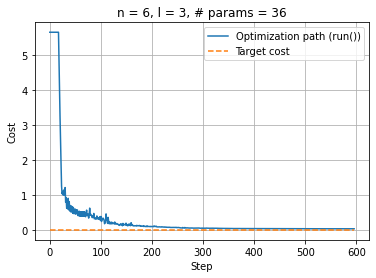

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = optimization_result_run.nfev
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_run_n_{num_qubits}_p_{num_parameters}.png", dpi=200)

### Using `QJob.upgrade_parameters()`

The first step now is to create the `qjob.QJob` object that which parameters we are going to upgrade in each step of the optimization; for that, we must run a circuit with initial parameters in a QPU, the procedure is as we explained above:

In [10]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters

initial_parameters = np.zeros(num_parameters)

circuit = ansatz.assign_parameters(initial_parameters)

qjob = qpu.run(circuit, transpile = True, opt_level = 0, shots = n_shots)

Now that we have sent to the virtual QPU the transpiled circuit, we can use the method `qjob.QJob.upgrade_parameters()` to change the rotations of the gates:

In [11]:
print("Result with initial_parameters: ")
print(qjob.result().get_counts())

random_parameters = np.random.uniform(0, 2 * np.pi, num_parameters).tolist()
qjob.upgrade_parameters(random_parameters)

print()
print("Result with random_parameters: ")
print(qjob.result().get_counts())

Result with initial_parameters: 
{'000000': 100000}

Result with random_parameters: 
{'000000': 1385, '000001': 1348, '010000': 1247, '010001': 2725, '010010': 335, '010011': 2054, '010100': 164, '010101': 1682, '010110': 1751, '010111': 1154, '011000': 489, '011001': 1292, '011010': 225, '011011': 3405, '011100': 901, '011101': 1133, '011110': 33, '011111': 983, '000010': 278, '100000': 156, '100001': 427, '100010': 77, '100011': 1364, '100100': 2718, '100101': 1827, '100110': 936, '100111': 2411, '101000': 1730, '101001': 196, '101010': 134, '101011': 2563, '101100': 2500, '101101': 1262, '101110': 2395, '101111': 6443, '000011': 7627, '110000': 749, '110001': 720, '110010': 206, '110011': 720, '110100': 418, '110101': 806, '110110': 279, '110111': 82, '111000': 2281, '111001': 2279, '111010': 616, '111011': 372, '111100': 4112, '111101': 4877, '111110': 1731, '111111': 2361, '000100': 1542, '000101': 502, '000110': 3453, '000111': 8349, '001000': 488, '001001': 23, '001010': 56, '00

**Important considerations:**

- The method acepts parameters in a `list`, if you have a `numpy.array`, simply apply `.tolist()` to transform it.

- When sending the circuit and setting `transpile=True`, we should be carefull that the transpilation process doesn't condense gates and combine parameters, therefore, if the user wants `cunqa`to transpile, they must set `opt_level=0`.

Note that `qjob.QJob.upgrade_parameters()` is a non-blocking call, as it was `qpu.QPU.run()`.

Now that we are familiar with the procedure, we can design a cost funtion that takes a set of parameters, upgrades the `qjob.QJob`, gets the result and calculates the divergence from the desired distribution:

In [12]:
def cost_function(params):
    n_shots = 100000
    target_dist = target_distribution(num_qubits)
    
    result = qjob.upgrade_parameters(params.tolist()).result()
    
    counts = result.get_counts()
    
    return KL_divergence(counts, n_shots, target_dist)


Now we are ready to start our optimization. We will use `scipy.optimize` to minimize the divergence of our result distribution from the target one:

In [13]:
from scipy.optimize import minimize
import time

i = 0

initial_parameters = np.zeros(num_parameters)

cost = []
individuals = []

def callback(xk):
    global i
    e = cost_function(xk)
    individuals.append(xk)
    cost.append(e)
    if i%10 == 0:
        print(f"Iteration step {i}: f(x) = {e}")
    i+=1

tick = time.time()
optimization_result = minimize(cost_function, initial_parameters, method='COBYLA',
        callback=callback, tol = 0.01,
        options={
        'disp': True,     # Print info during iterations
        'maxiter': 4000     # Limit the number of iterations
    })
tack = time.time()
time_up = tack-tick
print()
print("Total optimization time: ", time_up, " s")

Iteration step 0: f(x) = 4.80575155259839
Iteration step 10: f(x) = 2.970696095355457
Iteration step 20: f(x) = 1.4895029742719816
Iteration step 30: f(x) = 0.7682504360329634
Iteration step 40: f(x) = 0.6136147280902352
Iteration step 50: f(x) = 0.5050298801455128
Iteration step 60: f(x) = 0.42322370261946995
Iteration step 70: f(x) = 0.4921064893896492
Iteration step 80: f(x) = 0.43834989707739025
Iteration step 90: f(x) = 0.35972438627667014
Iteration step 100: f(x) = 0.18442798997495824
Iteration step 110: f(x) = 0.11190454555348284
Iteration step 120: f(x) = 0.09816158141688647
Iteration step 130: f(x) = 0.10854489710323317
Iteration step 140: f(x) = 0.08408709754512673
Iteration step 150: f(x) = 0.06278778790384507
Iteration step 160: f(x) = 0.055076771396215814
Iteration step 170: f(x) = 0.061488076452479716
Iteration step 180: f(x) = 0.06198163653722114
Iteration step 190: f(x) = 0.04581740668492353
Iteration step 200: f(x) = 0.04035067690695984
Iteration step 210: f(x) = 0.033

We can plot the evolution of the cost function during the optimization:

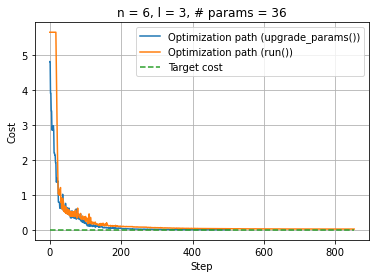

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, optimization_result.nfev, optimization_result.nfev), cost, label="Optimization path (upgrade_params())")
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = max(optimization_result_run.nfev, optimization_result.nfev)
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_n_{num_qubits}_p_{num_parameters}.png", dpi=200)